Replicate [Dynamic Return Dependencies Across Industries: A Machine Learning Approach](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3120110&download=yes) by David Rapach, Jack Strauss, Jun Tu and Guofu Zhou.

Use classification instead of linear regression 
   - Construct response variable with 4 classes by performance quartile. 
   - Construct classification models that minimize cross-entropy vs. 4-class response variable

1) Off-the shelf sklearn algorithms

2) Popular boosting algorithms: XGBoost, CatBoost, LightGBM. These algorithms tend to be faster and more tuneable than the off-the-shelf sklearn classification models, are often used in Kaggle contests

3) Keras neural net classification model

4) Classification models aren't rank-aware. Misclassifying a true long as flat is penalized the same as misclassifying a true long as short. Improve NN model with a custom loss function to increase the penalty for the worst misclassifications. The hope is that this decreases overall classification accuracy but improve portfolio performance.

5) Instead of top 6 - bottom 6, cross-validate thresholds.
 
Adding additional real economy and financial market predictors, and using an ensemble with cross-validation, we get Sharpes exceeding 0.8%.


In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import pandas_datareader.data as datareader
import time 
import datetime
import copy
import random
from itertools import product

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy numpy warnings

# turn off all the warnings
# still some warnings about deprecation, truth value of an array and whatnot
#if not sys.warnoptions:
warnings.simplefilter("ignore")
    
import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, mean_squared_error, explained_variance_score, r2_score, accuracy_score
from sklearn.linear_model import LinearRegression, Lasso, lasso_path, lars_path, LassoLarsIC, LogisticRegression
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils.testing import all_estimators

# other popular gradient boost algorithms
# XGBoost https://xgboost.readthedocs.io/en/latest/
import xgboost 
# Yandex CatBoost https://catboost.yandex/
import catboost 
# Microsoft LightGbm https://lightgbm.readthedocs.io/en/latest/
import lightgbm as lgb 

from scipy.stats import chisquare, kendalltau

import tensorflow as tf

#with tf.device('/job:localhost/replica:0/task:0/device:CPU:0'):
with tf.device('/device:GPU:0'):
    tf.set_random_seed(1764)
    print(tf.__version__)
    # confirm GPU is in use
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

    sess = tf.Session()
    print (sess.run(c))
        
from tensorflow.python import keras
from tensorflow.python.keras.layers import Input, Dense, Activation
from tensorflow.python.keras.models import Model, Sequential, load_model
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.python.keras.regularizers import l1
from tensorflow.python.keras import backend as K
#K.set_session(sess)
    
#import ffn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# this will make dataframe display as sortable widget
# commented out because sortable tables not viewable using nbviewer
# from beakerx import *

import plotly
# print (plotly.__version__) # requires version >= 1.9.0
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.figure_factory as ff

init_notebook_mode(connected=True)

random.seed(1764)
np.random.seed(1764)



/home/ubuntu/anaconda3/envs/tensorflow8/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


1.8.0
[[22. 28.]
 [49. 64.]]


In [2]:
print("Loading data...")
data = pd.read_csv("30_Industry_Portfolios.csv")
data = data.set_index('yyyymm')
industries = list(data.columns)
# map industry names to col nums
ind_reverse_dict = dict([(industries[i], i) for i in range(len(industries))])

rfdata = pd.read_csv("F-F_Research_Data_Factors.csv")
rfdata = rfdata.set_index('yyyymm')
data['rf'] = rfdata['RF']

# subtract risk-free rate
# create a response variable led by 1 period to predict
for ind in industries:
    data[ind] = data[ind] - data['rf']
    
for ind in industries:
    data[ind+".lead"] = data[ind].shift(-1)

data = data.loc[data.index[data.index > 195911]]
data = data.drop(columns=['rf'])    
data = data.dropna(axis=0, how='any')

# add some additional fundamental predictors
# download from FRED using pandas datareader

start_date = datetime.datetime(1926, 9, 1)
end_date = datetime.datetime(2017, 12, 1)
# 3M
TB3MS = datareader.DataReader("TB3MS", "fred", start_date, end_date)
TB3MS['yyyymm'] = TB3MS.index.strftime('%Y%m')
TB3MS['yyyymm'] = [int(datestr) for datestr in TB3MS['yyyymm']]
TB3MS=TB3MS.set_index(['yyyymm'])
data['3month']=TB3MS['TB3MS'].diff()

#10Y
GS10 = datareader.DataReader("GS10", "fred", start_date, end_date)
GS10['yyyymm'] = GS10.index.strftime('%Y%m')
GS10['yyyymm'] = [int(datestr) for datestr in GS10['yyyymm']]
GS10=GS10.set_index(['yyyymm'])
data['10year']=GS10['GS10'].diff()

#industrial production
INDPRO = datareader.DataReader("INDPRO", "fred", start_date, end_date)
INDPRO['yyyymm'] = INDPRO.index.strftime('%Y%m')
INDPRO['yyyymm'] = [int(datestr) for datestr in INDPRO['yyyymm']]
INDPRO=INDPRO.set_index(['yyyymm'])
data['indprod']=INDPRO['INDPRO'].pct_change(periods=12)

#inflation
CPIAUCNS = datareader.DataReader("CPIAUCNS", "fred", start_date, end_date)
CPIAUCNS['yyyymm'] = CPIAUCNS.index.strftime('%Y%m')
CPIAUCNS['yyyymm'] = [int(datestr) for datestr in CPIAUCNS['yyyymm']]
CPIAUCNS=CPIAUCNS.set_index(['yyyymm'])
data['CPI']=CPIAUCNS['CPIAUCNS'].pct_change(periods=12)

# yield curve
data['curve'] = data['10year'] - data['3month']

# overall market return
data['Mkt-RF'] = rfdata['Mkt-RF']

# month dummies
data['month'] = data.index  % 100 # for possible seasonality
month_dummy = keras.utils.to_categorical(data['month'])
for i in range(month_dummy.shape[1]):
    data['month_dummy_%02d' % i] = month_dummy[:,i]
data = data.drop(columns=['month']) 

# reorder so responses are at the end
data = data [['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other', '3month',
       '10year', 'curve', 'Mkt-RF', 'indprod', 'CPI', 'month_dummy_00', 'month_dummy_01',
       'month_dummy_02', 'month_dummy_03', 'month_dummy_04', 'month_dummy_05',
       'month_dummy_06', 'month_dummy_07', 'month_dummy_08', 'month_dummy_09',
       'month_dummy_10', 'month_dummy_11', 'month_dummy_12', 'Food.lead',
       'Beer.lead', 'Smoke.lead', 'Games.lead', 'Books.lead', 'Hshld.lead',
       'Clths.lead', 'Hlth.lead', 'Chems.lead', 'Txtls.lead', 'Cnstr.lead',
       'Steel.lead', 'FabPr.lead', 'ElcEq.lead', 'Autos.lead', 'Carry.lead',
       'Mines.lead', 'Coal.lead', 'Oil.lead', 'Util.lead', 'Telcm.lead',
       'Servs.lead', 'BusEq.lead', 'Paper.lead', 'Trans.lead', 'Whlsl.lead',
       'Rtail.lead', 'Meals.lead', 'Fin.lead', 'Other.lead', ]]

nresponses = len(industries)
npredictors = data.shape[1]-nresponses

predictors = list(data.columns[:npredictors])
predictor_reverse_dict = dict([(predictors[i], i) for i in range(len(predictors))])

responses = list(data.columns[-nresponses:])
response_reverse_dict = dict([(responses[i], i) for i in range(len(responses))])

print(data.shape)

data[['Food', 'Food.lead']]


Loading data...
(697, 79)


Food  Food.lead
yyyymm                  
195912   2.01      -4.49
196001  -4.49       3.35
196002   3.35      -1.67
196003  -1.67       1.17
196004   1.17       8.20
196005   8.20       5.39
196006   5.39      -2.11
196007  -2.11       4.57
196008   4.57      -3.88
196009  -3.88       1.02
196010   1.02       9.46
196011   9.46       4.51
196012   4.51       4.70
196101   4.70       4.21
196102   4.21       4.64
196103   4.64      -1.39
196104  -1.39       4.20
196105   4.20      -2.17
196106  -2.17       2.72
196107   2.72       4.92
196108   4.92      -0.62
196109  -0.62       3.73
196110   3.73       5.28
196111   5.28      -3.69
196112  -3.69      -6.67
196201  -6.67      -0.25
196202  -0.25       0.98
196203   0.98      -4.59
196204  -4.59     -11.25
196205 -11.25      -8.75
...       ...        ...
201507   4.03      -4.37
201508  -4.37      -1.19
201509  -1.19       5.81
201510   5.81       0.11
201511   0.11       1.96
201512   1.96      -1.67
201601  -1.67       0.95
201602   0.95       4.69
201603   4.69       0.63
201604   0.63       2.06
201605   2.06       4.75
201606   4.75      -0.51
201607  -0.51      -0.52
201608  -0.52      -2.92
201609  -2.92      -0.33
201610  -0.33      -4.41
201611  -4.41       4.43
201612   4.43       0.95
201701   0.95       1.71
201702   1.71       0.52
201703   0.52       0.76
201704   0.76       1.63
201705   1.63      -2.65
201706  -2.65       1.52
201707   1.52      -2.77
201708  -2.77       0.43
201709   0.43       0.71
201710   0.71       4.15
201711   4.15      -0.10
201712  -0.10       2.27

[697 rows x 2 columns]

In [3]:
data['CPI']

yyyymm
195912    0.017301
196001    0.010345
196002    0.017301
196003    0.017301
196004    0.017241
196005    0.017241
196006    0.017182
196007    0.013699
196008    0.013699
196009    0.010239
196010    0.013605
196011    0.013605
196012    0.013605
196101    0.017065
196102    0.013605
196103    0.013605
196104    0.010169
196105    0.010169
196106    0.006757
196107    0.013514
196108    0.010135
196109    0.013514
196110    0.006711
196111    0.006711
196112    0.006711
196201    0.006711
196202    0.010067
196203    0.010067
196204    0.013423
196205    0.013423
            ...   
201507    0.001696
201508    0.001951
201509   -0.000361
201510    0.001706
201511    0.005018
201512    0.007295
201601    0.013731
201602    0.010178
201603    0.008525
201604    0.011251
201605    0.010193
201606    0.009973
201607    0.008271
201608    0.010629
201609    0.014638
201610    0.016360
201611    0.016925
201612    0.020746
201701    0.025000
201702    0.027380
201703    0.023806
20170

In [4]:
# first training row: forecast for 196001 using 195912
data = data.loc[data.index[data.index > 195911]]
print(data[responses].columns)
print(data[predictors].columns)
data

Index(['Food.lead', 'Beer.lead', 'Smoke.lead', 'Games.lead', 'Books.lead',
       'Hshld.lead', 'Clths.lead', 'Hlth.lead', 'Chems.lead', 'Txtls.lead',
       'Cnstr.lead', 'Steel.lead', 'FabPr.lead', 'ElcEq.lead', 'Autos.lead',
       'Carry.lead', 'Mines.lead', 'Coal.lead', 'Oil.lead', 'Util.lead',
       'Telcm.lead', 'Servs.lead', 'BusEq.lead', 'Paper.lead', 'Trans.lead',
       'Whlsl.lead', 'Rtail.lead', 'Meals.lead', 'Fin.lead', 'Other.lead'],
      dtype='object')
Index(['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other', '3month', '10year',
       'curve', 'Mkt-RF', 'indprod', 'CPI', 'month_dummy_00', 'month_dummy_01',
       'month_dummy_02', 'month_dummy_03', 'month_dummy_04', 'month_dummy_05',
       'month_dummy_06', 'month_dummy_07', 'month_dummy_

Food  Beer  Smoke  Games  Books  Hshld  Clths   Hlth  Chems  Txtls  \
yyyymm                                                                        
195912   2.01  0.35  -3.02   1.64   7.29   0.67   1.87  -1.97   3.08   0.74   
196001  -4.49 -5.71  -2.05   1.21  -5.47  -7.84  -8.53  -6.68 -10.03  -4.77   
196002   3.35 -2.14   2.27   4.23   2.39   9.31   1.44  -0.02  -0.74   0.32   
196003  -1.67 -2.94  -0.18  -0.65   2.18  -0.56  -2.59   1.26  -2.75  -6.79   
196004   1.17 -2.16   1.35   6.46  -1.17  -1.27   0.21   1.49  -5.53  -1.10   
196005   8.20 -0.52   2.44   7.28  11.67   7.74   1.74  13.50   3.40   2.10   
196006   5.39  0.47   4.73   2.24   0.02   6.38  -1.59  -0.40   0.45   4.04   
196007  -2.11 -0.79   4.60  -4.72   0.23  -0.60  -1.10  -3.99  -6.80  -3.14   
196008   4.57  3.24   5.20   7.16   3.63   5.09   3.34   2.29   1.17  -0.84   
196009  -3.88 -5.00  -2.09  -2.33  -6.20  -9.18  -4.23  -8.87  -6.70  -5.25   
196010   1.02  0.54   3.87   0.11   2.38   6.48  -3.50  -3.71  -1.59  -3.06   
196011   9.46  6.57   5.44  13.91  10.11   9.13   3.15   3.91   4.25   2.04   
196012   4.51 -0.31   3.54   7.77   7.41   1.76   3.28   6.06   2.85   0.52   
196101   4.70  5.23   8.77   0.56   9.47   4.36   5.94   5.86   6.46  11.21   
196102   4.21  8.16   5.41  22.33   2.15   5.90   7.84   5.05   2.13   6.81   
196103   4.64  2.55   5.60   7.18   4.77   6.34   3.08   3.60   0.92   5.92   
196104  -1.39  1.40  -0.23  -2.21  -6.37   2.66   2.60  -0.47  -1.47  -5.31   
196105   4.20  5.38   3.39  -3.91   2.71  -0.02   6.80   2.10   5.50   5.47   
196106  -2.17 -3.12   3.97  -5.87  -3.85   3.43  -5.50  -3.58  -1.32  -3.36   
196107   2.72  0.88   5.95  -1.21  -2.55   1.97   2.03   3.27   2.95   1.53   
196108   4.92  3.20   7.74   0.89   0.89  10.45   5.21   3.70   2.35   5.77   
196109  -0.62 -1.48  -0.07   1.24   0.75  -3.05  -1.14  -1.48  -4.45  -4.25   
196110   3.73 -0.84   7.05  -5.26   0.99  -0.67   8.28   3.33   0.05   3.11   
196111   5.28  4.47   8.03   0.25   3.75   4.51   5.30   3.12   2.49   7.37   
196112  -3.69  1.41  -6.12   1.97  -3.66  -3.78   0.32  -2.21  -0.16  -1.17   
196201  -6.67 -3.45  -4.28 -13.23  -3.44  -7.37  -5.89  -4.86  -4.76   0.57   
196202  -0.25  0.28   0.68  -2.02  -0.52  -0.90   2.01   3.56   3.30   1.93   
196203   0.98 -0.34  -6.67  -5.34   0.41   4.31  -1.18   0.34  -2.72  -0.74   
196204  -4.59 -3.59 -12.99 -11.04  -8.74  -7.03  -8.01 -11.23  -6.23  -7.53   
196205 -11.25 -9.05 -14.14 -11.39 -14.87 -10.19 -10.01 -11.14  -8.25  -7.50   
...       ...   ...    ...    ...    ...    ...    ...    ...    ...    ...   
201507   4.03  3.51   9.59   6.09  -2.90   0.71   5.96   3.66  -4.90  -0.72   
201508  -4.37 -3.12  -4.06  -7.35  -8.61  -6.94  -3.86  -8.37  -7.15  -3.11   
201509  -1.19  2.58   2.37  -9.94  -5.32  -0.53   1.18  -7.28  -8.38  -5.92   
201510   5.81  8.06  10.90  14.61  12.21   5.81   0.98   7.74  16.62   7.96   
201511   0.11 -0.71  -3.00  -0.41  -1.17  -1.10  -1.08   0.71   1.68  -2.59   
201512   1.96  0.30   1.59  -1.70  -6.18   1.86  -4.38   0.39  -4.82  -2.65   
201601  -1.67 -0.23   4.28  -8.15  -5.28   0.16   1.52  -9.43 -11.10  -5.33   
201602   0.95 -2.34   0.93   4.25  -0.96   0.34   0.81  -1.09   6.79   0.63   
201603   4.69  5.61   5.04   8.61   6.88   4.65   2.30   2.90   8.33   3.58   
201604   0.63  0.31  -0.25  -6.30   1.82  -0.42  -2.27   3.55   3.77   1.55   
201605   2.06 -0.91   0.83   5.42  -0.53  -0.09  -4.96   2.46  -1.42  -1.70   
201606   4.75  5.31   6.87  -4.43  -0.34   3.16   1.63   0.11  -1.14  -4.67   
201607  -0.51  1.82  -2.79   6.15   7.38   2.58   1.62   6.00   4.29   8.39   
201608  -0.52 -0.90  -1.22   0.94   0.29   1.24   1.37  -3.24   2.48   1.03   
201609  -2.92  1.63  -2.78   4.62  -3.95   0.00  -6.92   0.35  -1.76  -4.87   
201610  -0.33 -1.65   4.59   5.59 -10.28  -2.96  -5.76  -7.45  -1.95  -4.17   
201611  -4.41 -5.76  -5.12   3.87   8.15  -4.18   1.80   1.37   7.55   1.58   
201612   4.43  3.00   5.39  -3.36   1.98   1.43  -0.44   0.

In [5]:
data.to_csv("data.csv")
desc = data.describe()
desc
# min, max line up with Table 1

Food        Beer       Smoke       Games       Books       Hshld  \
count  697.000000  697.000000  697.000000  697.000000  697.000000  697.000000   
mean     0.688666    0.727030    0.985079    0.732095    0.532253    0.564333   
std      4.308660    5.058992    6.032324    7.128170    5.780362    4.728000   
min    -18.150000  -20.190000  -25.320000  -33.400000  -26.560000  -22.240000   
25%     -1.630000   -2.080000   -2.740000   -3.390000   -2.600000   -2.030000   
50%      0.740000    0.750000    1.270000    0.940000    0.510000    0.750000   
75%      3.070000    3.690000    4.660000    5.260000    3.640000    3.540000   
max     19.890000   25.510000   32.380000   34.520000   33.130000   18.220000   

            Clths        Hlth       Chems       Txtls     ...      Telcm.lead  \
count  697.000000  697.000000  697.000000  697.000000     ...      697.000000   
mean     0.690387    0.665825    0.552367    0.687145     ...        0.515968   
std      6.355251    4.897557    5.482363    6.970961     ...        4.607931   
min    -31.500000  -21.060000  -28.600000  -33.110000     ...      -16.440000   
25%     -2.800000   -2.230000   -2.750000   -3.170000     ...       -2.110000   
50%      0.700000    0.760000    0.720000    0.640000     ...        0.590000   
75%      4.310000    3.550000    3.760000    4.480000     ...        3.360000   
max     31.790000   29.010000   21.680000   59.030000     ...       21.220000   

       Servs.lead  BusEq.lead  Paper.lead  Trans.lead  Whlsl.lead  Rtail.lead  \
count  697.000000  697.000000  697.000000  697.000000  697.000000  697.000000   
mean     0.729928    0.622970    0.534806    0.601090    0.631076    0.698235   
std      6.486956    6.698787    5.021876    5.707154    5.571040    5.334178   
min    -28.670000  -32.070000  -27.740000  -28.500000  -29.250000  -29.740000   
25%     -3.050000   -3.220000   -2.400000   -2.780000   -2.560000   -2.380000   
50%      1.010000    0.670000    0.710000    0.900000    0.940000    0.540000   
75%      4.260000    4.630000    3.460000    4.040000    3.880000    3.980000   
max     23.380000   24.660000   21.000000   18.500000   17.530000   26.490000   

       Meals.lead    Fin.lead  Other.lead  
count  697.000000  697.000000  697.000000  
mean     0.728766    0.637547    0.396628  
std      6.065564    5.381389    5.771655  
min    -31.890000  -22.530000  -28.090000  
25%     -2.840000   -2.400000   -2.930000  
50%      1.080000    0.870000    0.540000  
75%      4.300000    4.000000    4.200000  
max     27.380000   20.590000   19.960000  

[8 rows x 79 columns]

In [6]:
X = data.values[:,:npredictors]
Y = data.values[:,-nresponses:]
nrows = X.shape[0]
X.shape

(697, 49)

In [7]:
# first iteration will train up to including 196911
# will use 196912 to predict 197001
# 1970101 will be first month of performance to use
# train on first 121 months up to 196912 (0:120), put first prediction in P[121] (122nd row)
# first month of performance will be 197002
FIRST_TRAIN_MONTHS = 121
FIRST_PREDICT_MONTH = FIRST_TRAIN_MONTHS # This is stupid but keeps my head straight

print(X[FIRST_TRAIN_MONTHS])
print(data.iloc[FIRST_TRAIN_MONTHS][:30])

[-3.34000000e+00 -1.95000000e+00 -7.59000000e+00 -7.76000000e+00
 -1.20500000e+01 -7.50000000e+00 -5.69000000e+00 -7.71000000e+00
 -7.37000000e+00 -5.26000000e+00 -9.84000000e+00 -6.31000000e+00
 -7.15000000e+00 -6.89000000e+00 -9.35000000e+00 -1.24900000e+01
 -2.34000000e+00 -7.70000000e-01 -1.21600000e+01 -4.83000000e+00
 -3.16000000e+00 -1.11700000e+01 -9.73000000e+00 -8.89000000e+00
 -8.17000000e+00 -8.28000000e+00 -6.31000000e+00 -1.31200000e+01
 -9.78000000e+00 -6.20000000e+00  5.00000000e-02  1.40000000e-01
  9.00000000e-02 -8.10000000e+00 -6.75898953e-03  6.17977528e-02
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
Food     -3.34
Beer     -1.95
Smoke    -7.59
Games    -7.76
Books   -12.05
Hshld    -7.50
Clths    -5.69
Hlth     -7.71
Chems    -7.37
Txtls    -5.26
Cnstr    -9.84
Steel    -6.31
FabPr    -7.15
ElcEq  

In [8]:
class PredictWrapper():
    """Wrap an sklearn model e.g. LinearRegression to fit, predict all vars as a vector, 
    match the way our Keras model will do it"""

    def __init__(self, create_model, coef_dict, fit_missing=None):
        self.create_model = create_model        
        self.coef_dict = coef_dict
        self.fit_missing = fit_missing
        self.models = []
        
    def fit(self, X_fit, Y_fit, verbose=False):
        
        self.nrows, self.ycols = Y_fit.shape
        self.models = []
        # fit model for each column
        for responsecol in range(self.ycols):
            if self.coef_dict[responsecol]:
                # column indexes to fit against each other
                predcols = self.coef_dict[responsecol]
            else: # no columns selected
                if not self.fit_missing:
                    # default: don't fit if no predictors selected
                    self.models.append(None)
                    #print(self.models[-1])
                    continue
                elif self.fit_missing == "mean":
                    # append a numeric value to use
                    self.models.append(np.mean(Y_fit[:,responsecol]))
                    #print(self.models[-1])
                    continue
                elif self.fit_missing == "all":
                    # predcols = all columns
                    predcols = range(X_fit.shape[1])

            model = self.create_model() # create 1 sklearn model for each column
            model.fit(X_fit[:, predcols], Y_fit[:,responsecol])
            if verbose:
                print("fit on " + str(X_fit[:, predcols].shape) + str(predcols))
                print(model.coef_)
                            
            self.models.append(model)
                
            #debug
            #print(responsecol)
            #print(X_fit[:, predcols])
            #print("=====")
            #print(Y_fit[:,responsecol])
            #print("=====")
            #print(self.model.coef_)
            #print(self.model.intercept_)
            #print("=====")                

    def predict(self, X_predict, verbose=False):

        predictions = []
        nrows = X_predict.shape[0]

        for responsecol in range(self.ycols):
            #print (type(self.models[responsecol]))
            if type(self.models[responsecol]) == np.float64:
                pred = np.array([self.models[responsecol]] * nrows).reshape(nrows,1)
                predictions.append(pred)
                sys.stdout.write('\010#')
            elif not self.models[responsecol]: 
                # don't predict
                predictions.append(np.array([np.nan] * nrows ).reshape(nrows,1))
                sys.stdout.write('\010N')
            else:
                predcols = self.coef_dict[responsecol]
                y_pred = self.models[responsecol].predict(X_predict[:,predcols])
                if verbose:
                    print("predict on" + str(X_predict[:, predcols].shape) + str(predcols))
                    print(y_pred)
                predictions.append(y_pred.reshape(nrows,1))
        
        return np.hstack(predictions)
        
        

In [9]:
class ClassifyWrapper():
    """Wrap an sklearn model e.g. LogisticRegression to fit, predict all vars as a vector, 
    match the way our Keras model will do it. No coef_dict"""

    def __init__(self, create_model):
        self.create_model = create_model        
        self.models = []
        
    def fit(self, X_fit, Y_fit, verbose=False):
        
        self.nrows, self.ycols = Y_fit.shape
        #print("%d rows x %d cols" % (self.nrows, self.ycols))
        self.nclasses = np.unique(Y_fit).shape[0]
        self.models = []
        # fit model for each column
        for responsecol in range(self.ycols):
            model = self.create_model() # create 1 sklearn model for each column
            model.fit(X_fit, Y_fit[:,responsecol])
            self.models.append(model)

    def predict(self, X_predict, verbose=False):

        predictions = []
        nrows = X_predict.shape[0]

        for responsecol in range(self.ycols):
            y_pred = self.models[responsecol].predict(X_predict)
            #print(y_pred.shape)
            predictions.append(y_pred.reshape(nrows,1))
        
        return np.hstack(predictions)
        
    def predict_proba(self, X_predict, verbose=False):

        """return a list of length nclasses with probs for each class"""
        retlist = [list() for i in range(self.nclasses)]
        nrows = X_predict.shape[0]

        for responsecol in range(self.ycols):
            y_pred = self.models[responsecol].predict_proba(X_predict)
            for classcol in range(self.nclasses):
                retlist[classcol].append((y_pred[:,classcol].reshape(nrows,1)))
        return [np.hstack(predictions) for predictions in retlist]
        
        

### BacktestModel class to abstract walk-forward validation and backtesting workflow from modeling, portfolio construction, reporting

In [10]:
# typical pipeline
# backtestmodel = BacktestModel(X, # predictors
#                              Y, # responses
#                              create_model=LinearRegression, # create_model which returns a model (needed for 'timestep' which creates different model each timestep)
#                              # or model = someKerasModel, # initialized model that supports fit(X,Y), predict(X) , predicts an entire row,
#                              coef_dict_param=coef_dict_paper, # how to map predictors to responses ("all", "timestep", or a list of lists)
#                              startindex=FIRST_TRAIN_MONTHS, # initial training for backtest
#                              fit_missing='mean', # what to do when no predictors are selected in coef_dict_param - use all predictors, use historical mean, use np.nan
#                              scaler = None) # scaling function like MinMaxScaler

# backtestmodel.gen_predictions(verbose=False) # starting from startindex, step through X,Y month by month, fit up to current month, predict next month, store prediction in self.P
# backtestmodel.walkforward_xval(n_splits=5, verbose=True) # calls gen_predictions with a large step, fits and predicts one large fold at a time (useful to cross-validate quickly)
# backtestmodel.evaluate_predictions() # report metrics on prediction : MSE etc. #TODO: support custom calcs before/after/instead of default calcs
# backtestmodel.gen_returns(calc_returns, verbose=True) # takes a function that returns portfolio returns based on self.P, stores in self.R
# backtestmodel.report_returns(start_date=start_date_str, freq='M') # calc cumulative perf and report (TODO: allow it to take a reporting function to run before/after/in place of default report)
# backtestmodel.evaluate_quantiles(chart=True, verbose=True) # report quantile metrics # TODO: make this a custom calc passed into evaluate_predictions

class BacktestModel():
    
    def __init__(self, 
                 X, # predictors
                 Y, # responses
                 model=None, # model that supports fit(X,Y), predict(X) , predicts an entire row,
                 create_model=None, # or create_model which returns a model (needed for 'timestep' but slows down so pass model if dynamic not needed)
                 coef_dict_param="all", # mapping of predictors to responses ("all", "timestep", or a list of lists)
                 startindex=FIRST_TRAIN_MONTHS,
                 scaler=None,
                 make_classes=None,
                 fit_missing=None):
        
        self.Xrows, self.Xcols = X.shape
        self.Yrows, self.Ycols = Y.shape
        
        if self.Xrows != self.Yrows:
            raise(ValueError, "Shapes differ: X %s, Y %s" % (str(X.shape), str(Y.shape)))            
            
        self.X = X
        self.Y = Y
        self.Xscale = X.copy()
        self.Yscale = Y.copy()

        if scaler:
            print("scaler: %s " %str(scaler))
            # by rows
            # MinMaxScaler: each row (min->0, max->1) 
            # StandardScaler: each row (mean->0, SD->1)            
            # self.Xscale = scaler().fit_transform(self.Xscale.transpose()).transpose()
            # self.Yscale = scaler().fit_transform(self.Yscale.transpose()).transpose()
            # by cols
            # MinMaxScaler: each col (min->0, max->1) 
            # StandardScaler: each col (mean->0, SD->1)            
            self.Xscale = scaler().fit_transform(self.Xscale)
            self.Yscale = scaler().fit_transform(self.Yscale)
        
        if make_classes: # doing classification, turn Y target into classes
            self.Yscale = make_classes(self.Yscale)
            self.nclasses = np.unique(self.Yscale).shape[0]
        self.make_classes = make_classes

        self.model = model
        self.create_model = create_model
        self.coef_dict_param = coef_dict_param
        self.startindex = startindex
        self.fit_missing = fit_missing

    def fit_predict_regression(self, ntrain, npredict=1, verbose=False):
        """for backtest, train model using Y v. X 
        train on first ntrain rows. if ntrain=121, fit 0:120
        predict following npredict rows 
        if npredict=1, predict row 121
        if npredict=12, predict rows 121-132
        """
        
        # fit first ntrain rows
        X_fit = self.Xscale[:ntrain]  # e.g. 0:120
        Y_fit = self.Yscale[:ntrain]
        # predict npredict rows
        X_predict = self.Xscale[ntrain:ntrain+npredict] # 121-122
        X_predict = X_predict.reshape(npredict,self.Xcols)
       
        # if no coef_dict select predictors into coef_dict
        if self.coef_dict_param == "timestep":
            msg = "Performing subset selection"
            coef_dict = subset_selection(X_fit, Y_fit, LassoLarsIC(criterion='aic'))
        # if coef_dict == "all" use all predictors for each response        
        elif self.coef_dict_param == 'all':
            msg = "Using all predictors"
            coef_dict = [range(self.Xcols) for _ in range(self.Ycols)]
        else: # should check valid dict
            msg = "Using coef_dict predictors"
            coef_dict = self.coef_dict_param
        if verbose: 
            print(msg)

        if self.create_model:
            self.model = PredictWrapper(self.create_model, coef_dict, fit_missing=self.fit_missing)
            
        self.model.fit(X_fit, Y_fit, verbose=verbose)
        return self.model.predict(X_predict, verbose=verbose)

    def fit_predict_classify(self, ntrain, npredict=1, predict_classes=False, verbose=False):
        """for backtest, train model using Y v. X 
        train on first ntrain rows. if ntrain=121, fit 0:120
        predict following npredict rows 
        if npredict=1, predict row 121
        if npredict=12, predict rows 121-132
        """
        
        # fit first ntrain rows
        X_fit = self.Xscale[:ntrain]  # e.g. 0:120
        Y_fit = self.Yscale[:ntrain]
        # predict npredict rows
        X_predict = self.Xscale[ntrain:ntrain+npredict] # 121-122
        X_predict = X_predict.reshape(npredict,self.Xcols)

        if self.create_model:
            self.model = ClassifyWrapper(self.create_model)
            
        self.model.fit(X_fit, Y_fit)
        Y_predict =  self.model.predict_proba(X_predict, verbose=verbose)
        if predict_classes:
            return np.argmax(np.array(Y_predict), axis=0, out=None)
        else:
            return Y_predict


    def gen_predictions_regression(self,
                                   step=1, 
                                   splits=None,
                                   verbose=False):

    # predict all months
    # initial train_months = 120 -> train first model on 120 rows
    # first prediction will be in P[120] (121st row)
    # step = 6 -> predict following 6 rows, then step forward 6 months at a time
    # initialize predictions matrix self.P
    
    # use either step or folds
    # step, do range(self.startindex, nrows, step)
    # folds, at each fold train 0:startfold, predict startfold+1:endfold
    # store only out-of-sample predictions in P, calc out-of-sample MSE
    
    # using a step > 1 or folds is quicker, for quicker xval, or to speed up by not estimating model at each timestep

        self.P = np.zeros_like(self.Y)

        progress_i = 0
        self.nrows, self.Ycols = self.Y.shape
        
        if splits:
            month_indexes = splits[:-1] # last index is nrows
        else:
            # create list of steps
            month_indexes = list(range(self.startindex, nrows, step))
        steps = [month_indexes[i+1]-month_indexes[i] for i in range(len(month_indexes)-1)]
        # last step -> end
        steps.append(self.nrows - month_indexes[-1])
        
        if verbose:
            print ("Steps: " + str(month_indexes))

        print("%s Starting training" % (time.strftime("%H:%M:%S")))
            
        for month_index, forecast_rows in zip(month_indexes, steps):
            if verbose:
                print("Training on first %d rows (%d:%d), storing predictions in rows %s" % (month_index, 
                                                                                            0, month_index-1, 
                                                                                            str(range(month_index,month_index+forecast_rows))))
            predictions = self.fit_predict_classify(month_index, forecast_rows, predict_classes=True, verbose=False)

            first_pred_row = month_index
            for row_index in range(forecast_rows):
                self.P[first_pred_row+row_index] = predictions[row_index]
            sys.stdout.write('.')
            progress_i += 1
            if progress_i % 80 == 0:
                print("")
                print("%s Still training step %d of %d" % (time.strftime("%H:%M:%S"), progress_i, len(month_indexes)))
            sys.stdout.flush()
        print("")
        
    def gen_predictions_classify(self,
                                 step=1, 
                                 splits=None,
                                 verbose=False,
                                 classindexes=None
                                ):
        # make this generic  - return fit_predict
        # P = average of classindexes weighted by class probability
        self.P = np.zeros_like(self.Yscale)
        if not classindexes:
            classindexes = range(self.nclasses)
            # sum to 1
            divisor = float(sum(classindexes))
            classindexes = [cw / divisor for cw in classindexes]

        progress_i = 0
        self.nrows, self.Ycols = Y.shape
        
        if splits:
            month_indexes = splits[:-1] # last index is nrows
        else:
            # create list of steps
            month_indexes = list(range(self.startindex, nrows, step))
        steps = [month_indexes[i+1]-month_indexes[i] for i in range(len(month_indexes)-1)]
        # last step -> end
        steps.append(self.nrows - month_indexes[-1])

        print("%s Starting training" % (time.strftime("%H:%M:%S")))
        
        if verbose:
            print ("Steps: " + str(month_indexes))

        for month_index, forecast_rows in zip(month_indexes, steps):
            if verbose:
                print("Training on first %d rows (%d:%d), storing predictions in rows %s" % (month_index, 
                                                                                            0, month_index-1, 
                                                                                            str(range(month_index,month_index+forecast_rows))))
                
            classprobs = self.fit_predict_classify(month_index, forecast_rows, verbose=False)
            first_pred_row = month_index
            for row_index in range(forecast_rows):
                for i in range(len(classprobs)):
                    self.P[first_pred_row + row_index, :] += classprobs[i][row_index, :] * classindexes[i]
            sys.stdout.write('.')
            progress_i += 1
            if progress_i % 80 == 0:
                print("")
                print("%s Still training step %d of %d" % (time.strftime("%H:%M:%S"), progress_i, len(month_indexes)))
            sys.stdout.flush()
        print("")
        
    def gen_predictions(self,
                        step=1, 
                        splits=None,
                        verbose=False):
        if self.make_classes: # classification problem
            if verbose:
                print("classify")
            self.gen_predictions_classify(step=step, splits=splits, verbose=verbose)
        else:
            if verbose:
                print("regression")
            self.gen_predictions_regression(step=step, splits=splits, verbose=verbose)
    
    def evaluate_predictions(self):
        
        # evaluate prediction (can move to separate function)
        msetemp = (self.P[self.startindex:]-self.Yscale[self.startindex:])**2
        #remove nans
        msetemp = msetemp[~np.isnan(msetemp)]
        self.mse = np.mean(msetemp)
        print("OOS MSE across all predictions: %.4f" % self.mse)
        self.model.fit(self.Xscale, self.Yscale)
        Y_pred = self.model.predict(self.Xscale)
        self.in_sample_mse = np.mean((Y_pred - self.Yscale) ** 2)
        print("In-sample MSE: %.4f" % self.in_sample_mse)

        # force unpredicted ys to be nans, then remove nans
        vartemp = self.Yscale[self.startindex:] - self.P[self.startindex:] + self.P[self.startindex:]
        vartemp = vartemp[~np.isnan(vartemp)]
        y_variance = np.var(vartemp[self.startindex:])
        print("Variance: %.4f" % (y_variance))
        print("R-squared: %.4f" % (1- self.mse/y_variance))
        
        return(self.mse)

    def evaluate_quantiles(self, chart=False, verbose=False):
    
        self.P_quantiles = np.zeros_like(self.P)
        self.Y_quantiles = np.zeros_like(self.Y)
        self.kendalltaus = []
        self.ktpvals = []
        # compute score for predicted quantiles vs. actual (expected) quantiles
        N_QUANTILES=4
        for row in range(self.startindex, self.P_quantiles.shape[0]):
            #print(self.P[row])
            try:
                self.P_quantiles[row] = pd.qcut(self.P[row], N_QUANTILES, range(N_QUANTILES))
            except ValueError:
                # some algos return a lot of duplicate predictions like 0.5
                # if qcut fails, add small random numbers and try again
                self.P[row] = self.P[row] + np.random.uniform(low=-0.000001,
                                                              high=0.000001, 
                                                              size=self.P[row].shape[0])
                self.P_quantiles[row] = pd.qcut(self.P[row], N_QUANTILES, range(N_QUANTILES))
            self.Y_quantiles[row] = pd.qcut(self.Y[row], N_QUANTILES, range(N_QUANTILES))
            kt, p_val = kendalltau(self.P[row], self.Y[row])
            self.kendalltaus.append(kt)
            self.ktpvals.append(p_val)

        self.kendalltau = np.mean(self.kendalltaus)
        self.kendalltau_pvalue = np.mean(self.ktpvals)         
        print("Avg rank correlation (Kendall's tau): %.4f (Expected: 0)" % (self.kendalltau))
        pred_quantiles = self.P_quantiles[self.startindex:]
        true_quantiles = self.Y_quantiles[self.startindex:]

        nrows, ncols = pred_quantiles.shape

        pred_quantiles = pred_quantiles.reshape(nrows*ncols)
        true_quantiles = true_quantiles.reshape(nrows*ncols)
        self.quartile_accuracy = accuracy_score(pred_quantiles, true_quantiles)
        print("4-quartile accuracy: %.4f (Expected: 0.25)" % (self.quartile_accuracy))
        
        pred_direction = np.zeros(nrows*ncols)
        true_direction = np.zeros(nrows*ncols)
        for i in range(nrows*ncols):
            if pred_quantiles[i] == 3:
                pred_direction[i] = 1
            elif pred_quantiles[i] == 0:
                pred_direction[i] = -1
            if true_quantiles[i] == 3:
                true_direction[i] = 1
            elif true_quantiles[i] == 0:
                true_direction[i] = -1
        self.directional_accuracy = accuracy_score(pred_direction, true_direction)
        print("Long/short/flat accuracy: %.4f (Expected: 0.375)" % (self.directional_accuracy))

        nrows = nrows * ncols
            
        conf_mat = confusion_matrix(pred_quantiles, true_quantiles)
        if chart:
            fig, ax = plt.subplots(figsize=(10,10))
            sns.heatmap(conf_mat, annot=True, fmt='d')
            plt.ylabel('Actual Quartile')
            plt.xlabel('Predicted Quartile')
            plt.show()

        #self.model.fit(self.Xscale, self.Yscale, verbose=verbose)
        #uses the last model, whatever it may be
        Y_pred = self.model.predict(self.Xscale, verbose=verbose)
        nrows, ncols = Y_pred.shape
        self.insample_accuracy=accuracy_score(self.Yscale.reshape(nrows*ncols,1), Y_pred.reshape(nrows*ncols,1))
            
        return None

    def walkforward_xval (self, n_splits=5, verbose=False):
        """quick and dirty genreturns, with a step"""
        # generate k-fold indexes
        kf = KFold(n_splits=n_splits)
        kf.get_n_splits(X)
        last_indexes = []
        for train_index, test_index in kf.split(X):
            # use test_index as last index to train
            last_index = test_index[-1] + 1
            last_indexes.append(last_index)
        print("%s Generate splits %s" % (time.strftime("%H:%M:%S"), str([i for i in last_indexes])))
        #override startindex
        self.startindex = last_indexes[0]
        self.gen_predictions(splits=last_indexes, verbose=verbose)

    def gen_returns(self, port_returns_func, verbose=False):

        self.R = np.zeros(self.P.shape[0])
        first_pred_month=self.startindex
        
        indcount = [0] * self.Ycols
        longcount = [0] * self.Ycols
        shortcount = [0] * self.Ycols
        
        for month_index in range(first_pred_month, nrows-1):
            return_month = month_index + 1
            port_return, long_indexes, short_indexes = port_returns_func(self.P[month_index], 
                                                                         self.X[return_month])
            self.R[return_month] = port_return
            
            for i in long_indexes:
                indcount[i] += 1
                longcount[i] += 1
            for i in short_indexes:
                indcount[i] += 1
                shortcount[i] += 1
        if verbose:
            for i in range(len(responses)):
                print("%s: long %d times, short %d times, total %d times" % (predictors[i], 
                                                                             longcount[i], 
                                                                             shortcount[i], 
                                                                             indcount[i]))
        return self.R

    
    def report_returns(self, start_date='01/01/1970', freq='M', verbose=True):

        first_pred_month=self.startindex        
        self.results = self.R[first_pred_month:]
        nmonths = self.results.shape[0]
        nyears = nmonths/12.0
        index = pd.date_range(start_date,periods=nmonths, freq=freq)
        perfdata = pd.DataFrame(self.results,index=index,columns=['Returns'])
        perfdata['Equity'] = 100 * np.cumprod(1 + self.results / 100)
        self.cumulative_return = perfdata['Equity']
        self.mean_monthly_return_annualized = np.mean(1 + self.results/100) ** 12 - 1
        self.mean_return = (self.cumulative_return[-1]/100) ** (1.0/nyears) - 1
        self.annualized_vol = np.std(self.results/100) * np.sqrt(12.0)
        self.sharpe = self.mean_monthly_return_annualized/self.annualized_vol
        if verbose:
            print("Mean return: %.3f%%" % (self.mean_return * 100 ))
            #print("Mean monthly annualized return: %.3f%%" % (self.mean_monthly_return_annualized * 100 ))
            #print("Monthly annualized volatility: %.3f%%" % (self.annualized_vol * 100))
            print("Monthly Sharpe ratio: %.3f" % (self.sharpe))

    def sharpe_cv(self, port_returns_func_gen, cv_arg_list, verbose=False):
        if verbose:
            print(cv_arg_list)
        best_sharpe=-999999
        for arg_list in cv_arg_list:
            ret_func = port_returns_func_gen(arg_list)
            self.gen_returns(ret_func, verbose=verbose)
            if verbose:
                print(arg_list)
            self.report_returns(verbose=verbose)
            if self.sharpe > best_sharpe:
                best_cv_params=arg_list
                best_sharpe = self.sharpe
        return best_sharpe, best_cv_params
    
        


In [11]:
# return calculation passed to gen_returns

NUMSTOCKS = 6 # top quintile (and bottom)

def calc_returns_gen(numstocks=NUMSTOCKS):
    def calc_returns(prediction_row, return_row, numstocks=numstocks, verbose=False):
        
        # ensure nan sorts to top for shorts
        short_sort_array = [999999 if np.isnan(x) else x for x in prediction_row]
        # pick bottom numstocks
        select_array = np.argsort(short_sort_array)
        short_indexes = select_array[:numstocks]

        # ensure nan sorts to bottom for longs
        long_sort_array = [-999999 if np.isnan(x) else x for x in prediction_row]
        # pick top numstocks
        select_array = np.argsort(long_sort_array)
        long_indexes = select_array[-numstocks:]

        if verbose:
            print("Longs: %s" %(str([(i,prediction_row[i]) for i in long_indexes])))
            print("Shorts: %s" %(str([(i,prediction_row[i]) for i in short_indexes])))

        # compute equal weighted long/short return
        return np.mean(return_row[long_indexes])/2 - np.mean(return_row[short_indexes])/2, long_indexes, short_indexes

    return calc_returns

calc_returns = calc_returns_gen(NUMSTOCKS)

In [12]:
def make_n_classes(n=4, class_array=None):
    # return a function to make n classes from Y based on n quantiles (or explicit index boundaries)
    
    def make_classes(Y, nclasses=n, class_array=class_array, verbose=False):
    
        # initialize class array to 0s
        Y_class=np.zeros_like(Y)
        # sort indexes
        Y_sortindex = np.argsort(Y)
        
        if class_array is None: # quantile boundaries
            class_array=[]
            for i in range(n):
                class_array.append(int(np.round(i / nclasses * Y_class.shape[1])))
            class_array.append(Y_class.shape[1])
            
        if verbose:
            print(class_array)
            print("Y")
            print(Y[0])
            # sorted position
            print("Y_sortindex")
            print(Y_sortindex[0]) 
            # sorted array
            print("Sorted")
            print(Y[0,Y_sortindex[0]])
            
        for row in range(Y_class.shape[0]):
            # assign indexes within specified sort range to quantile
            for i in range(nclasses):
                start_index, end_index = class_array[i], class_array[i+1]
                qlist = Y_sortindex[row,start_index:end_index]
                Y_class[row, qlist] = i
            
        if verbose:
            print("Y_class")
            print(Y_class[0])
            print("3s")
            print(["%.2f" % Y[0,i] for i in range(30) if Y_class[0,i]==3])
            print("2s")
            print(["%.2f" % Y[0,i] for i in range(30) if Y_class[0,i]==2])
            print("1s")
            print(["%.2f" % Y[0,i] for i in range(30) if Y_class[0,i]==1])
            print("0s")
            print(["%.2f" % Y[0,i] for i in range(30) if Y_class[0,i]==0])
            print(Y_class.shape)
            
        return Y_class
    return make_classes

make_four_classes = make_n_classes(4)
make_four_classes(Y, verbose=True)

[0, 8, 15, 22, 30]
Y
[ -4.49  -5.71  -2.05   1.21  -5.47  -7.84  -8.53  -6.68 -10.03  -4.77
  -6.67  -9.38  -4.42 -12.3  -11.71  -5.03  -3.81  -7.91  -7.82  -2.4
   0.62  -6.18  -7.93  -9.41  -4.31  -5.33  -6.09 -10.08  -4.68  -3.98]
Y_sortindex
[13 14 27  8 23 11  6 22 17  5 18  7 10 21 26  1  4 25 15  9 28  0 12 24
 29 16 19  2 20  3]
Sorted
[-12.3  -11.71 -10.08 -10.03  -9.41  -9.38  -8.53  -7.93  -7.91  -7.84
  -7.82  -6.68  -6.67  -6.18  -6.09  -5.71  -5.47  -5.33  -5.03  -4.77
  -4.68  -4.49  -4.42  -4.31  -3.98  -3.81  -2.4   -2.05   0.62   1.21]
Y_class
[2. 2. 3. 3. 2. 1. 0. 1. 0. 2. 1. 0. 3. 0. 0. 2. 3. 1. 1. 3. 3. 1. 0. 0.
 3. 2. 1. 0. 2. 3.]
3s
['-2.05', '1.21', '-4.42', '-3.81', '-2.40', '0.62', '-4.31', '-3.98']
2s
['-4.49', '-5.71', '-5.47', '-4.77', '-5.03', '-5.33', '-4.68']
1s
['-7.84', '-6.68', '-6.67', '-7.91', '-7.82', '-6.18', '-6.09']
0s
['-8.53', '-10.03', '-9.38', '-12.30', '-11.71', '-7.93', '-9.41', '-10.08']
(697, 30)


array([[2., 2., 3., ..., 0., 2., 3.],
       [2., 0., 2., ..., 1., 0., 3.],
       [1., 1., 3., ..., 0., 3., 1.],
       ...,
       [2., 2., 0., ..., 3., 2., 0.],
       [0., 3., 3., ..., 1., 1., 1.],
       [1., 0., 0., ..., 1., 3., 3.]])

In [13]:
start_date_int = data.index[FIRST_TRAIN_MONTHS]
start_year, start_month = start_date_int // 100, start_date_int % 100
start_date_str = "%02d/%02d/%d" % (start_month, 1, start_year)
start_date_str

'01/01/1970'

In [14]:
# test fit_predict
# suppress scientific notation
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)

backtestmodel = BacktestModel(X, Y, create_model=LogisticRegression, 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS, 
                              make_classes=make_four_classes)
print(backtestmodel.Yscale[122:127])
z = backtestmodel.fit_predict_classify(121, npredict=5, verbose=False)
print("List of %d arrays of shape %s" % (len(z), str(z[0].shape)))
print(z)
#preds
# 1st row
#2 3 3 0
# 1st col
#2 2 0 2

[[2. 2. 3. 0. 0. 2. 1. 0. 3. 3. 1. 2. 3. 3. 3. 1. 1. 0. 2. 3. 3. 0. 1. 1.
  0. 0. 2. 0. 2. 1.]
 [2. 2. 3. 0. 0. 3. 0. 2. 3. 3. 1. 2. 1. 3. 3. 0. 1. 0. 2. 3. 3. 0. 1. 2.
  1. 0. 2. 0. 1. 1.]
 [2. 2. 3. 0. 0. 2. 0. 2. 3. 0. 1. 1. 1. 2. 3. 1. 3. 3. 3. 3. 3. 0. 1. 1.
  2. 0. 1. 0. 2. 0.]
 [3. 2. 3. 0. 0. 1. 1. 3. 3. 3. 1. 1. 2. 3. 2. 0. 3. 2. 3. 2. 0. 0. 0. 1.
  0. 1. 2. 1. 2. 0.]
 [1. 1. 0. 2. 3. 1. 2. 0. 2. 3. 3. 0. 0. 1. 2. 0. 0. 1. 3. 2. 3. 1. 0. 2.
  2. 1. 3. 0. 3. 3.]]
List of 4 arrays of shape (5, 30)
[array([[0.026, 0.362, 0.238, 0.963, 0.05 , 0.03 , 0.717, 0.   , 0.044,
        0.041, 0.002, 0.831, 0.267, 0.004, 0.719, 0.069, 0.283, 0.032,
        0.166, 0.004, 0.106, 0.011, 0.464, 0.22 , 0.292, 0.326, 0.133,
        0.659, 0.207, 0.459],
       [0.006, 0.013, 0.31 , 0.197, 0.025, 0.9  , 0.001, 0.321, 0.202,
        0.037, 0.044, 0.429, 0.001, 0.006, 0.008, 0.608, 0.083, 0.567,
        0.047, 0.81 , 0.657, 0.081, 0.297, 0.301, 0.053, 0.3  , 0.01 ,
        0.699, 0.039, 0.009],
   

In [15]:
# check 4-class output probabilities sum to 1
z = backtestmodel.fit_predict_classify(121, npredict=5, verbose=False)
z[0] + z[1] +z[2] + z[3]

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [16]:
np.array(z).shape
np.argmax(np.array(z), axis=0, out=None)

array([[1, 0, 2, 0, 1, 3, 0, 2, 1, 3, 2, 0, 2, 3, 0, 2, 1, 1, 2, 3, 3, 3,
        0, 1, 2, 2, 3, 0, 3, 3],
       [1, 3, 3, 1, 3, 0, 2, 2, 2, 3, 3, 0, 2, 1, 2, 0, 3, 0, 3, 0, 0, 2,
        1, 2, 2, 3, 1, 0, 3, 1],
       [0, 2, 0, 3, 3, 3, 2, 1, 3, 3, 1, 0, 0, 2, 3, 2, 0, 0, 1, 0, 1, 0,
        3, 1, 2, 2, 3, 2, 1, 3],
       [2, 2, 0, 0, 0, 1, 0, 3, 3, 1, 1, 3, 2, 1, 0, 0, 0, 3, 1, 3, 2, 1,
        3, 2, 3, 0, 2, 2, 1, 0],
       [2, 3, 0, 0, 1, 2, 0, 3, 1, 0, 1, 3, 2, 1, 1, 1, 0, 1, 3, 3, 1, 0,
        2, 2, 3, 1, 2, 0, 0, 0]])

In [17]:
print(backtestmodel.Yscale[121:126])
backtestmodel.fit_predict_classify(121, npredict=5, predict_classes=True, verbose=False)
#preds
# 1st row
#2 3 3 0
# 1st col
#2 2 0 2

[[1. 2. 0. 2. 0. 0. 0. 1. 0. 1. 3. 3. 2. 3. 2. 1. 2. 3. 1. 3. 3. 0. 0. 1.
  3. 0. 2. 2. 3. 1.]
 [2. 2. 3. 0. 0. 2. 1. 0. 3. 3. 1. 2. 3. 3. 3. 1. 1. 0. 2. 3. 3. 0. 1. 1.
  0. 0. 2. 0. 2. 1.]
 [2. 2. 3. 0. 0. 3. 0. 2. 3. 3. 1. 2. 1. 3. 3. 0. 1. 0. 2. 3. 3. 0. 1. 2.
  1. 0. 2. 0. 1. 1.]
 [2. 2. 3. 0. 0. 2. 0. 2. 3. 0. 1. 1. 1. 2. 3. 1. 3. 3. 3. 3. 3. 0. 1. 1.
  2. 0. 1. 0. 2. 0.]
 [3. 2. 3. 0. 0. 1. 1. 3. 3. 3. 1. 1. 2. 3. 2. 0. 3. 2. 3. 2. 0. 0. 0. 1.
  0. 1. 2. 1. 2. 0.]]


array([[1, 0, 2, 0, 1, 3, 0, 2, 1, 3, 2, 0, 2, 3, 0, 2, 1, 1, 2, 3, 3, 3,
        0, 1, 2, 2, 3, 0, 3, 3],
       [1, 3, 3, 1, 3, 0, 2, 2, 2, 3, 3, 0, 2, 1, 2, 0, 3, 0, 3, 0, 0, 2,
        1, 2, 2, 3, 1, 0, 3, 1],
       [0, 2, 0, 3, 3, 3, 2, 1, 3, 3, 1, 0, 0, 2, 3, 2, 0, 0, 1, 0, 1, 0,
        3, 1, 2, 2, 3, 2, 1, 3],
       [2, 2, 0, 0, 0, 1, 0, 3, 3, 1, 1, 3, 2, 1, 0, 0, 0, 3, 1, 3, 2, 1,
        3, 2, 3, 0, 2, 2, 1, 0],
       [2, 3, 0, 0, 1, 2, 0, 3, 1, 0, 1, 3, 2, 1, 1, 1, 0, 1, 3, 3, 1, 0,
        2, 2, 3, 1, 2, 0, 0, 0]])

In [18]:
# chart performance

#plotly version
i
#matplotlib version
def mychart(args, names=None, title=""):
    
    dpi=96
    plt.figure(figsize=(931/dpi,621/dpi))
    mycolors = ['darkblue', 'darkorange']
    
    x_coords = np.linspace(1970, 2016, args[0].shape[0])
    plotdata = []
    for i in range(len(args)):
        tracelabel = "Trace %d" % i
        if names:
            tracelabel=names[i]
            plt.plot(x_coords, args[i].values.reshape(-1), lw=1, c=mycolors[i], alpha=1, label = tracelabel)
            plt.legend(loc="lower right")
        else:
            plt.plot(x_coords, args[i].values.reshape(-1), lw=1, c=mycolors[i], alpha=1)

    if title:
        plt.title(title)

    return plt.show()



In [19]:
def myscatter(arg1, arg2, names=None, title=""):
    
    plotdata = []
    
    plotdata.append(Scatter(
        x = arg1,
        y = arg2,
        mode = 'markers'
    ))

    layout = dict(
        title=title,
        autosize=False,
        width=600,
        height=480,
        yaxis=dict(
#            type='log',
            autorange=True
        )
    )
    
#    py.iplot(data, filename='basic-scatter')

    fig = Figure(data=plotdata, layout=layout)
    
    return iplot(fig)

In [20]:
def plot_matrix(lossframe, x_labels, y_labels, x_suffix="", y_suffix=""):

    pivot = lossframe.pivot_table(index=[y_labels], columns=[x_labels], values=['mse'])
#    print(pivot)
    # specify labels as strings, to force plotly to use a discrete axis
#    print(pivot.columns.levels[1]).values
#    print(lossframe[x_labels].dtype)
    
    if lossframe[x_labels].dtype == np.float64 or lossframe[x_labels].dtype == np.float32:
        xaxis = ["%f %s" % (i, x_suffix) for i in pivot.columns.levels[1].values]
    else:
        xaxis = ["%d %s" % (i, x_suffix) for i in pivot.columns.levels[1].values]
    if lossframe[y_labels].dtype == np.float64 or lossframe[y_labels].dtype == np.float32:
        yaxis = ["%f %s" % (i, y_suffix) for i in pivot.index.values]
    else:
        yaxis = ["%d %s" % (i, y_suffix) for i in pivot.index.values]
        
#    print(xaxis, yaxis)
    """plot a heat map of a matrix"""
    chart_width=640
    chart_height=480
    
    layout = dict(
        title="%s v. %s" % (x_labels, y_labels),
        height=chart_height,
        width=chart_width,     
        margin=dict(
            l=150,
            r=30,
            b=120,
            t=100,
        ),
        xaxis=dict(
            title=x_labels,
            tickfont=dict(
                family='Arial, sans-serif',
                size=10,
                color='black'
            ),
        ),
        yaxis=dict(
            title=y_labels,
            tickfont=dict(
                family='Arial, sans-serif',
                size=10,
                color='black'
            ),
        ),
    )
    
    data = [Heatmap(z=pivot.values,
                    x=xaxis,
                    y=yaxis,
                    colorscale=[[0, 'rgb(0,0,255)', [1, 'rgb(255,0,0)']]],
                   )
           ]

    fig = Figure(data=data, layout=layout)
    return iplot(fig, link_text="")

16:51:26 Generate splits [140, 280, 419, 558, 697]
classify
16:51:26 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
best return gen params:  13
Food: long 270 times, short 206 times, total 476 times
Beer: long 247 times, short 229 times, total 476 times
Smoke: long 280 times, short 218 times, total 498 times
Games: long 237 times, short 265 times, total 502 times
Books: long 273 times, short 195 times, total 468 times
Hshld: long 272 times, short 218 times, total 490 times
Clths: long 265 times, short 214 times, total 479 times
Hlth: long 266 times, short 223 times, total 489 times
Chems: long 203 times, short 280 times, total 483 times
Txtls: long 269 times, short 22

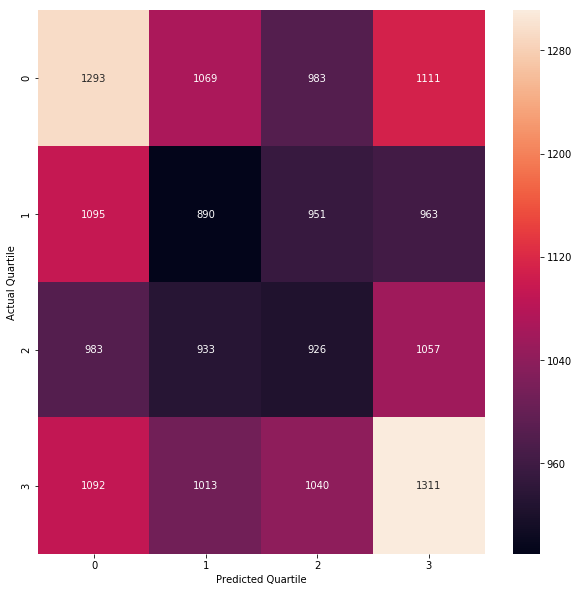

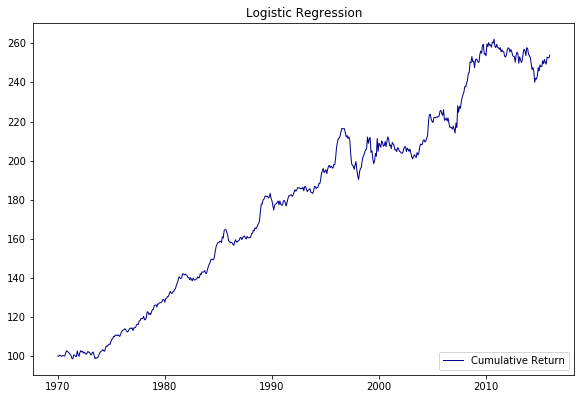

In [21]:
backtestmodel = BacktestModel(X, Y, 
                              create_model=LogisticRegression, 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler = None,
                              make_classes=make_four_classes)
backtestmodel.walkforward_xval(n_splits=5, verbose=True) 
_, best_params = backtestmodel.sharpe_cv(calc_returns_gen, range(1, 16))
print("best return gen params: ", best_params)
backtestmodel.gen_returns(calc_returns_gen(best_params), verbose=True)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
#backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
mychart([backtestmodel.cumulative_return],["Cumulative Return"], title="Logistic Regression")

In [22]:
# enumerate available sklearn classifiers 
estimators = []

for name, class_ in all_estimators():
    if issubclass(class_, sklearn.base.ClassifierMixin):
        if hasattr(class_, 'predict_proba'):
            print(class_)
            estimators.append(class_)

estimators

<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>
<class 'sklearn.ensemble.bagging.BaggingClassifier'>
<class 'sklearn.naive_bayes.BernoulliNB'>
<class 'sklearn.calibration.CalibratedClassifierCV'>
<class 'sklearn.tree.tree.DecisionTreeClassifier'>
<class 'sklearn.tree.tree.ExtraTreeClassifier'>
<class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
<class 'sklearn.naive_bayes.GaussianNB'>
<class 'sklearn.gaussian_process.gpc.GaussianProcessClassifier'>
<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
<class 'sklearn.semi_supervised.label_propagation.LabelPropagation'>
<class 'sklearn.semi_supervised.label_propagation.LabelSpreading'>
<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>
<class 'sklearn.linear_model.logistic.LogisticRegression'>
<class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
<class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>
<c

/home/ubuntu/anaconda3/envs/tensorflow8/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.

/home/ubuntu/anaconda3/envs/tensorflow8/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.

/home/ubuntu/anaconda3/envs/tensorflow8/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20



[sklearn.ensemble.weight_boosting.AdaBoostClassifier,
 sklearn.ensemble.bagging.BaggingClassifier,
 sklearn.naive_bayes.BernoulliNB,
 sklearn.calibration.CalibratedClassifierCV,
 sklearn.tree.tree.DecisionTreeClassifier,
 sklearn.tree.tree.ExtraTreeClassifier,
 sklearn.ensemble.forest.ExtraTreesClassifier,
 sklearn.naive_bayes.GaussianNB,
 sklearn.gaussian_process.gpc.GaussianProcessClassifier,
 sklearn.ensemble.gradient_boosting.GradientBoostingClassifier,
 sklearn.neighbors.classification.KNeighborsClassifier,
 sklearn.semi_supervised.label_propagation.LabelPropagation,
 sklearn.semi_supervised.label_propagation.LabelSpreading,
 sklearn.discriminant_analysis.LinearDiscriminantAnalysis,
 sklearn.linear_model.logistic.LogisticRegression,
 sklearn.linear_model.logistic.LogisticRegressionCV,
 sklearn.neural_network.multilayer_perceptron.MLPClassifier,
 sklearn.naive_bayes.MultinomialNB,
 sklearn.svm.classes.NuSVC,
 sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis,
 sklearn.ens

In [23]:
# try various classifiers - wrap some in closure to set params
def myMLPClassifier():
    return sklearn.neural_network.multilayer_perceptron.MLPClassifier(hidden_layer_sizes=(16, 16), 
                                                                      alpha=0.001, 
                                                                      max_iter=2000)
def mySGDClassifierLog():
    # needs loss="log"
    return sklearn.linear_model.stochastic_gradient.SGDClassifier(loss="log")

def mySVC():
    # needs probability=True
    return sklearn.svm.classes.SVC(probability=True)

def myXGBClassifier(n_estimators=300, max_depth=4, subsample=0.6, learning_rate=0.003):
    # needs nthreads=-1
    def create_model():
        return xgboost.sklearn.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, subsample=subsample, learning_rate=learning_rate, nthreads=-1)
    return create_model

def myCatBoostClassifier():
    def create_model():
        #return catboost.CatBoostClassifier(iterations=n_estimators, learning_rate=learning_rate, depth=max_depth, rsm=subsample, 
        #                                   thread_count=6, loss_function='MultiClass', task_type='CPU', logging_level='Silent')
        return catboost.CatBoostClassifier(loss_function='MultiClass', task_type='CPU', logging_level='Silent')
    return create_model

# at one point some reason couldn't get LightGBM sklearn interface to work, tried to wrap it in a class

class LightGbmWrapper:
    """Wrap Lightgbm model to fit, predict all vars as a vector, 
    match the way our Keras model will do it. No coef_dict"""

    def __init__(self, 
                 param = {'num_leaves':31, 'num_trees':100, 'objective':'multiclass', 'num_class':3, 'metric': 'multi_logloss',},
                 num_round=10):
        self.param = param
        self.num_round = num_round
        self.models = []
        
    def fit(self, X_fit, Y_fit, verbose=False):
        if len(Y_fit.shape) == 1:
            Y_fit = Y_fit.reshape(len(Y_fit), 1)
        self.nrows, self.ycols = Y_fit.shape

        #print("%d rows x %d cols" % (self.nrows, self.ycols))
        self.nclasses = np.unique(Y_fit).shape[0]
        self.models = []
        # fit model for each column
        for responsecol in range(self.ycols):
            train_data = lgb.Dataset(X_fit, label=Y_fit[:,responsecol])
            model = lgb.train(self.param, train_data, self.num_round)
            self.models.append(model)

    def predict_proba(self, X_predict, verbose=False):

        """return a list of length nclasses with probs for each class"""
        retlist = [list() for i in range(self.nclasses)]
        nrows = X_predict.shape[0]

        for responsecol in range(self.ycols):
            y_pred = self.models[responsecol].predict(X_predict)
            for classcol in range(self.nclasses):
                retlist[classcol].append((y_pred[:,classcol].reshape(nrows)))
        retarray = np.hstack([predictions for predictions in retlist])
        return retarray

    def predict(self, X_predict, verbose=False):
        Z = self.predict_proba(X_predict)
        return np.argmax(np.array(Z), axis=0)
        
def myLGBMClassifier():
    def create_model():
        return lgb.LGBMClassifier(silent=True)
    return create_model

16:51:30 Generate splits [140, 280, 419, 558, 697]
classify
16:51:30 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
best return gen params:  9
Food: long 215 times, short 155 times, total 370 times
Beer: long 144 times, short 128 times, total 272 times
Smoke: long 221 times, short 166 times, total 387 times
Games: long 220 times, short 158 times, total 378 times
Books: long 186 times, short 162 times, total 348 times
Hshld: long 220 times, short 156 times, total 376 times
Clths: long 184 times, short 179 times, total 363 times
Hlth: long 200 times, short 152 times, total 352 times
Chems: long 110 times, short 202 times, total 312 times
Txtls: long 248 times, short 182

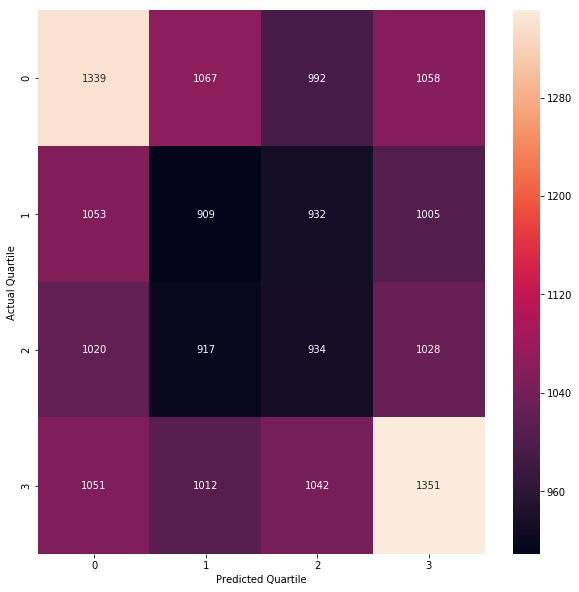

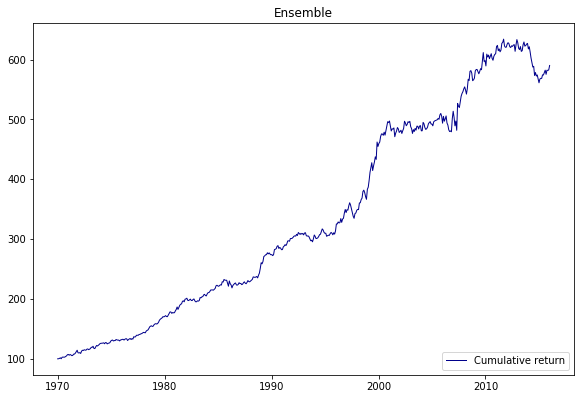

In [24]:
# create an ensemble from the best classifiers
warnings.filterwarnings("ignore")

my_ensemble = [("Logistic Regression", sklearn.linear_model.logistic.LogisticRegression()),
               ("GradientBoost", sklearn.ensemble.gradient_boosting.GradientBoostingClassifier()),
               ("AdaBoost", sklearn.ensemble.weight_boosting.AdaBoostClassifier()),
               ("BernoulliNB", sklearn.naive_bayes.BernoulliNB()),
               ("GaussianNB", sklearn.naive_bayes.GaussianNB()),
               ("ExtraTrees", sklearn.ensemble.forest.ExtraTreesClassifier()),
               ("LGBM", myLGBMClassifier()()),]

def myVC():
    def create_model():
        return VotingClassifier(estimators=my_ensemble,
                                voting="soft")
    return create_model

backtestmodel = BacktestModel(X, Y, 
                              create_model=myVC(), 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler = None,
                              make_classes=make_four_classes)
backtestmodel.walkforward_xval(n_splits=5, verbose=True) 
#backtestmodel.gen_predictions() 
_, best_params = backtestmodel.sharpe_cv(calc_returns_gen, range(1, 16))
print("best return gen params: ", best_params)
backtestmodel.gen_returns(calc_returns_gen(best_params), verbose=True)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
#backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
mychart([backtestmodel.cumulative_return],["Cumulative return"], title="Ensemble")

In [25]:

estimators = [
              sklearn.linear_model.logistic.LogisticRegression,
              #sklearn.linear_model.logistic.LogisticRegressionCV,
              #sklearn.discriminant_analysis.LinearDiscriminantAnalysis,
              #sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis,
              myMLPClassifier,
              sklearn.ensemble.gradient_boosting.GradientBoostingClassifier,
              myXGBClassifier(300, 5, 0.003, 0.6),
              myCatBoostClassifier(), # takes like 20h
              myLGBMClassifier(),
              sklearn.ensemble.weight_boosting.AdaBoostClassifier,
              sklearn.ensemble.bagging.BaggingClassifier,
              sklearn.tree.tree.DecisionTreeClassifier,
              sklearn.ensemble.forest.RandomForestClassifier,
              sklearn.tree.tree.ExtraTreeClassifier,
              sklearn.ensemble.forest.ExtraTreesClassifier,
              sklearn.naive_bayes.BernoulliNB,
              #sklearn.calibration.CalibratedClassifierCV,
              sklearn.naive_bayes.GaussianNB,
              #sklearn.gaussian_process.gpc.GaussianProcessClassifier,
              sklearn.neighbors.classification.KNeighborsClassifier,
              #sklearn.semi_supervised.label_propagation.LabelPropagation,
              #sklearn.semi_supervised.label_propagation.LabelSpreading,
              #sklearn.naive_bayes.MultinomialNB,
              #myNuSVC,
              #mySGDClassifierLog,
              mySVC,
              myVC(),
#              KerasBacktestModel(),
              
             ]


sklearn.linear_model.logistic.LogisticRegression
<class 'type'>
create_model
16:53:47 Generate splits [140, 280, 419, 558, 697]
classify
16:53:47 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
best return gen params:  13
Food: long 270 times, short 206 times, total 476 times
Beer: long 247 times, short 229 times, total 476 times
Smoke: long 280 times, short 218 times, total 498 times
Games: long 237 times, short 265 times, total 502 times
Books: long 273 times, short 195 times, total 468 times
Hshld: long 272 times, short 218 times, total 490 times
Clths: long 265 times, short 214 times, total 479 times
Hlth: long 266 times, short 223 times, total 489 times
Chems: lon

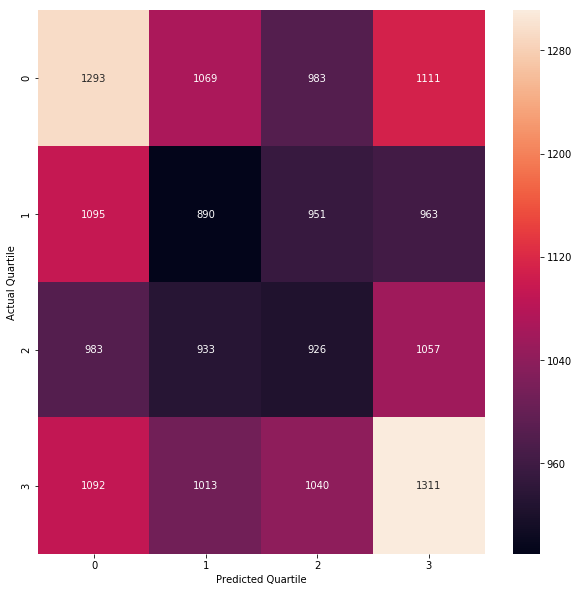

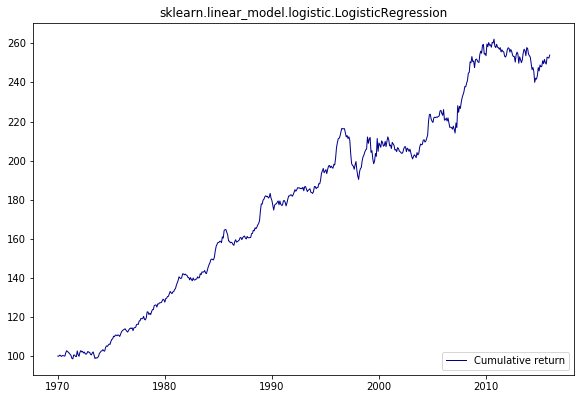

myMLPClassifier
<class 'function'>
create_model
16:53:51 Generate splits [140, 280, 419, 558, 697]
classify
16:53:51 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
best return gen params:  11
Food: long 227 times, short 155 times, total 382 times
Beer: long 239 times, short 168 times, total 407 times
Smoke: long 227 times, short 231 times, total 458 times
Games: long 203 times, short 258 times, total 461 times
Books: long 241 times, short 176 times, total 417 times
Hshld: long 218 times, short 177 times, total 395 times
Clths: long 208 times, short 185 times, total 393 times
Hlth: long 228 times, short 182 times, total 410 times
Chems: long 188 times, short 204 times,

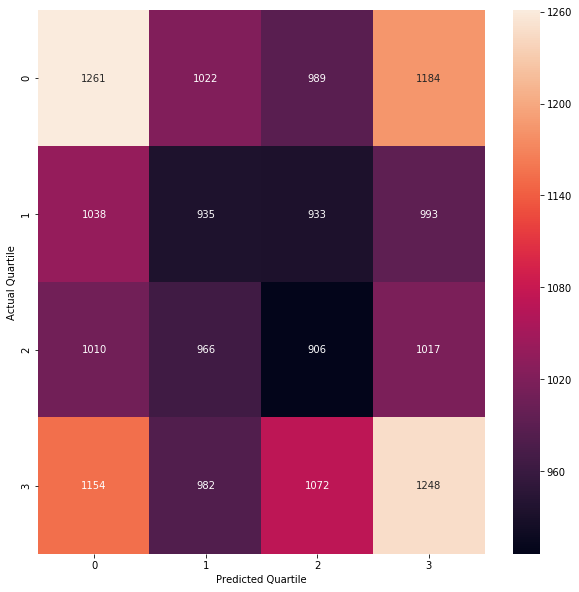

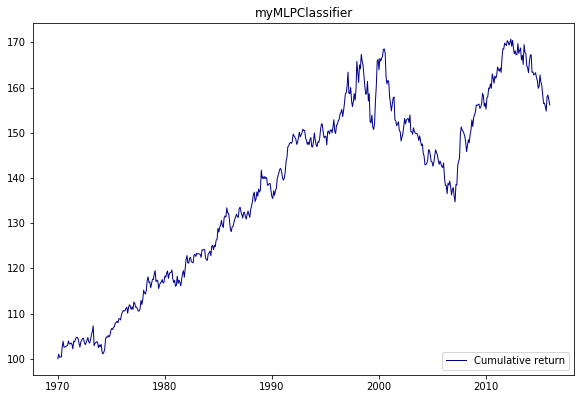

sklearn.ensemble.gradient_boosting.GradientBoostingClassifier
<class 'abc.ABCMeta'>
create_model
16:55:15 Generate splits [140, 280, 419, 558, 697]
classify
16:55:15 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
best return gen params:  6
Food: long 127 times, short 67 times, total 194 times
Beer: long 96 times, short 81 times, total 177 times
Smoke: long 188 times, short 106 times, total 294 times
Games: long 133 times, short 105 times, total 238 times
Books: long 100 times, short 102 times, total 202 times
Hshld: long 107 times, short 72 times, total 179 times
Clths: long 126 times, short 86 times, total 212 times
Hlth: long 131 times, short 79 times, total 210 tim

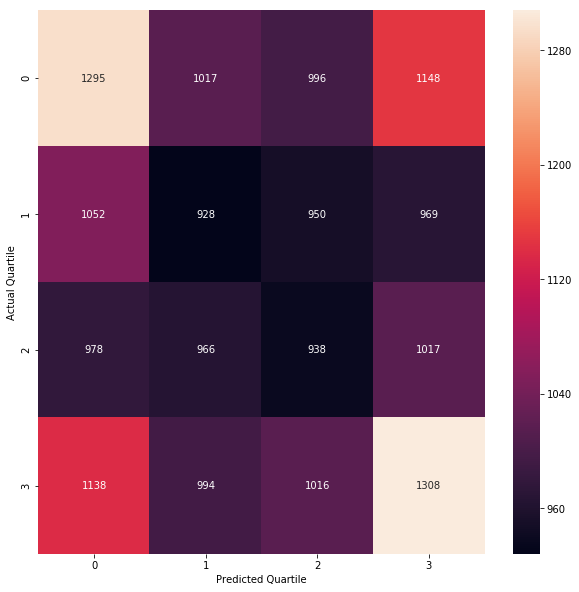

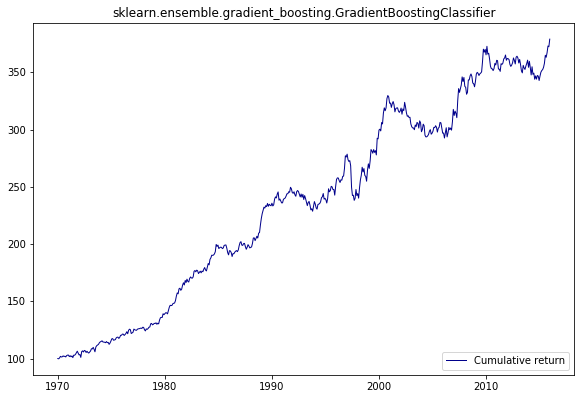

myXGBClassifier.<locals>.create_model
<class 'function'>
create_model
16:56:07 Generate splits [140, 280, 419, 558, 697]
classify
16:56:07 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
best return gen params:  5
Food: long 139 times, short 0 times, total 139 times
Beer: long 0 times, short 217 times, total 217 times
Smoke: long 3 times, short 68 times, total 71 times
Games: long 26 times, short 279 times, total 305 times
Books: long 0 times, short 0 times, total 0 times
Hshld: long 1 times, short 433 times, total 434 times
Clths: long 243 times, short 139 times, total 382 times
Hlth: long 502 times, short 0 times, total 502 times
Chems: long 139 times, short 0 times,

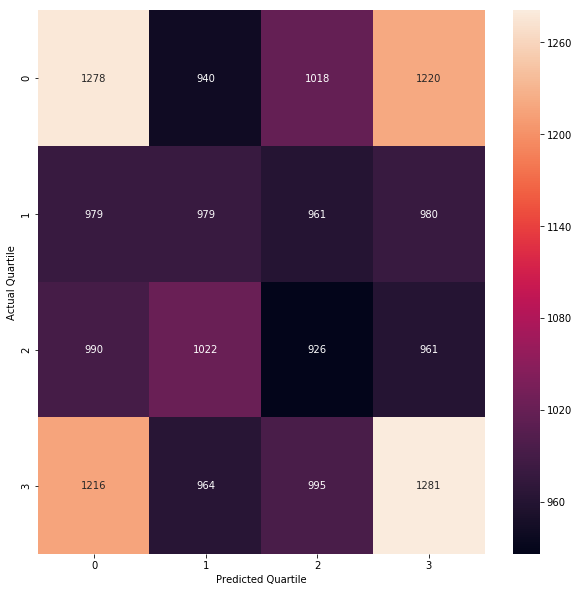

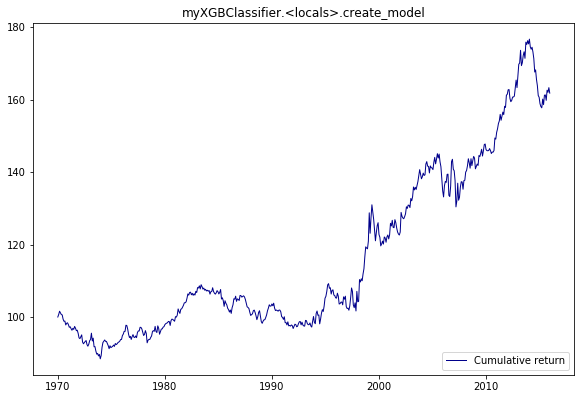

myCatBoostClassifier.<locals>.create_model
<class 'function'>
create_model
16:56:19 Generate splits [140, 280, 419, 558, 697]
classify
16:56:19 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)

Iteration with suspicious time -6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time -6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time 6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time -6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time 6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time -6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time 6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time -6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time 6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time -6.09e+05

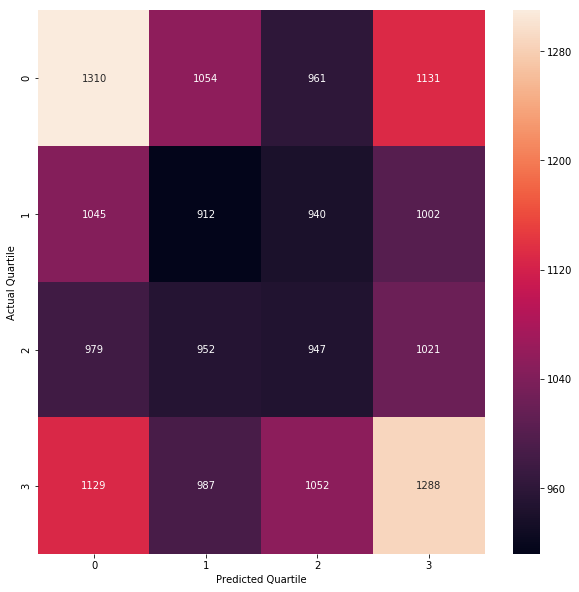

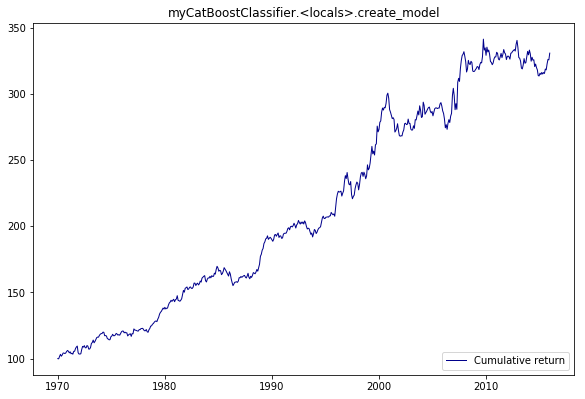

myLGBMClassifier.<locals>.create_model
<class 'function'>
create_model
17:13:19 Generate splits [140, 280, 419, 558, 697]
classify
17:13:19 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
best return gen params:  10
Food: long 245 times, short 107 times, total 352 times
Beer: long 209 times, short 139 times, total 348 times
Smoke: long 270 times, short 157 times, total 427 times
Games: long 216 times, short 189 times, total 405 times
Books: long 189 times, short 184 times, total 373 times
Hshld: long 226 times, short 159 times, total 385 times
Clths: long 178 times, short 205 times, total 383 times
Hlth: long 236 times, short 137 times, total 373 times
Chems: long 122 

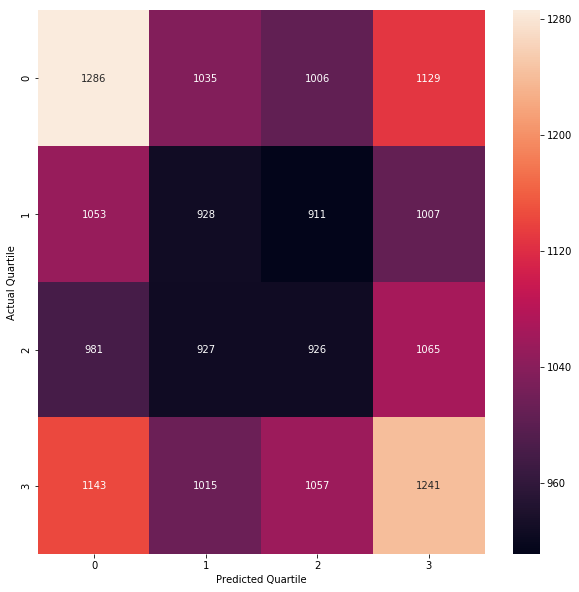

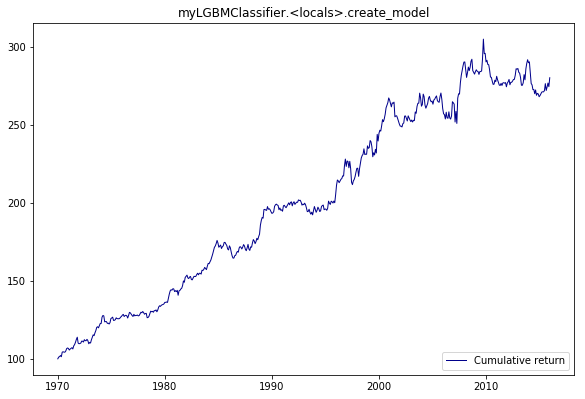

sklearn.ensemble.weight_boosting.AdaBoostClassifier
<class 'abc.ABCMeta'>
create_model
17:13:57 Generate splits [140, 280, 419, 558, 697]
classify
17:13:57 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
best return gen params:  15
Food: long 324 times, short 232 times, total 556 times
Beer: long 382 times, short 174 times, total 556 times
Smoke: long 306 times, short 250 times, total 556 times
Games: long 332 times, short 224 times, total 556 times
Books: long 325 times, short 231 times, total 556 times
Hshld: long 337 times, short 219 times, total 556 times
Clths: long 285 times, short 271 times, total 556 times
Hlth: long 336 times, short 220 times, total 556 times


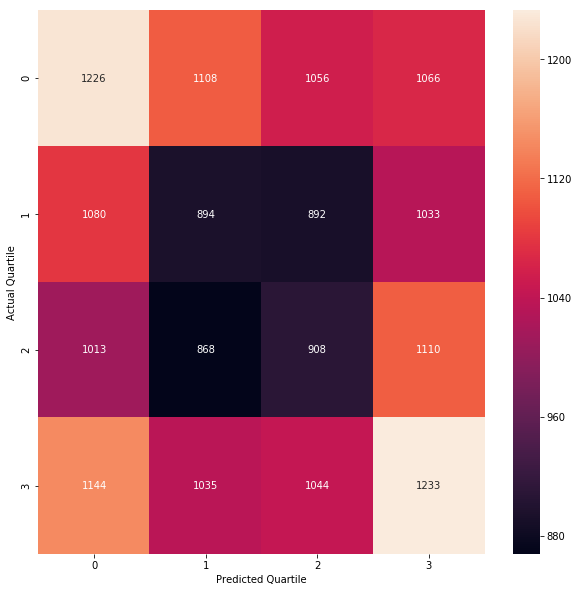

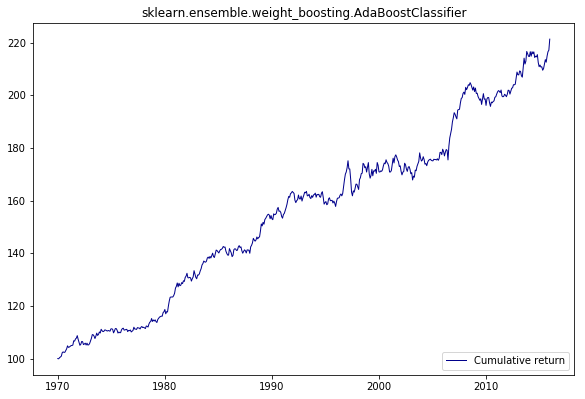

sklearn.ensemble.bagging.BaggingClassifier
<class 'abc.ABCMeta'>
create_model
17:14:09 Generate splits [140, 280, 419, 558, 697]
classify
17:14:09 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
best return gen params:  9
Food: long 223 times, short 108 times, total 331 times
Beer: long 181 times, short 167 times, total 348 times
Smoke: long 210 times, short 177 times, total 387 times
Games: long 183 times, short 177 times, total 360 times
Books: long 158 times, short 176 times, total 334 times
Hshld: long 181 times, short 163 times, total 344 times
Clths: long 180 times, short 133 times, total 313 times
Hlth: long 203 times, short 148 times, total 351 times
Chems: lon

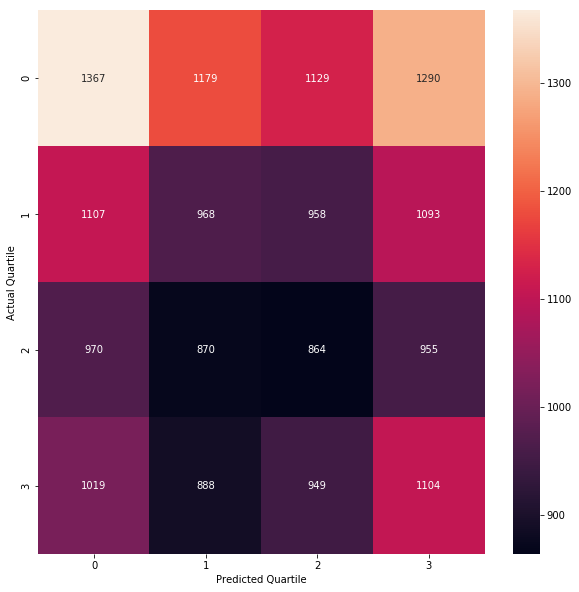

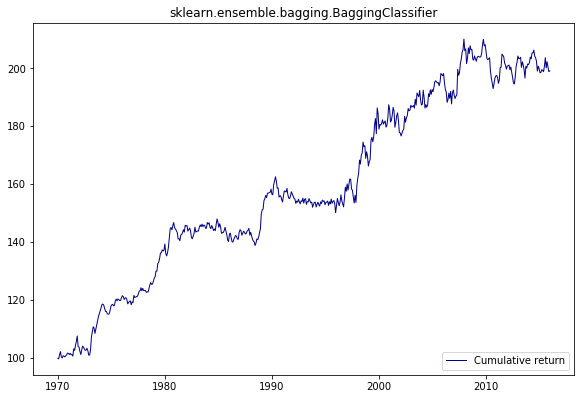

sklearn.tree.tree.DecisionTreeClassifier
<class 'abc.ABCMeta'>
create_model
17:14:17 Generate splits [140, 280, 419, 558, 697]
classify
17:14:17 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
best return gen params:  15
Food: long 292 times, short 264 times, total 556 times
Beer: long 299 times, short 257 times, total 556 times
Smoke: long 322 times, short 234 times, total 556 times
Games: long 307 times, short 249 times, total 556 times
Books: long 279 times, short 277 times, total 556 times
Hshld: long 321 times, short 235 times, total 556 times
Clths: long 279 times, short 277 times, total 556 times
Hlth: long 306 times, short 250 times, total 556 times
Chems: long

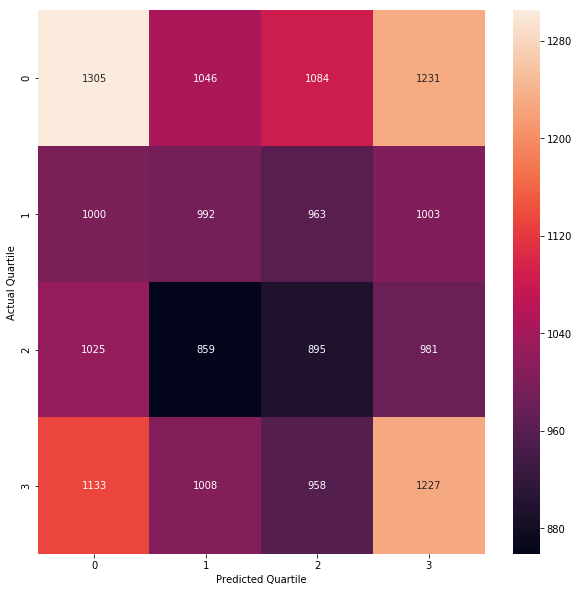

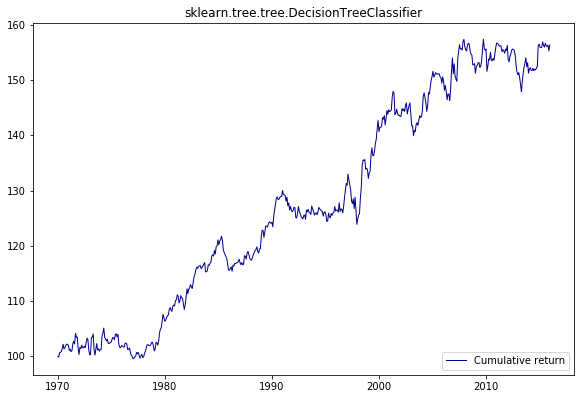

sklearn.ensemble.forest.RandomForestClassifier
<class 'abc.ABCMeta'>
create_model
17:14:20 Generate splits [140, 280, 419, 558, 697]
classify
17:14:20 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
best return gen params:  8
Food: long 199 times, short 117 times, total 316 times
Beer: long 156 times, short 145 times, total 301 times
Smoke: long 206 times, short 139 times, total 345 times
Games: long 182 times, short 152 times, total 334 times
Books: long 152 times, short 157 times, total 309 times
Hshld: long 176 times, short 117 times, total 293 times
Clths: long 163 times, short 131 times, total 294 times
Hlth: long 156 times, short 134 times, total 290 times
Chems:

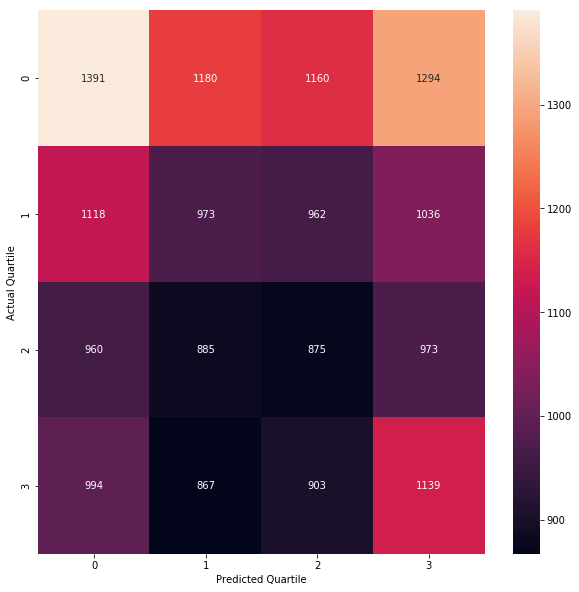

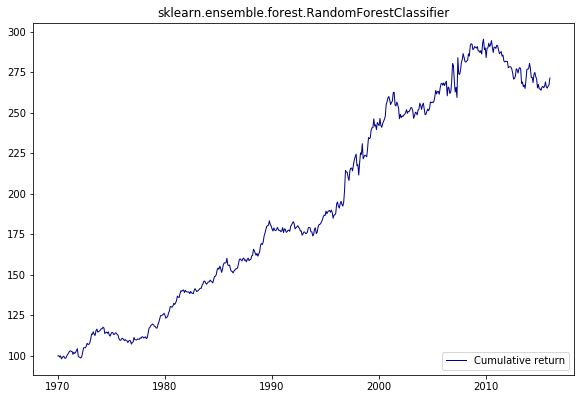

sklearn.tree.tree.ExtraTreeClassifier
<class 'abc.ABCMeta'>
create_model
17:14:23 Generate splits [140, 280, 419, 558, 697]
classify
17:14:23 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
best return gen params:  15
Food: long 276 times, short 280 times, total 556 times
Beer: long 306 times, short 250 times, total 556 times
Smoke: long 341 times, short 215 times, total 556 times
Games: long 290 times, short 266 times, total 556 times
Books: long 313 times, short 243 times, total 556 times
Hshld: long 306 times, short 250 times, total 556 times
Clths: long 286 times, short 270 times, total 556 times
Hlth: long 295 times, short 261 times, total 556 times
Chems: long 26

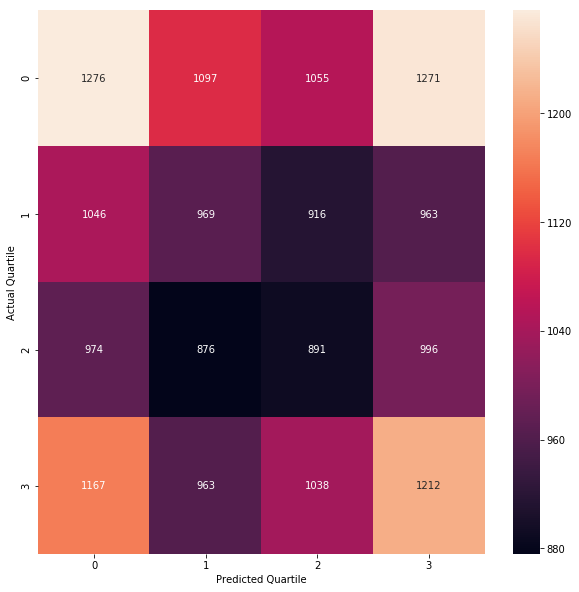

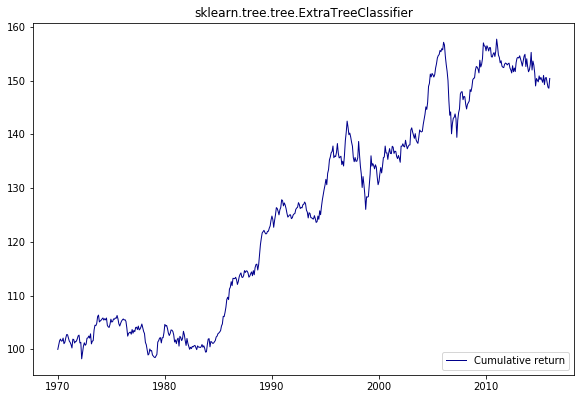

sklearn.ensemble.forest.ExtraTreesClassifier
<class 'abc.ABCMeta'>
create_model
17:14:25 Generate splits [140, 280, 419, 558, 697]
classify
17:14:25 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
best return gen params:  6
Food: long 147 times, short 73 times, total 220 times
Beer: long 114 times, short 100 times, total 214 times
Smoke: long 144 times, short 101 times, total 245 times
Games: long 132 times, short 134 times, total 266 times
Books: long 111 times, short 100 times, total 211 times
Hshld: long 138 times, short 93 times, total 231 times
Clths: long 85 times, short 126 times, total 211 times
Hlth: long 134 times, short 72 times, total 206 times
Chems: long 

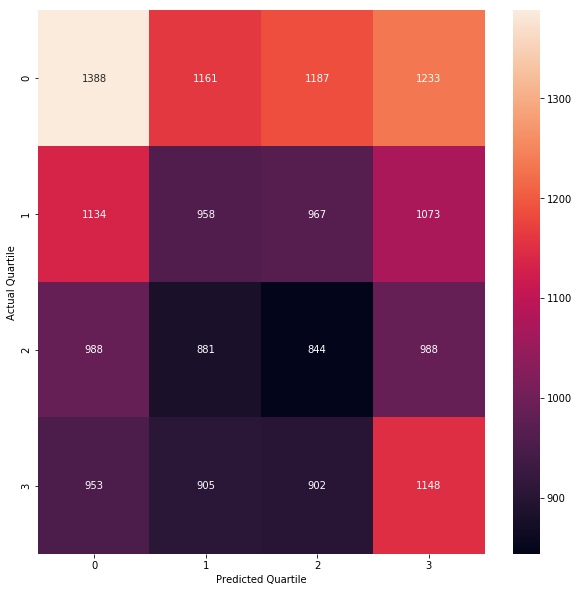

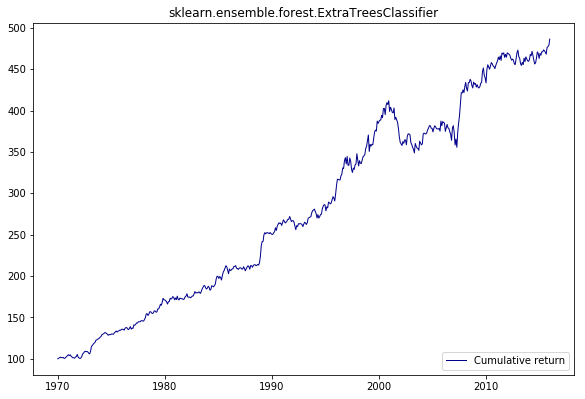

sklearn.naive_bayes.BernoulliNB
<class 'abc.ABCMeta'>
create_model
17:14:29 Generate splits [140, 280, 419, 558, 697]
classify
17:14:29 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
best return gen params:  4
Food: long 167 times, short 72 times, total 239 times
Beer: long 56 times, short 3 times, total 59 times
Smoke: long 53 times, short 76 times, total 129 times
Games: long 208 times, short 98 times, total 306 times
Books: long 147 times, short 90 times, total 237 times
Hshld: long 136 times, short 92 times, total 228 times
Clths: long 70 times, short 142 times, total 212 times
Hlth: long 150 times, short 33 times, total 183 times
Chems: long 27 times, short 43 ti

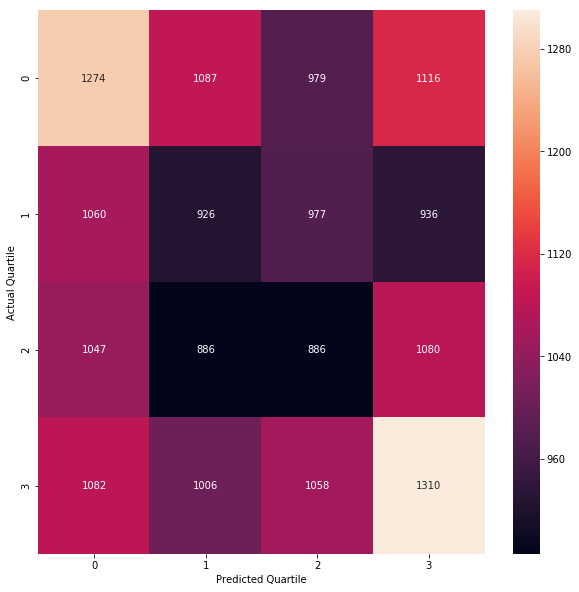

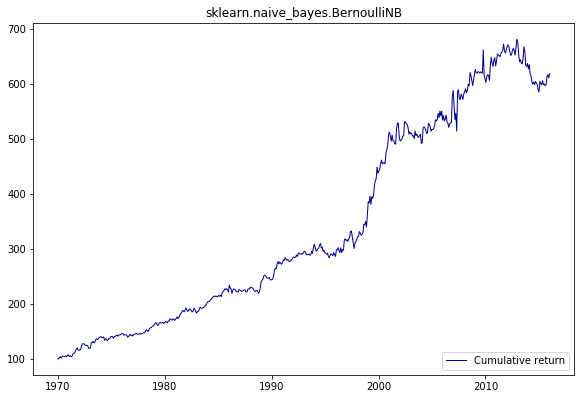

sklearn.naive_bayes.GaussianNB
<class 'abc.ABCMeta'>
create_model
17:14:31 Generate splits [140, 280, 419, 558, 697]
classify
17:14:31 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
best return gen params:  9
Food: long 179 times, short 223 times, total 402 times
Beer: long 114 times, short 194 times, total 308 times
Smoke: long 166 times, short 185 times, total 351 times
Games: long 218 times, short 142 times, total 360 times
Books: long 131 times, short 215 times, total 346 times
Hshld: long 219 times, short 142 times, total 361 times
Clths: long 177 times, short 177 times, total 354 times
Hlth: long 153 times, short 164 times, total 317 times
Chems: long 184 times,

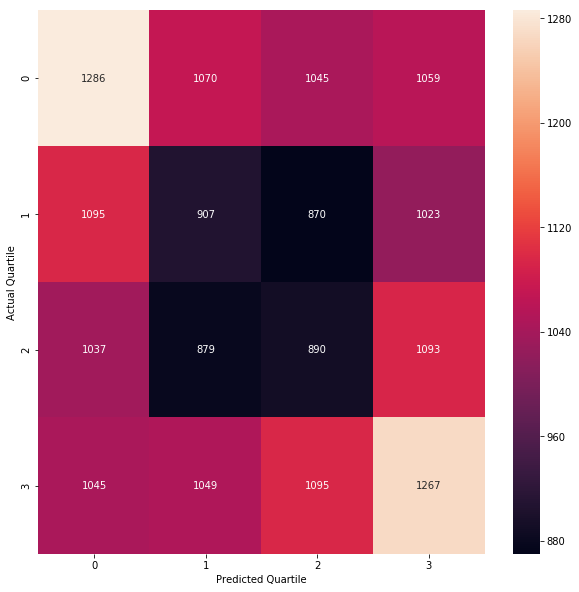

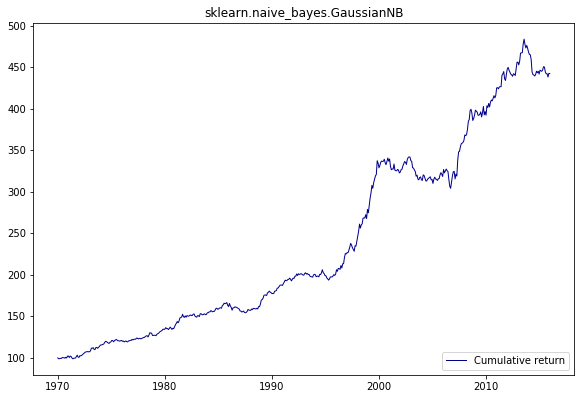

sklearn.neighbors.classification.KNeighborsClassifier
<class 'abc.ABCMeta'>
create_model
17:14:33 Generate splits [140, 280, 419, 558, 697]
classify
17:14:33 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
best return gen params:  9
Food: long 199 times, short 141 times, total 340 times
Beer: long 211 times, short 121 times, total 332 times
Smoke: long 164 times, short 198 times, total 362 times
Games: long 148 times, short 204 times, total 352 times
Books: long 189 times, short 146 times, total 335 times
Hshld: long 202 times, short 143 times, total 345 times
Clths: long 170 times, short 143 times, total 313 times
Hlth: long 200 times, short 127 times, total 327 times

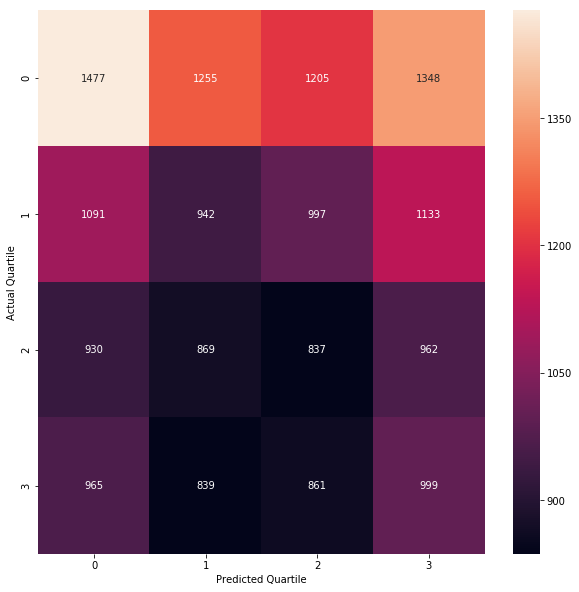

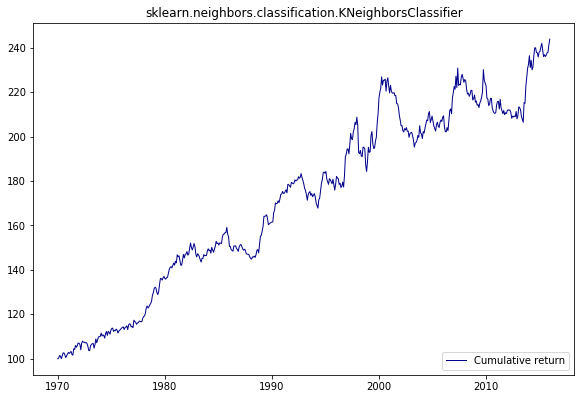

mySVC
<class 'function'>
create_model
17:14:36 Generate splits [140, 280, 419, 558, 697]
classify
17:14:36 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
best return gen params:  1
Food: long 166 times, short 0 times, total 166 times
Beer: long 2 times, short 0 times, total 2 times
Smoke: long 96 times, short 0 times, total 96 times
Games: long 0 times, short 0 times, total 0 times
Books: long 144 times, short 0 times, total 144 times
Hshld: long 106 times, short 0 times, total 106 times
Clths: long 0 times, short 0 times, total 0 times
Hlth: long 5 times, short 0 times, total 5 times
Chems: long 0 times, short 1 times, total 1 times
Txtls: long 1 times, short 0 times

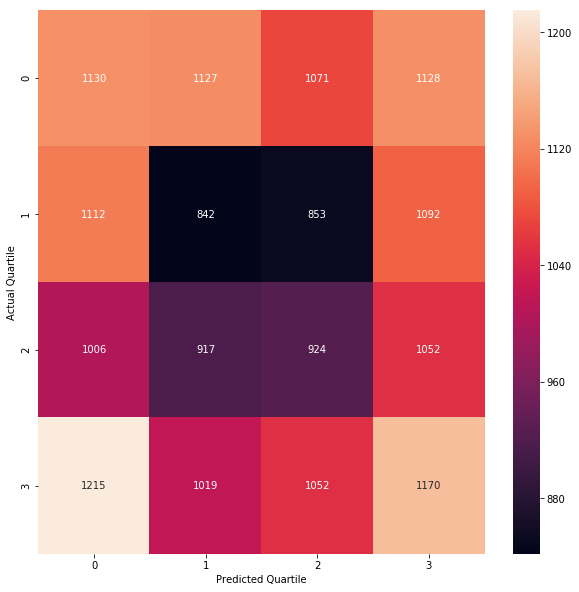

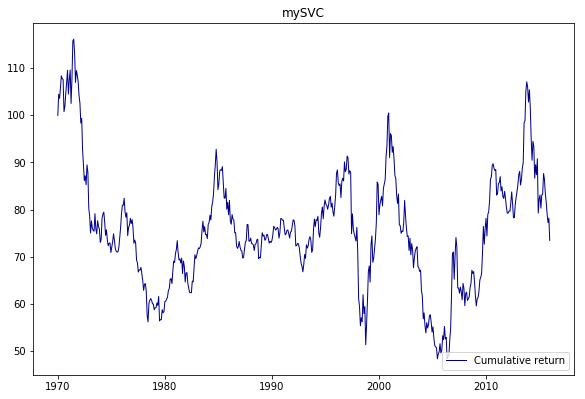

myVC.<locals>.create_model
<class 'function'>
create_model
17:14:50 Generate splits [140, 280, 419, 558, 697]
classify
17:14:50 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
best return gen params:  7
Food: long 183 times, short 114 times, total 297 times
Beer: long 110 times, short 85 times, total 195 times
Smoke: long 193 times, short 133 times, total 326 times
Games: long 187 times, short 131 times, total 318 times
Books: long 133 times, short 128 times, total 261 times
Hshld: long 177 times, short 125 times, total 302 times
Clths: long 149 times, short 148 times, total 297 times
Hlth: long 168 times, short 101 times, total 269 times
Chems: long 87 times, short 16

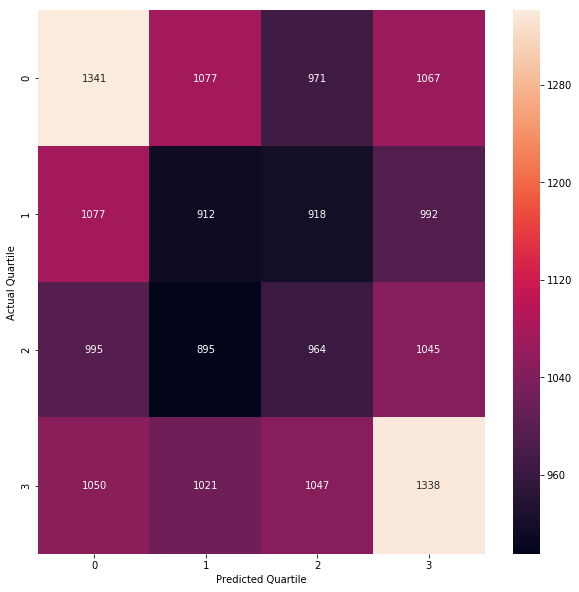

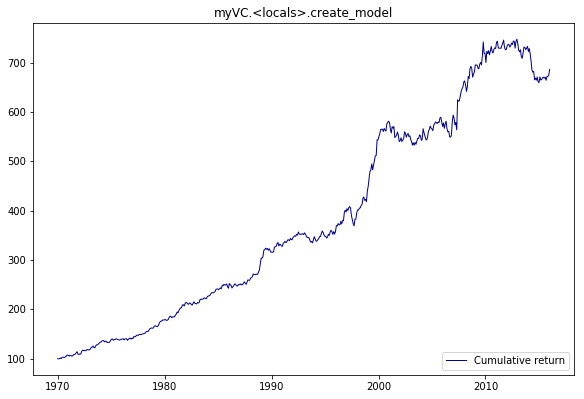

In [26]:
est_names = []
sharpes = []
directional_accuracies=[]
in_sample_accuracies = []
cv_vals = []
kendall_taus = []
vols = []
ann_returns = []

for estimator in estimators:
    estname = str(estimator)[10:-19] if str(type(estimator))=="<class 'function'>" else str(estimator)[8:-2]
    print(estname)    
    est_names.append(estname)
    print( type(estimator))
    if callable(estimator):
        # sklearn interface, create model for each column
        print('create_model')
        backtestmodel = BacktestModel(X, Y, 
                                      create_model=estimator, 
                                      coef_dict_param="all", 
                                      startindex=FIRST_TRAIN_MONTHS,
                                      fit_missing='mean',
                                      scaler = None,
                                      make_classes=make_four_classes)
    else:
        # keras interface, use model to fit/predict all 30 at once
        print('model')
        
        backtestmodel = BacktestModel(X, Y, 
                                      model=estimator, 
                                      coef_dict_param="all", 
                                      startindex=FIRST_TRAIN_MONTHS,
                                      fit_missing='mean',
                                      scaler = None,
                                      make_classes=make_four_classes)
        
    backtestmodel.walkforward_xval(n_splits=5, verbose=True) 
    _, best_params = backtestmodel.sharpe_cv(calc_returns_gen, range(1, 16), verbose=False)
    print("best return gen params: ", best_params)
    backtestmodel.gen_returns(calc_returns_gen(best_params), verbose=True)
    backtestmodel.report_returns(start_date=start_date_str, freq='M')
    sharpes.append(backtestmodel.sharpe)
    ann_returns.append(backtestmodel.mean_return)
    vols.append(backtestmodel.annualized_vol)
    cv_vals.append(best_params)
    
    try:
        backtestmodel.evaluate_quantiles(chart=True, verbose=True)
        directional_accuracies.append(backtestmodel.directional_accuracy)
        in_sample_accuracies.append(backtestmodel.insample_accuracy)
        kendall_taus.append(backtestmodel.kendalltau)
    except:
        directional_accuracies.append(np.nan)
        in_sample_accuracies.append(np.nan)
        kendall_taus.append(np.nan)
        
    mychart([backtestmodel.cumulative_return],['Cumulative return'], title=estname)

In [27]:
nice_names = ['Logistic Regression',
'Multilayer Perceptron',
'Gradient Boost',
'XGBClassifier',
'CatBoostClassifier',
'LGBMClassifier',
'AdaBoost',
'BaggingClassifier',
'DecisionTreeClassifier',
'RandomForestClassifier',
'ExtraTreeClassifier',
'ExtraTreesClassifier',
'Bernoulli Naive Bayes',
'Gaussian Naive Bayes',
'KNeighborsClassifier',
'Support Vector Machine',
'Sklearn Ensemble',
#'Keras Neural Network',
]

def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color

# nothing else seems to get the precision to display correctly 
in_sample_accuracies2 = ["%.3f" % z for z in in_sample_accuracies]
directional_accuracies2 = ["%.3f" % z for z in directional_accuracies]
kendall_taus2 = ["%.3f" % z for z in kendall_taus]
ann_returns2 = ["%.3f" % z for z in ann_returns]
vols2 = ["%.3f" % z for z in vols]
sharpes2 = ["%.3f" % z for z in sharpes]

z = pd.DataFrame(np.array([nice_names, in_sample_accuracies2, directional_accuracies2, kendall_taus2, ann_returns2, vols2, sharpes2]).T,
                 columns=['Name', 'In-Sample Acc', 'OOS Directional Acc', "Kendall's tau", 'Ann. Return', 'Vol', 'Sharpe'])
pd.set_option('float_format', '{:.2f}'.format)
pd.set_option('display.precision',2)
z

Name In-Sample Acc OOS Directional Acc Kendall's tau  \
0      Logistic Regression         0.412               0.377         0.036   
1    Multilayer Perceptron         0.822               0.374         0.018   
2           Gradient Boost         0.854               0.382         0.027   
3            XGBClassifier         0.281               0.386         0.007   
4       CatBoostClassifier         0.855               0.380         0.032   
5           LGBMClassifier         0.854               0.372         0.026   
6                 AdaBoost         0.466               0.360         0.023   
7        BaggingClassifier         0.841               0.367         0.013   
8   DecisionTreeClassifier         0.852               0.373         0.013   
9   RandomForestClassifier         0.846               0.373         0.021   
10     ExtraTreeClassifier         0.855               0.367         0.011   
11    ExtraTreesClassifier         0.855               0.370         0.029   
12   Bernoulli Naive Bayes         0.335               0.375         0.036   
13    Gaussian Naive Bayes         0.342               0.365         0.036   
14    KNeighborsClassifier         0.460               0.366         0.016   
15  Support Vector Machine         0.856               0.349        -0.001   
16        Sklearn Ensemble         0.854               0.381         0.047   

   Ann. Return    Vol Sharpe  
0        0.020  0.033  0.630  
1        0.010  0.034  0.297  
2        0.029  0.046  0.651  
3        0.010  0.042  0.267  
4        0.026  0.043  0.626  
5        0.022  0.040  0.578  
6        0.017  0.027  0.658  
7        0.015  0.038  0.414  
8        0.010  0.026  0.380  
9        0.022  0.043  0.531  
10       0.009  0.028  0.333  
11       0.035  0.047  0.758  
12       0.040  0.067  0.632  
13       0.033  0.040  0.828  
14       0.019  0.042  0.479  
15      -0.007  0.123  0.008  
16       0.042  0.051  0.863

In [28]:
with open('sklearn_table.html', 'w') as fo:
    z.sort_values(['Sharpe'], ascending=False).to_html(fo, float_format=lambda x: '%.3f' % x)

In [29]:
    
myscatter(directional_accuracies, sharpes, title="Sharpe vs. Directional Accuracy")
myscatter(kendall_taus, sharpes, title="Sharpe vs. Kendall's Tau")


17:16:32 Starting training
................................................................................
17:16:34 Still training step 80 of 576
................................................................................
17:16:35 Still training step 160 of 576
................................................................................
17:16:37 Still training step 240 of 576
................................................................................
17:16:39 Still training step 320 of 576
................................................................................
17:16:41 Still training step 400 of 576
................................................................................
17:16:43 Still training step 480 of 576
................................................................................
17:16:45 Still training step 560 of 576
................
best return gen params:  8
Food: long 180 times, short 192 times, total 372 times
Beer: long 95 times, short 1

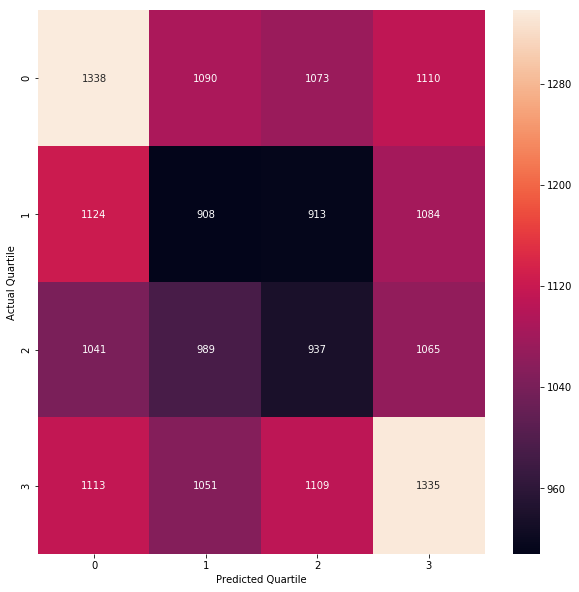

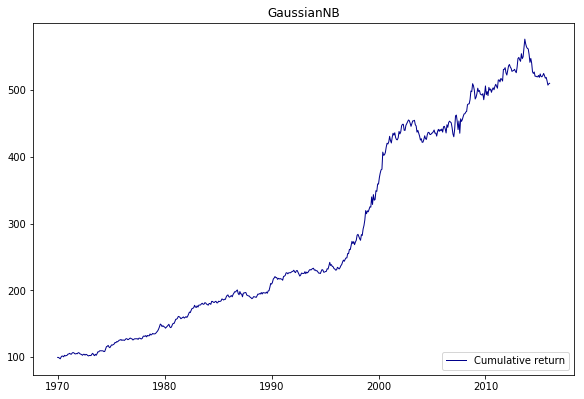

In [30]:
# full backtest - train each timestep
backtestmodel = BacktestModel(X, Y, 
                              create_model=sklearn.naive_bayes.GaussianNB, 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler = None,
                              make_classes=make_four_classes)
backtestmodel.gen_predictions() 
_, best_params = backtestmodel.sharpe_cv(calc_returns_gen, range(1, 16))
print("best return gen params: ", best_params)
backtestmodel.gen_returns(calc_returns_gen(best_params), verbose=True)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
#backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
mychart([backtestmodel.cumulative_return],['Cumulative return'], title='GaussianNB')


17:16:47 Starting training
................................................................................
17:33:17 Still training step 80 of 576
................................................................................
17:55:47 Still training step 160 of 576
................................................................................
18:24:31 Still training step 240 of 576
................................................................................
19:00:49 Still training step 320 of 576
................................................................................
19:45:23 Still training step 400 of 576
................................................................................
20:39:10 Still training step 480 of 576
................................................................................
21:42:45 Still training step 560 of 576
................
best return gen params:  12
Food: long 264 times, short 212 times, total 476 times
Beer: long 206 times, short

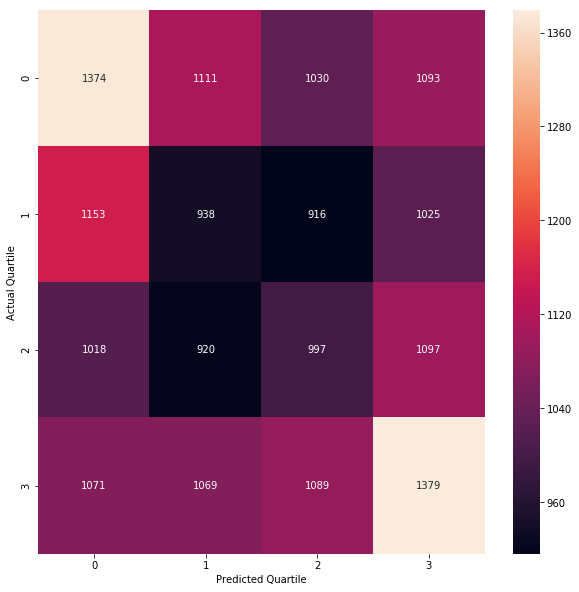

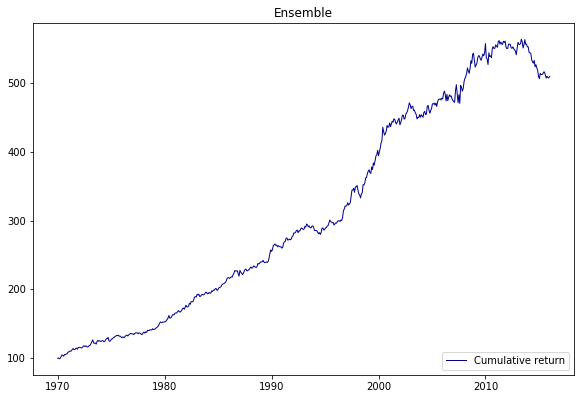

In [31]:
# full backtest - train each timestep
backtestmodel = BacktestModel(X, Y, 
                              create_model=myVC(), 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler = None,
                              make_classes=make_four_classes)
backtestmodel.gen_predictions() 
_, best_params = backtestmodel.sharpe_cv(calc_returns_gen, range(1, 16))
print("best return gen params: ", best_params)
backtestmodel.gen_returns(calc_returns_gen(best_params), verbose=True)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
#backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
mychart([backtestmodel.cumulative_return],['Cumulative return'], title='Ensemble')


### Perform cross-validation on Keras neural networks to select best architecture

In [26]:
# weighted loss calculation to overweight missing by more than 1 quartile
weights = np.matrix("""
1, 0, 0, 0; 
0, 1, 0, 0; 
0, 0, 1, 0; 
0, 0, 0, 1""")

weights = np.matrix("""
0.5, 1.5, 2.5, 3.5; 
1.5, 0.5, 1.5, 2.5; 
2.5, 1.5, 0.5, 1.5; 
3.5, 2.5, 1.5, 0.5""")

actual = np.matrix("1.0, 0.0, 0.0, 0.0")
predicted = np.matrix("0.4, 0.3, 0.2, 0.1")
print(actual.dot(weights))
log_loss = -np.log(actual.dot(predicted.T))
print(log_loss)
raw_loss = - np.log(np.multiply(actual, predicted) + np.multiply(1 - actual, 1 - predicted))
print(raw_loss)
print(np.multiply(raw_loss, actual.dot(weights) ))
print(np.sum(np.multiply(raw_loss, actual.dot(weights) )))

weighted_loss = actual.dot(weights).dot(raw_loss.T)
weighted_loss

[[0.5 1.5 2.5 3.5]]
[[0.916]]
[[0.916 0.357 0.223 0.105]]
[[0.458 0.535 0.558 0.369]]
1.9197784649330925


matrix([[1.92]])

In [27]:
# custom loss function
# apply weights on categorical cross-entropy to penalize wronger answers by more
weights = np.matrix("""
0.5, 1.5, 2.5, 3.5; 
1.5, 0.5, 1.5, 2.5; 
2.5, 1.5, 0.5, 1.5; 
3.5, 2.5, 1.5, 0.5""")

weights = np.matrix("""
1, 0, 0, 0; 
0, 1, 0, 0; 
0, 0, 1, 0; 
0, 0, 0, 1""")

weights = tf.constant(np.array(weights),dtype=tf.float32)

def my_categorical_cross_entropy(target, output, from_logits=False, axis=-1):
    """Categorical crossentropy between an output tensor and a target tensor.
    # Arguments
        target: A tensor of the same shape as `output`.
        output: A tensor resulting from a softmax
            (unless `from_logits` is True, in which
            case `output` is expected to be the logits).
        from_logits: Boolean, whether `output` is the
            result of a softmax, or is a tensor of logits.
        axis: Int specifying the channels axis. `axis=-1`
            corresponds to data format `channels_last`,
            and `axis=1` corresponds to data format
            `channels_first`.
    # Returns
        Output tensor.
    # Raises
        ValueError: if `axis` is neither -1 nor one of
            the axes of `output`.
    """
    output /= tf.reduce_sum(output, axis, True)
    # manual computation of crossentropy
    _epsilon = tf.convert_to_tensor(K.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
    raw_loss = - tf.log(target * output + (1 - target) * (1 - output))
    weight_array = tf.matmul(target, weights)
    weighted_loss = weight_array * raw_loss
    
    return tf.reduce_sum(weighted_loss, axis)

actual = tf.constant(np.array(np.matrix("1.0, 0.0, 0.0, 0.0")),dtype=tf.float32)
predicted = tf.constant(np.array(np.matrix("0.4, 0.3, 0.2, 0.1")),dtype=tf.float32)
test_my_categorical_cross_entropy = my_categorical_cross_entropy(actual, predicted)

with tf.Session() as mysess:
    print(mysess.run(test_my_categorical_cross_entropy))

[0.916]


In [28]:
EPOCHS=2000
INPUT_DIM=X.shape[1]
OUTPUT_DIM=30
BATCH_SIZE=64
NCLASSES=4

class KerasBacktestModel(object):

    def __init__(self, 
                 n_hidden_layers = 2,
                 hidden_layer_size = 8,
                 reg_penalty = 0.001,
                 epochs=EPOCHS,
                 loss_function = "categorical_crossentropy",
                 verbose=True):
        
        self.epochs=epochs
        
        main_input = Input(shape=(INPUT_DIM,),
                           dtype='float32', 
                           name='main_input')
        lastlayer=main_input
        
        for i in range(n_hidden_layers):
            if verbose:
                print("layer %d size %d, reg_penalty %.8f" % (i + 1, 
                                                              hidden_layer_size, 
                                                              reg_penalty, 
                                                             ))
            lastlayer = Dense(units = hidden_layer_size, 
                              activation = 'relu',
                              kernel_initializer = keras.initializers.glorot_uniform(),
                              kernel_regularizer=keras.regularizers.l1_l2(reg_penalty),
                              name = "Dense%02d" % i)(lastlayer)
            
        outputs = []
        for i in range(OUTPUT_DIM):
            outputs.append(Dense(NCLASSES, activation='softmax', name = "Output%02d" % i)(lastlayer))
            
        self.model = Model(inputs=[main_input], outputs=outputs)
        if verbose:
            print(self.model.summary())
            
        self.model.compile(loss=loss_function, optimizer='adam', metrics=['accuracy'])
        
    def fit(self, X, Y, epochs=None, verbose=False):
        # convert Y to list of ys
        Y_list = [keras.utils.to_categorical(Y[:,i], num_classes=NCLASSES) for i in range(OUTPUT_DIM)]

        if epochs:
            self.epochs = epochs

        retval = self.model.fit(X,
                                Y_list,
                                batch_size=BATCH_SIZE,
                                epochs=self.epochs,
                                verbose=False)
        self.history = retval.history
        self.last_loss_array = self.history['loss']
        self.last_loss = self.history['loss'][-1] # includes regularization loss
        return retval
    
    
    def predict_proba(self, X, verbose=False):
        y_list = self.model.predict(X)
        #print("List of %d arrays of shape %s" % (len(y_list), str(y_list[0].shape)))
        return [np.vstack([y_list[j][:,i] for j in range(OUTPUT_DIM)]).T for i in range(NCLASSES)]
    
    def predict(self, X, verbose=False):
        Y_pred = self.predict_proba(X)
        ys = []
        for col in range(OUTPUT_DIM):
            ys.append(np.argmax(np.vstack([Y_pred[cl][:,col] for cl in range(NCLASSES)]).T, axis=1))
        retarray = np.vstack(ys).T
        #print(retarray.shape)
        return(retarray)    
    
    def save(self, modelname):
        self.model.save("%s.h5" % modelname)
        self.model.save_weights("%s_weights.h5" % modelname)

In [29]:
# Wrap our Keras model in sklearn interface for VotingClassifier. 
# Not used here because too slow, sklearn interface models one response at a time instead of all 30 
# but recorded for posterity

# KerasClassifier wraps a Keras model with an sklearn interface
# But it returns wrong shape for VotingClassifier ensemble
# 2D shape (nrows,1) instead of 1D (nrows) 
# Subclass KerasClassifier and override predict  

def modelFactory(n_hidden_layers = 2,
                 hidden_layer_size = 8,
                 reg_penalty = 0.001,
                           epochs=EPOCHS,
                           verbose=True):
    def create_fn():
        return myKerasClassifier(n_hidden_layers,
                                 hidden_layer_size,
                                 reg_penalty,
                                 epochs,
                                 verbose)
    return create_fn

class monkeyKerasClassifier(KerasClassifier):
    """subclass KerasClassifier and override predict to work with VotingClassifier"""
    def __init__(self, *args, **kwargs):
        super(KerasClassifier, self).__init__(*args, **kwargs)        
        
    def predict(self, x, **kwargs):
        pred = KerasClassifier.predict(self, x, **kwargs)
        return pred[:, 0]
        
def kerasClassifierFactory(n_hidden_layers = 2,
                           hidden_layer_size = 8,
                           reg_penalty = 0.001,
                           epochs=EPOCHS,
                           verbose=True):
    def create_fn():
        return monkeyKerasClassifier(build_fn=modelFactory(n_hidden_layers,
                                                     hidden_layer_size,
                                                     reg_penalty,
                                                     epochs,
                                                     verbose), 
                               epochs=EPOCHS, 
                               batch_size=100, 
                               verbose=0)
    return create_fn

10:08:21 Running 18 experiments
10:08:21 Running experiment 1 of 18
(1, 4, 0.0)
layer 1 size 4, reg_penalty 0.00000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 4)            200         main_input[0][0]                 
__________________________________________________________________________________________________
Output00 (Dense)                (None, 4)            20          Dense00[0][0]                    
__________________________________________________________________________________________________
Output01 (Dense)                (None, 4)            20          Dense00[0][0]           

Avg rank correlation (Kendall's tau): 0.0095 (Expected: 0)
4-quartile accuracy: 0.2572 (Expected: 0.25)
Long/short/flat accuracy: 0.3694 (Expected: 0.375)


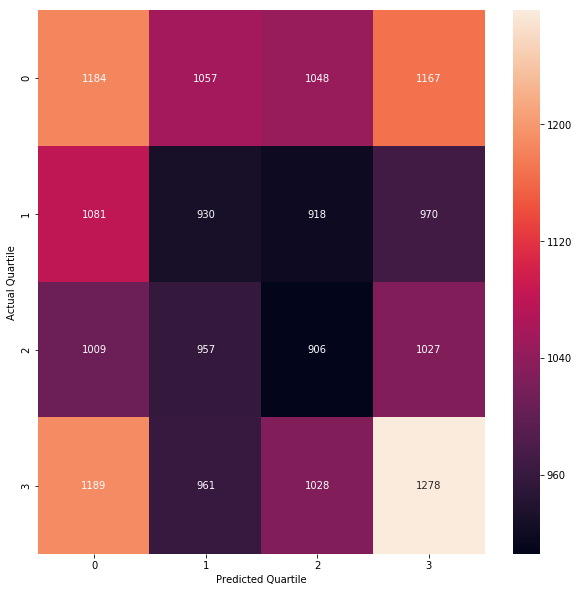

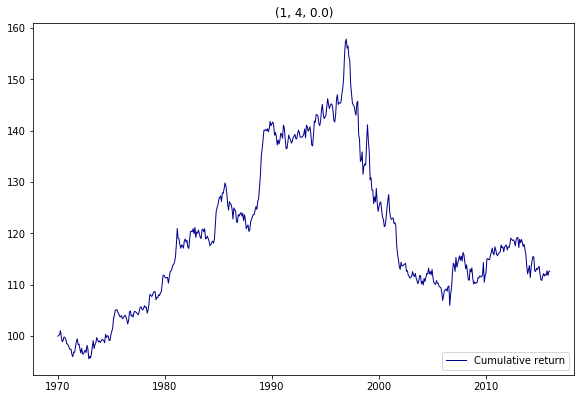

---
11:40:30 Running experiment 2 of 18
(1, 4, 0.1)
layer 1 size 4, reg_penalty 0.10000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 4)            200         main_input[0][0]                 
__________________________________________________________________________________________________
Output00 (Dense)                (None, 4)            20          Dense00[0][0]                    
__________________________________________________________________________________________________
Output01 (Dense)                (None, 4)            20          Dense00[0][0]                    
__________________

Avg rank correlation (Kendall's tau): 0.0193 (Expected: 0)
4-quartile accuracy: 0.2616 (Expected: 0.25)
Long/short/flat accuracy: 0.3657 (Expected: 0.375)


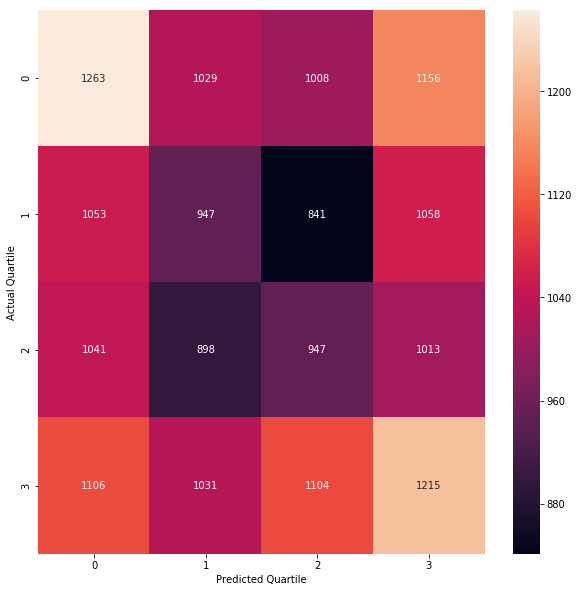

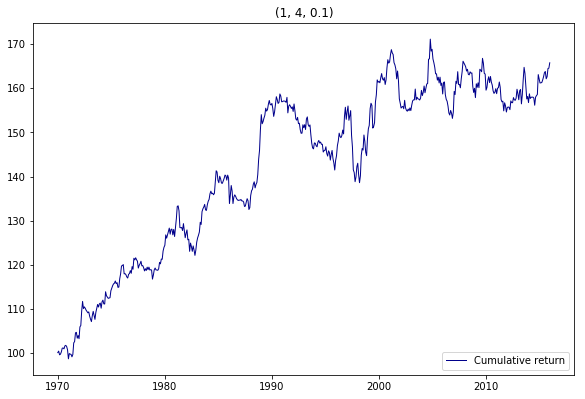

---
13:12:44 Running experiment 3 of 18
(1, 8, 0.0)
layer 1 size 8, reg_penalty 0.00000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 8)            400         main_input[0][0]                 
__________________________________________________________________________________________________
Output00 (Dense)                (None, 4)            36          Dense00[0][0]                    
__________________________________________________________________________________________________
Output01 (Dense)                (None, 4)            36          Dense00[0][0]                    
__________________

Avg rank correlation (Kendall's tau): 0.0154 (Expected: 0)
4-quartile accuracy: 0.2683 (Expected: 0.25)
Long/short/flat accuracy: 0.3781 (Expected: 0.375)


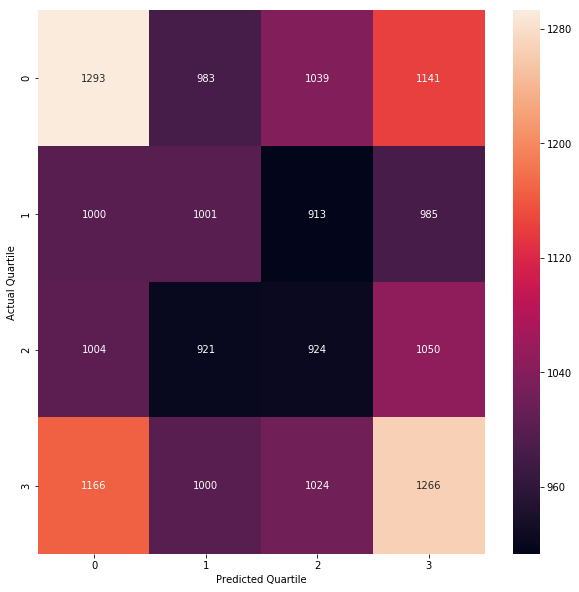

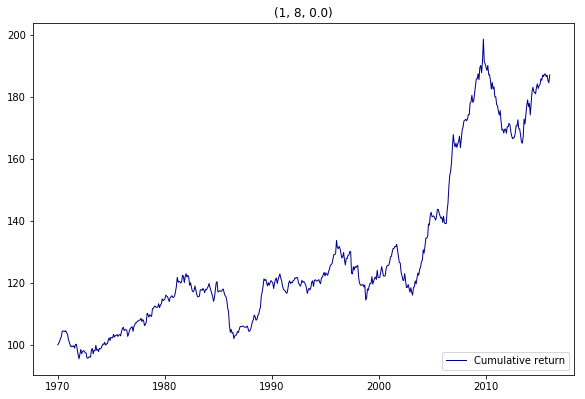

---
14:45:03 Running experiment 4 of 18
(1, 8, 0.1)
layer 1 size 8, reg_penalty 0.10000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 8)            400         main_input[0][0]                 
__________________________________________________________________________________________________
Output00 (Dense)                (None, 4)            36          Dense00[0][0]                    
__________________________________________________________________________________________________
Output01 (Dense)                (None, 4)            36          Dense00[0][0]                    
__________________

Avg rank correlation (Kendall's tau): 0.0346 (Expected: 0)
4-quartile accuracy: 0.2678 (Expected: 0.25)
Long/short/flat accuracy: 0.3759 (Expected: 0.375)


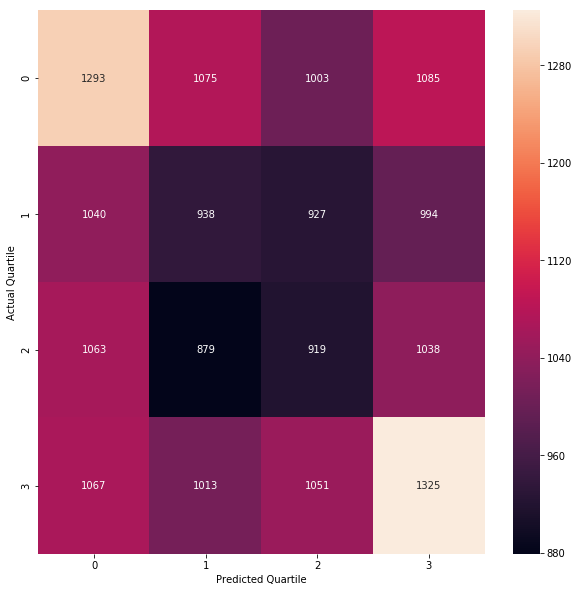

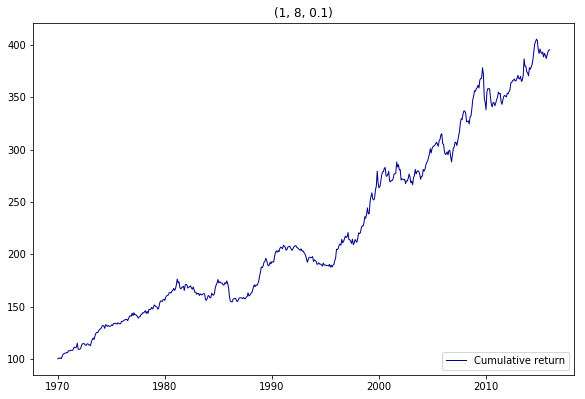

---
16:17:27 Running experiment 5 of 18
(1, 16, 0.0)
layer 1 size 16, reg_penalty 0.00000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 16)           800         main_input[0][0]                 
__________________________________________________________________________________________________
Output00 (Dense)                (None, 4)            68          Dense00[0][0]                    
__________________________________________________________________________________________________
Output01 (Dense)                (None, 4)            68          Dense00[0][0]                    
________________

Avg rank correlation (Kendall's tau): 0.0145 (Expected: 0)
4-quartile accuracy: 0.2636 (Expected: 0.25)
Long/short/flat accuracy: 0.3745 (Expected: 0.375)


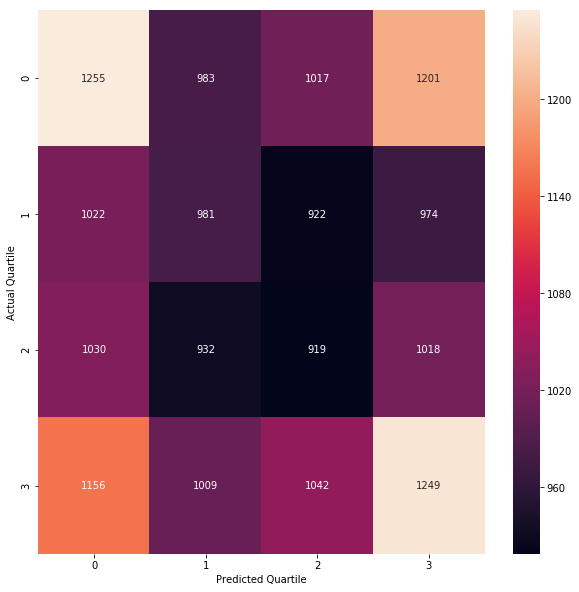

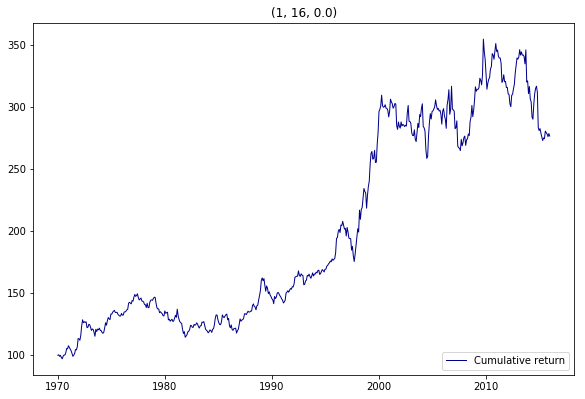

---
17:49:57 Running experiment 6 of 18
(1, 16, 0.1)
layer 1 size 16, reg_penalty 0.10000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 16)           800         main_input[0][0]                 
__________________________________________________________________________________________________
Output00 (Dense)                (None, 4)            68          Dense00[0][0]                    
__________________________________________________________________________________________________
Output01 (Dense)                (None, 4)            68          Dense00[0][0]                    
________________

Avg rank correlation (Kendall's tau): 0.0143 (Expected: 0)
4-quartile accuracy: 0.2582 (Expected: 0.25)
Long/short/flat accuracy: 0.3696 (Expected: 0.375)


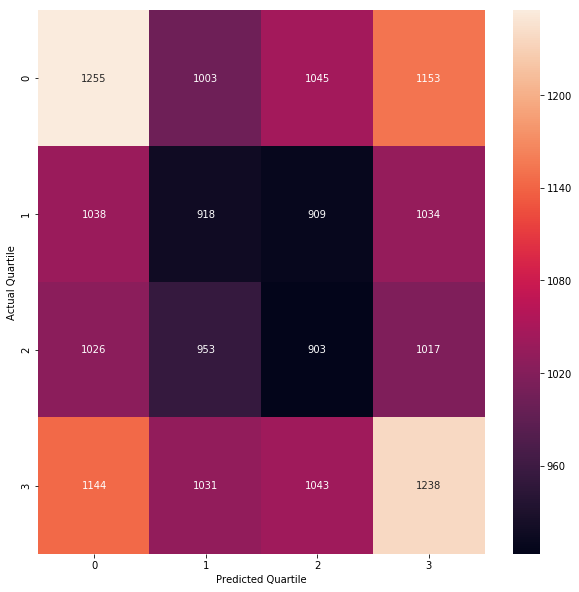

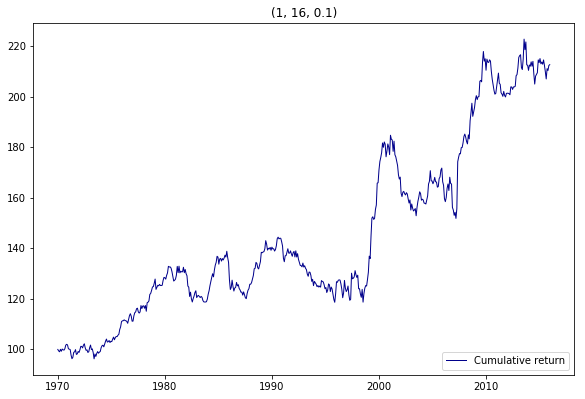

---
19:22:17 Running experiment 7 of 18
(2, 4, 0.0)
layer 1 size 4, reg_penalty 0.00000000
layer 2 size 4, reg_penalty 0.00000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 4)            200         main_input[0][0]                 
__________________________________________________________________________________________________
Dense01 (Dense)                 (None, 4)            20          Dense00[0][0]                    
__________________________________________________________________________________________________
Output00 (Dense)                (None, 4)            20          Dense01[0][0]

Avg rank correlation (Kendall's tau): 0.0175 (Expected: 0)
4-quartile accuracy: 0.2594 (Expected: 0.25)
Long/short/flat accuracy: 0.3695 (Expected: 0.375)


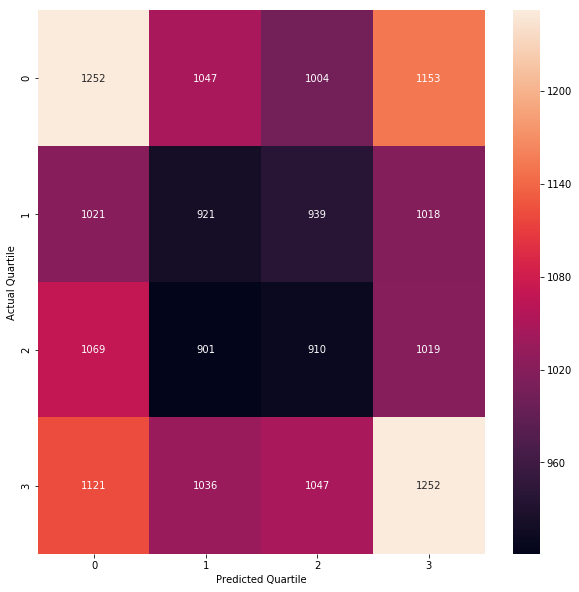

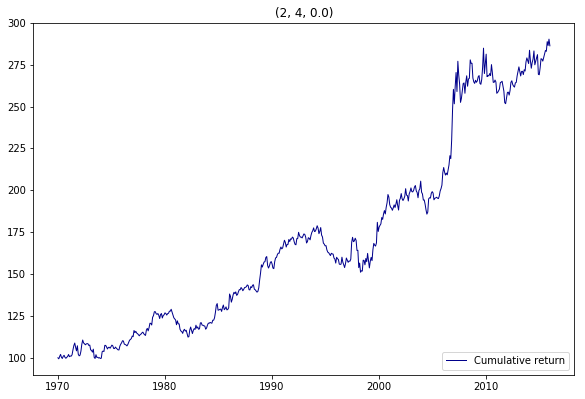

---
20:55:21 Running experiment 8 of 18
(2, 4, 0.1)
layer 1 size 4, reg_penalty 0.10000000
layer 2 size 4, reg_penalty 0.10000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 4)            200         main_input[0][0]                 
__________________________________________________________________________________________________
Dense01 (Dense)                 (None, 4)            20          Dense00[0][0]                    
__________________________________________________________________________________________________
Output00 (Dense)                (None, 4)            20          Dense01[0][0]

Avg rank correlation (Kendall's tau): 0.0220 (Expected: 0)
4-quartile accuracy: 0.2615 (Expected: 0.25)
Long/short/flat accuracy: 0.3731 (Expected: 0.375)


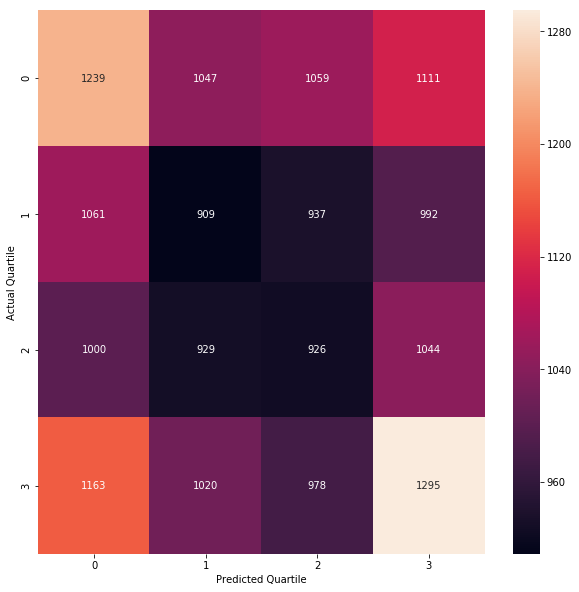

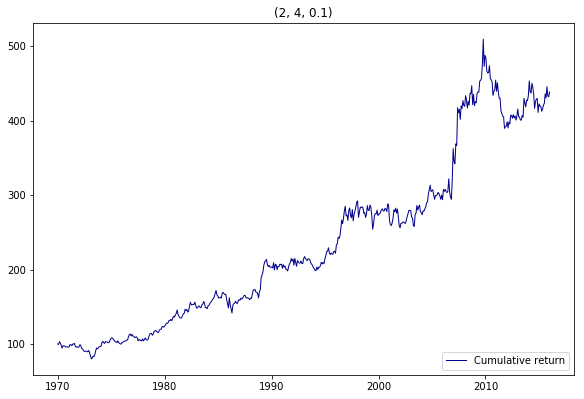

---
22:28:23 Running experiment 9 of 18
(2, 8, 0.0)
layer 1 size 8, reg_penalty 0.00000000
layer 2 size 8, reg_penalty 0.00000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 8)            400         main_input[0][0]                 
__________________________________________________________________________________________________
Dense01 (Dense)                 (None, 8)            72          Dense00[0][0]                    
__________________________________________________________________________________________________
Output00 (Dense)                (None, 4)            36          Dense01[0][0]

Avg rank correlation (Kendall's tau): 0.0075 (Expected: 0)
4-quartile accuracy: 0.2513 (Expected: 0.25)
Long/short/flat accuracy: 0.3612 (Expected: 0.375)


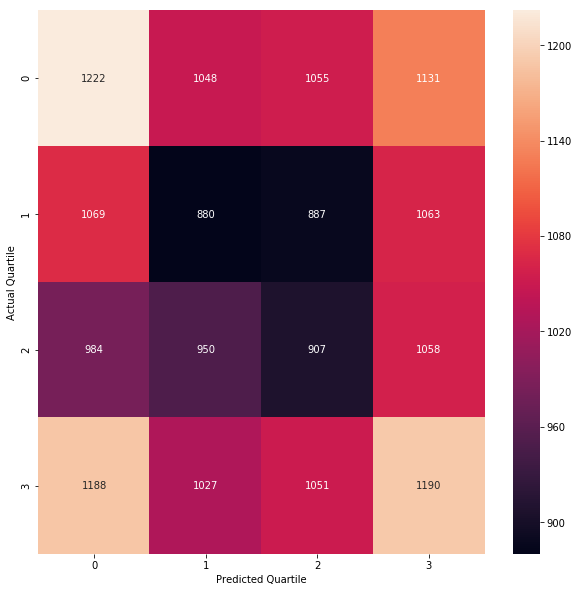

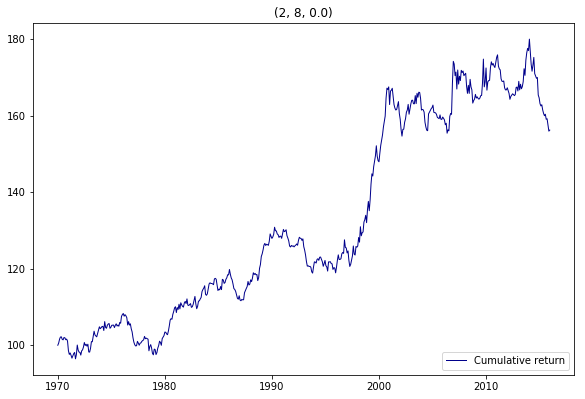

---
00:02:17 Running experiment 10 of 18
(2, 8, 0.1)
layer 1 size 8, reg_penalty 0.10000000
layer 2 size 8, reg_penalty 0.10000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 8)            400         main_input[0][0]                 
__________________________________________________________________________________________________
Dense01 (Dense)                 (None, 8)            72          Dense00[0][0]                    
__________________________________________________________________________________________________
Output00 (Dense)                (None, 4)            36          Dense01[0][0

Avg rank correlation (Kendall's tau): 0.0149 (Expected: 0)
4-quartile accuracy: 0.2599 (Expected: 0.25)
Long/short/flat accuracy: 0.3680 (Expected: 0.375)


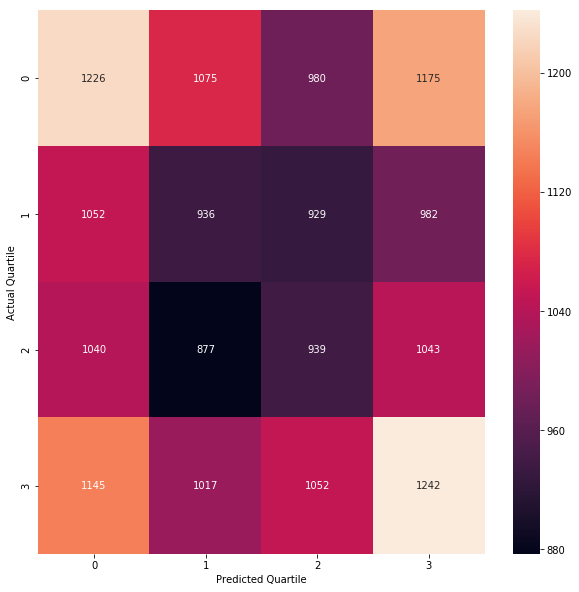

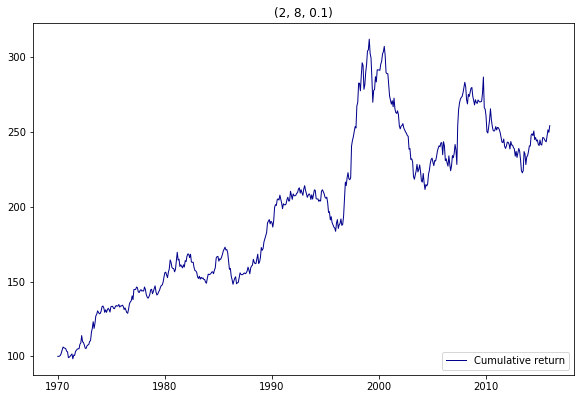

---
01:35:31 Running experiment 11 of 18
(2, 16, 0.0)
layer 1 size 16, reg_penalty 0.00000000
layer 2 size 16, reg_penalty 0.00000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 16)           800         main_input[0][0]                 
__________________________________________________________________________________________________
Dense01 (Dense)                 (None, 16)           272         Dense00[0][0]                    
__________________________________________________________________________________________________
Output00 (Dense)                (None, 4)            68          Dense01[0

Avg rank correlation (Kendall's tau): 0.0184 (Expected: 0)
4-quartile accuracy: 0.2576 (Expected: 0.25)
Long/short/flat accuracy: 0.3631 (Expected: 0.375)


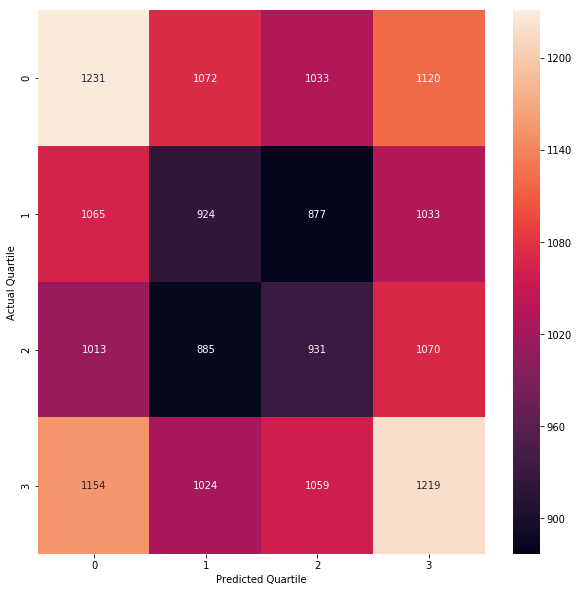

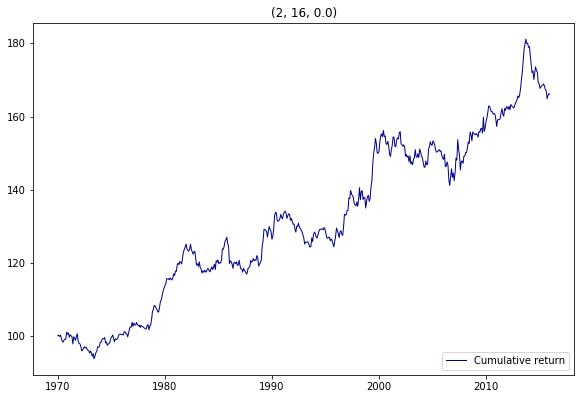

---
03:08:29 Running experiment 12 of 18
(2, 16, 0.1)
layer 1 size 16, reg_penalty 0.10000000
layer 2 size 16, reg_penalty 0.10000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 16)           800         main_input[0][0]                 
__________________________________________________________________________________________________
Dense01 (Dense)                 (None, 16)           272         Dense00[0][0]                    
__________________________________________________________________________________________________
Output00 (Dense)                (None, 4)            68          Dense01[0

Avg rank correlation (Kendall's tau): 0.0155 (Expected: 0)
4-quartile accuracy: 0.2660 (Expected: 0.25)
Long/short/flat accuracy: 0.3776 (Expected: 0.375)


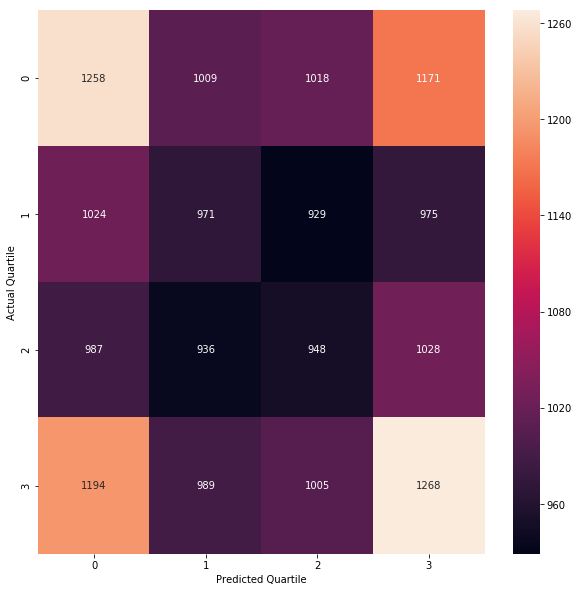

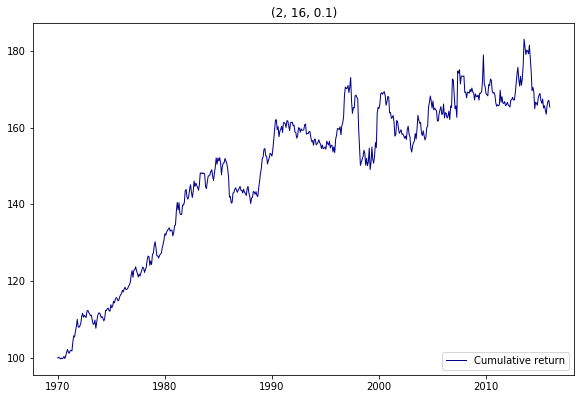

---
04:41:49 Running experiment 13 of 18
(3, 4, 0.0)
layer 1 size 4, reg_penalty 0.00000000
layer 2 size 4, reg_penalty 0.00000000
layer 3 size 4, reg_penalty 0.00000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 4)            200         main_input[0][0]                 
__________________________________________________________________________________________________
Dense01 (Dense)                 (None, 4)            20          Dense00[0][0]                    
__________________________________________________________________________________________________
Dense02 (Dense)                 (None,

Avg rank correlation (Kendall's tau): 0.0137 (Expected: 0)
4-quartile accuracy: 0.2552 (Expected: 0.25)
Long/short/flat accuracy: 0.3604 (Expected: 0.375)


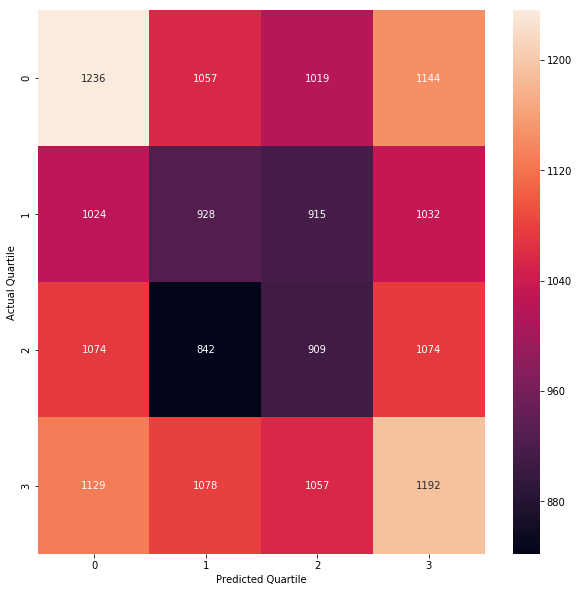

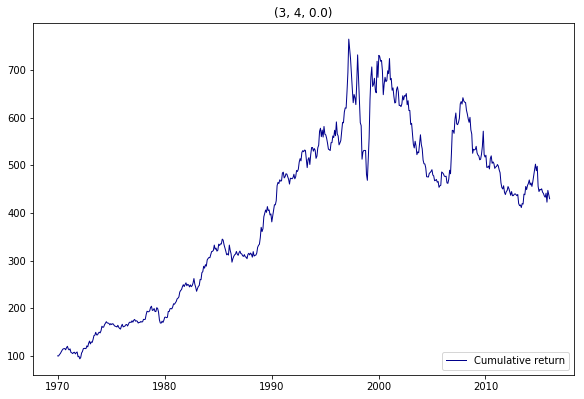

---
06:15:30 Running experiment 14 of 18
(3, 4, 0.1)
layer 1 size 4, reg_penalty 0.10000000
layer 2 size 4, reg_penalty 0.10000000
layer 3 size 4, reg_penalty 0.10000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 4)            200         main_input[0][0]                 
__________________________________________________________________________________________________
Dense01 (Dense)                 (None, 4)            20          Dense00[0][0]                    
__________________________________________________________________________________________________
Dense02 (Dense)                 (None,

Avg rank correlation (Kendall's tau): 0.0212 (Expected: 0)
4-quartile accuracy: 0.2552 (Expected: 0.25)
Long/short/flat accuracy: 0.3638 (Expected: 0.375)


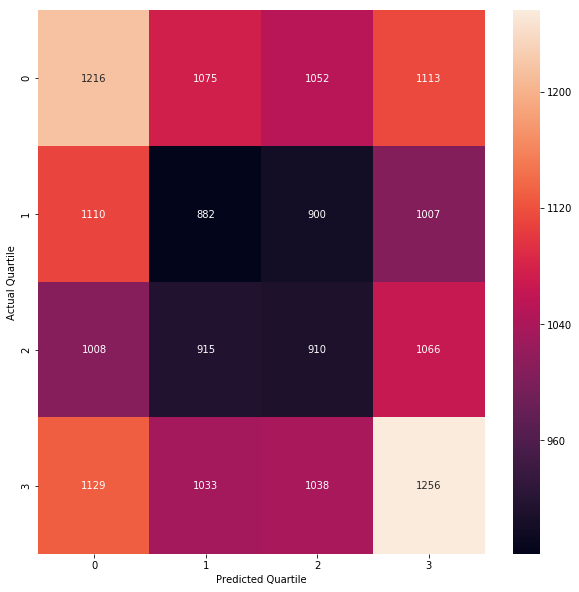

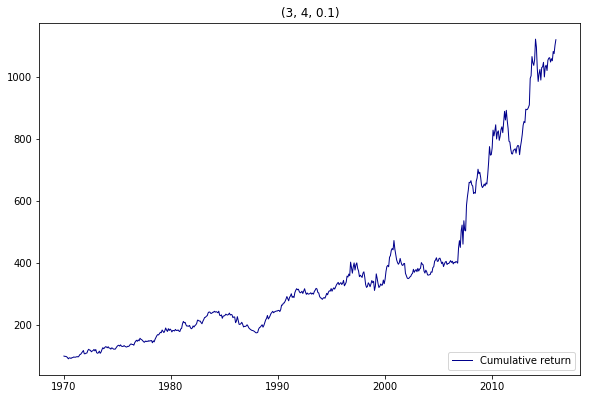

---
07:49:30 Running experiment 15 of 18
(3, 8, 0.0)
layer 1 size 8, reg_penalty 0.00000000
layer 2 size 8, reg_penalty 0.00000000
layer 3 size 8, reg_penalty 0.00000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 8)            400         main_input[0][0]                 
__________________________________________________________________________________________________
Dense01 (Dense)                 (None, 8)            72          Dense00[0][0]                    
__________________________________________________________________________________________________
Dense02 (Dense)                 (None,

Avg rank correlation (Kendall's tau): 0.0044 (Expected: 0)
4-quartile accuracy: 0.2557 (Expected: 0.25)
Long/short/flat accuracy: 0.3656 (Expected: 0.375)


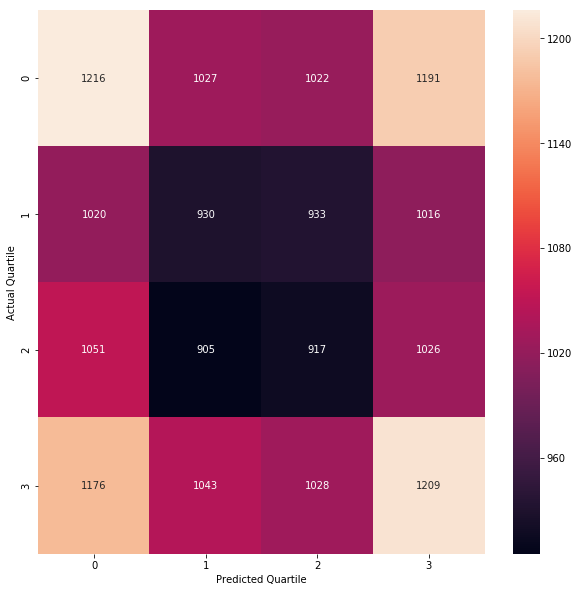

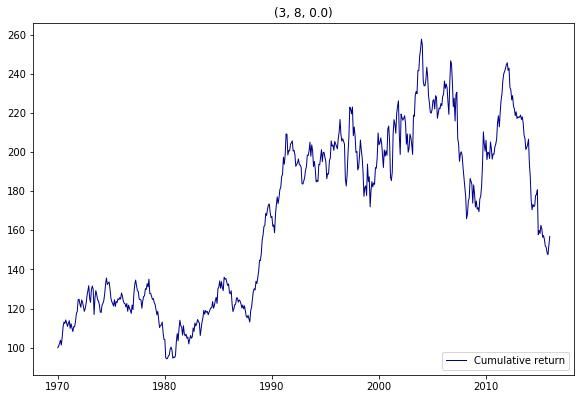

---
09:24:01 Running experiment 16 of 18
(3, 8, 0.1)
layer 1 size 8, reg_penalty 0.10000000
layer 2 size 8, reg_penalty 0.10000000
layer 3 size 8, reg_penalty 0.10000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 8)            400         main_input[0][0]                 
__________________________________________________________________________________________________
Dense01 (Dense)                 (None, 8)            72          Dense00[0][0]                    
__________________________________________________________________________________________________
Dense02 (Dense)                 (None,

Avg rank correlation (Kendall's tau): 0.0189 (Expected: 0)
4-quartile accuracy: 0.2597 (Expected: 0.25)
Long/short/flat accuracy: 0.3679 (Expected: 0.375)


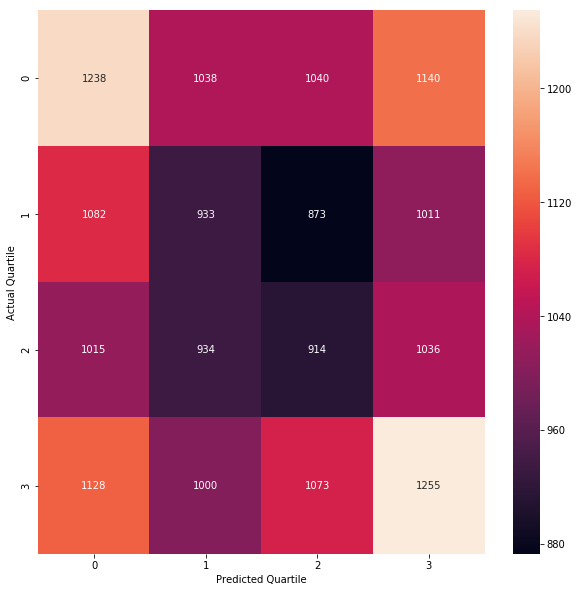

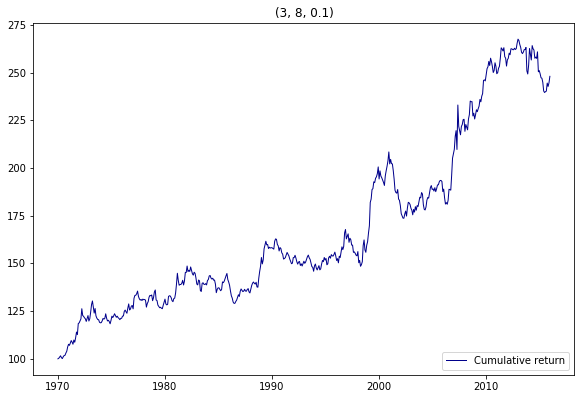

---
10:58:25 Running experiment 17 of 18
(3, 16, 0.0)
layer 1 size 16, reg_penalty 0.00000000
layer 2 size 16, reg_penalty 0.00000000
layer 3 size 16, reg_penalty 0.00000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 16)           800         main_input[0][0]                 
__________________________________________________________________________________________________
Dense01 (Dense)                 (None, 16)           272         Dense00[0][0]                    
__________________________________________________________________________________________________
Dense02 (Dense)                 (N

Avg rank correlation (Kendall's tau): 0.0085 (Expected: 0)
4-quartile accuracy: 0.2600 (Expected: 0.25)
Long/short/flat accuracy: 0.3670 (Expected: 0.375)


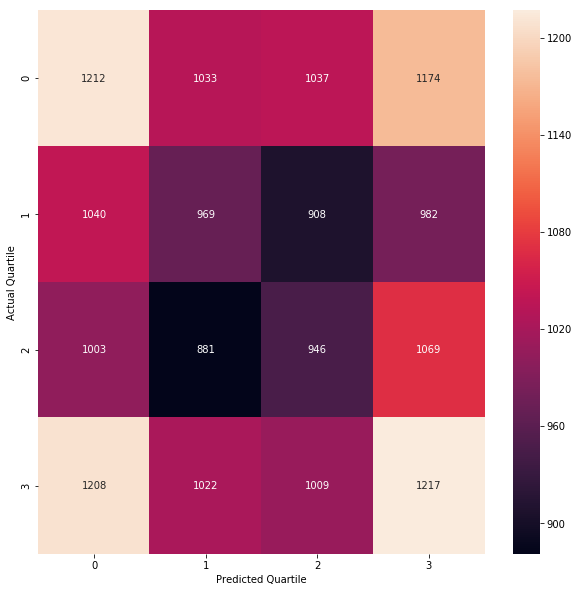

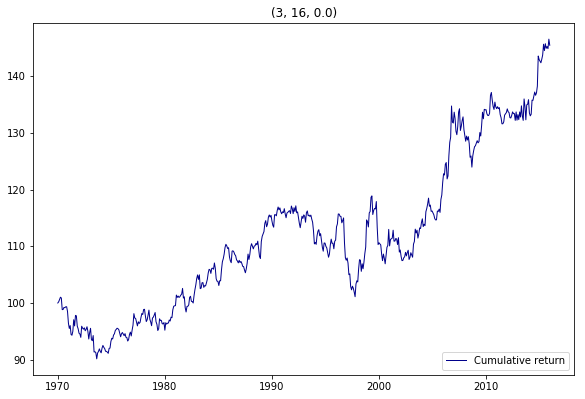

---
12:32:53 Running experiment 18 of 18
(3, 16, 0.1)
layer 1 size 16, reg_penalty 0.10000000
layer 2 size 16, reg_penalty 0.10000000
layer 3 size 16, reg_penalty 0.10000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 16)           800         main_input[0][0]                 
__________________________________________________________________________________________________
Dense01 (Dense)                 (None, 16)           272         Dense00[0][0]                    
__________________________________________________________________________________________________
Dense02 (Dense)                 (N

Avg rank correlation (Kendall's tau): 0.0352 (Expected: 0)
4-quartile accuracy: 0.2643 (Expected: 0.25)
Long/short/flat accuracy: 0.3761 (Expected: 0.375)


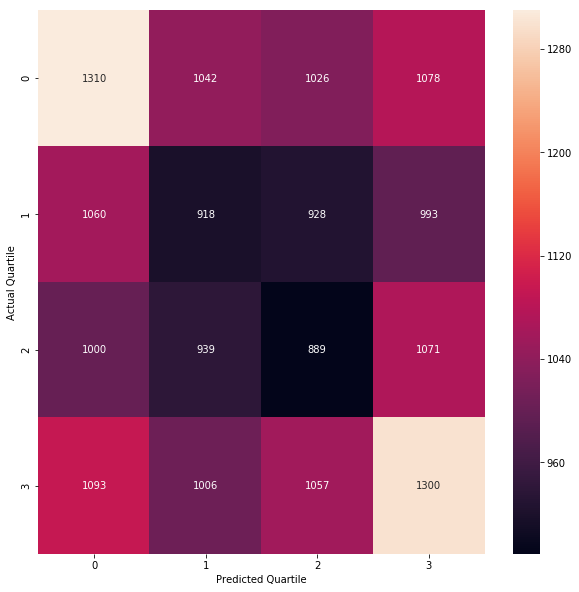

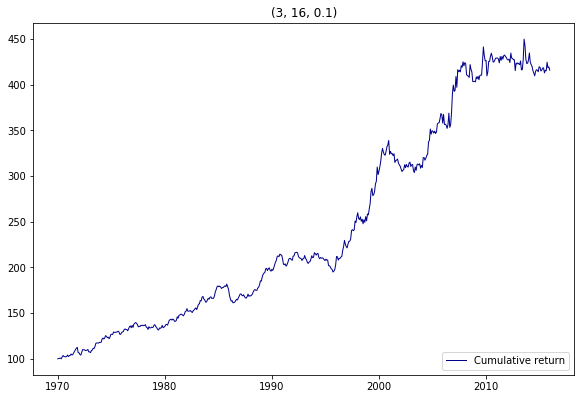

---


In [31]:
# default loss function
n_hiddens = [1, 2, 3]
layer_sizes = [4, 8, 16]
reg_penalties = [0.0, 0.1]
hyperparameter_combos = list(product(n_hiddens, layer_sizes, reg_penalties))

keys = []

print("%s Running %d experiments" % (time.strftime("%H:%M:%S"), len(hyperparameter_combos)))
for counter, param_list in enumerate(hyperparameter_combos):
    nlayers, layer_size, reg_penalty = param_list
    print("%s Running experiment %d of %d" % (time.strftime("%H:%M:%S"), counter+1, len(hyperparameter_combos)))
    key = (nlayers, layer_size, reg_penalty)
    print(key)
    keys.append(key)
    backtestmodel = BacktestModel(X, Y, 
                                  model=KerasBacktestModel(n_hidden_layers = nlayers,
                                                           hidden_layer_size = layer_size,
                                                           reg_penalty = reg_penalty,
                                                          ), 
                                  coef_dict_param="all",
                                  startindex=FIRST_TRAIN_MONTHS,
                                  fit_missing='mean',
                                  scaler = None,
                                  make_classes=make_four_classes)
    backtestmodel.walkforward_xval(n_splits=5, verbose=True) 
    _, best_params = backtestmodel.sharpe_cv(calc_returns_gen, range(1, 16), verbose=False)
    print("best return gen params: ", best_params)
    backtestmodel.gen_returns(calc_returns_gen(best_params), verbose=True)
    backtestmodel.report_returns(start_date=start_date_str, freq='M')
    backtestmodel.evaluate_quantiles(chart=True, verbose=True)
    mychart([backtestmodel.cumulative_return],["Cumulative return"], title=str(param_list))

    print("---")
    


14:40:58 Running 18 experiments
14:40:58 Running experiment 1 of 18
(1, 8, 0.0)
layer 1 size 8, reg_penalty 0.00000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 8)            400         main_input[0][0]                 
__________________________________________________________________________________________________
Output00 (Dense)                (None, 4)            36          Dense00[0][0]                    
__________________________________________________________________________________________________
Output01 (Dense)                (None, 4)            36          Dense00[0][0]           

Avg rank correlation (Kendall's tau): 0.0166 (Expected: 0)
4-quartile accuracy: 0.2597 (Expected: 0.25)
Long/short/flat accuracy: 0.3661 (Expected: 0.375)


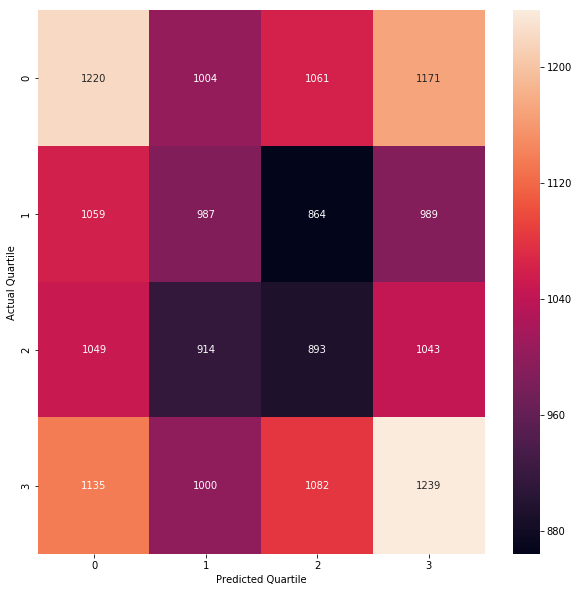

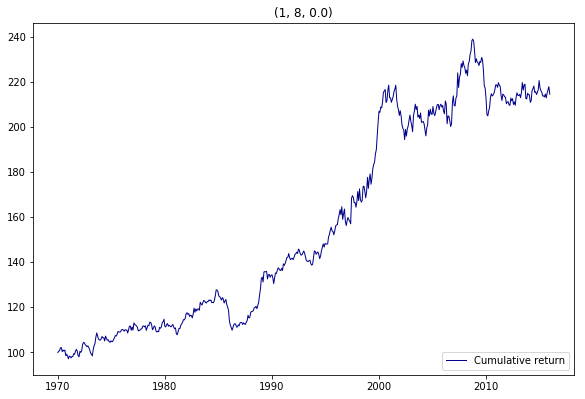

---
16:24:09 Running experiment 2 of 18
(1, 8, 0.1)
layer 1 size 8, reg_penalty 0.10000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 8)            400         main_input[0][0]                 
__________________________________________________________________________________________________
Output00 (Dense)                (None, 4)            36          Dense00[0][0]                    
__________________________________________________________________________________________________
Output01 (Dense)                (None, 4)            36          Dense00[0][0]                    
__________________

Avg rank correlation (Kendall's tau): 0.0326 (Expected: 0)
4-quartile accuracy: 0.2630 (Expected: 0.25)
Long/short/flat accuracy: 0.3719 (Expected: 0.375)


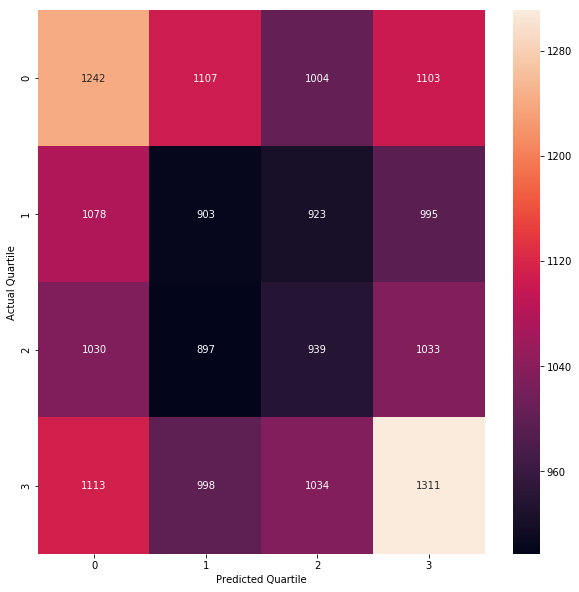

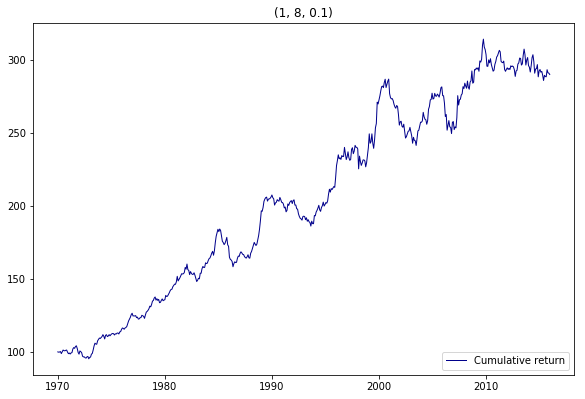

---
18:05:13 Running experiment 3 of 18
(1, 8, 1.0)
layer 1 size 8, reg_penalty 1.00000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 8)            400         main_input[0][0]                 
__________________________________________________________________________________________________
Output00 (Dense)                (None, 4)            36          Dense00[0][0]                    
__________________________________________________________________________________________________
Output01 (Dense)                (None, 4)            36          Dense00[0][0]                    
__________________

Avg rank correlation (Kendall's tau): 0.0324 (Expected: 0)
4-quartile accuracy: 0.2674 (Expected: 0.25)
Long/short/flat accuracy: 0.3779 (Expected: 0.375)


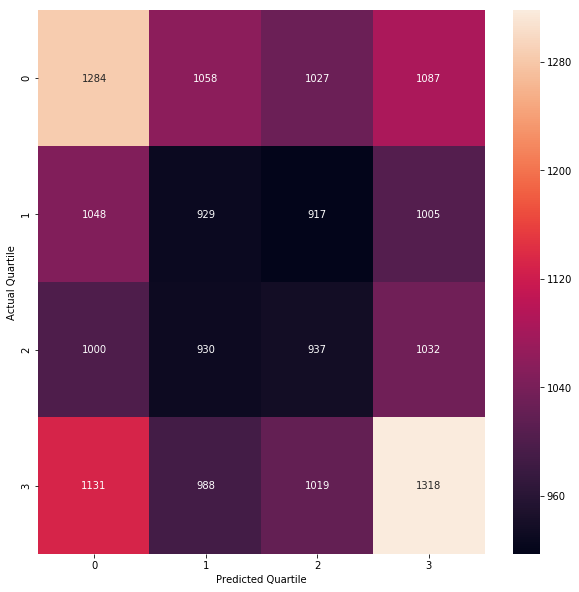

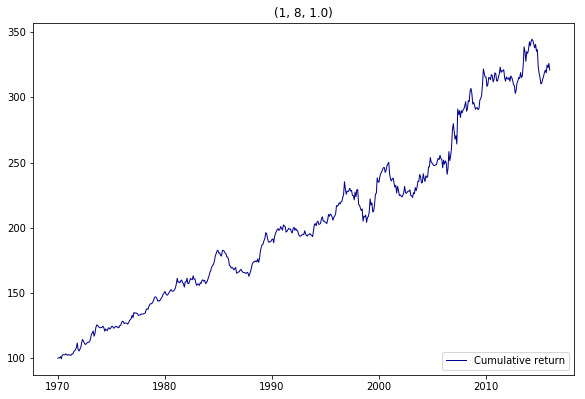

---
19:46:02 Running experiment 4 of 18
(1, 16, 0.0)
layer 1 size 16, reg_penalty 0.00000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 16)           800         main_input[0][0]                 
__________________________________________________________________________________________________
Output00 (Dense)                (None, 4)            68          Dense00[0][0]                    
__________________________________________________________________________________________________
Output01 (Dense)                (None, 4)            68          Dense00[0][0]                    
________________

Avg rank correlation (Kendall's tau): 0.0158 (Expected: 0)
4-quartile accuracy: 0.2612 (Expected: 0.25)
Long/short/flat accuracy: 0.3701 (Expected: 0.375)


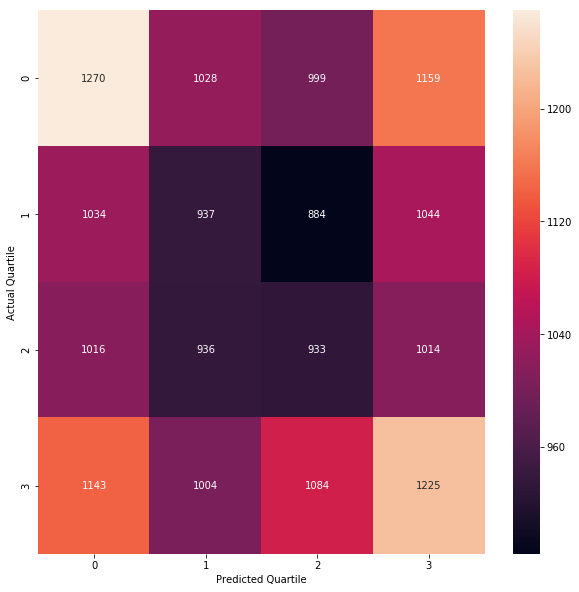

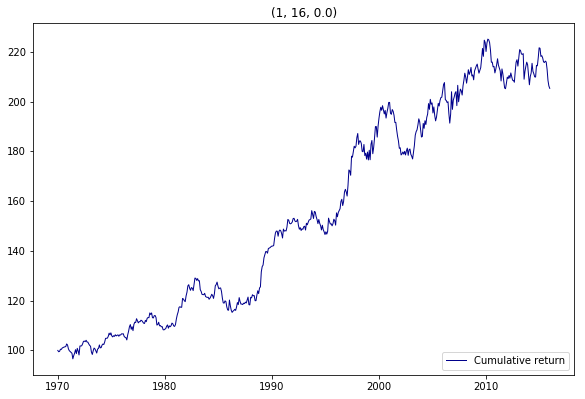

---
21:27:15 Running experiment 5 of 18
(1, 16, 0.1)
layer 1 size 16, reg_penalty 0.10000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 16)           800         main_input[0][0]                 
__________________________________________________________________________________________________
Output00 (Dense)                (None, 4)            68          Dense00[0][0]                    
__________________________________________________________________________________________________
Output01 (Dense)                (None, 4)            68          Dense00[0][0]                    
________________

Avg rank correlation (Kendall's tau): 0.0271 (Expected: 0)
4-quartile accuracy: 0.2663 (Expected: 0.25)
Long/short/flat accuracy: 0.3765 (Expected: 0.375)


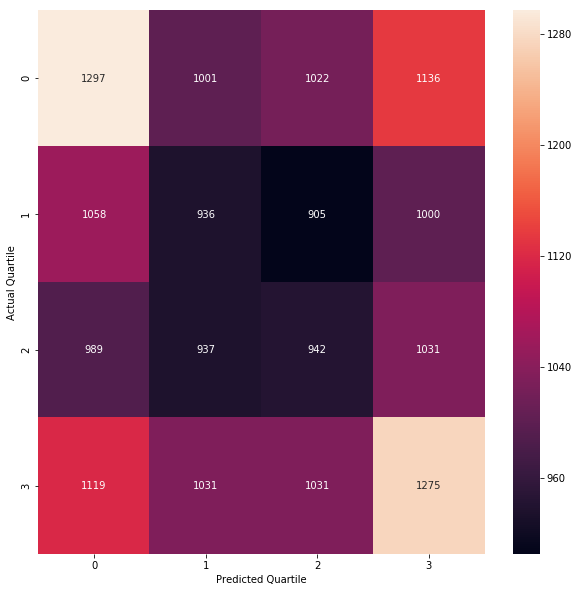

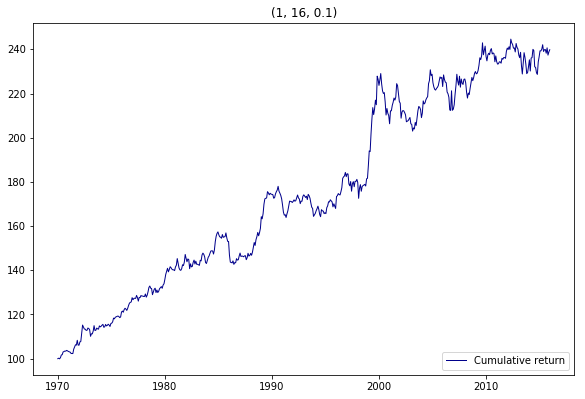

---
23:07:57 Running experiment 6 of 18
(1, 16, 1.0)
layer 1 size 16, reg_penalty 1.00000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 16)           800         main_input[0][0]                 
__________________________________________________________________________________________________
Output00 (Dense)                (None, 4)            68          Dense00[0][0]                    
__________________________________________________________________________________________________
Output01 (Dense)                (None, 4)            68          Dense00[0][0]                    
________________

Avg rank correlation (Kendall's tau): 0.0347 (Expected: 0)
4-quartile accuracy: 0.2689 (Expected: 0.25)
Long/short/flat accuracy: 0.3811 (Expected: 0.375)


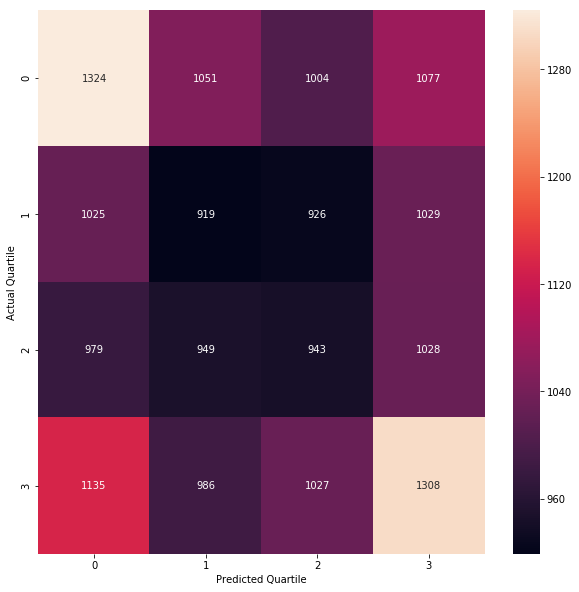

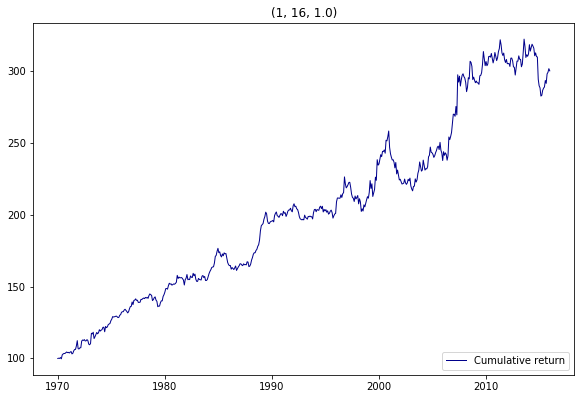

---
00:48:30 Running experiment 7 of 18
(2, 8, 0.0)
layer 1 size 8, reg_penalty 0.00000000
layer 2 size 8, reg_penalty 0.00000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 8)            400         main_input[0][0]                 
__________________________________________________________________________________________________
Dense01 (Dense)                 (None, 8)            72          Dense00[0][0]                    
__________________________________________________________________________________________________
Output00 (Dense)                (None, 4)            36          Dense01[0][0]

Avg rank correlation (Kendall's tau): 0.0222 (Expected: 0)
4-quartile accuracy: 0.2587 (Expected: 0.25)
Long/short/flat accuracy: 0.3658 (Expected: 0.375)


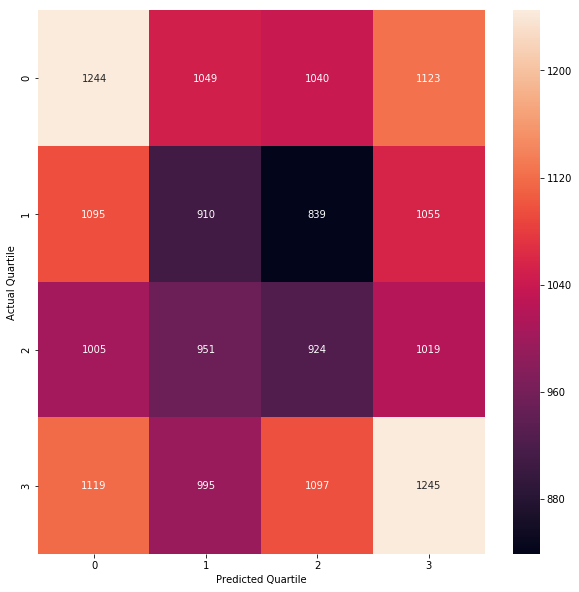

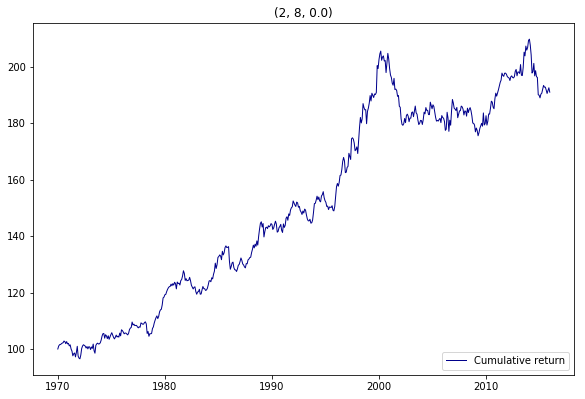

---
02:29:36 Running experiment 8 of 18
(2, 8, 0.1)
layer 1 size 8, reg_penalty 0.10000000
layer 2 size 8, reg_penalty 0.10000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 8)            400         main_input[0][0]                 
__________________________________________________________________________________________________
Dense01 (Dense)                 (None, 8)            72          Dense00[0][0]                    
__________________________________________________________________________________________________
Output00 (Dense)                (None, 4)            36          Dense01[0][0]

Avg rank correlation (Kendall's tau): 0.0141 (Expected: 0)
4-quartile accuracy: 0.2621 (Expected: 0.25)
Long/short/flat accuracy: 0.3689 (Expected: 0.375)


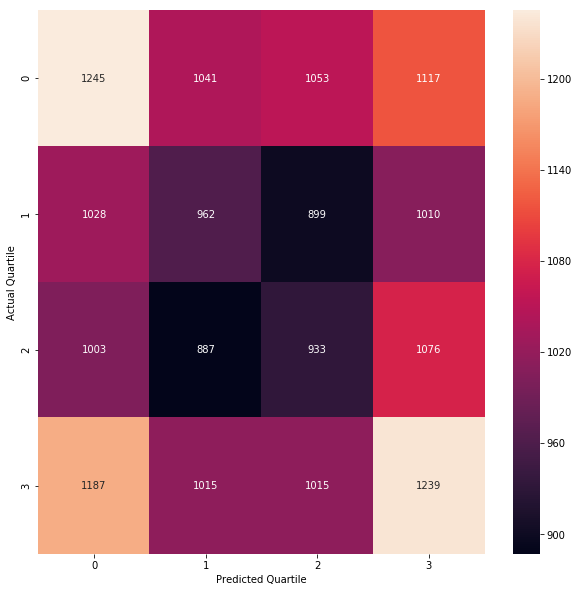

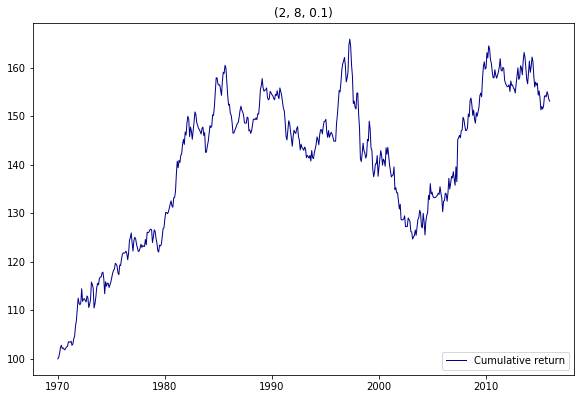

---
04:10:41 Running experiment 9 of 18
(2, 8, 1.0)
layer 1 size 8, reg_penalty 1.00000000
layer 2 size 8, reg_penalty 1.00000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 8)            400         main_input[0][0]                 
__________________________________________________________________________________________________
Dense01 (Dense)                 (None, 8)            72          Dense00[0][0]                    
__________________________________________________________________________________________________
Output00 (Dense)                (None, 4)            36          Dense01[0][0]

Avg rank correlation (Kendall's tau): 0.0004 (Expected: 0)
4-quartile accuracy: 0.2418 (Expected: 0.25)
Long/short/flat accuracy: 0.3448 (Expected: 0.375)


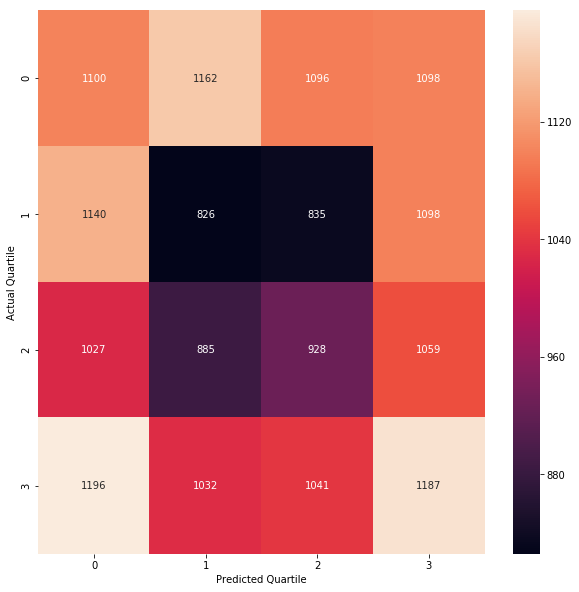

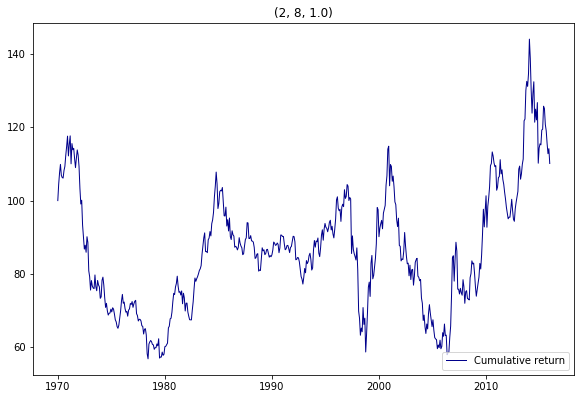

---
05:52:13 Running experiment 10 of 18
(2, 16, 0.0)
layer 1 size 16, reg_penalty 0.00000000
layer 2 size 16, reg_penalty 0.00000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 16)           800         main_input[0][0]                 
__________________________________________________________________________________________________
Dense01 (Dense)                 (None, 16)           272         Dense00[0][0]                    
__________________________________________________________________________________________________
Output00 (Dense)                (None, 4)            68          Dense01[0

Avg rank correlation (Kendall's tau): 0.0314 (Expected: 0)
4-quartile accuracy: 0.2628 (Expected: 0.25)
Long/short/flat accuracy: 0.3725 (Expected: 0.375)


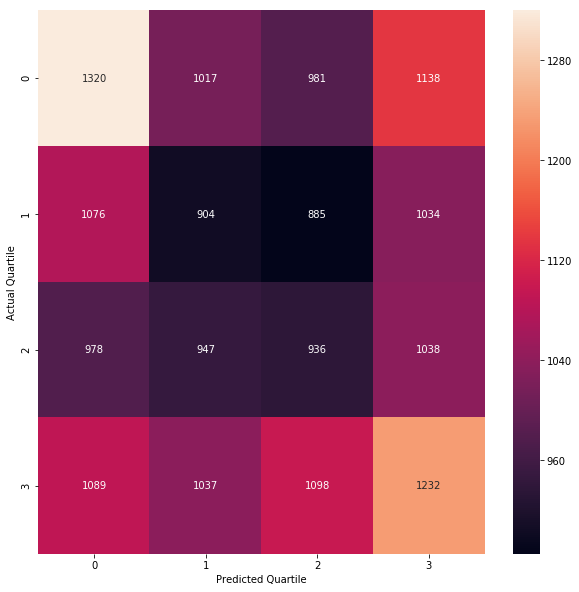

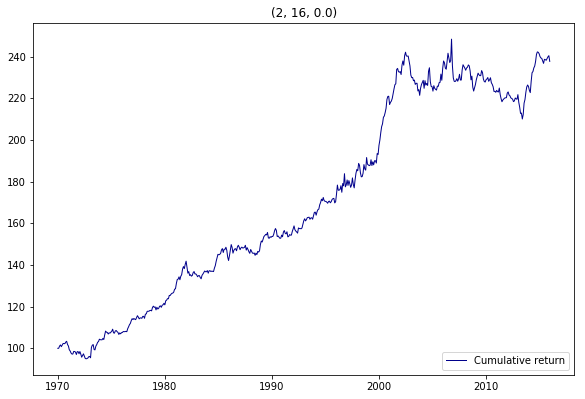

---
07:33:32 Running experiment 11 of 18
(2, 16, 0.1)
layer 1 size 16, reg_penalty 0.10000000
layer 2 size 16, reg_penalty 0.10000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 16)           800         main_input[0][0]                 
__________________________________________________________________________________________________
Dense01 (Dense)                 (None, 16)           272         Dense00[0][0]                    
__________________________________________________________________________________________________
Output00 (Dense)                (None, 4)            68          Dense01[0

Avg rank correlation (Kendall's tau): 0.0035 (Expected: 0)
4-quartile accuracy: 0.2504 (Expected: 0.25)
Long/short/flat accuracy: 0.3610 (Expected: 0.375)


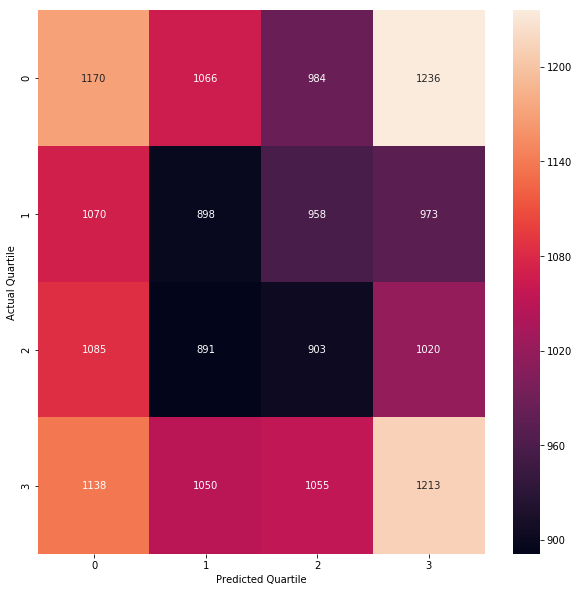

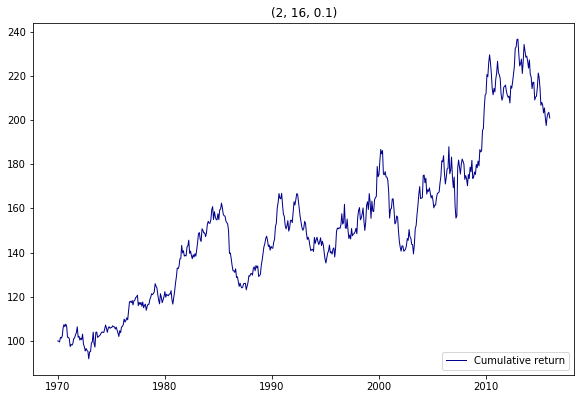

---
09:15:10 Running experiment 12 of 18
(2, 16, 1.0)
layer 1 size 16, reg_penalty 1.00000000
layer 2 size 16, reg_penalty 1.00000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 16)           800         main_input[0][0]                 
__________________________________________________________________________________________________
Dense01 (Dense)                 (None, 16)           272         Dense00[0][0]                    
__________________________________________________________________________________________________
Output00 (Dense)                (None, 4)            68          Dense01[0

Avg rank correlation (Kendall's tau): -0.0001 (Expected: 0)
4-quartile accuracy: 0.2428 (Expected: 0.25)
Long/short/flat accuracy: 0.3477 (Expected: 0.375)


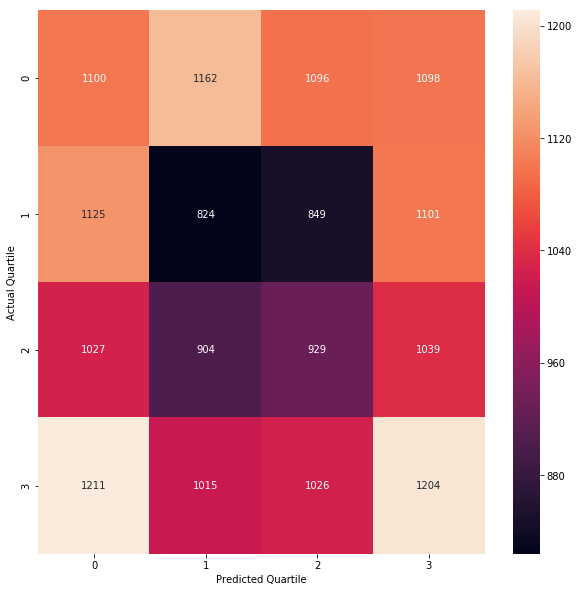

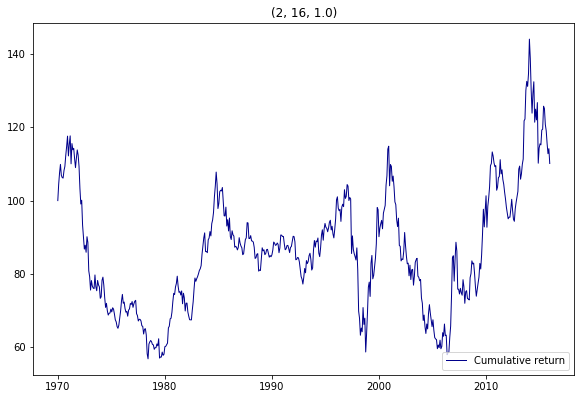

---
10:56:52 Running experiment 13 of 18
(3, 8, 0.0)
layer 1 size 8, reg_penalty 0.00000000
layer 2 size 8, reg_penalty 0.00000000
layer 3 size 8, reg_penalty 0.00000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 8)            400         main_input[0][0]                 
__________________________________________________________________________________________________
Dense01 (Dense)                 (None, 8)            72          Dense00[0][0]                    
__________________________________________________________________________________________________
Dense02 (Dense)                 (None,

Avg rank correlation (Kendall's tau): 0.0010 (Expected: 0)
4-quartile accuracy: 0.2490 (Expected: 0.25)
Long/short/flat accuracy: 0.3554 (Expected: 0.375)


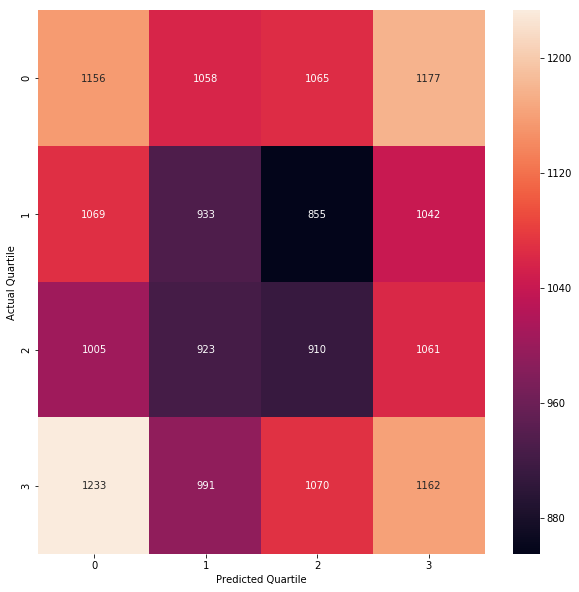

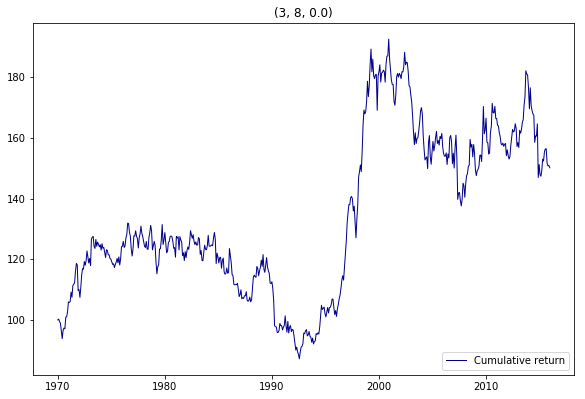

---
12:37:52 Running experiment 14 of 18
(3, 8, 0.1)
layer 1 size 8, reg_penalty 0.10000000
layer 2 size 8, reg_penalty 0.10000000
layer 3 size 8, reg_penalty 0.10000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 8)            400         main_input[0][0]                 
__________________________________________________________________________________________________
Dense01 (Dense)                 (None, 8)            72          Dense00[0][0]                    
__________________________________________________________________________________________________
Dense02 (Dense)                 (None,

Avg rank correlation (Kendall's tau): 0.0363 (Expected: 0)
4-quartile accuracy: 0.2685 (Expected: 0.25)
Long/short/flat accuracy: 0.3777 (Expected: 0.375)


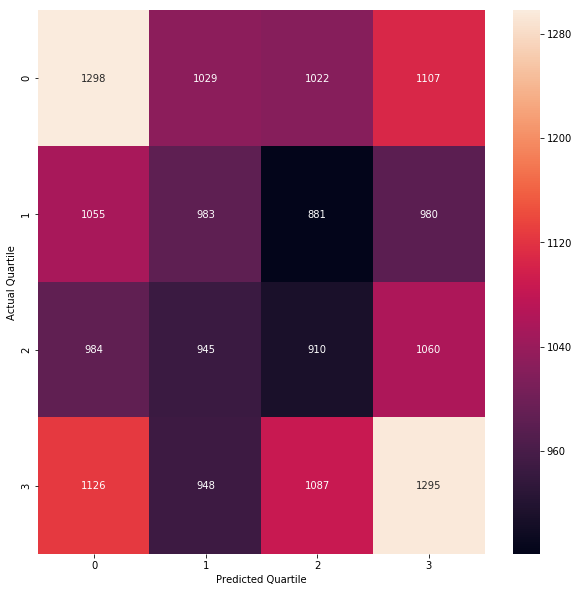

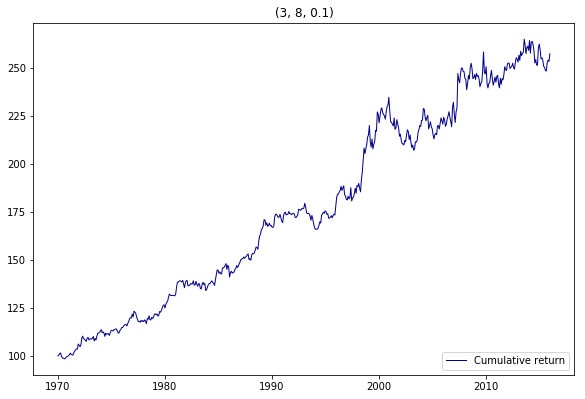

---
14:19:30 Running experiment 15 of 18
(3, 8, 1.0)
layer 1 size 8, reg_penalty 1.00000000
layer 2 size 8, reg_penalty 1.00000000
layer 3 size 8, reg_penalty 1.00000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 8)            400         main_input[0][0]                 
__________________________________________________________________________________________________
Dense01 (Dense)                 (None, 8)            72          Dense00[0][0]                    
__________________________________________________________________________________________________
Dense02 (Dense)                 (None,

Avg rank correlation (Kendall's tau): -0.0003 (Expected: 0)
4-quartile accuracy: 0.2417 (Expected: 0.25)
Long/short/flat accuracy: 0.3449 (Expected: 0.375)


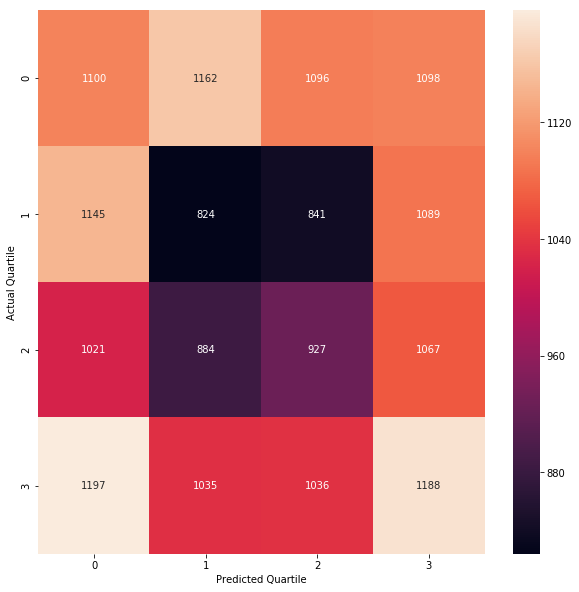

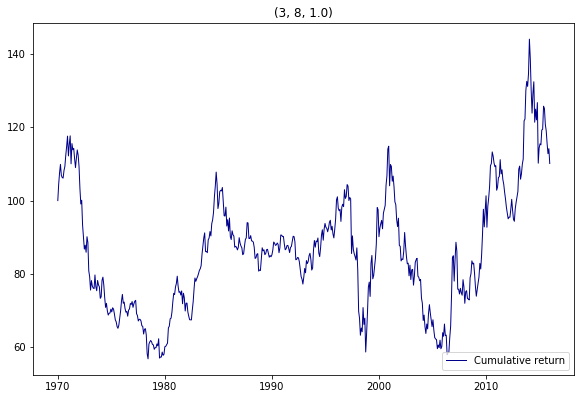

---
16:00:56 Running experiment 16 of 18
(3, 16, 0.0)
layer 1 size 16, reg_penalty 0.00000000
layer 2 size 16, reg_penalty 0.00000000
layer 3 size 16, reg_penalty 0.00000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 16)           800         main_input[0][0]                 
__________________________________________________________________________________________________
Dense01 (Dense)                 (None, 16)           272         Dense00[0][0]                    
__________________________________________________________________________________________________
Dense02 (Dense)                 (N

Avg rank correlation (Kendall's tau): 0.0130 (Expected: 0)
4-quartile accuracy: 0.2566 (Expected: 0.25)
Long/short/flat accuracy: 0.3618 (Expected: 0.375)


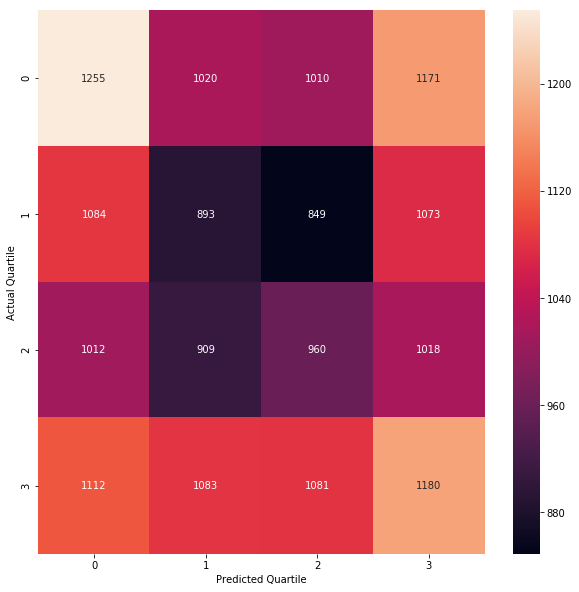

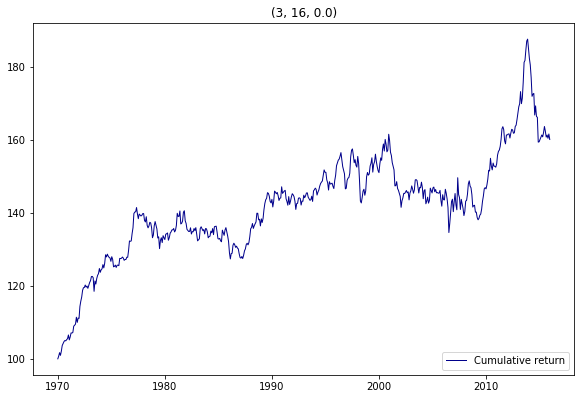

---
17:42:25 Running experiment 17 of 18
(3, 16, 0.1)
layer 1 size 16, reg_penalty 0.10000000
layer 2 size 16, reg_penalty 0.10000000
layer 3 size 16, reg_penalty 0.10000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 16)           800         main_input[0][0]                 
__________________________________________________________________________________________________
Dense01 (Dense)                 (None, 16)           272         Dense00[0][0]                    
__________________________________________________________________________________________________
Dense02 (Dense)                 (N

Avg rank correlation (Kendall's tau): 0.0117 (Expected: 0)
4-quartile accuracy: 0.2580 (Expected: 0.25)
Long/short/flat accuracy: 0.3685 (Expected: 0.375)


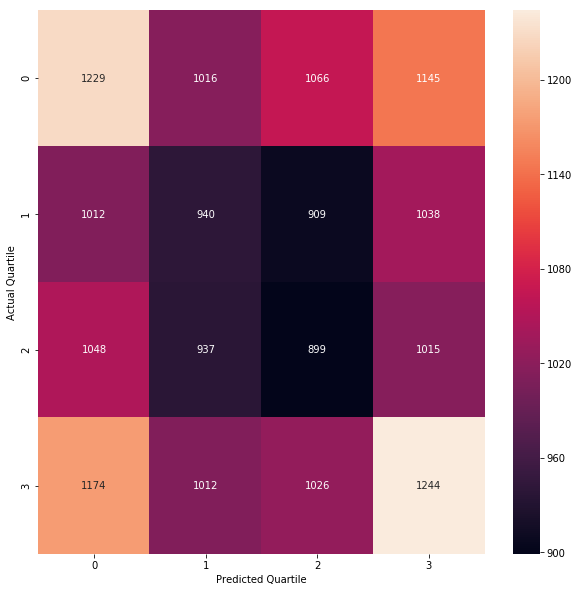

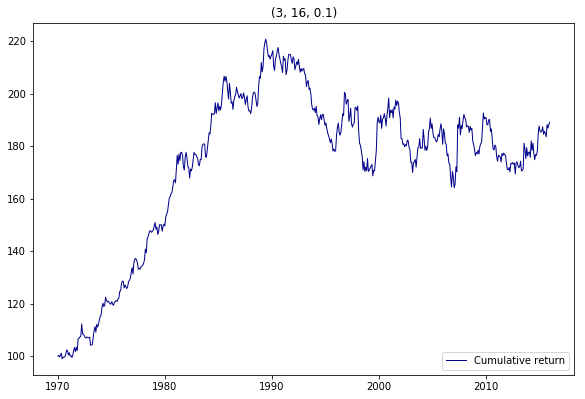

---
19:24:12 Running experiment 18 of 18
(3, 16, 1.0)
layer 1 size 16, reg_penalty 1.00000000
layer 2 size 16, reg_penalty 1.00000000
layer 3 size 16, reg_penalty 1.00000000
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
Dense00 (Dense)                 (None, 16)           800         main_input[0][0]                 
__________________________________________________________________________________________________
Dense01 (Dense)                 (None, 16)           272         Dense00[0][0]                    
__________________________________________________________________________________________________
Dense02 (Dense)                 (N

Avg rank correlation (Kendall's tau): -0.0002 (Expected: 0)
4-quartile accuracy: 0.2428 (Expected: 0.25)
Long/short/flat accuracy: 0.3460 (Expected: 0.375)


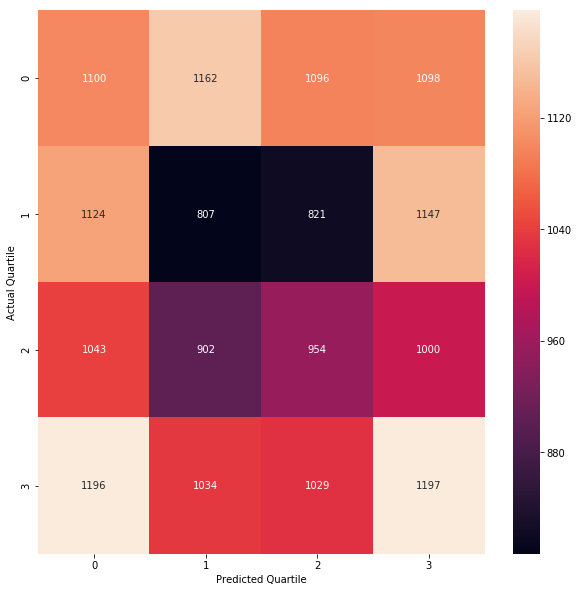

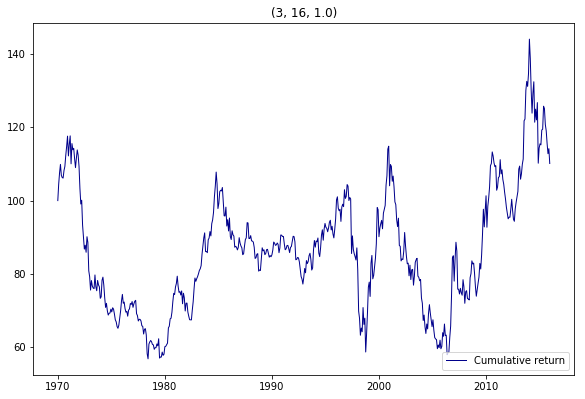

---


In [33]:
# custom loss function
n_hiddens = [1, 2, 3]
layer_sizes = [8, 16]
reg_penalties = [0.0, 0.1, 1.0]
hyperparameter_combos = list(product(n_hiddens, layer_sizes, reg_penalties))

keys = []

print("%s Running %d experiments" % (time.strftime("%H:%M:%S"), len(hyperparameter_combos)))
for counter, param_list in enumerate(hyperparameter_combos):
    nlayers, layer_size, reg_penalty = param_list
    print("%s Running experiment %d of %d" % (time.strftime("%H:%M:%S"), counter+1, len(hyperparameter_combos)))
    key = (nlayers, layer_size, reg_penalty)
    print(key)
    keys.append(key)
    backtestmodel = BacktestModel(X, Y, 
                                  model=KerasBacktestModel(n_hidden_layers = nlayers,
                                                           hidden_layer_size = layer_size,
                                                           reg_penalty = reg_penalty,
                                                           loss_function = my_categorical_cross_entropy
                                                          ), 
                                  coef_dict_param="all",
                                  startindex=FIRST_TRAIN_MONTHS,
                                  fit_missing='mean',
                                  scaler = None,
                                  make_classes=make_four_classes)
    backtestmodel.walkforward_xval(n_splits=5, verbose=True) 
    _, best_params = backtestmodel.sharpe_cv(calc_returns_gen, range(1, 16), verbose=False)
    print("best return gen params: ", best_params)
    backtestmodel.gen_returns(calc_returns_gen(best_params), verbose=True)
    backtestmodel.report_returns(start_date=start_date_str, freq='M')
    backtestmodel.evaluate_quantiles(chart=True, verbose=True)
    mychart([backtestmodel.cumulative_return],["Cumulative return"], title=str(param_list))

    print("---")
    


00:38:35 Running 216 experiments
00:38:35 Running experiment 1 of 216
(100, 3, 0.03, 0.6)
00:38:35 Generate splits [140, 280, 419, 558, 697]
classify
00:38:35 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.281%
Monthly Sharpe ratio: -0.037
Avg rank correlation (Kendall's tau): 0.0069 (Expected: 0)
4-quartile accuracy: 0.2653 (Expected: 0.25)
Long/short/flat accuracy: 0.3788 (Expected: 0.375)


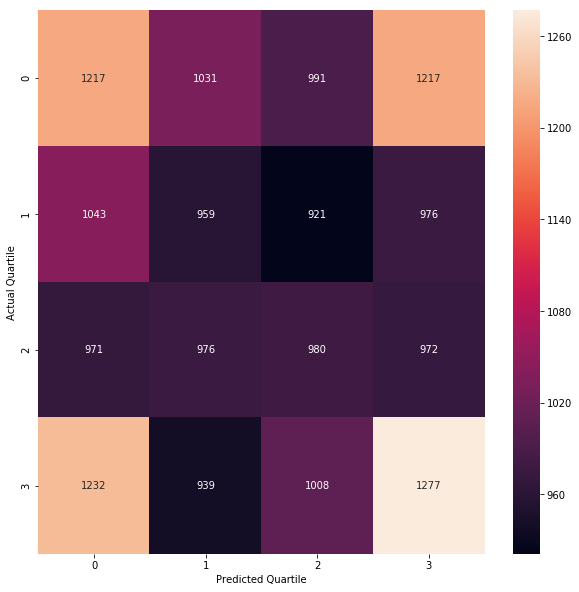

---
00:38:42 Running experiment 2 of 216
(100, 3, 0.03, 0.7)
00:38:42 Generate splits [140, 280, 419, 558, 697]
classify
00:38:42 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.292%
Monthly Sharpe ratio: 0.088
Avg rank correlation (Kendall's tau): 0.0043 (Expected: 0)
4-quartile accuracy: 0.2595 (Expected: 0.25)
Long/short/flat accuracy: 0.3716 (Expected: 0.375)


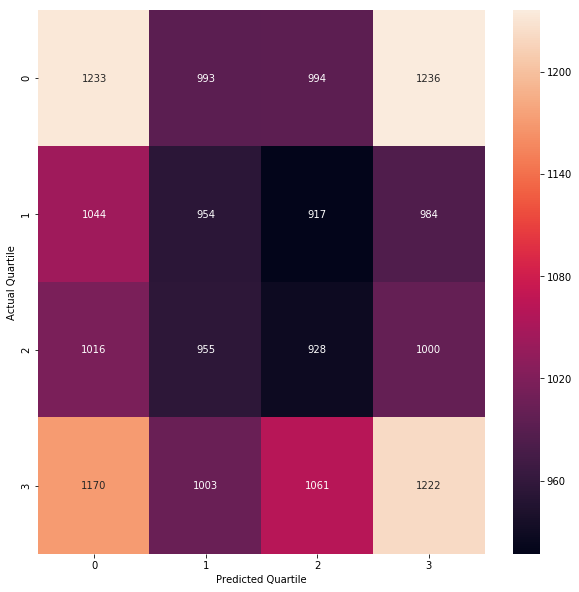

---
00:38:48 Running experiment 3 of 216
(100, 3, 0.03, 0.8)
00:38:48 Generate splits [140, 280, 419, 558, 697]
classify
00:38:48 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.068%
Monthly Sharpe ratio: 0.038
Avg rank correlation (Kendall's tau): 0.0049 (Expected: 0)
4-quartile accuracy: 0.2601 (Expected: 0.25)
Long/short/flat accuracy: 0.3750 (Expected: 0.375)


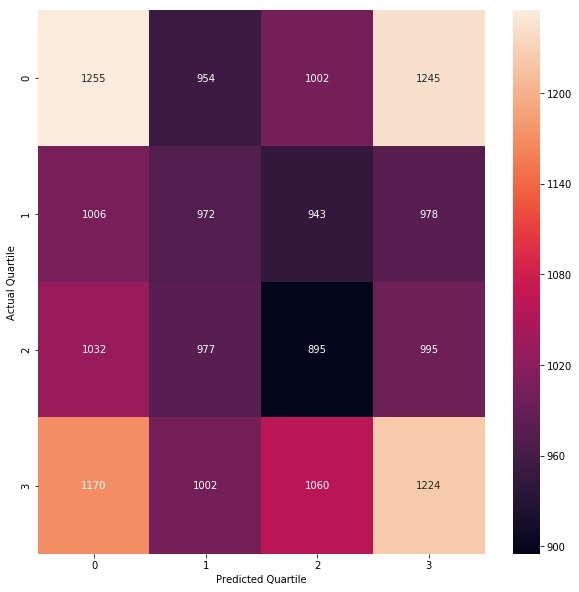

---
00:38:54 Running experiment 4 of 216
(100, 3, 0.01, 0.6)
00:38:54 Generate splits [140, 280, 419, 558, 697]
classify
00:38:54 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.721%
Monthly Sharpe ratio: -0.149
Avg rank correlation (Kendall's tau): -0.0095 (Expected: 0)
4-quartile accuracy: 0.2542 (Expected: 0.25)
Long/short/flat accuracy: 0.3655 (Expected: 0.375)


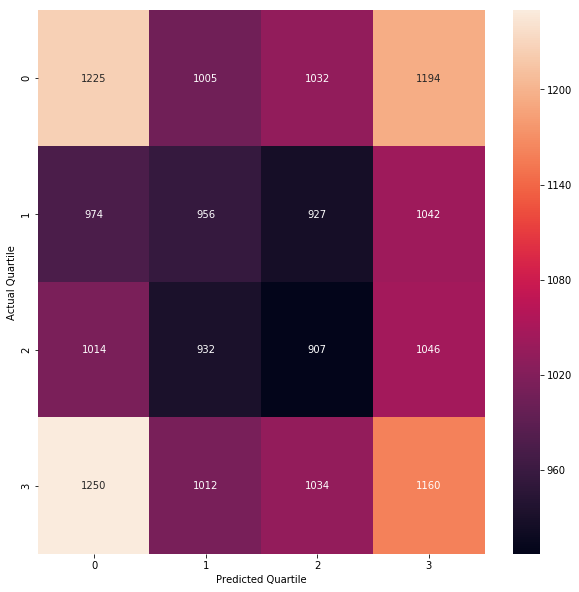

---
00:38:59 Running experiment 5 of 216
(100, 3, 0.01, 0.7)
00:38:59 Generate splits [140, 280, 419, 558, 697]
classify
00:38:59 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.155%
Monthly Sharpe ratio: 0.058
Avg rank correlation (Kendall's tau): 0.0052 (Expected: 0)
4-quartile accuracy: 0.2609 (Expected: 0.25)
Long/short/flat accuracy: 0.3737 (Expected: 0.375)


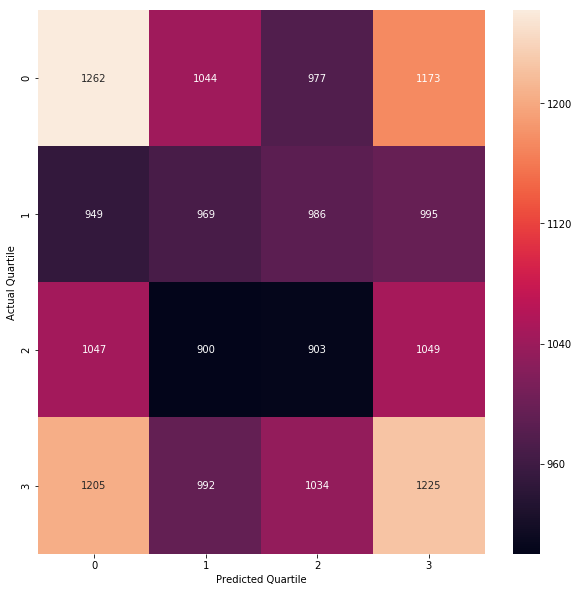

---
00:39:04 Running experiment 6 of 216
(100, 3, 0.01, 0.8)
00:39:04 Generate splits [140, 280, 419, 558, 697]
classify
00:39:04 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.153%
Monthly Sharpe ratio: -0.016
Avg rank correlation (Kendall's tau): -0.0023 (Expected: 0)
4-quartile accuracy: 0.2594 (Expected: 0.25)
Long/short/flat accuracy: 0.3698 (Expected: 0.375)


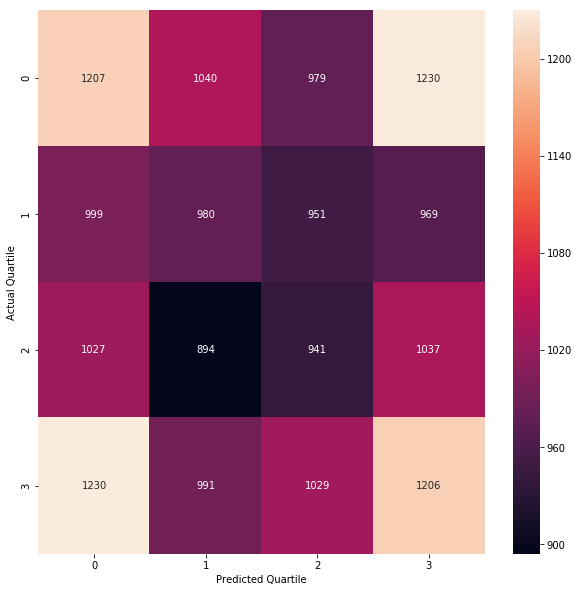

---
00:39:09 Running experiment 7 of 216
(100, 3, 0.003, 0.6)
00:39:09 Generate splits [140, 280, 419, 558, 697]
classify
00:39:09 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.781%
Monthly Sharpe ratio: -0.166
Avg rank correlation (Kendall's tau): -0.0053 (Expected: 0)
4-quartile accuracy: 0.2475 (Expected: 0.25)
Long/short/flat accuracy: 0.3569 (Expected: 0.375)


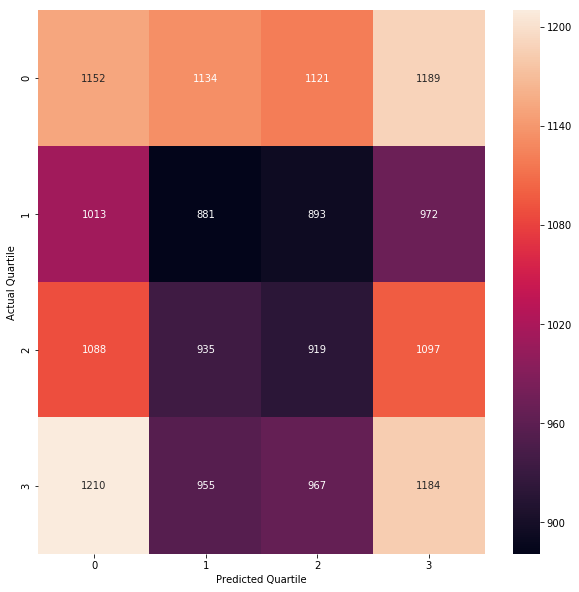

---
00:39:13 Running experiment 8 of 216
(100, 3, 0.003, 0.7)
00:39:13 Generate splits [140, 280, 419, 558, 697]
classify
00:39:13 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.660%
Monthly Sharpe ratio: -0.149
Avg rank correlation (Kendall's tau): -0.0045 (Expected: 0)
4-quartile accuracy: 0.2463 (Expected: 0.25)
Long/short/flat accuracy: 0.3588 (Expected: 0.375)


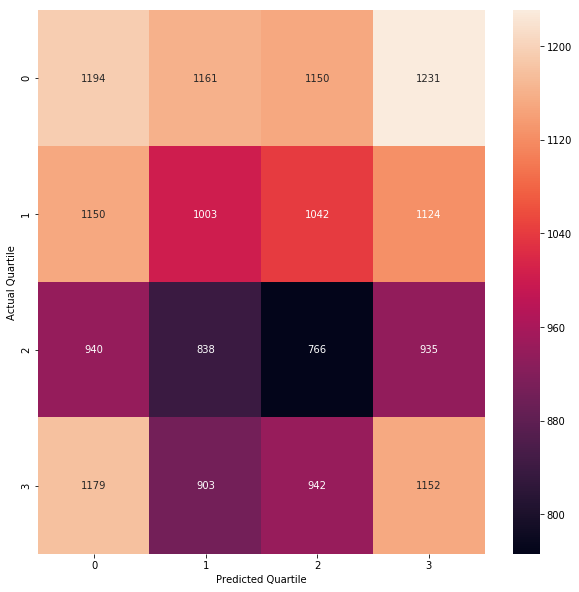

---
00:39:17 Running experiment 9 of 216
(100, 3, 0.003, 0.8)
00:39:17 Generate splits [140, 280, 419, 558, 697]
classify
00:39:17 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.653%
Monthly Sharpe ratio: -0.150
Avg rank correlation (Kendall's tau): -0.0037 (Expected: 0)
4-quartile accuracy: 0.2533 (Expected: 0.25)
Long/short/flat accuracy: 0.3665 (Expected: 0.375)


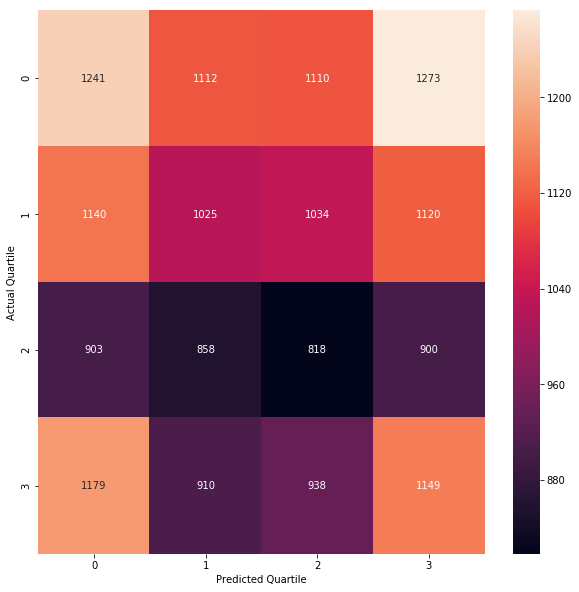

---
00:39:22 Running experiment 10 of 216
(100, 3, 0.001, 0.6)
00:39:22 Generate splits [140, 280, 419, 558, 697]
classify
00:39:22 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.297%
Monthly Sharpe ratio: 0.105
Avg rank correlation (Kendall's tau): 0.0099 (Expected: 0)
4-quartile accuracy: 0.2577 (Expected: 0.25)
Long/short/flat accuracy: 0.3683 (Expected: 0.375)


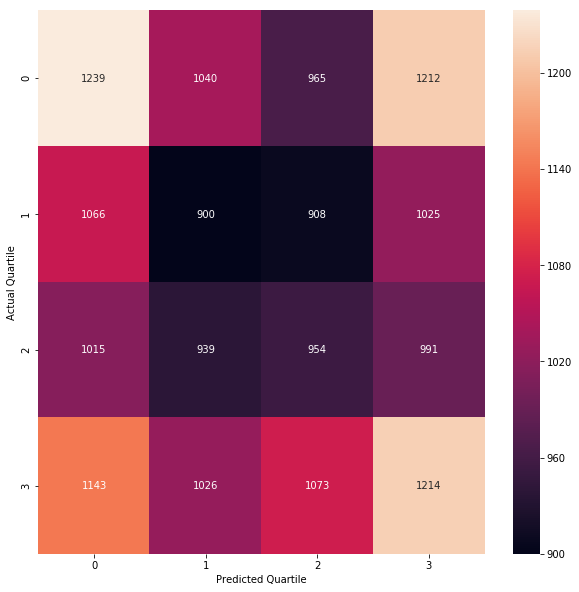

---
00:39:26 Running experiment 11 of 216
(100, 3, 0.001, 0.7)
00:39:26 Generate splits [140, 280, 419, 558, 697]
classify
00:39:26 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.355%
Monthly Sharpe ratio: 0.116
Avg rank correlation (Kendall's tau): -0.0002 (Expected: 0)
4-quartile accuracy: 0.2527 (Expected: 0.25)
Long/short/flat accuracy: 0.3617 (Expected: 0.375)


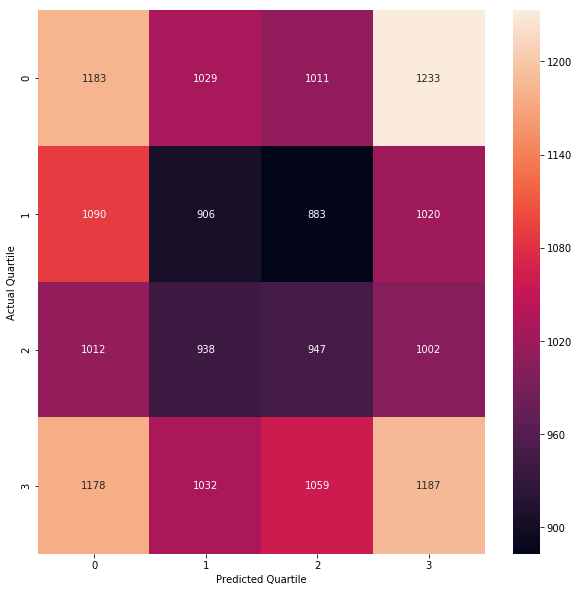

---
00:39:31 Running experiment 12 of 216
(100, 3, 0.001, 0.8)
00:39:31 Generate splits [140, 280, 419, 558, 697]
classify
00:39:31 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.355%
Monthly Sharpe ratio: 0.116
Avg rank correlation (Kendall's tau): 0.0018 (Expected: 0)
4-quartile accuracy: 0.2504 (Expected: 0.25)
Long/short/flat accuracy: 0.3647 (Expected: 0.375)


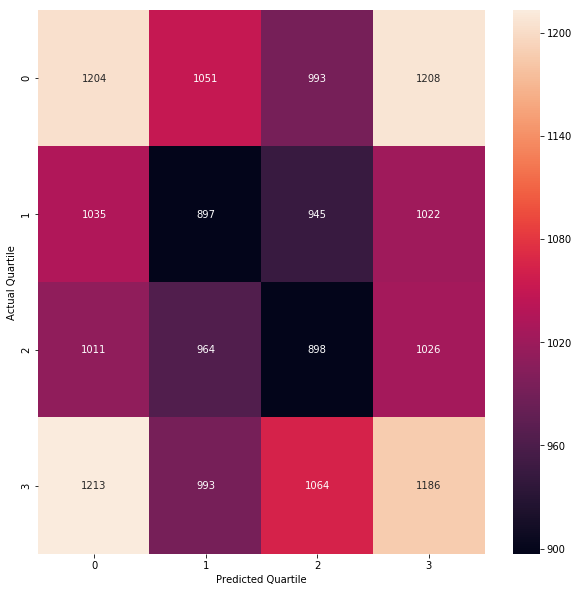

---
00:39:35 Running experiment 13 of 216
(100, 3, 0.0003, 0.6)
00:39:35 Generate splits [140, 280, 419, 558, 697]
classify
00:39:35 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.091%
Monthly Sharpe ratio: -0.006
Avg rank correlation (Kendall's tau): 0.0038 (Expected: 0)
4-quartile accuracy: 0.2531 (Expected: 0.25)
Long/short/flat accuracy: 0.3599 (Expected: 0.375)


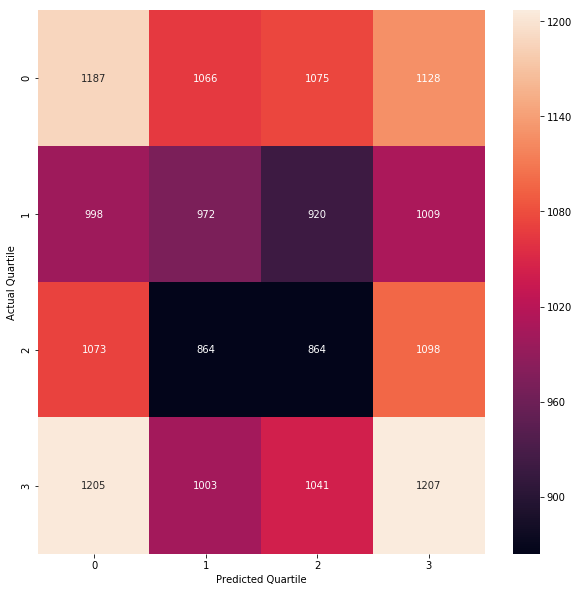

---
00:39:40 Running experiment 14 of 216
(100, 3, 0.0003, 0.7)
00:39:40 Generate splits [140, 280, 419, 558, 697]
classify
00:39:40 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.091%
Monthly Sharpe ratio: -0.006
Avg rank correlation (Kendall's tau): 0.0015 (Expected: 0)
4-quartile accuracy: 0.2524 (Expected: 0.25)
Long/short/flat accuracy: 0.3631 (Expected: 0.375)


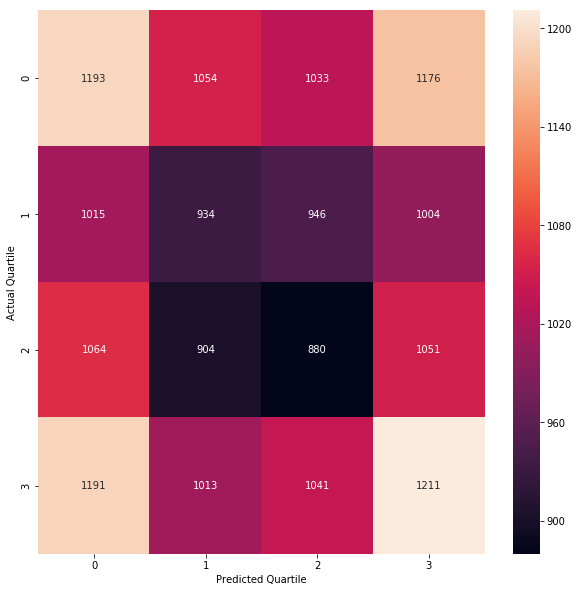

---
00:39:44 Running experiment 15 of 216
(100, 3, 0.0003, 0.8)
00:39:44 Generate splits [140, 280, 419, 558, 697]
classify
00:39:44 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.091%
Monthly Sharpe ratio: -0.006
Avg rank correlation (Kendall's tau): 0.0057 (Expected: 0)
4-quartile accuracy: 0.2543 (Expected: 0.25)
Long/short/flat accuracy: 0.3676 (Expected: 0.375)


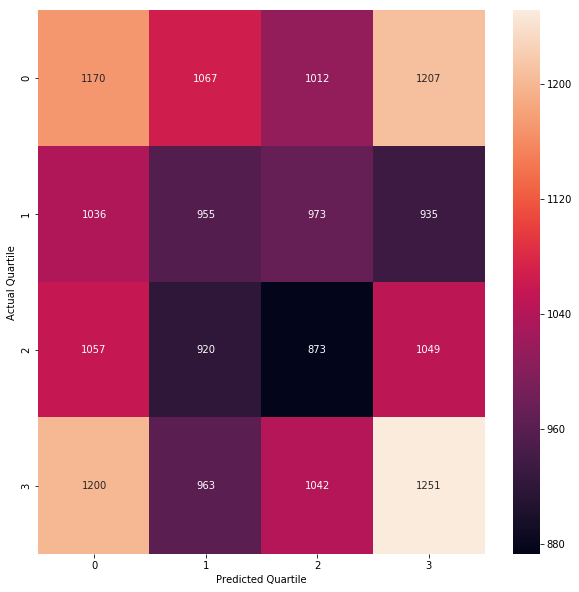

---
00:39:49 Running experiment 16 of 216
(100, 3, 0.0001, 0.6)
00:39:49 Generate splits [140, 280, 419, 558, 697]
classify
00:39:49 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): 0.0030 (Expected: 0)
4-quartile accuracy: 0.2532 (Expected: 0.25)
Long/short/flat accuracy: 0.3587 (Expected: 0.375)


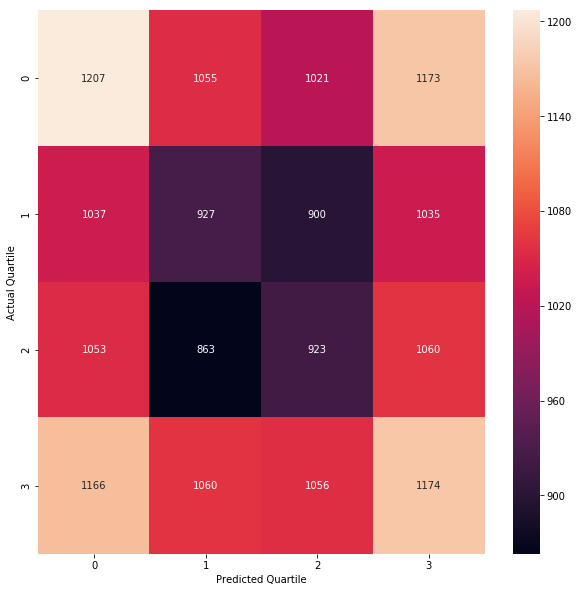

---
00:39:53 Running experiment 17 of 216
(100, 3, 0.0001, 0.7)
00:39:53 Generate splits [140, 280, 419, 558, 697]
classify
00:39:53 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): 0.0057 (Expected: 0)
4-quartile accuracy: 0.2518 (Expected: 0.25)
Long/short/flat accuracy: 0.3594 (Expected: 0.375)


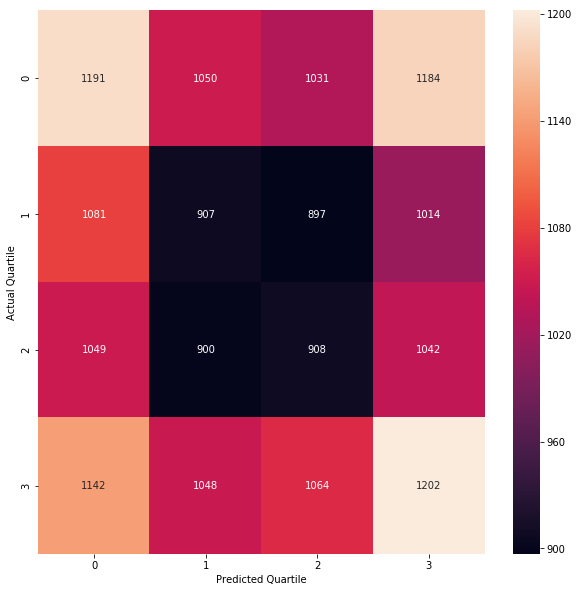

---
00:39:58 Running experiment 18 of 216
(100, 3, 0.0001, 0.8)
00:39:58 Generate splits [140, 280, 419, 558, 697]
classify
00:39:58 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): -0.0040 (Expected: 0)
4-quartile accuracy: 0.2478 (Expected: 0.25)
Long/short/flat accuracy: 0.3570 (Expected: 0.375)


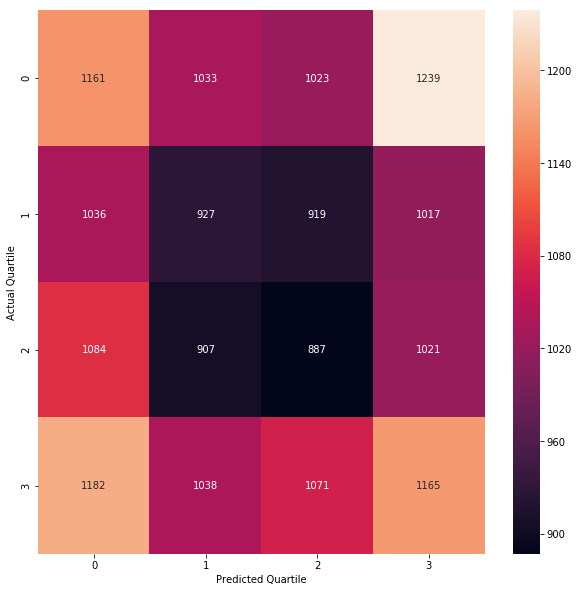

---
00:40:02 Running experiment 19 of 216
(100, 4, 0.03, 0.6)
00:40:02 Generate splits [140, 280, 419, 558, 697]
classify
00:40:02 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.178%
Monthly Sharpe ratio: 0.061
Avg rank correlation (Kendall's tau): 0.0077 (Expected: 0)
4-quartile accuracy: 0.2657 (Expected: 0.25)
Long/short/flat accuracy: 0.3795 (Expected: 0.375)


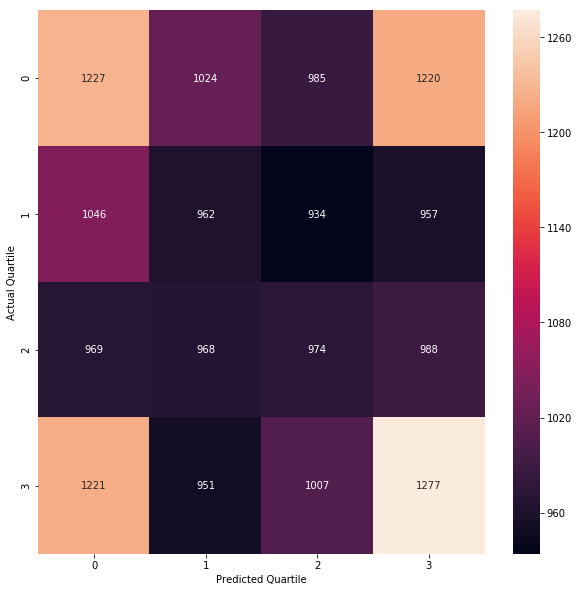

---
00:40:09 Running experiment 20 of 216
(100, 4, 0.03, 0.7)
00:40:09 Generate splits [140, 280, 419, 558, 697]
classify
00:40:09 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.574%
Monthly Sharpe ratio: 0.148
Avg rank correlation (Kendall's tau): 0.0036 (Expected: 0)
4-quartile accuracy: 0.2589 (Expected: 0.25)
Long/short/flat accuracy: 0.3701 (Expected: 0.375)


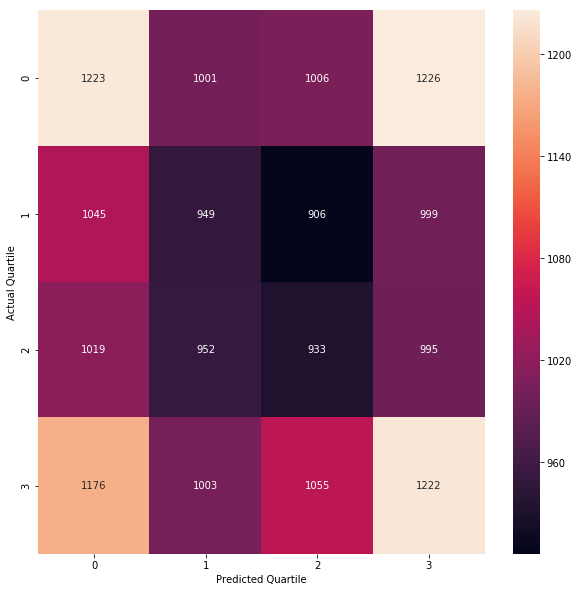

---
00:40:15 Running experiment 21 of 216
(100, 4, 0.03, 0.8)
00:40:15 Generate splits [140, 280, 419, 558, 697]
classify
00:40:15 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.043%
Monthly Sharpe ratio: 0.032
Avg rank correlation (Kendall's tau): 0.0052 (Expected: 0)
4-quartile accuracy: 0.2601 (Expected: 0.25)
Long/short/flat accuracy: 0.3752 (Expected: 0.375)


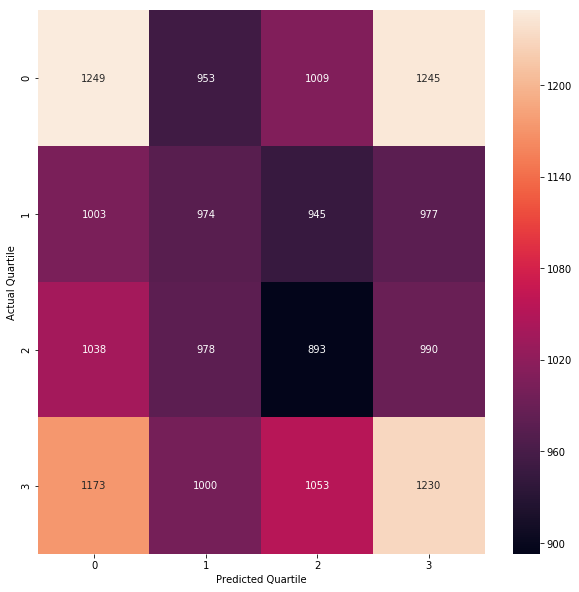

---
00:40:21 Running experiment 22 of 216
(100, 4, 0.01, 0.6)
00:40:21 Generate splits [140, 280, 419, 558, 697]
classify
00:40:21 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.721%
Monthly Sharpe ratio: -0.149
Avg rank correlation (Kendall's tau): -0.0095 (Expected: 0)
4-quartile accuracy: 0.2542 (Expected: 0.25)
Long/short/flat accuracy: 0.3655 (Expected: 0.375)


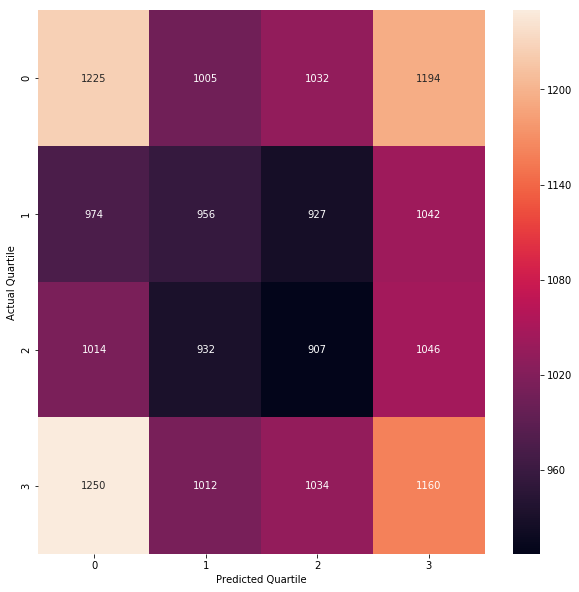

---
00:40:26 Running experiment 23 of 216
(100, 4, 0.01, 0.7)
00:40:26 Generate splits [140, 280, 419, 558, 697]
classify
00:40:26 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.155%
Monthly Sharpe ratio: 0.058
Avg rank correlation (Kendall's tau): 0.0052 (Expected: 0)
4-quartile accuracy: 0.2609 (Expected: 0.25)
Long/short/flat accuracy: 0.3737 (Expected: 0.375)


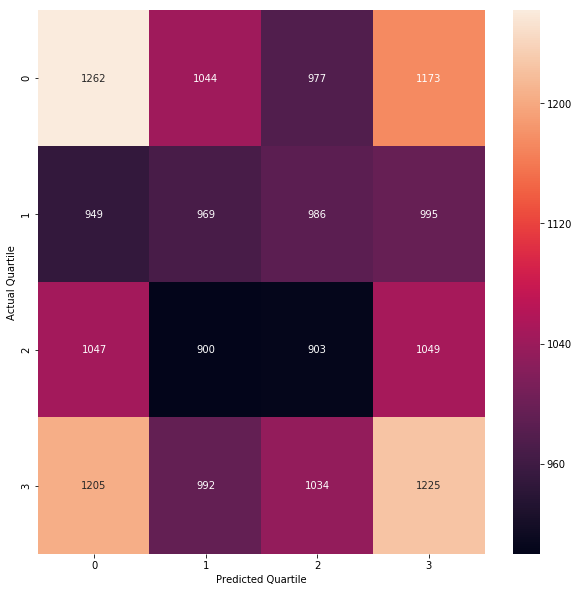

---
00:40:31 Running experiment 24 of 216
(100, 4, 0.01, 0.8)
00:40:31 Generate splits [140, 280, 419, 558, 697]
classify
00:40:31 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.153%
Monthly Sharpe ratio: -0.016
Avg rank correlation (Kendall's tau): -0.0023 (Expected: 0)
4-quartile accuracy: 0.2594 (Expected: 0.25)
Long/short/flat accuracy: 0.3698 (Expected: 0.375)


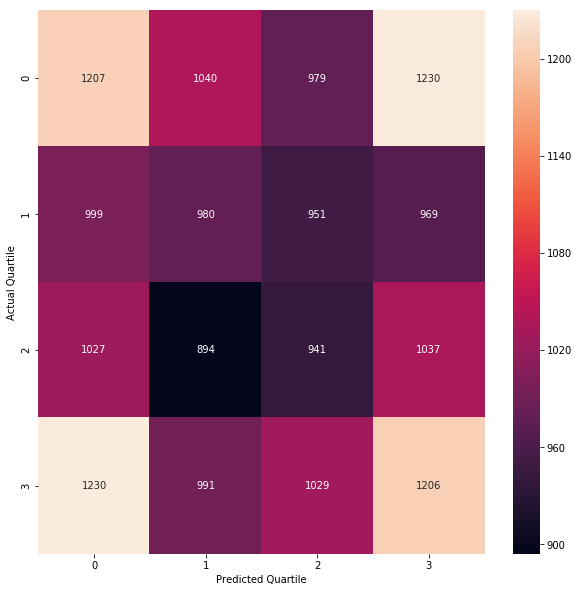

---
00:40:36 Running experiment 25 of 216
(100, 4, 0.003, 0.6)
00:40:36 Generate splits [140, 280, 419, 558, 697]
classify
00:40:36 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.781%
Monthly Sharpe ratio: -0.166
Avg rank correlation (Kendall's tau): -0.0053 (Expected: 0)
4-quartile accuracy: 0.2475 (Expected: 0.25)
Long/short/flat accuracy: 0.3569 (Expected: 0.375)


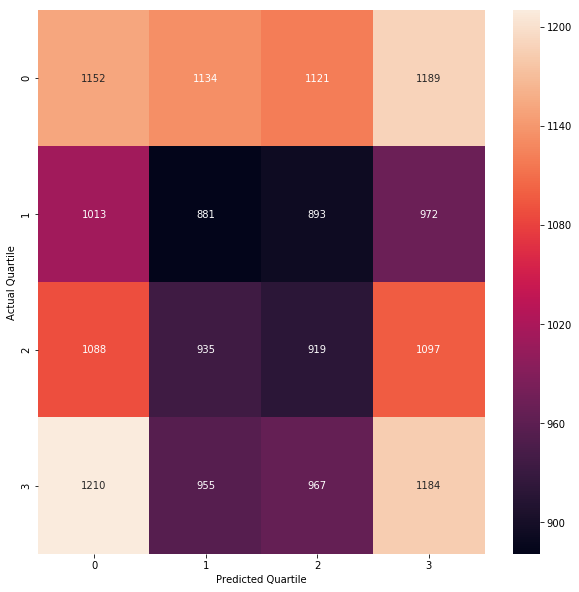

---
00:40:40 Running experiment 26 of 216
(100, 4, 0.003, 0.7)
00:40:40 Generate splits [140, 280, 419, 558, 697]
classify
00:40:40 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.660%
Monthly Sharpe ratio: -0.149
Avg rank correlation (Kendall's tau): -0.0045 (Expected: 0)
4-quartile accuracy: 0.2463 (Expected: 0.25)
Long/short/flat accuracy: 0.3588 (Expected: 0.375)


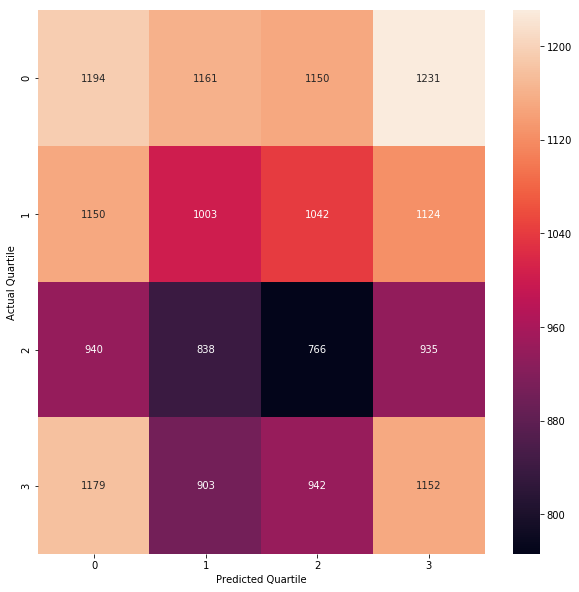

---
00:40:45 Running experiment 27 of 216
(100, 4, 0.003, 0.8)
00:40:45 Generate splits [140, 280, 419, 558, 697]
classify
00:40:45 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.653%
Monthly Sharpe ratio: -0.150
Avg rank correlation (Kendall's tau): -0.0037 (Expected: 0)
4-quartile accuracy: 0.2533 (Expected: 0.25)
Long/short/flat accuracy: 0.3665 (Expected: 0.375)


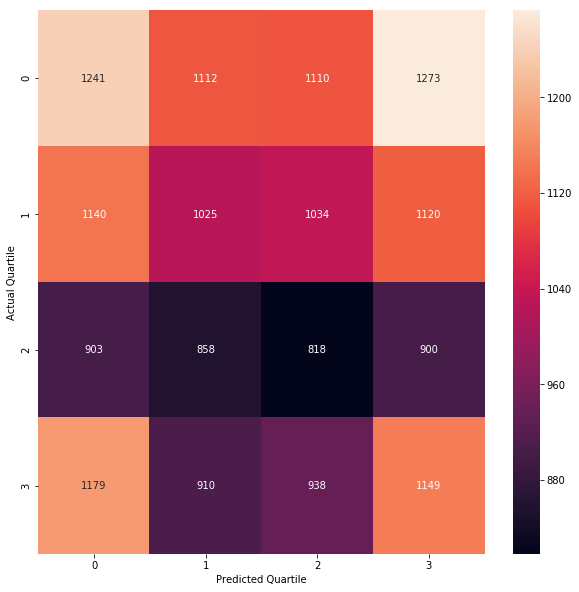

---
00:40:49 Running experiment 28 of 216
(100, 4, 0.001, 0.6)
00:40:49 Generate splits [140, 280, 419, 558, 697]
classify
00:40:49 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.297%
Monthly Sharpe ratio: 0.105
Avg rank correlation (Kendall's tau): -0.0002 (Expected: 0)
4-quartile accuracy: 0.2501 (Expected: 0.25)
Long/short/flat accuracy: 0.3620 (Expected: 0.375)


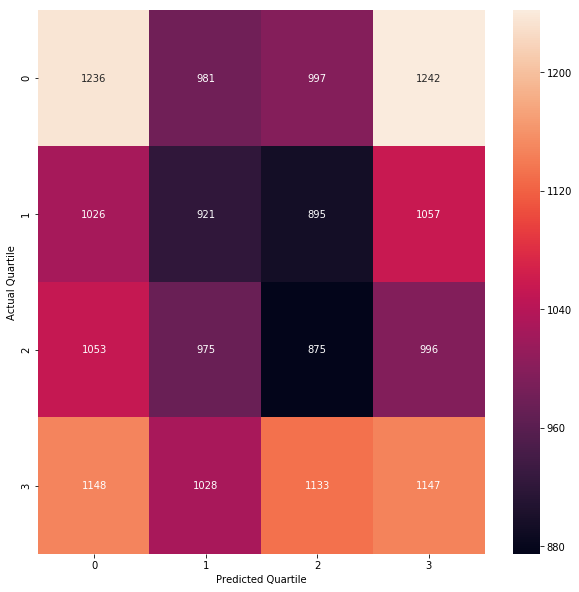

---
00:40:54 Running experiment 29 of 216
(100, 4, 0.001, 0.7)
00:40:54 Generate splits [140, 280, 419, 558, 697]
classify
00:40:54 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.355%
Monthly Sharpe ratio: 0.116
Avg rank correlation (Kendall's tau): 0.0013 (Expected: 0)
4-quartile accuracy: 0.2525 (Expected: 0.25)
Long/short/flat accuracy: 0.3624 (Expected: 0.375)


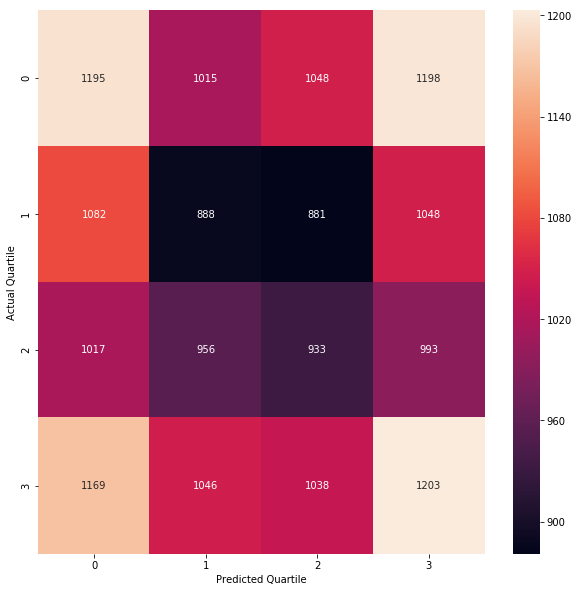

---
00:40:58 Running experiment 30 of 216
(100, 4, 0.001, 0.8)
00:40:58 Generate splits [140, 280, 419, 558, 697]
classify
00:40:58 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.355%
Monthly Sharpe ratio: 0.116
Avg rank correlation (Kendall's tau): 0.0046 (Expected: 0)
4-quartile accuracy: 0.2516 (Expected: 0.25)
Long/short/flat accuracy: 0.3641 (Expected: 0.375)


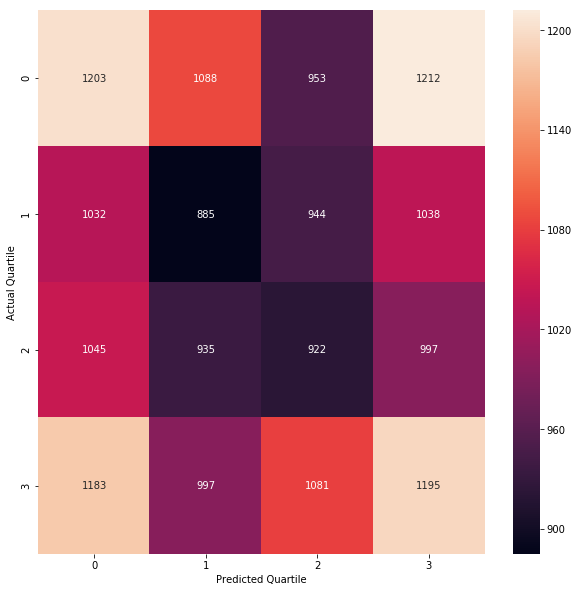

---
00:41:03 Running experiment 31 of 216
(100, 4, 0.0003, 0.6)
00:41:03 Generate splits [140, 280, 419, 558, 697]
classify
00:41:03 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.091%
Monthly Sharpe ratio: -0.006
Avg rank correlation (Kendall's tau): -0.0001 (Expected: 0)
4-quartile accuracy: 0.2499 (Expected: 0.25)
Long/short/flat accuracy: 0.3613 (Expected: 0.375)


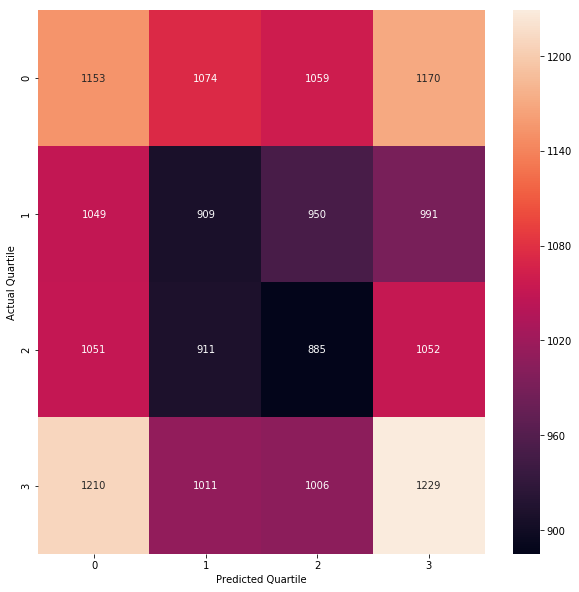

---
00:41:07 Running experiment 32 of 216
(100, 4, 0.0003, 0.7)
00:41:07 Generate splits [140, 280, 419, 558, 697]
classify
00:41:07 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.091%
Monthly Sharpe ratio: -0.006
Avg rank correlation (Kendall's tau): 0.0038 (Expected: 0)
4-quartile accuracy: 0.2502 (Expected: 0.25)
Long/short/flat accuracy: 0.3584 (Expected: 0.375)


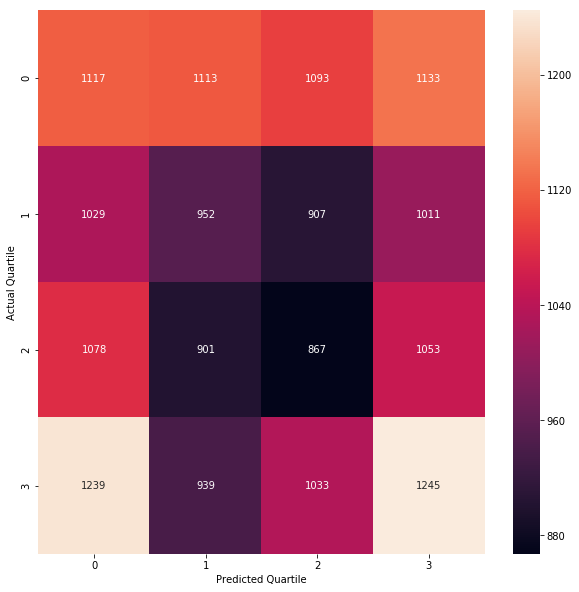

---
00:41:12 Running experiment 33 of 216
(100, 4, 0.0003, 0.8)
00:41:12 Generate splits [140, 280, 419, 558, 697]
classify
00:41:12 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.091%
Monthly Sharpe ratio: -0.006
Avg rank correlation (Kendall's tau): 0.0085 (Expected: 0)
4-quartile accuracy: 0.2540 (Expected: 0.25)
Long/short/flat accuracy: 0.3628 (Expected: 0.375)


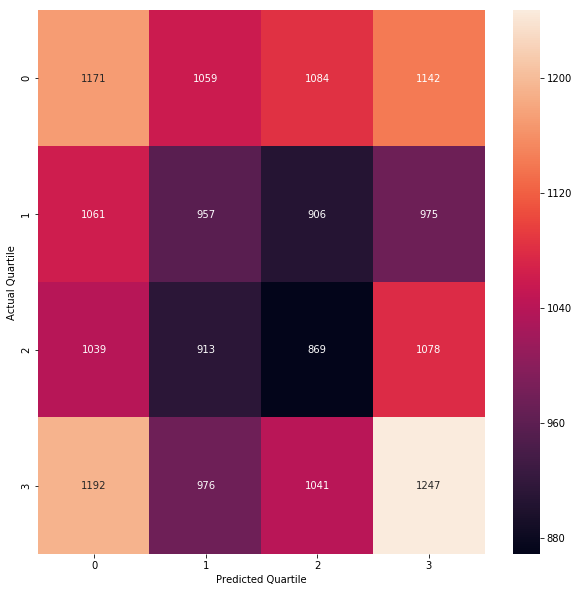

---
00:41:16 Running experiment 34 of 216
(100, 4, 0.0001, 0.6)
00:41:16 Generate splits [140, 280, 419, 558, 697]
classify
00:41:16 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): -0.0010 (Expected: 0)
4-quartile accuracy: 0.2521 (Expected: 0.25)
Long/short/flat accuracy: 0.3600 (Expected: 0.375)


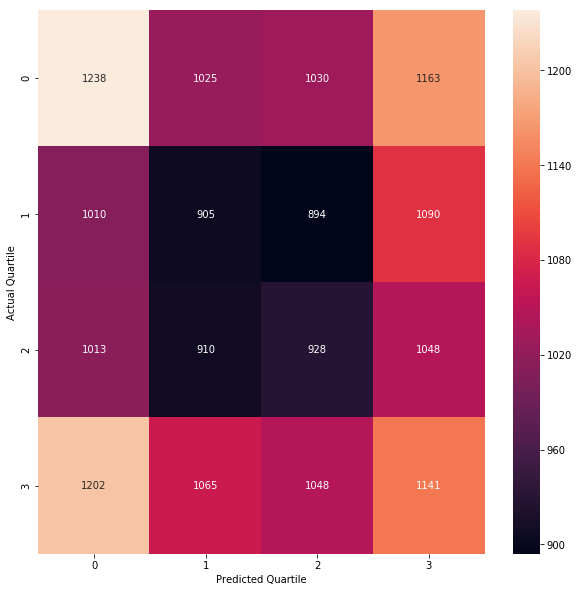

---
00:41:21 Running experiment 35 of 216
(100, 4, 0.0001, 0.7)
00:41:21 Generate splits [140, 280, 419, 558, 697]
classify
00:41:21 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): -0.0004 (Expected: 0)
4-quartile accuracy: 0.2528 (Expected: 0.25)
Long/short/flat accuracy: 0.3604 (Expected: 0.375)


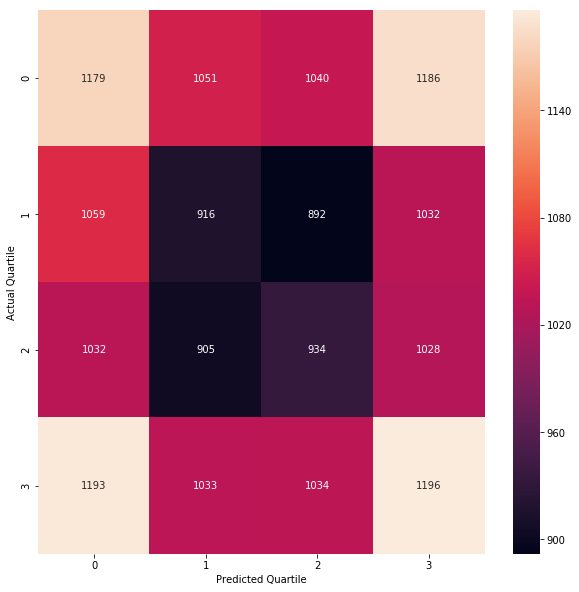

---
00:41:25 Running experiment 36 of 216
(100, 4, 0.0001, 0.8)
00:41:25 Generate splits [140, 280, 419, 558, 697]
classify
00:41:25 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): -0.0026 (Expected: 0)
4-quartile accuracy: 0.2481 (Expected: 0.25)
Long/short/flat accuracy: 0.3594 (Expected: 0.375)


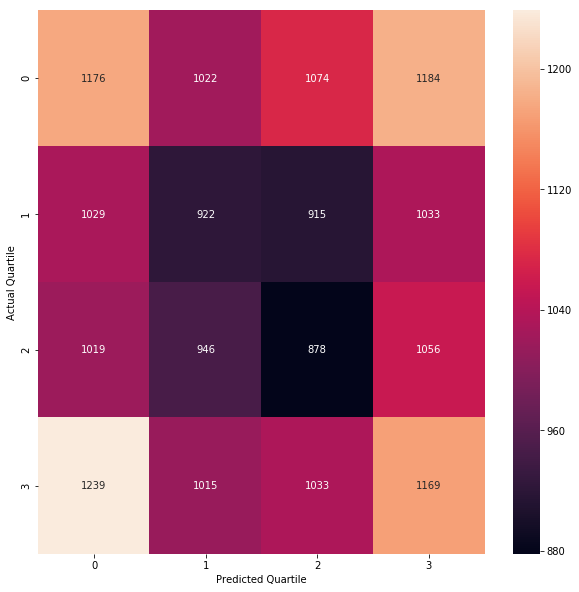

---
00:41:29 Running experiment 37 of 216
(100, 5, 0.03, 0.6)
00:41:29 Generate splits [140, 280, 419, 558, 697]
classify
00:41:29 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.178%
Monthly Sharpe ratio: 0.061
Avg rank correlation (Kendall's tau): 0.0077 (Expected: 0)
4-quartile accuracy: 0.2657 (Expected: 0.25)
Long/short/flat accuracy: 0.3795 (Expected: 0.375)


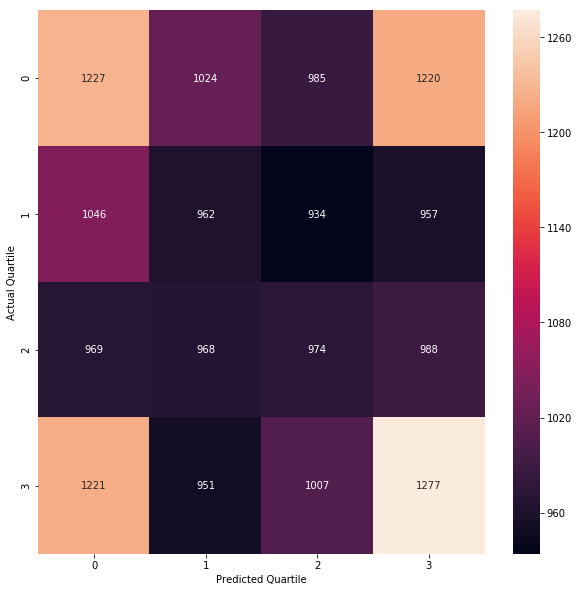

---
00:41:36 Running experiment 38 of 216
(100, 5, 0.03, 0.7)
00:41:36 Generate splits [140, 280, 419, 558, 697]
classify
00:41:36 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.574%
Monthly Sharpe ratio: 0.148
Avg rank correlation (Kendall's tau): 0.0036 (Expected: 0)
4-quartile accuracy: 0.2589 (Expected: 0.25)
Long/short/flat accuracy: 0.3701 (Expected: 0.375)


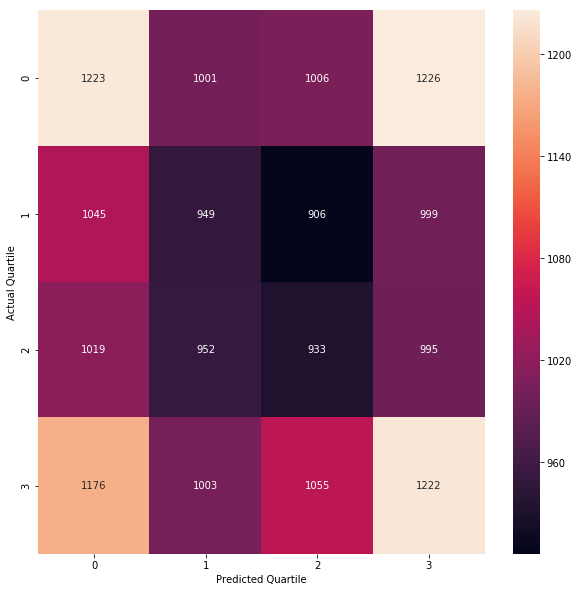

---
00:41:43 Running experiment 39 of 216
(100, 5, 0.03, 0.8)
00:41:43 Generate splits [140, 280, 419, 558, 697]
classify
00:41:43 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.043%
Monthly Sharpe ratio: 0.032
Avg rank correlation (Kendall's tau): 0.0052 (Expected: 0)
4-quartile accuracy: 0.2601 (Expected: 0.25)
Long/short/flat accuracy: 0.3752 (Expected: 0.375)


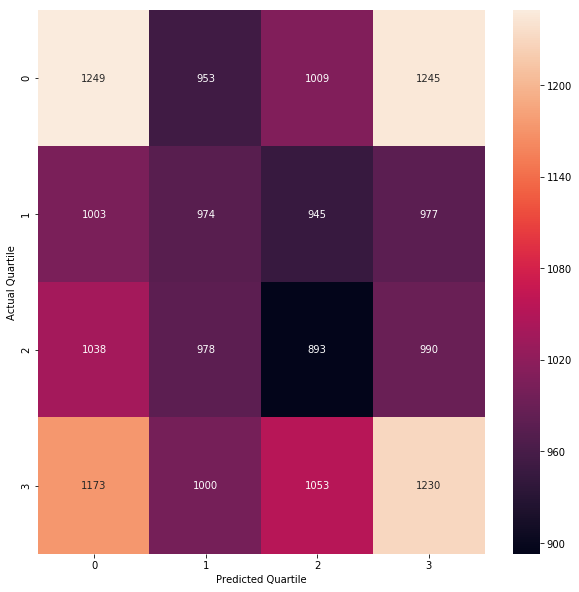

---
00:41:49 Running experiment 40 of 216
(100, 5, 0.01, 0.6)
00:41:49 Generate splits [140, 280, 419, 558, 697]
classify
00:41:49 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.721%
Monthly Sharpe ratio: -0.149
Avg rank correlation (Kendall's tau): -0.0095 (Expected: 0)
4-quartile accuracy: 0.2542 (Expected: 0.25)
Long/short/flat accuracy: 0.3655 (Expected: 0.375)


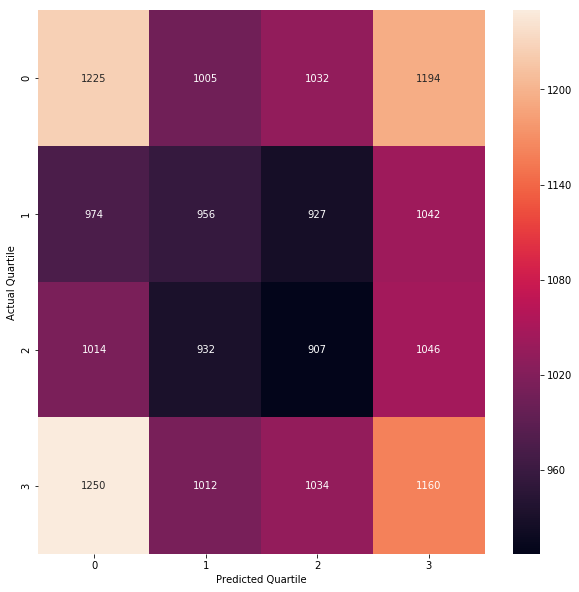

---
00:41:54 Running experiment 41 of 216
(100, 5, 0.01, 0.7)
00:41:54 Generate splits [140, 280, 419, 558, 697]
classify
00:41:54 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.155%
Monthly Sharpe ratio: 0.058
Avg rank correlation (Kendall's tau): 0.0052 (Expected: 0)
4-quartile accuracy: 0.2609 (Expected: 0.25)
Long/short/flat accuracy: 0.3737 (Expected: 0.375)


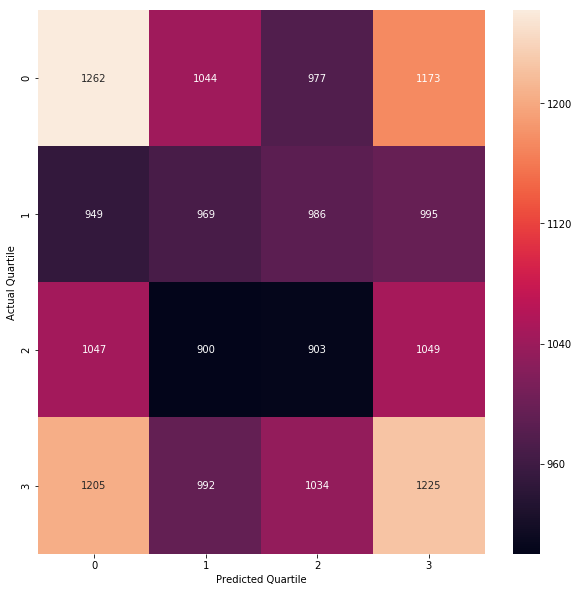

---
00:41:58 Running experiment 42 of 216
(100, 5, 0.01, 0.8)
00:41:58 Generate splits [140, 280, 419, 558, 697]
classify
00:41:58 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.153%
Monthly Sharpe ratio: -0.016
Avg rank correlation (Kendall's tau): -0.0023 (Expected: 0)
4-quartile accuracy: 0.2594 (Expected: 0.25)
Long/short/flat accuracy: 0.3698 (Expected: 0.375)


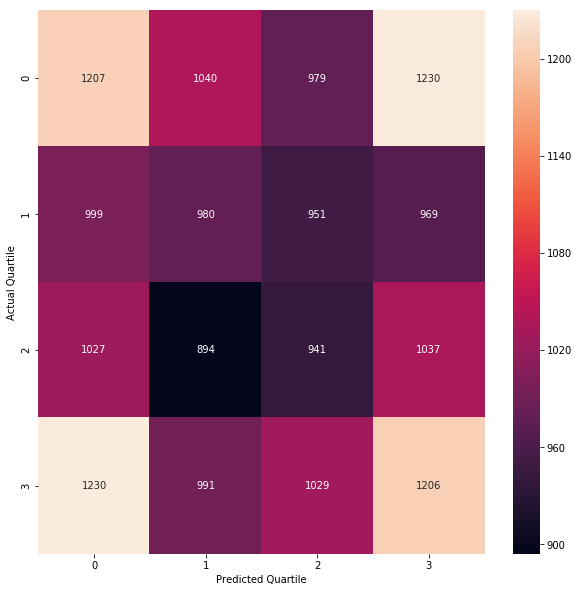

---
00:42:03 Running experiment 43 of 216
(100, 5, 0.003, 0.6)
00:42:03 Generate splits [140, 280, 419, 558, 697]
classify
00:42:03 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.781%
Monthly Sharpe ratio: -0.166
Avg rank correlation (Kendall's tau): -0.0053 (Expected: 0)
4-quartile accuracy: 0.2475 (Expected: 0.25)
Long/short/flat accuracy: 0.3569 (Expected: 0.375)


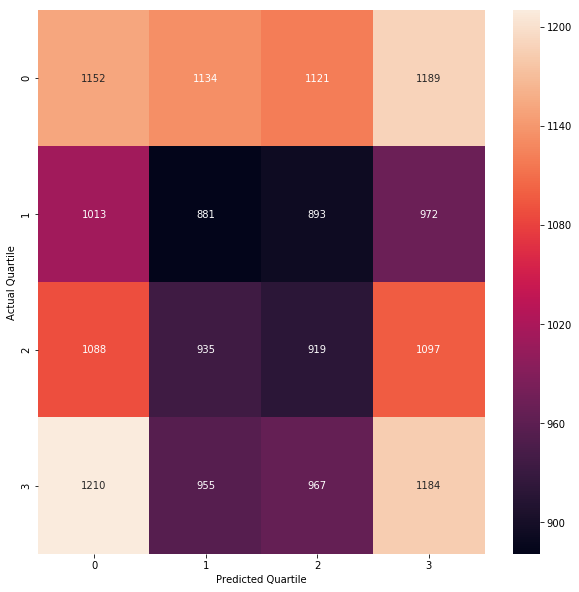

---
00:42:08 Running experiment 44 of 216
(100, 5, 0.003, 0.7)
00:42:08 Generate splits [140, 280, 419, 558, 697]
classify
00:42:08 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.660%
Monthly Sharpe ratio: -0.149
Avg rank correlation (Kendall's tau): -0.0045 (Expected: 0)
4-quartile accuracy: 0.2463 (Expected: 0.25)
Long/short/flat accuracy: 0.3588 (Expected: 0.375)


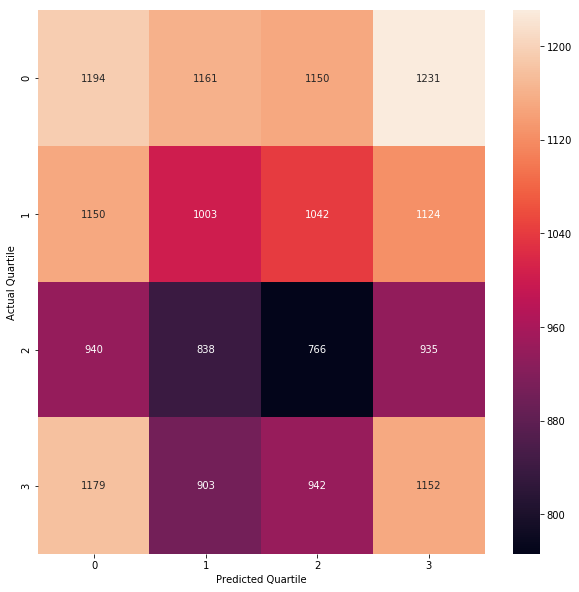

---
00:42:12 Running experiment 45 of 216
(100, 5, 0.003, 0.8)
00:42:12 Generate splits [140, 280, 419, 558, 697]
classify
00:42:12 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.653%
Monthly Sharpe ratio: -0.150
Avg rank correlation (Kendall's tau): -0.0037 (Expected: 0)
4-quartile accuracy: 0.2533 (Expected: 0.25)
Long/short/flat accuracy: 0.3665 (Expected: 0.375)


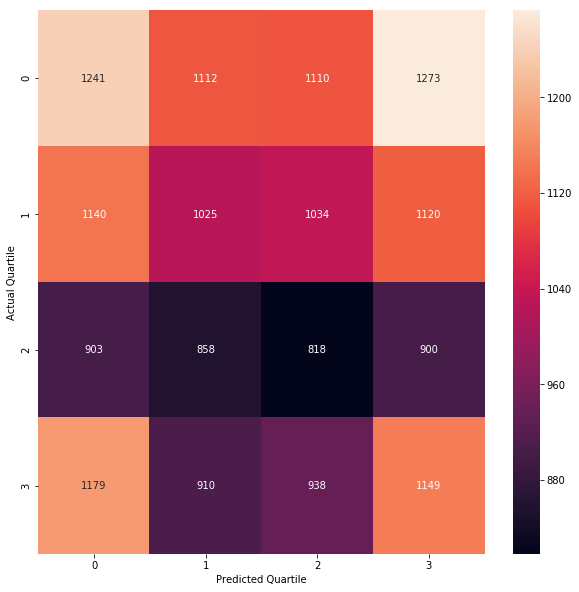

---
00:42:17 Running experiment 46 of 216
(100, 5, 0.001, 0.6)
00:42:17 Generate splits [140, 280, 419, 558, 697]
classify
00:42:17 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.297%
Monthly Sharpe ratio: 0.105
Avg rank correlation (Kendall's tau): 0.0027 (Expected: 0)
4-quartile accuracy: 0.2575 (Expected: 0.25)
Long/short/flat accuracy: 0.3656 (Expected: 0.375)


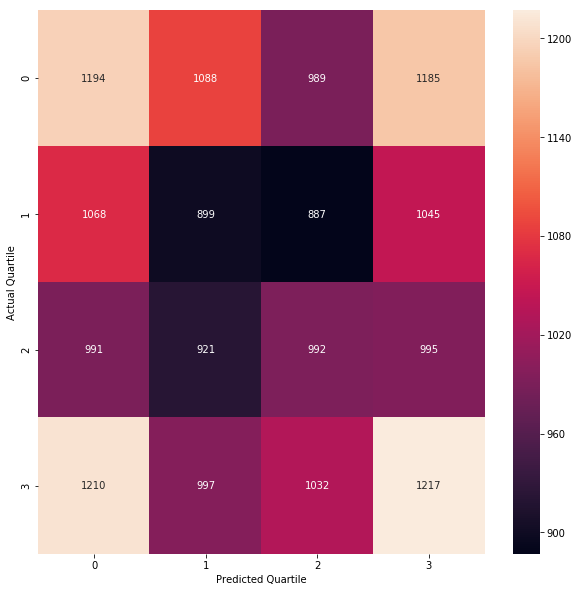

---
00:42:21 Running experiment 47 of 216
(100, 5, 0.001, 0.7)
00:42:21 Generate splits [140, 280, 419, 558, 697]
classify
00:42:21 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.355%
Monthly Sharpe ratio: 0.116
Avg rank correlation (Kendall's tau): 0.0066 (Expected: 0)
4-quartile accuracy: 0.2555 (Expected: 0.25)
Long/short/flat accuracy: 0.3687 (Expected: 0.375)


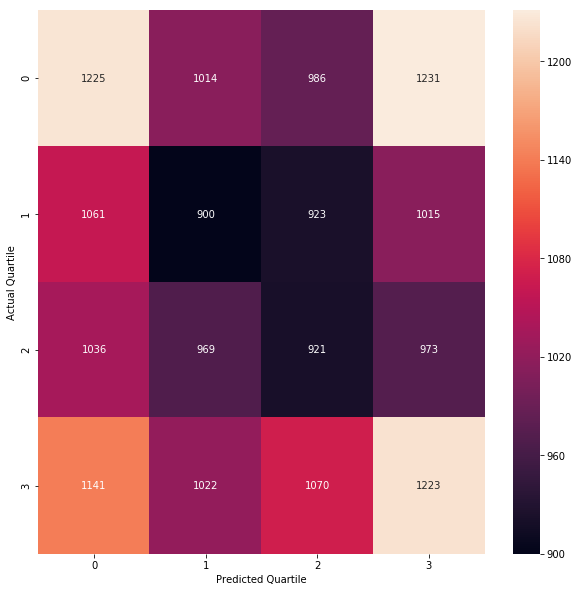

---
00:42:26 Running experiment 48 of 216
(100, 5, 0.001, 0.8)
00:42:26 Generate splits [140, 280, 419, 558, 697]
classify
00:42:26 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.355%
Monthly Sharpe ratio: 0.116
Avg rank correlation (Kendall's tau): 0.0043 (Expected: 0)
4-quartile accuracy: 0.2557 (Expected: 0.25)
Long/short/flat accuracy: 0.3637 (Expected: 0.375)


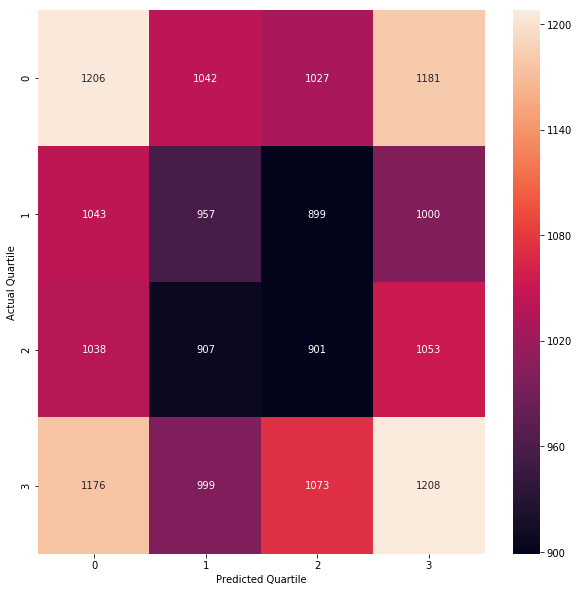

---
00:42:30 Running experiment 49 of 216
(100, 5, 0.0003, 0.6)
00:42:30 Generate splits [140, 280, 419, 558, 697]
classify
00:42:30 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.091%
Monthly Sharpe ratio: -0.006
Avg rank correlation (Kendall's tau): -0.0023 (Expected: 0)
4-quartile accuracy: 0.2510 (Expected: 0.25)
Long/short/flat accuracy: 0.3607 (Expected: 0.375)


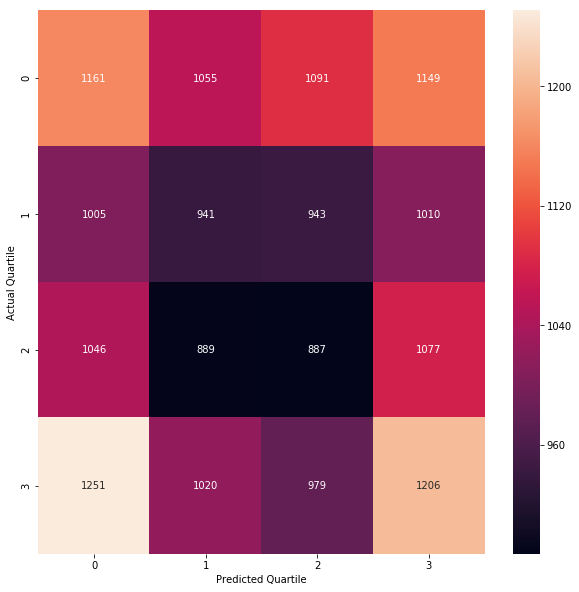

---
00:42:35 Running experiment 50 of 216
(100, 5, 0.0003, 0.7)
00:42:35 Generate splits [140, 280, 419, 558, 697]
classify
00:42:35 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.091%
Monthly Sharpe ratio: -0.006
Avg rank correlation (Kendall's tau): 0.0059 (Expected: 0)
4-quartile accuracy: 0.2521 (Expected: 0.25)
Long/short/flat accuracy: 0.3604 (Expected: 0.375)


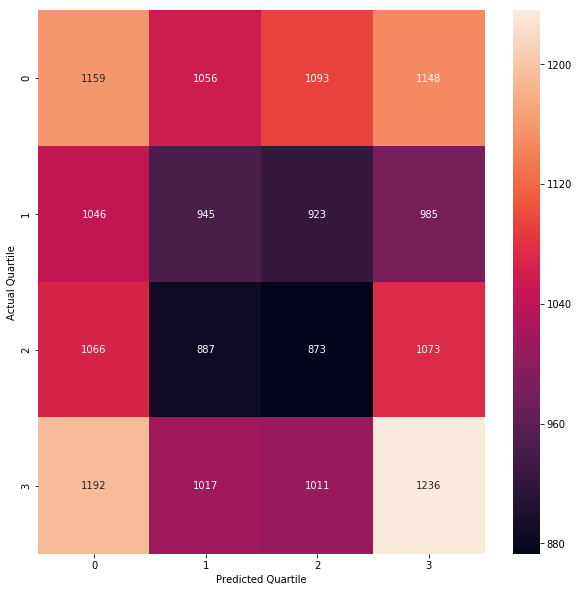

---
00:42:39 Running experiment 51 of 216
(100, 5, 0.0003, 0.8)
00:42:39 Generate splits [140, 280, 419, 558, 697]
classify
00:42:39 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.091%
Monthly Sharpe ratio: -0.006
Avg rank correlation (Kendall's tau): -0.0057 (Expected: 0)
4-quartile accuracy: 0.2418 (Expected: 0.25)
Long/short/flat accuracy: 0.3487 (Expected: 0.375)


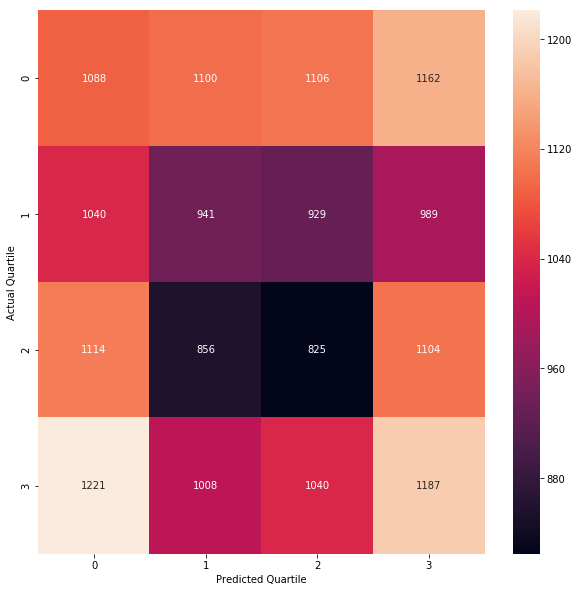

---
00:42:44 Running experiment 52 of 216
(100, 5, 0.0001, 0.6)
00:42:44 Generate splits [140, 280, 419, 558, 697]
classify
00:42:44 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): -0.0075 (Expected: 0)
4-quartile accuracy: 0.2461 (Expected: 0.25)
Long/short/flat accuracy: 0.3580 (Expected: 0.375)


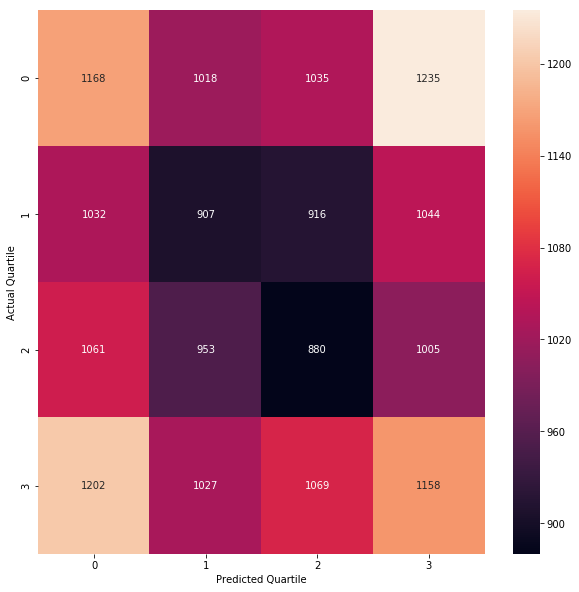

---
00:42:48 Running experiment 53 of 216
(100, 5, 0.0001, 0.7)
00:42:48 Generate splits [140, 280, 419, 558, 697]
classify
00:42:48 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): -0.0034 (Expected: 0)
4-quartile accuracy: 0.2480 (Expected: 0.25)
Long/short/flat accuracy: 0.3587 (Expected: 0.375)


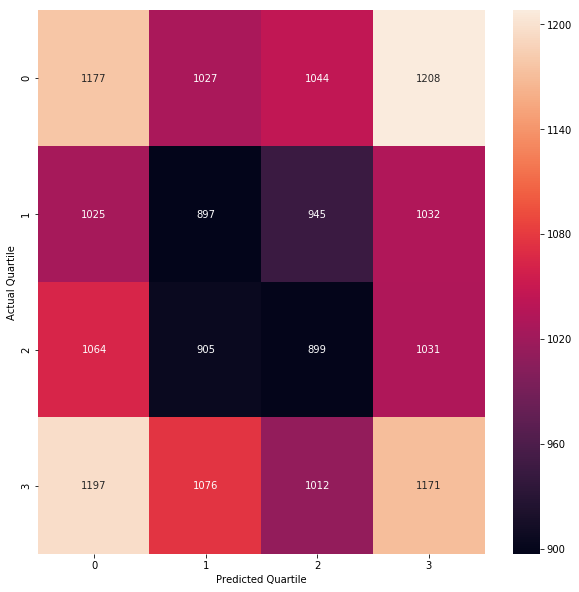

---
00:42:52 Running experiment 54 of 216
(100, 5, 0.0001, 0.8)
00:42:52 Generate splits [140, 280, 419, 558, 697]
classify
00:42:52 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): -0.0027 (Expected: 0)
4-quartile accuracy: 0.2539 (Expected: 0.25)
Long/short/flat accuracy: 0.3701 (Expected: 0.375)


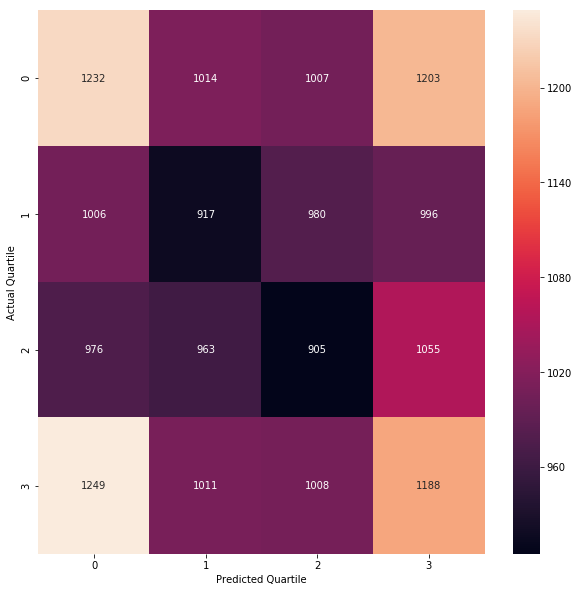

---
00:42:57 Running experiment 55 of 216
(100, 6, 0.03, 0.6)
00:42:57 Generate splits [140, 280, 419, 558, 697]
classify
00:42:57 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.178%
Monthly Sharpe ratio: 0.061
Avg rank correlation (Kendall's tau): 0.0077 (Expected: 0)
4-quartile accuracy: 0.2657 (Expected: 0.25)
Long/short/flat accuracy: 0.3795 (Expected: 0.375)


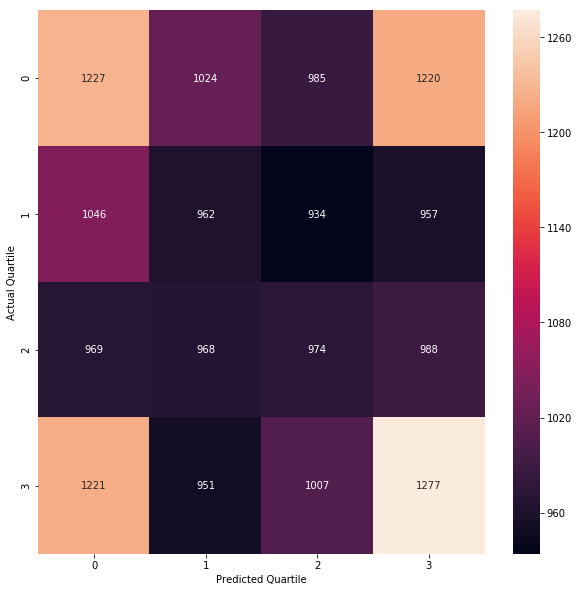

---
00:43:03 Running experiment 56 of 216
(100, 6, 0.03, 0.7)
00:43:03 Generate splits [140, 280, 419, 558, 697]
classify
00:43:03 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.574%
Monthly Sharpe ratio: 0.148
Avg rank correlation (Kendall's tau): 0.0036 (Expected: 0)
4-quartile accuracy: 0.2589 (Expected: 0.25)
Long/short/flat accuracy: 0.3701 (Expected: 0.375)


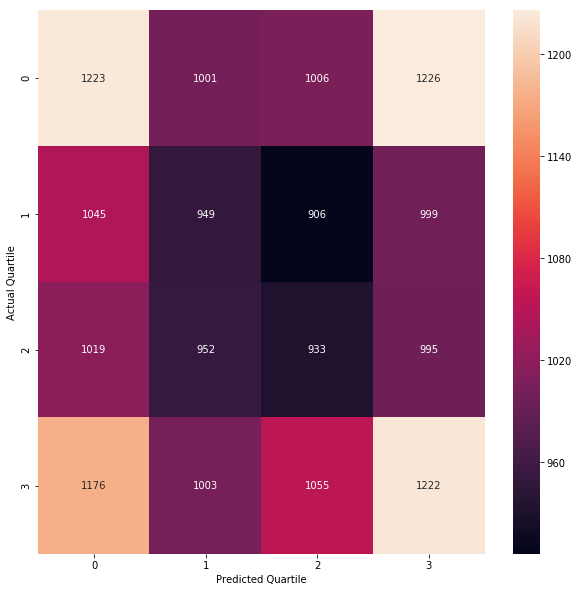

---
00:43:10 Running experiment 57 of 216
(100, 6, 0.03, 0.8)
00:43:10 Generate splits [140, 280, 419, 558, 697]
classify
00:43:10 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.043%
Monthly Sharpe ratio: 0.032
Avg rank correlation (Kendall's tau): 0.0052 (Expected: 0)
4-quartile accuracy: 0.2601 (Expected: 0.25)
Long/short/flat accuracy: 0.3752 (Expected: 0.375)


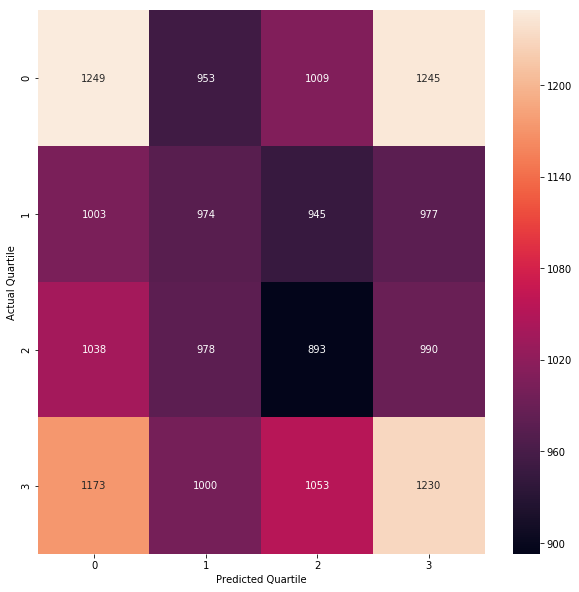

---
00:43:16 Running experiment 58 of 216
(100, 6, 0.01, 0.6)
00:43:16 Generate splits [140, 280, 419, 558, 697]
classify
00:43:16 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.721%
Monthly Sharpe ratio: -0.149
Avg rank correlation (Kendall's tau): -0.0095 (Expected: 0)
4-quartile accuracy: 0.2542 (Expected: 0.25)
Long/short/flat accuracy: 0.3655 (Expected: 0.375)


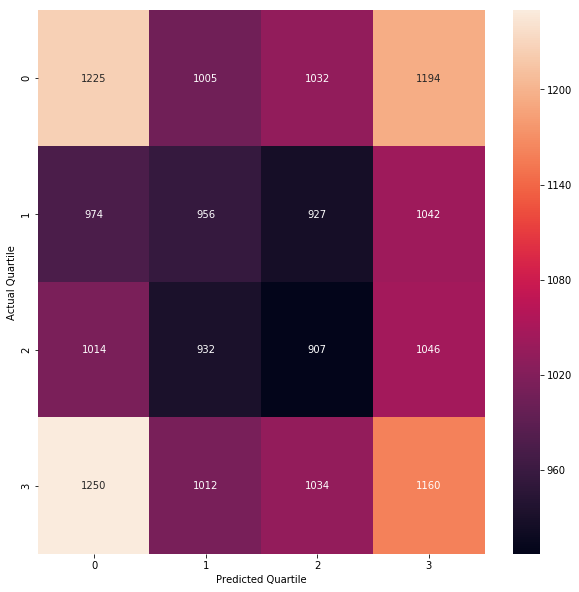

---
00:43:21 Running experiment 59 of 216
(100, 6, 0.01, 0.7)
00:43:21 Generate splits [140, 280, 419, 558, 697]
classify
00:43:21 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.155%
Monthly Sharpe ratio: 0.058
Avg rank correlation (Kendall's tau): 0.0052 (Expected: 0)
4-quartile accuracy: 0.2609 (Expected: 0.25)
Long/short/flat accuracy: 0.3737 (Expected: 0.375)


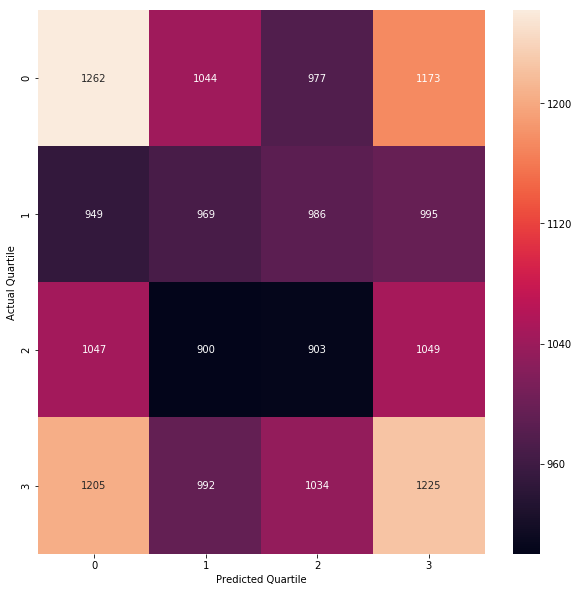

---
00:43:26 Running experiment 60 of 216
(100, 6, 0.01, 0.8)
00:43:26 Generate splits [140, 280, 419, 558, 697]
classify
00:43:26 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.153%
Monthly Sharpe ratio: -0.016
Avg rank correlation (Kendall's tau): -0.0023 (Expected: 0)
4-quartile accuracy: 0.2594 (Expected: 0.25)
Long/short/flat accuracy: 0.3698 (Expected: 0.375)


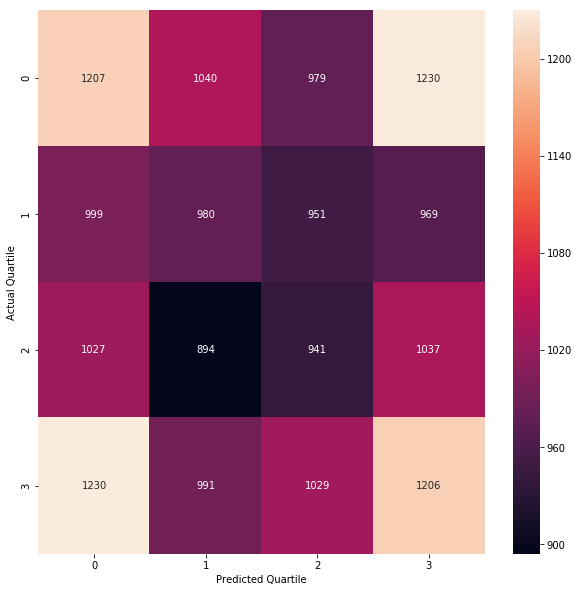

---
00:43:31 Running experiment 61 of 216
(100, 6, 0.003, 0.6)
00:43:31 Generate splits [140, 280, 419, 558, 697]
classify
00:43:31 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.781%
Monthly Sharpe ratio: -0.166
Avg rank correlation (Kendall's tau): -0.0053 (Expected: 0)
4-quartile accuracy: 0.2475 (Expected: 0.25)
Long/short/flat accuracy: 0.3569 (Expected: 0.375)


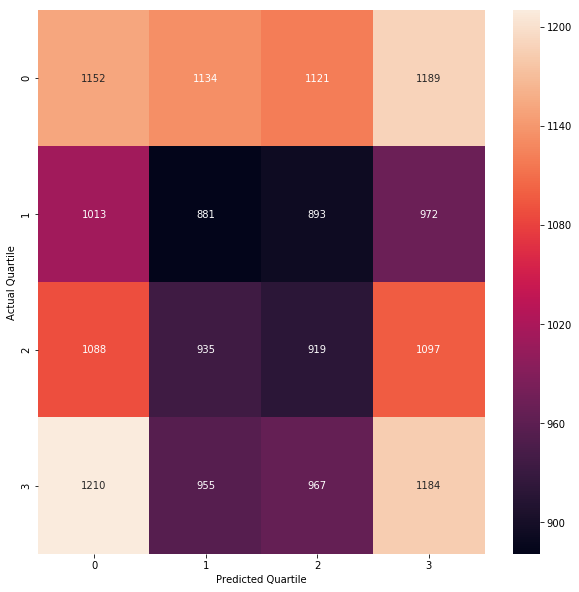

---
00:43:35 Running experiment 62 of 216
(100, 6, 0.003, 0.7)
00:43:35 Generate splits [140, 280, 419, 558, 697]
classify
00:43:35 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.660%
Monthly Sharpe ratio: -0.149
Avg rank correlation (Kendall's tau): -0.0045 (Expected: 0)
4-quartile accuracy: 0.2463 (Expected: 0.25)
Long/short/flat accuracy: 0.3588 (Expected: 0.375)


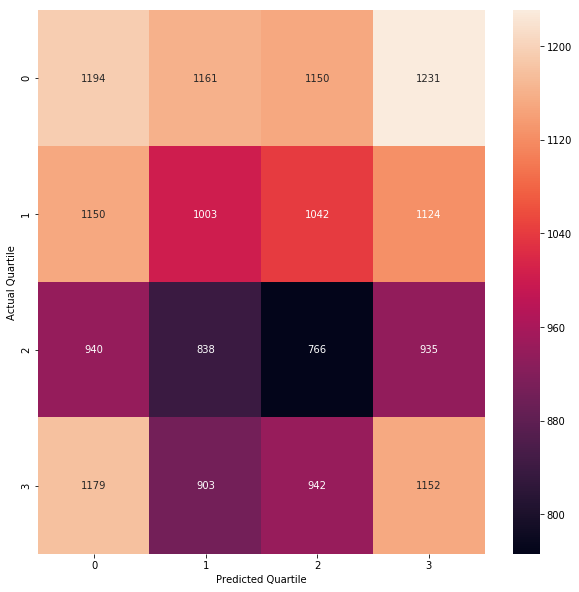

---
00:43:40 Running experiment 63 of 216
(100, 6, 0.003, 0.8)
00:43:40 Generate splits [140, 280, 419, 558, 697]
classify
00:43:40 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.653%
Monthly Sharpe ratio: -0.150
Avg rank correlation (Kendall's tau): -0.0037 (Expected: 0)
4-quartile accuracy: 0.2533 (Expected: 0.25)
Long/short/flat accuracy: 0.3665 (Expected: 0.375)


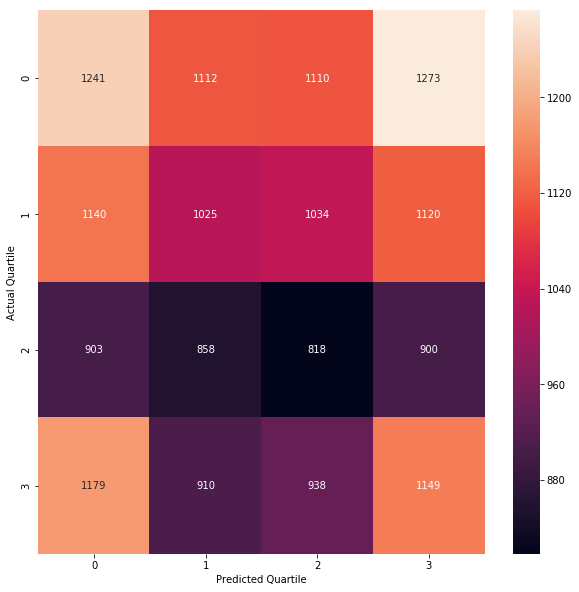

---
00:43:44 Running experiment 64 of 216
(100, 6, 0.001, 0.6)
00:43:44 Generate splits [140, 280, 419, 558, 697]
classify
00:43:44 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.297%
Monthly Sharpe ratio: 0.105
Avg rank correlation (Kendall's tau): 0.0038 (Expected: 0)
4-quartile accuracy: 0.2529 (Expected: 0.25)
Long/short/flat accuracy: 0.3646 (Expected: 0.375)


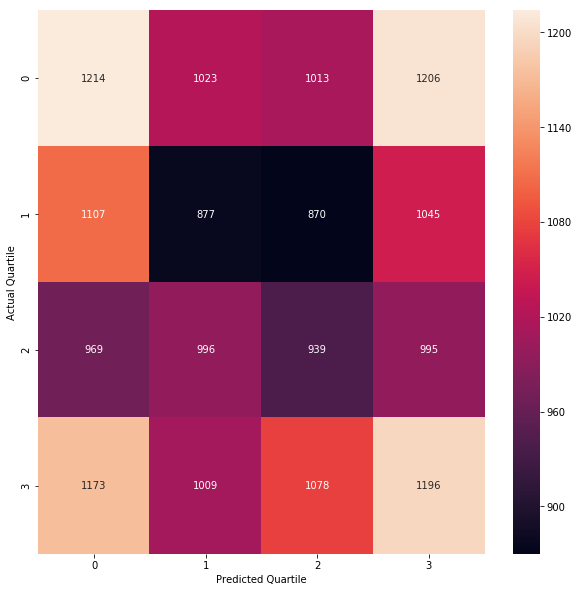

---
00:43:48 Running experiment 65 of 216
(100, 6, 0.001, 0.7)
00:43:48 Generate splits [140, 280, 419, 558, 697]
classify
00:43:48 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.355%
Monthly Sharpe ratio: 0.116
Avg rank correlation (Kendall's tau): 0.0014 (Expected: 0)
4-quartile accuracy: 0.2565 (Expected: 0.25)
Long/short/flat accuracy: 0.3658 (Expected: 0.375)


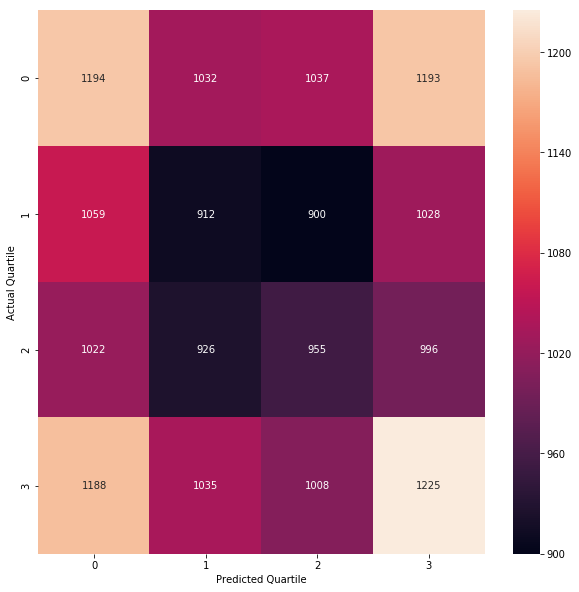

---
00:43:53 Running experiment 66 of 216
(100, 6, 0.001, 0.8)
00:43:53 Generate splits [140, 280, 419, 558, 697]
classify
00:43:53 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.355%
Monthly Sharpe ratio: 0.116
Avg rank correlation (Kendall's tau): 0.0060 (Expected: 0)
4-quartile accuracy: 0.2555 (Expected: 0.25)
Long/short/flat accuracy: 0.3652 (Expected: 0.375)


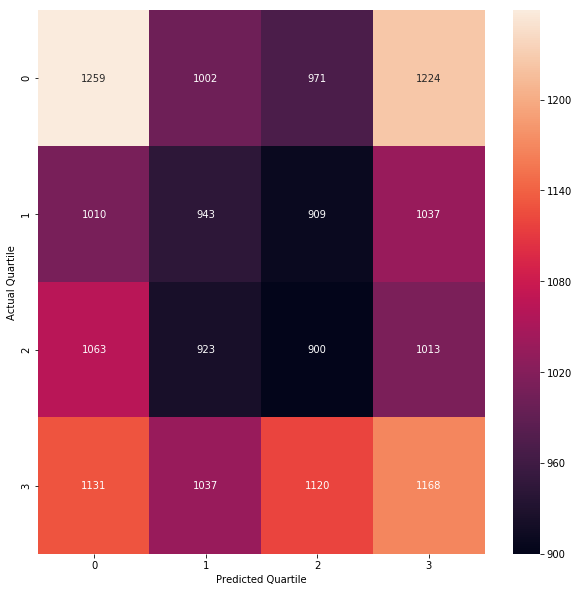

---
00:43:57 Running experiment 67 of 216
(100, 6, 0.0003, 0.6)
00:43:57 Generate splits [140, 280, 419, 558, 697]
classify
00:43:57 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.091%
Monthly Sharpe ratio: -0.006
Avg rank correlation (Kendall's tau): 0.0021 (Expected: 0)
4-quartile accuracy: 0.2544 (Expected: 0.25)
Long/short/flat accuracy: 0.3646 (Expected: 0.375)


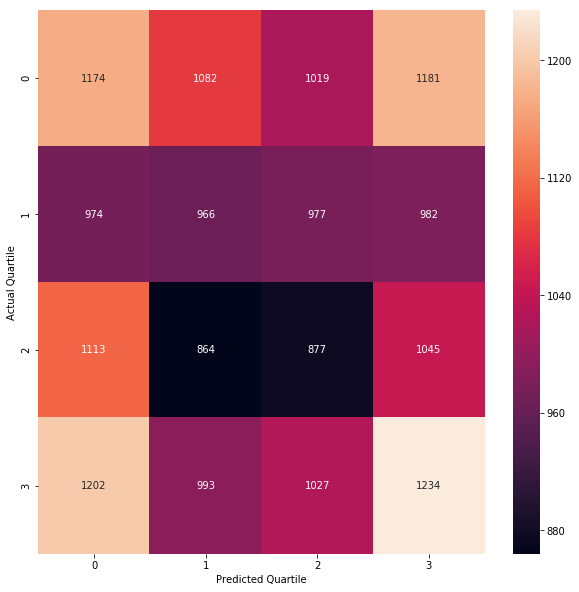

---
00:44:02 Running experiment 68 of 216
(100, 6, 0.0003, 0.7)
00:44:02 Generate splits [140, 280, 419, 558, 697]
classify
00:44:02 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.091%
Monthly Sharpe ratio: -0.006
Avg rank correlation (Kendall's tau): 0.0036 (Expected: 0)
4-quartile accuracy: 0.2491 (Expected: 0.25)
Long/short/flat accuracy: 0.3578 (Expected: 0.375)


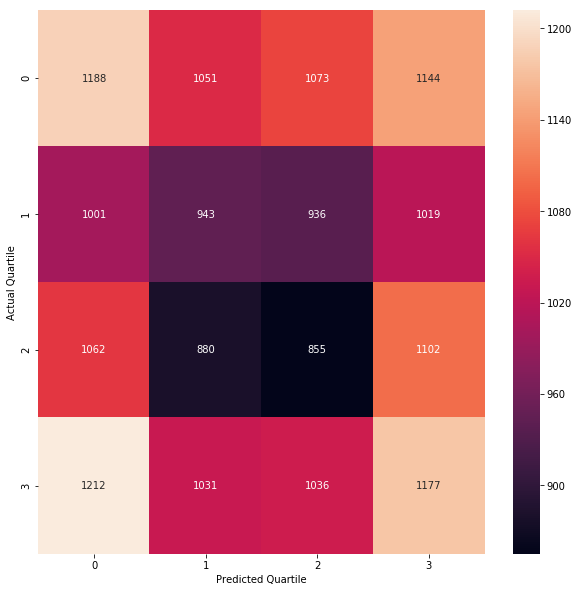

---
00:44:06 Running experiment 69 of 216
(100, 6, 0.0003, 0.8)
00:44:06 Generate splits [140, 280, 419, 558, 697]
classify
00:44:06 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.091%
Monthly Sharpe ratio: -0.006
Avg rank correlation (Kendall's tau): 0.0012 (Expected: 0)
4-quartile accuracy: 0.2531 (Expected: 0.25)
Long/short/flat accuracy: 0.3650 (Expected: 0.375)


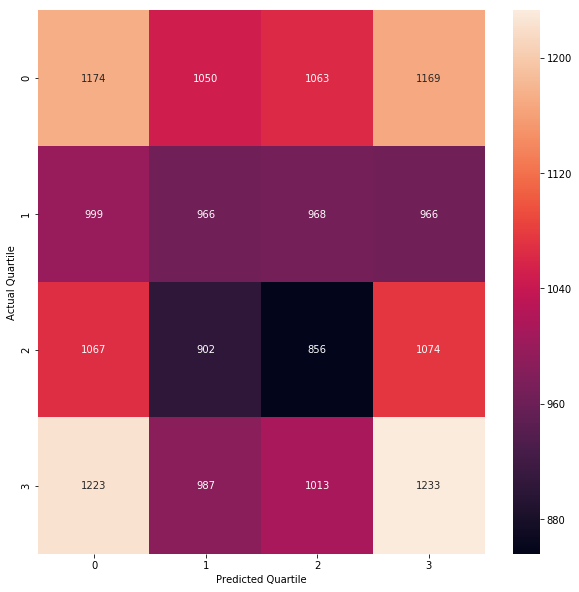

---
00:44:11 Running experiment 70 of 216
(100, 6, 0.0001, 0.6)
00:44:11 Generate splits [140, 280, 419, 558, 697]
classify
00:44:11 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): -0.0031 (Expected: 0)
4-quartile accuracy: 0.2460 (Expected: 0.25)
Long/short/flat accuracy: 0.3551 (Expected: 0.375)


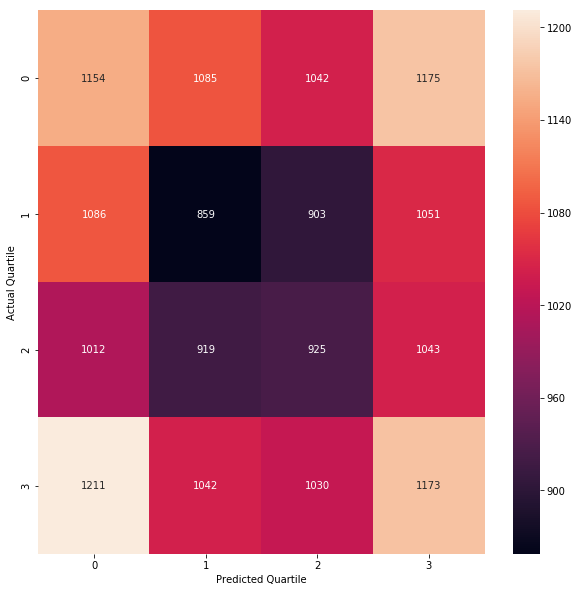

---
00:44:15 Running experiment 71 of 216
(100, 6, 0.0001, 0.7)
00:44:15 Generate splits [140, 280, 419, 558, 697]
classify
00:44:15 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): -0.0050 (Expected: 0)
4-quartile accuracy: 0.2563 (Expected: 0.25)
Long/short/flat accuracy: 0.3640 (Expected: 0.375)


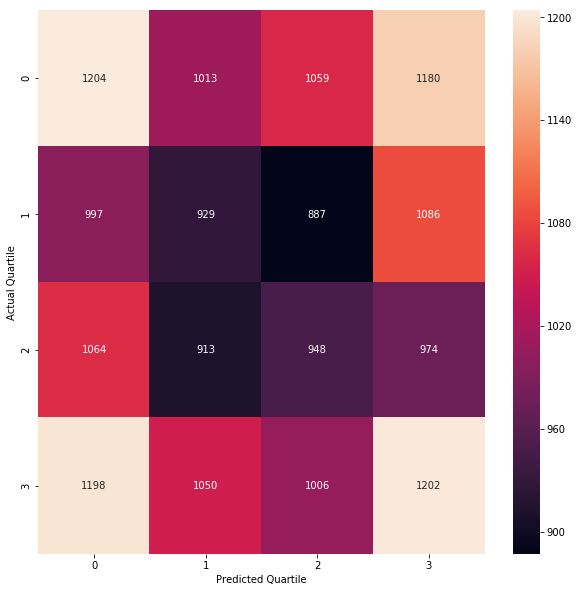

---
00:44:20 Running experiment 72 of 216
(100, 6, 0.0001, 0.8)
00:44:20 Generate splits [140, 280, 419, 558, 697]
classify
00:44:20 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): 0.0103 (Expected: 0)
4-quartile accuracy: 0.2556 (Expected: 0.25)
Long/short/flat accuracy: 0.3636 (Expected: 0.375)


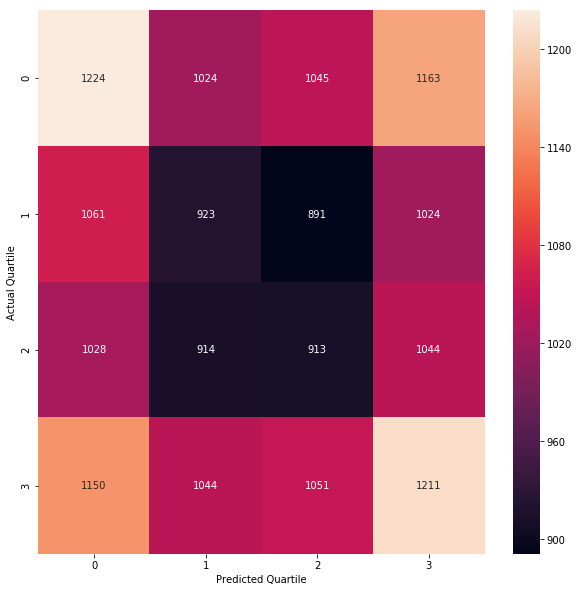

---
00:44:24 Running experiment 73 of 216
(300, 3, 0.03, 0.6)
00:44:24 Generate splits [140, 280, 419, 558, 697]
classify
00:44:24 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 1.511%
Monthly Sharpe ratio: 0.347
Avg rank correlation (Kendall's tau): 0.0180 (Expected: 0)
4-quartile accuracy: 0.2649 (Expected: 0.25)
Long/short/flat accuracy: 0.3780 (Expected: 0.375)


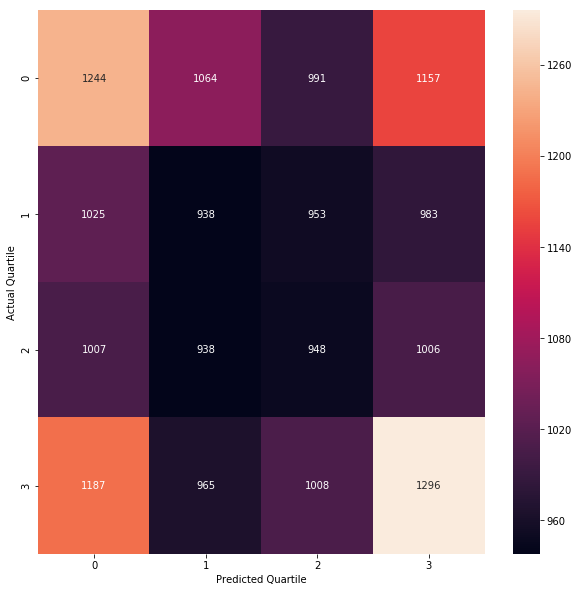

---
00:44:40 Running experiment 74 of 216
(300, 3, 0.03, 0.7)
00:44:40 Generate splits [140, 280, 419, 558, 697]
classify
00:44:40 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.684%
Monthly Sharpe ratio: 0.174
Avg rank correlation (Kendall's tau): 0.0068 (Expected: 0)
4-quartile accuracy: 0.2591 (Expected: 0.25)
Long/short/flat accuracy: 0.3709 (Expected: 0.375)


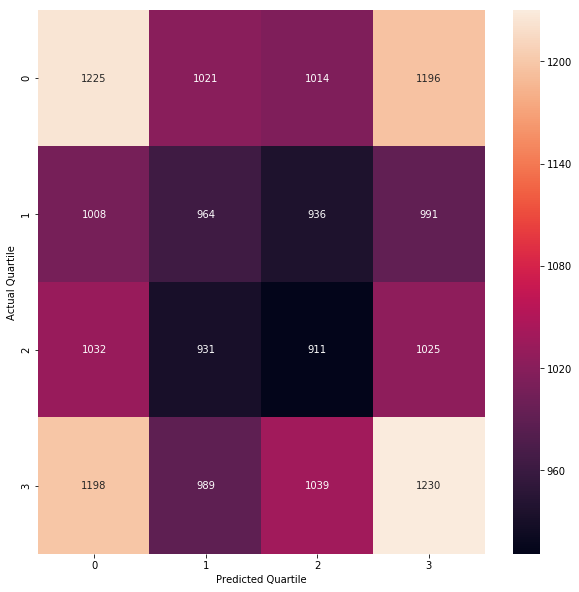

---
00:44:56 Running experiment 75 of 216
(300, 3, 0.03, 0.8)
00:44:56 Generate splits [140, 280, 419, 558, 697]
classify
00:44:56 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.604%
Monthly Sharpe ratio: 0.150
Avg rank correlation (Kendall's tau): 0.0024 (Expected: 0)
4-quartile accuracy: 0.2598 (Expected: 0.25)
Long/short/flat accuracy: 0.3698 (Expected: 0.375)


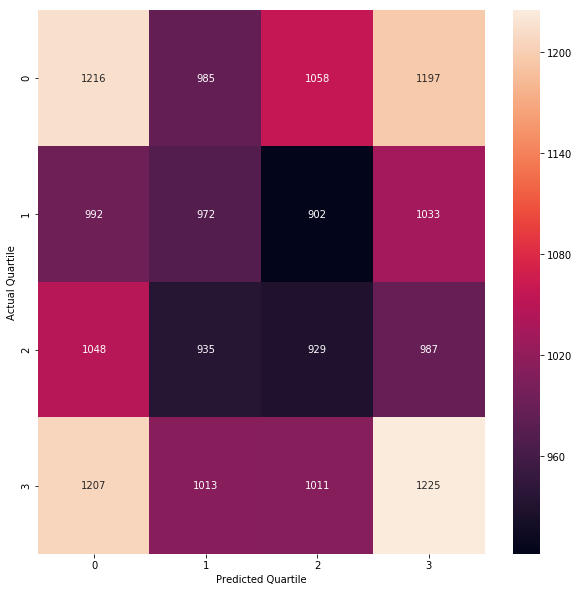

---
00:45:11 Running experiment 76 of 216
(300, 3, 0.01, 0.6)
00:45:11 Generate splits [140, 280, 419, 558, 697]
classify
00:45:11 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.042%
Monthly Sharpe ratio: 0.013
Avg rank correlation (Kendall's tau): 0.0033 (Expected: 0)
4-quartile accuracy: 0.2560 (Expected: 0.25)
Long/short/flat accuracy: 0.3698 (Expected: 0.375)


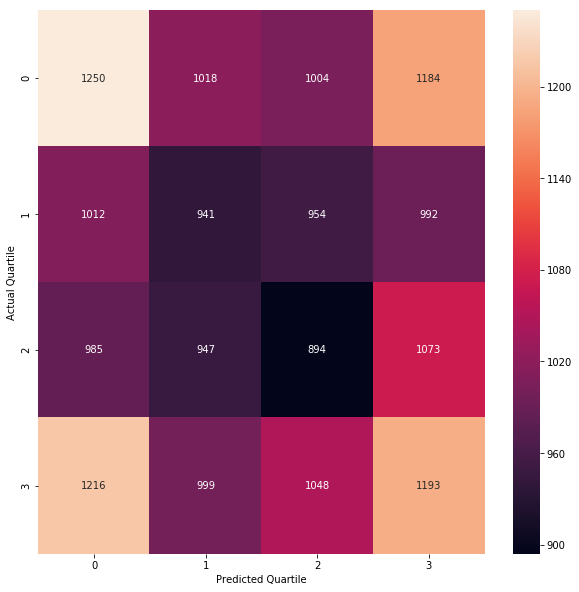

---
00:45:23 Running experiment 77 of 216
(300, 3, 0.01, 0.7)
00:45:23 Generate splits [140, 280, 419, 558, 697]
classify
00:45:23 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.367%
Monthly Sharpe ratio: -0.051
Avg rank correlation (Kendall's tau): 0.0028 (Expected: 0)
4-quartile accuracy: 0.2548 (Expected: 0.25)
Long/short/flat accuracy: 0.3685 (Expected: 0.375)


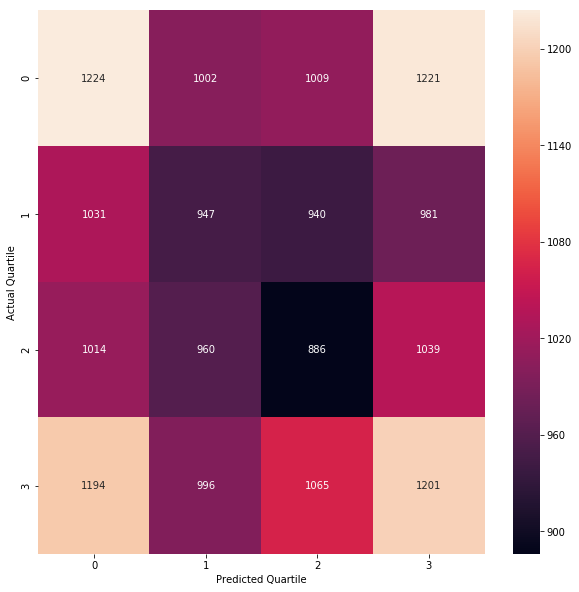

---
00:45:35 Running experiment 78 of 216
(300, 3, 0.01, 0.8)
00:45:35 Generate splits [140, 280, 419, 558, 697]
classify
00:45:35 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.173%
Monthly Sharpe ratio: 0.059
Avg rank correlation (Kendall's tau): -0.0014 (Expected: 0)
4-quartile accuracy: 0.2573 (Expected: 0.25)
Long/short/flat accuracy: 0.3694 (Expected: 0.375)


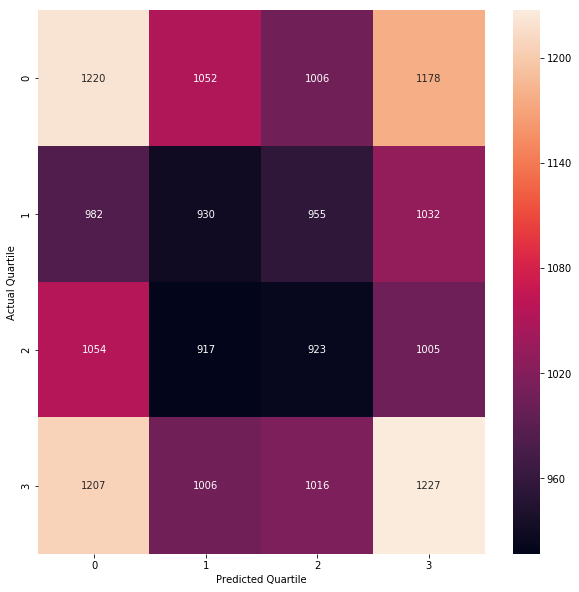

---
00:45:47 Running experiment 79 of 216
(300, 3, 0.003, 0.6)
00:45:47 Generate splits [140, 280, 419, 558, 697]
classify
00:45:47 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.939%
Monthly Sharpe ratio: 0.256
Avg rank correlation (Kendall's tau): 0.0071 (Expected: 0)
4-quartile accuracy: 0.2671 (Expected: 0.25)
Long/short/flat accuracy: 0.3858 (Expected: 0.375)


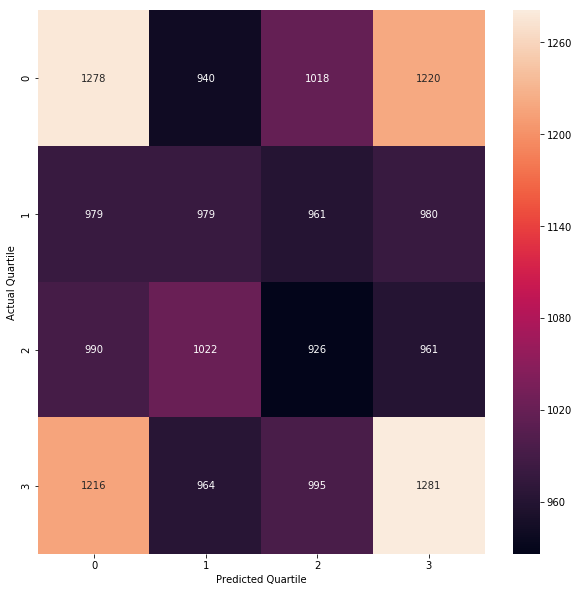

---
00:45:59 Running experiment 80 of 216
(300, 3, 0.003, 0.7)
00:45:59 Generate splits [140, 280, 419, 558, 697]
classify
00:45:59 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.916%
Monthly Sharpe ratio: 0.243
Avg rank correlation (Kendall's tau): 0.0045 (Expected: 0)
4-quartile accuracy: 0.2597 (Expected: 0.25)
Long/short/flat accuracy: 0.3764 (Expected: 0.375)


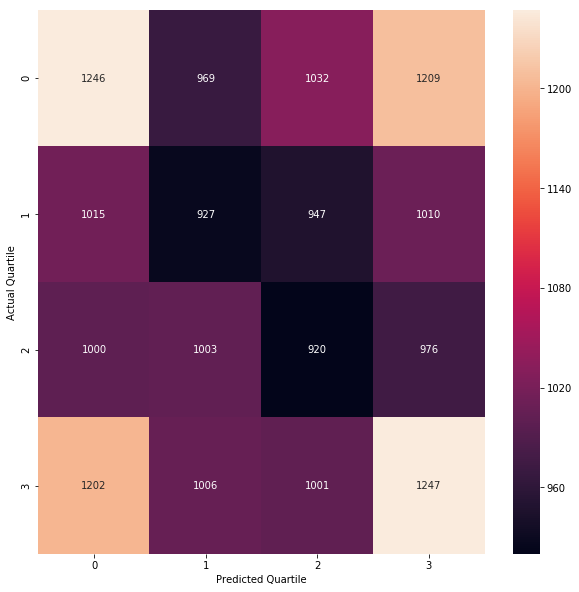

---
00:46:10 Running experiment 81 of 216
(300, 3, 0.003, 0.8)
00:46:10 Generate splits [140, 280, 419, 558, 697]
classify
00:46:10 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.902%
Monthly Sharpe ratio: 0.242
Avg rank correlation (Kendall's tau): 0.0061 (Expected: 0)
4-quartile accuracy: 0.2589 (Expected: 0.25)
Long/short/flat accuracy: 0.3733 (Expected: 0.375)


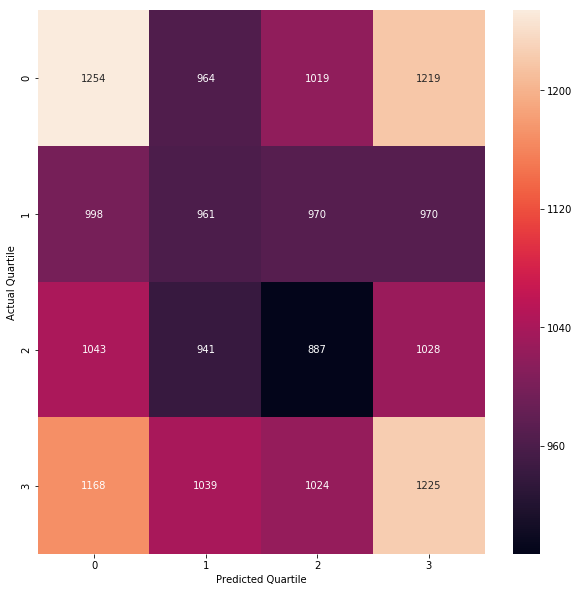

---
00:46:21 Running experiment 82 of 216
(300, 3, 0.001, 0.6)
00:46:21 Generate splits [140, 280, 419, 558, 697]
classify
00:46:21 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.070%
Monthly Sharpe ratio: 0.037
Avg rank correlation (Kendall's tau): 0.0018 (Expected: 0)
4-quartile accuracy: 0.2601 (Expected: 0.25)
Long/short/flat accuracy: 0.3743 (Expected: 0.375)


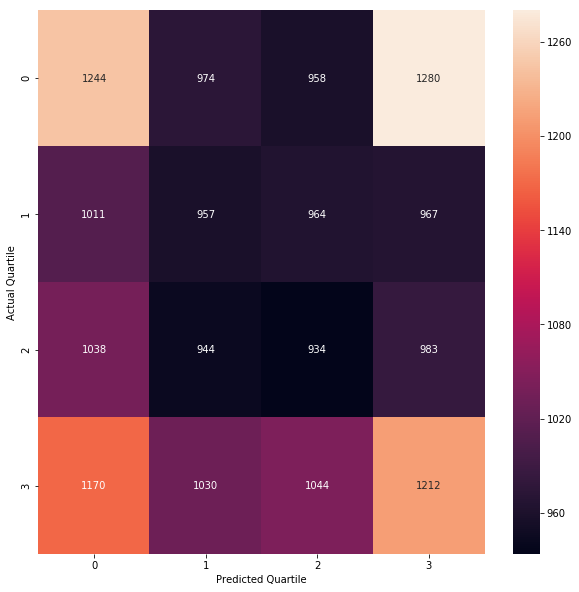

---
00:46:32 Running experiment 83 of 216
(300, 3, 0.001, 0.7)
00:46:32 Generate splits [140, 280, 419, 558, 697]
classify
00:46:32 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.049%
Monthly Sharpe ratio: 0.009
Avg rank correlation (Kendall's tau): 0.0012 (Expected: 0)
4-quartile accuracy: 0.2546 (Expected: 0.25)
Long/short/flat accuracy: 0.3670 (Expected: 0.375)


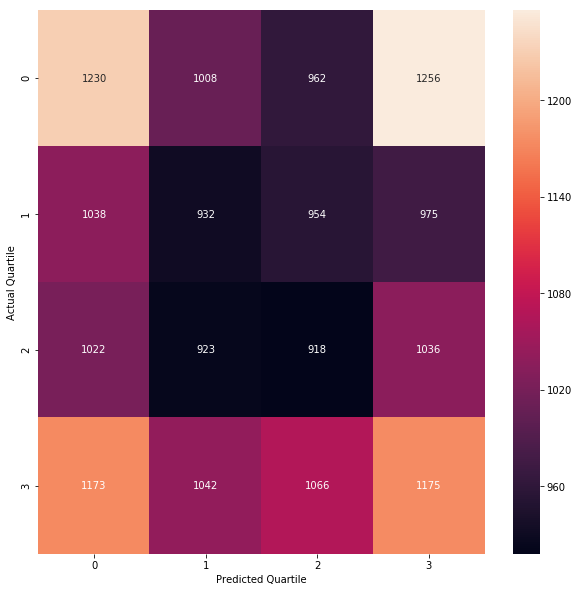

---
00:46:43 Running experiment 84 of 216
(300, 3, 0.001, 0.8)
00:46:43 Generate splits [140, 280, 419, 558, 697]
classify
00:46:43 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.109%
Monthly Sharpe ratio: 0.047
Avg rank correlation (Kendall's tau): -0.0015 (Expected: 0)
4-quartile accuracy: 0.2536 (Expected: 0.25)
Long/short/flat accuracy: 0.3679 (Expected: 0.375)


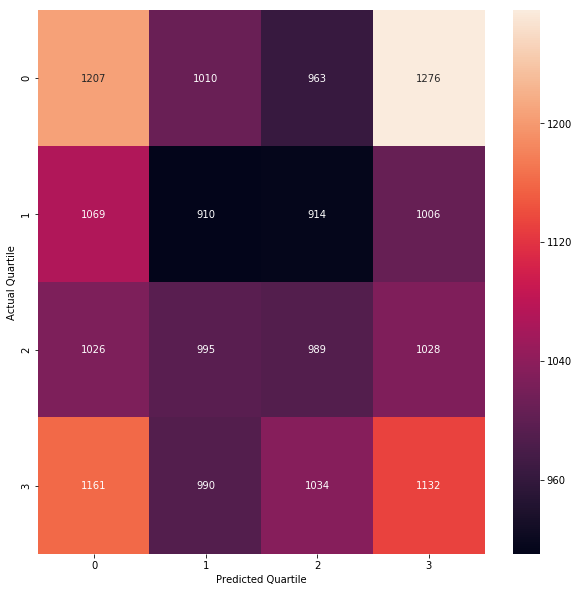

---
00:46:54 Running experiment 85 of 216
(300, 3, 0.0003, 0.6)
00:46:54 Generate splits [140, 280, 419, 558, 697]
classify
00:46:54 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.091%
Monthly Sharpe ratio: -0.006
Avg rank correlation (Kendall's tau): -0.0011 (Expected: 0)
4-quartile accuracy: 0.2493 (Expected: 0.25)
Long/short/flat accuracy: 0.3580 (Expected: 0.375)


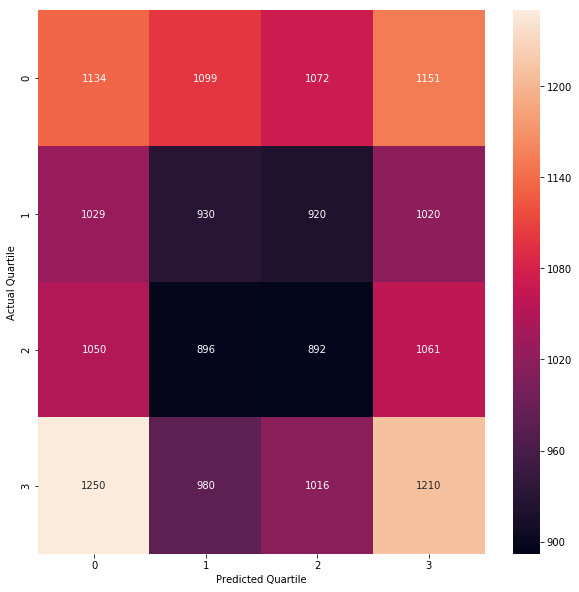

---
00:47:05 Running experiment 86 of 216
(300, 3, 0.0003, 0.7)
00:47:05 Generate splits [140, 280, 419, 558, 697]
classify
00:47:05 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.091%
Monthly Sharpe ratio: -0.006
Avg rank correlation (Kendall's tau): -0.0019 (Expected: 0)
4-quartile accuracy: 0.2519 (Expected: 0.25)
Long/short/flat accuracy: 0.3579 (Expected: 0.375)


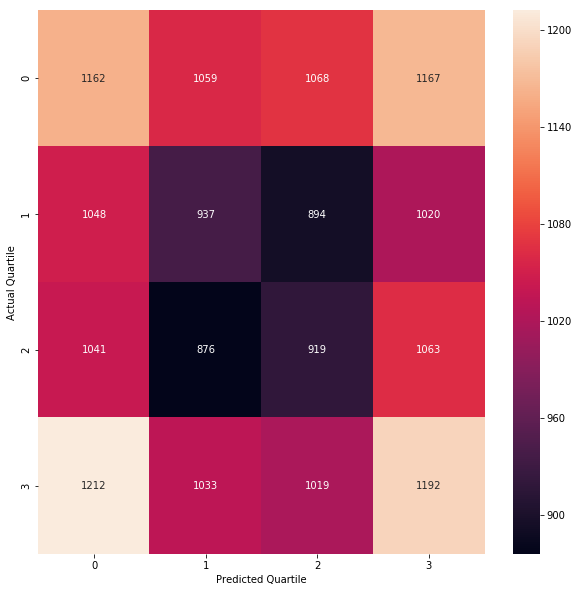

---
00:47:16 Running experiment 87 of 216
(300, 3, 0.0003, 0.8)
00:47:16 Generate splits [140, 280, 419, 558, 697]
classify
00:47:16 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.091%
Monthly Sharpe ratio: -0.006
Avg rank correlation (Kendall's tau): 0.0057 (Expected: 0)
4-quartile accuracy: 0.2524 (Expected: 0.25)
Long/short/flat accuracy: 0.3611 (Expected: 0.375)


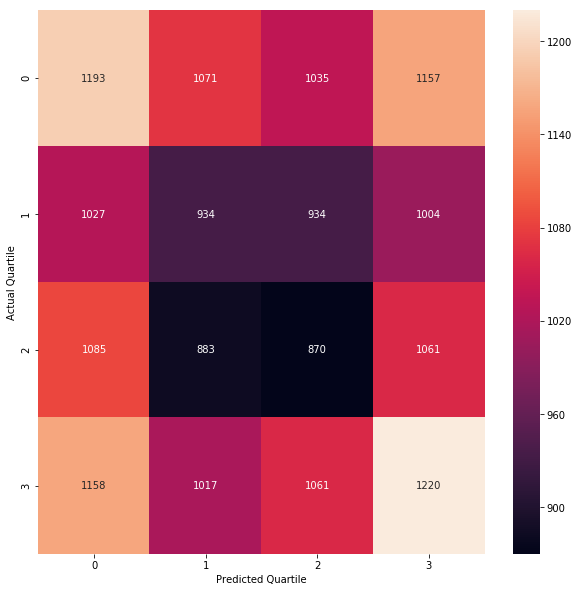

---
00:47:27 Running experiment 88 of 216
(300, 3, 0.0001, 0.6)
00:47:27 Generate splits [140, 280, 419, 558, 697]
classify
00:47:27 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): -0.0068 (Expected: 0)
4-quartile accuracy: 0.2506 (Expected: 0.25)
Long/short/flat accuracy: 0.3600 (Expected: 0.375)


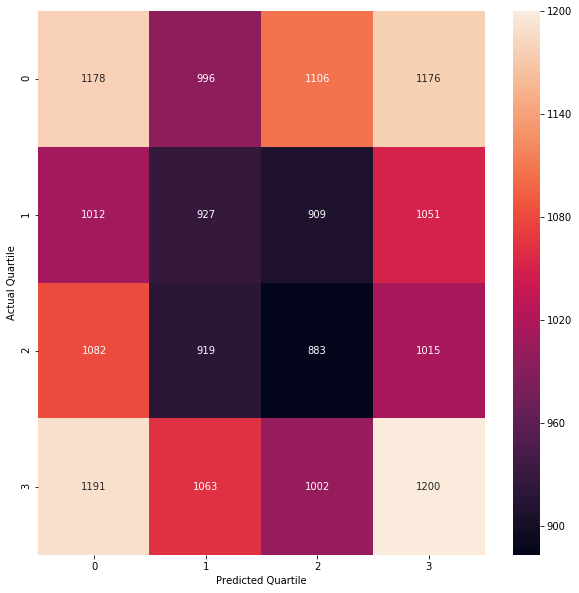

---
00:47:38 Running experiment 89 of 216
(300, 3, 0.0001, 0.7)
00:47:38 Generate splits [140, 280, 419, 558, 697]
classify
00:47:38 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): -0.0040 (Expected: 0)
4-quartile accuracy: 0.2484 (Expected: 0.25)
Long/short/flat accuracy: 0.3603 (Expected: 0.375)


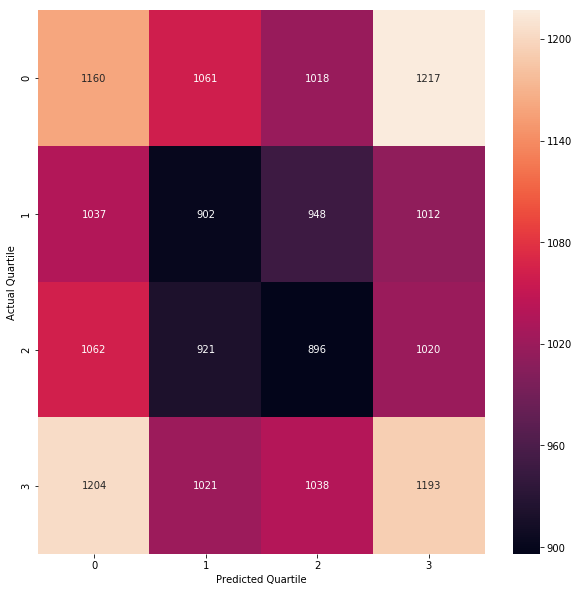

---
00:47:49 Running experiment 90 of 216
(300, 3, 0.0001, 0.8)
00:47:49 Generate splits [140, 280, 419, 558, 697]
classify
00:47:49 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): -0.0013 (Expected: 0)
4-quartile accuracy: 0.2510 (Expected: 0.25)
Long/short/flat accuracy: 0.3597 (Expected: 0.375)


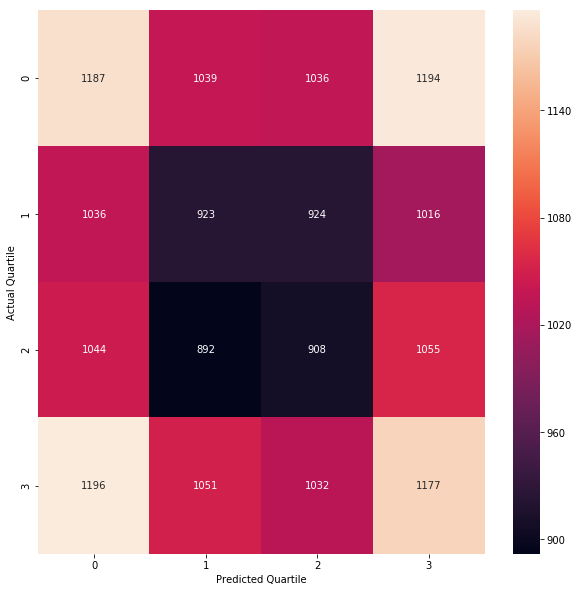

---
00:48:00 Running experiment 91 of 216
(300, 4, 0.03, 0.6)
00:48:00 Generate splits [140, 280, 419, 558, 697]
classify
00:48:00 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 1.440%
Monthly Sharpe ratio: 0.332
Avg rank correlation (Kendall's tau): 0.0168 (Expected: 0)
4-quartile accuracy: 0.2668 (Expected: 0.25)
Long/short/flat accuracy: 0.3798 (Expected: 0.375)


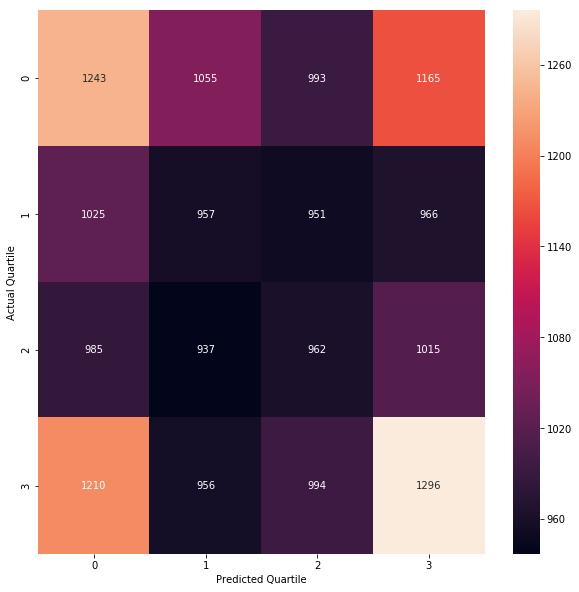

---
00:48:16 Running experiment 92 of 216
(300, 4, 0.03, 0.7)
00:48:16 Generate splits [140, 280, 419, 558, 697]
classify
00:48:16 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.708%
Monthly Sharpe ratio: 0.179
Avg rank correlation (Kendall's tau): 0.0070 (Expected: 0)
4-quartile accuracy: 0.2599 (Expected: 0.25)
Long/short/flat accuracy: 0.3710 (Expected: 0.375)


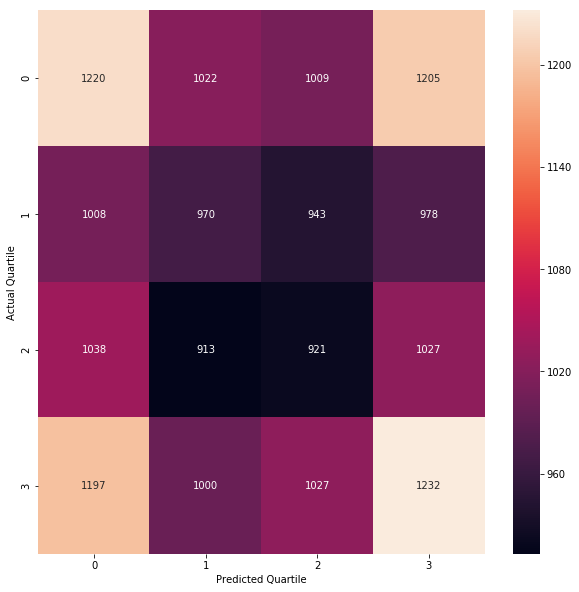

---
00:48:32 Running experiment 93 of 216
(300, 4, 0.03, 0.8)
00:48:32 Generate splits [140, 280, 419, 558, 697]
classify
00:48:32 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.645%
Monthly Sharpe ratio: 0.162
Avg rank correlation (Kendall's tau): 0.0019 (Expected: 0)
4-quartile accuracy: 0.2575 (Expected: 0.25)
Long/short/flat accuracy: 0.3671 (Expected: 0.375)


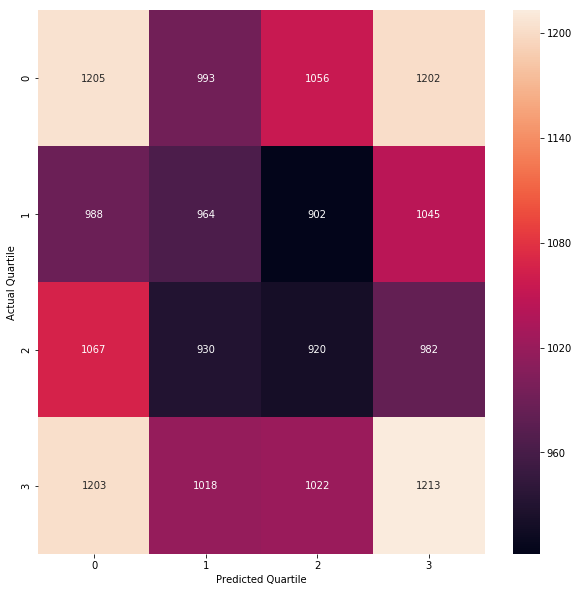

---
00:48:47 Running experiment 94 of 216
(300, 4, 0.01, 0.6)
00:48:47 Generate splits [140, 280, 419, 558, 697]
classify
00:48:47 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.042%
Monthly Sharpe ratio: 0.013
Avg rank correlation (Kendall's tau): 0.0033 (Expected: 0)
4-quartile accuracy: 0.2560 (Expected: 0.25)
Long/short/flat accuracy: 0.3698 (Expected: 0.375)


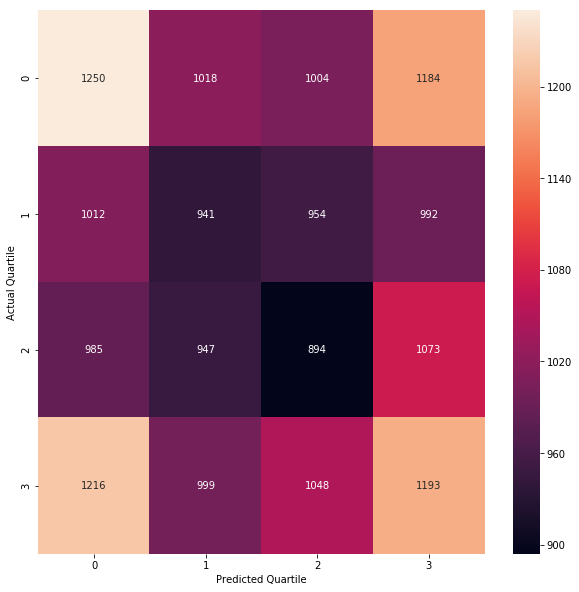

---
00:48:59 Running experiment 95 of 216
(300, 4, 0.01, 0.7)
00:48:59 Generate splits [140, 280, 419, 558, 697]
classify
00:48:59 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.367%
Monthly Sharpe ratio: -0.051
Avg rank correlation (Kendall's tau): 0.0028 (Expected: 0)
4-quartile accuracy: 0.2548 (Expected: 0.25)
Long/short/flat accuracy: 0.3685 (Expected: 0.375)


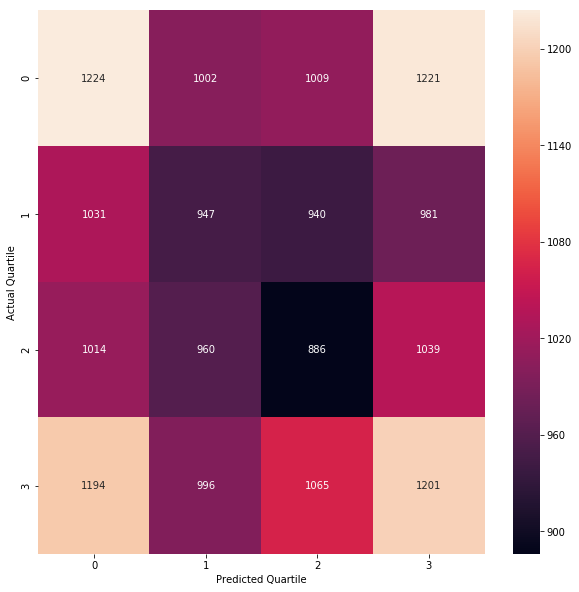

---
00:49:11 Running experiment 96 of 216
(300, 4, 0.01, 0.8)
00:49:11 Generate splits [140, 280, 419, 558, 697]
classify
00:49:11 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.173%
Monthly Sharpe ratio: 0.059
Avg rank correlation (Kendall's tau): -0.0014 (Expected: 0)
4-quartile accuracy: 0.2573 (Expected: 0.25)
Long/short/flat accuracy: 0.3694 (Expected: 0.375)


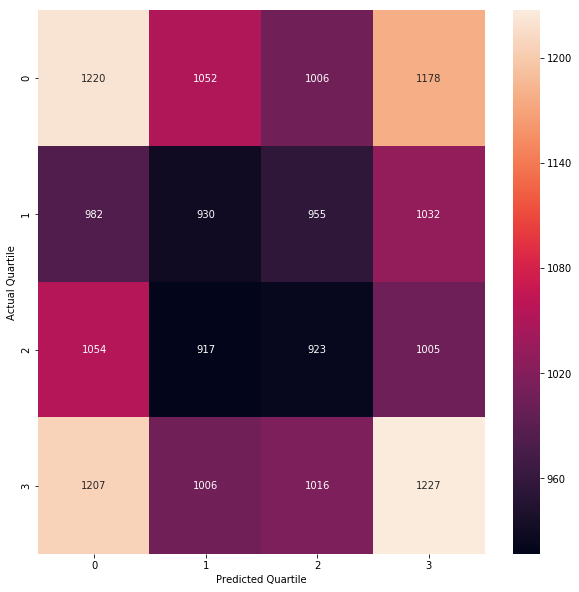

---
00:49:23 Running experiment 97 of 216
(300, 4, 0.003, 0.6)
00:49:23 Generate splits [140, 280, 419, 558, 697]
classify
00:49:23 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.939%
Monthly Sharpe ratio: 0.256
Avg rank correlation (Kendall's tau): 0.0071 (Expected: 0)
4-quartile accuracy: 0.2671 (Expected: 0.25)
Long/short/flat accuracy: 0.3858 (Expected: 0.375)


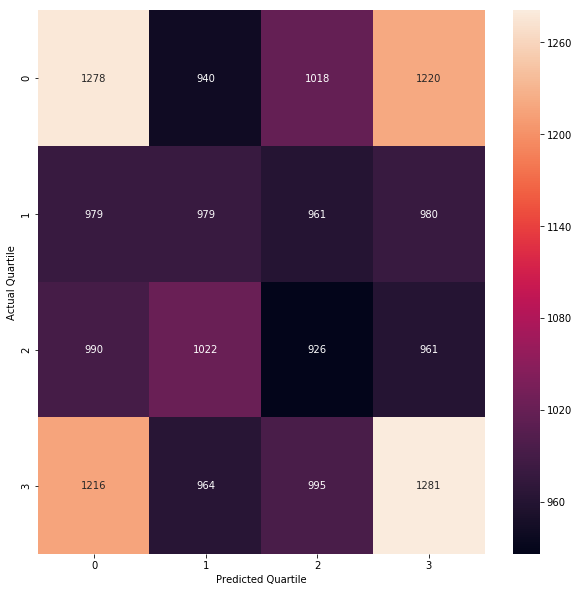

---
00:49:35 Running experiment 98 of 216
(300, 4, 0.003, 0.7)
00:49:35 Generate splits [140, 280, 419, 558, 697]
classify
00:49:35 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.916%
Monthly Sharpe ratio: 0.243
Avg rank correlation (Kendall's tau): 0.0045 (Expected: 0)
4-quartile accuracy: 0.2597 (Expected: 0.25)
Long/short/flat accuracy: 0.3764 (Expected: 0.375)


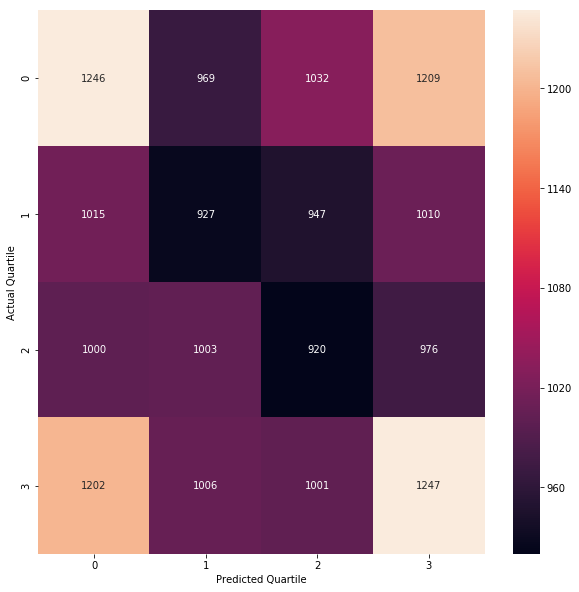

---
00:49:46 Running experiment 99 of 216
(300, 4, 0.003, 0.8)
00:49:46 Generate splits [140, 280, 419, 558, 697]
classify
00:49:46 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.902%
Monthly Sharpe ratio: 0.242
Avg rank correlation (Kendall's tau): 0.0061 (Expected: 0)
4-quartile accuracy: 0.2589 (Expected: 0.25)
Long/short/flat accuracy: 0.3733 (Expected: 0.375)


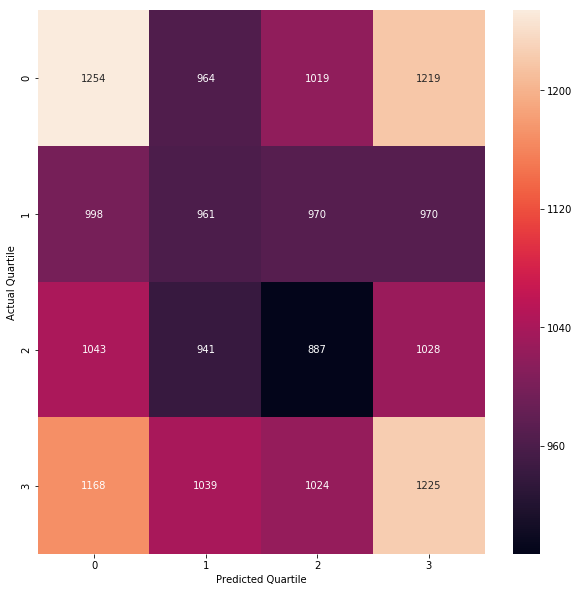

---
00:49:57 Running experiment 100 of 216
(300, 4, 0.001, 0.6)
00:49:57 Generate splits [140, 280, 419, 558, 697]
classify
00:49:57 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.070%
Monthly Sharpe ratio: 0.037
Avg rank correlation (Kendall's tau): -0.0001 (Expected: 0)
4-quartile accuracy: 0.2540 (Expected: 0.25)
Long/short/flat accuracy: 0.3685 (Expected: 0.375)


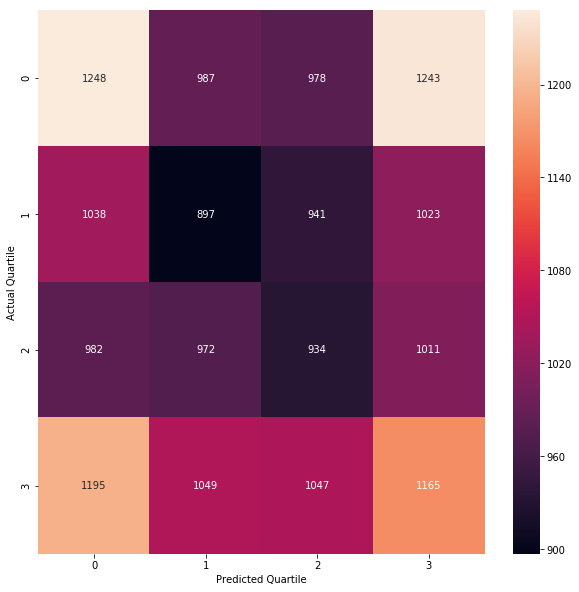

---
00:50:08 Running experiment 101 of 216
(300, 4, 0.001, 0.7)
00:50:08 Generate splits [140, 280, 419, 558, 697]
classify
00:50:08 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.049%
Monthly Sharpe ratio: 0.009
Avg rank correlation (Kendall's tau): -0.0026 (Expected: 0)
4-quartile accuracy: 0.2554 (Expected: 0.25)
Long/short/flat accuracy: 0.3656 (Expected: 0.375)


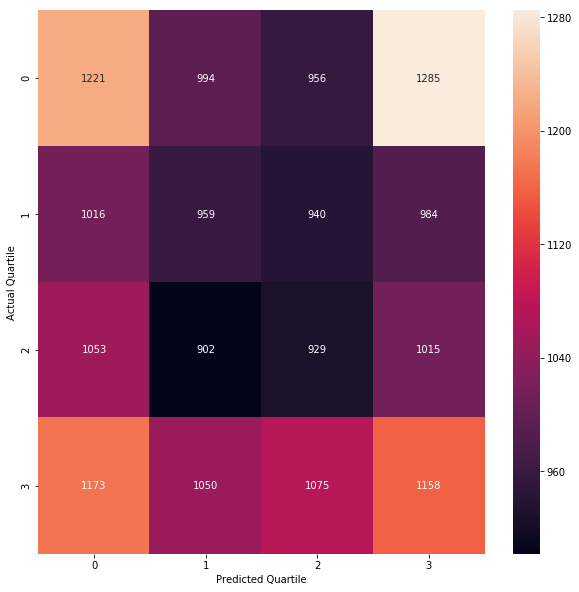

---
00:50:19 Running experiment 102 of 216
(300, 4, 0.001, 0.8)
00:50:19 Generate splits [140, 280, 419, 558, 697]
classify
00:50:19 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.109%
Monthly Sharpe ratio: 0.047
Avg rank correlation (Kendall's tau): -0.0008 (Expected: 0)
4-quartile accuracy: 0.2566 (Expected: 0.25)
Long/short/flat accuracy: 0.3690 (Expected: 0.375)


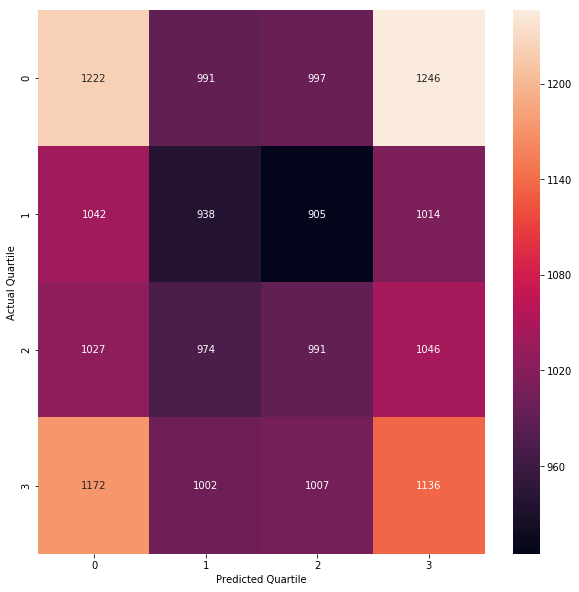

---
00:50:31 Running experiment 103 of 216
(300, 4, 0.0003, 0.6)
00:50:31 Generate splits [140, 280, 419, 558, 697]
classify
00:50:31 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.091%
Monthly Sharpe ratio: -0.006
Avg rank correlation (Kendall's tau): 0.0025 (Expected: 0)
4-quartile accuracy: 0.2506 (Expected: 0.25)
Long/short/flat accuracy: 0.3623 (Expected: 0.375)


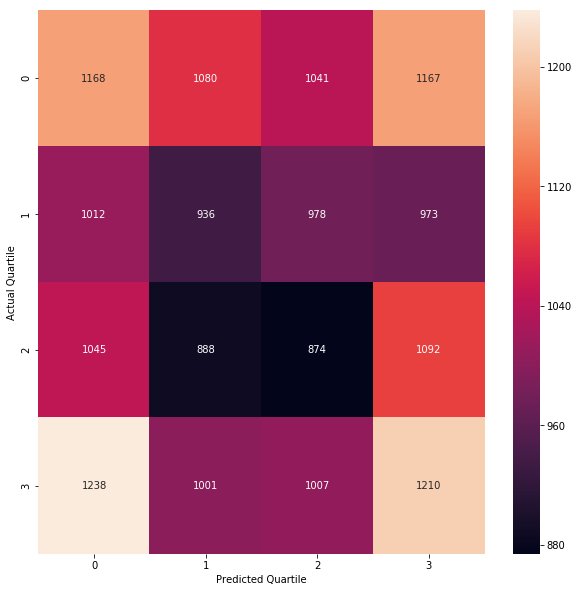

---
00:50:42 Running experiment 104 of 216
(300, 4, 0.0003, 0.7)
00:50:42 Generate splits [140, 280, 419, 558, 697]
classify
00:50:42 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.091%
Monthly Sharpe ratio: -0.006
Avg rank correlation (Kendall's tau): -0.0034 (Expected: 0)
4-quartile accuracy: 0.2534 (Expected: 0.25)
Long/short/flat accuracy: 0.3604 (Expected: 0.375)


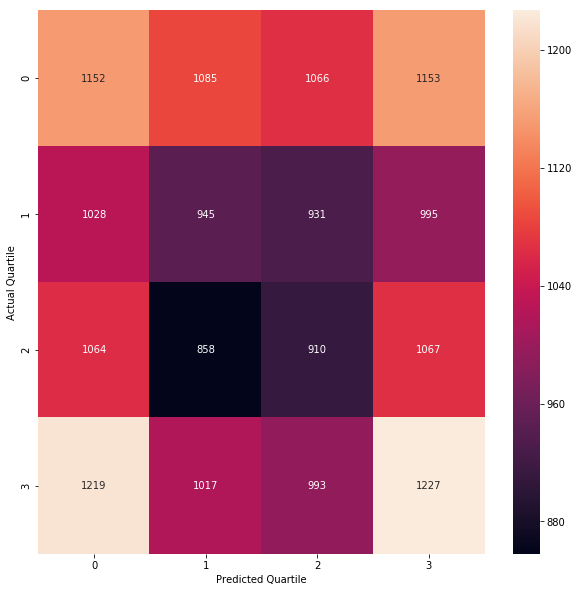

---
00:50:53 Running experiment 105 of 216
(300, 4, 0.0003, 0.8)
00:50:53 Generate splits [140, 280, 419, 558, 697]
classify
00:50:53 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.091%
Monthly Sharpe ratio: -0.006
Avg rank correlation (Kendall's tau): 0.0080 (Expected: 0)
4-quartile accuracy: 0.2555 (Expected: 0.25)
Long/short/flat accuracy: 0.3609 (Expected: 0.375)


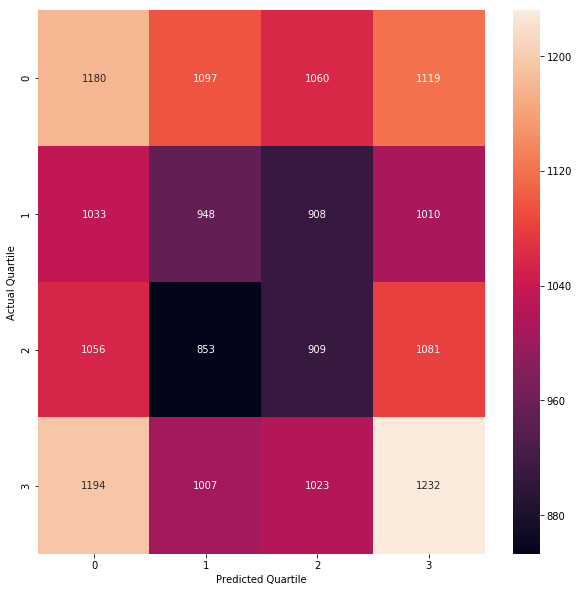

---
00:51:04 Running experiment 106 of 216
(300, 4, 0.0001, 0.6)
00:51:04 Generate splits [140, 280, 419, 558, 697]
classify
00:51:04 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): -0.0005 (Expected: 0)
4-quartile accuracy: 0.2513 (Expected: 0.25)
Long/short/flat accuracy: 0.3585 (Expected: 0.375)


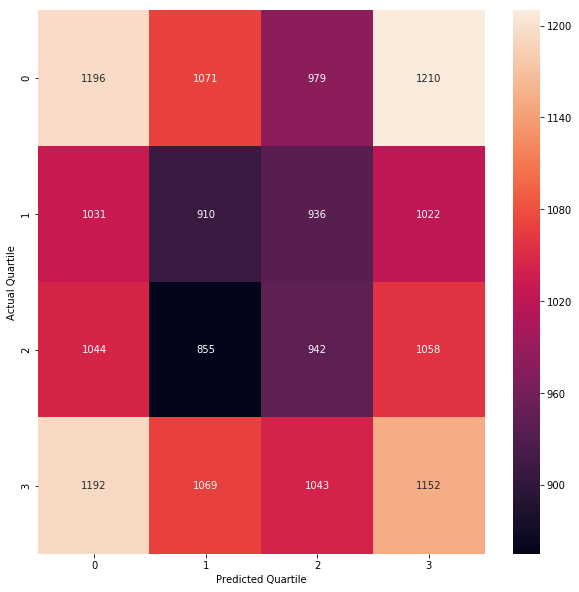

---
00:51:15 Running experiment 107 of 216
(300, 4, 0.0001, 0.7)
00:51:15 Generate splits [140, 280, 419, 558, 697]
classify
00:51:15 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): 0.0070 (Expected: 0)
4-quartile accuracy: 0.2543 (Expected: 0.25)
Long/short/flat accuracy: 0.3633 (Expected: 0.375)


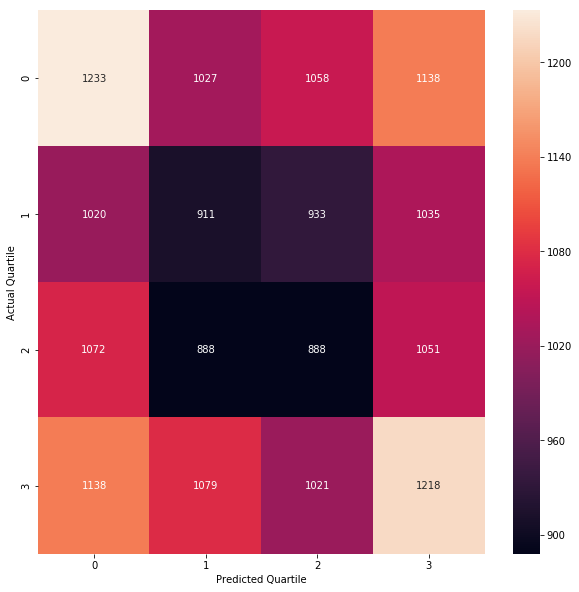

---
00:51:26 Running experiment 108 of 216
(300, 4, 0.0001, 0.8)
00:51:26 Generate splits [140, 280, 419, 558, 697]
classify
00:51:26 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): 0.0067 (Expected: 0)
4-quartile accuracy: 0.2553 (Expected: 0.25)
Long/short/flat accuracy: 0.3597 (Expected: 0.375)


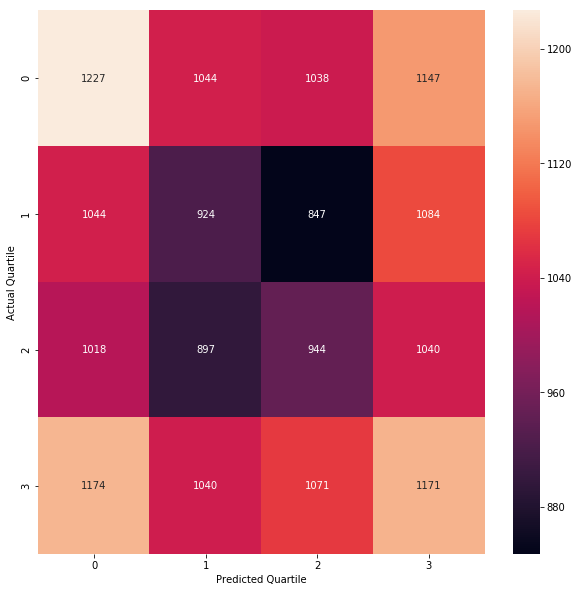

---
00:51:36 Running experiment 109 of 216
(300, 5, 0.03, 0.6)
00:51:36 Generate splits [140, 280, 419, 558, 697]
classify
00:51:36 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 1.440%
Monthly Sharpe ratio: 0.332
Avg rank correlation (Kendall's tau): 0.0168 (Expected: 0)
4-quartile accuracy: 0.2668 (Expected: 0.25)
Long/short/flat accuracy: 0.3798 (Expected: 0.375)


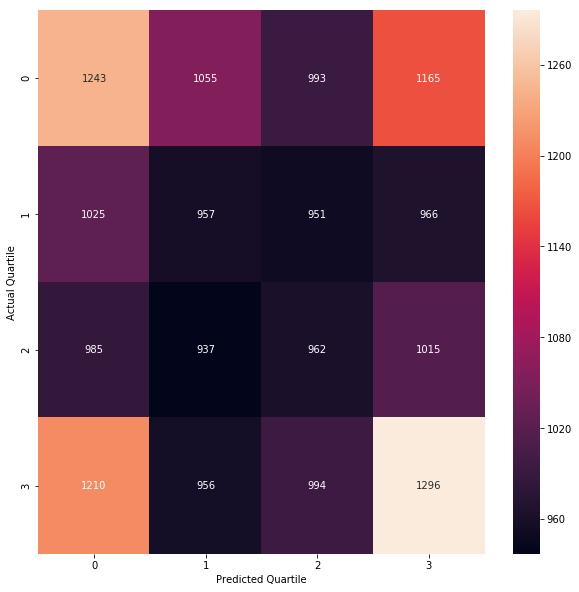

---
00:51:53 Running experiment 110 of 216
(300, 5, 0.03, 0.7)
00:51:53 Generate splits [140, 280, 419, 558, 697]
classify
00:51:53 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.708%
Monthly Sharpe ratio: 0.179
Avg rank correlation (Kendall's tau): 0.0070 (Expected: 0)
4-quartile accuracy: 0.2599 (Expected: 0.25)
Long/short/flat accuracy: 0.3710 (Expected: 0.375)


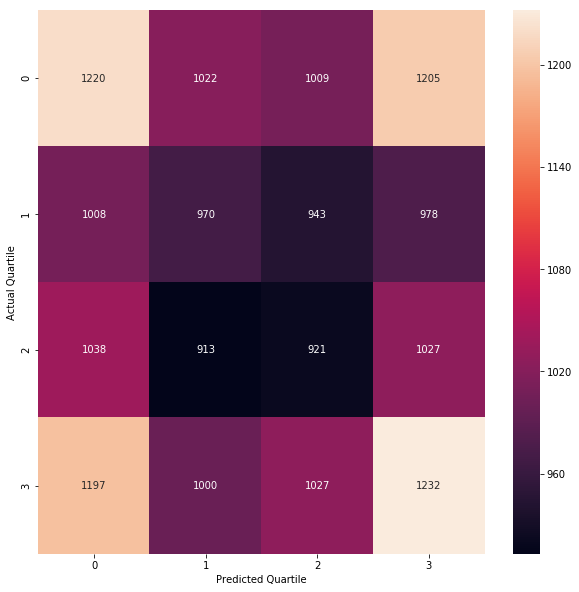

---
00:52:08 Running experiment 111 of 216
(300, 5, 0.03, 0.8)
00:52:08 Generate splits [140, 280, 419, 558, 697]
classify
00:52:08 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.645%
Monthly Sharpe ratio: 0.162
Avg rank correlation (Kendall's tau): 0.0019 (Expected: 0)
4-quartile accuracy: 0.2575 (Expected: 0.25)
Long/short/flat accuracy: 0.3671 (Expected: 0.375)


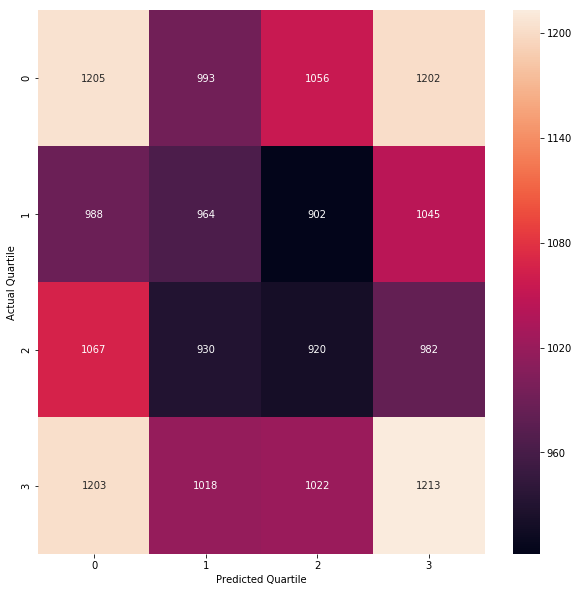

---
00:52:23 Running experiment 112 of 216
(300, 5, 0.01, 0.6)
00:52:23 Generate splits [140, 280, 419, 558, 697]
classify
00:52:23 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.042%
Monthly Sharpe ratio: 0.013
Avg rank correlation (Kendall's tau): 0.0033 (Expected: 0)
4-quartile accuracy: 0.2560 (Expected: 0.25)
Long/short/flat accuracy: 0.3698 (Expected: 0.375)


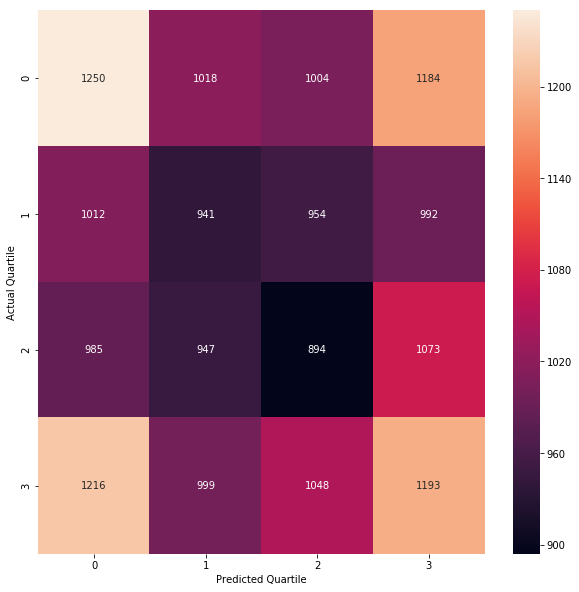

---
00:52:35 Running experiment 113 of 216
(300, 5, 0.01, 0.7)
00:52:35 Generate splits [140, 280, 419, 558, 697]
classify
00:52:35 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.367%
Monthly Sharpe ratio: -0.051
Avg rank correlation (Kendall's tau): 0.0028 (Expected: 0)
4-quartile accuracy: 0.2548 (Expected: 0.25)
Long/short/flat accuracy: 0.3685 (Expected: 0.375)


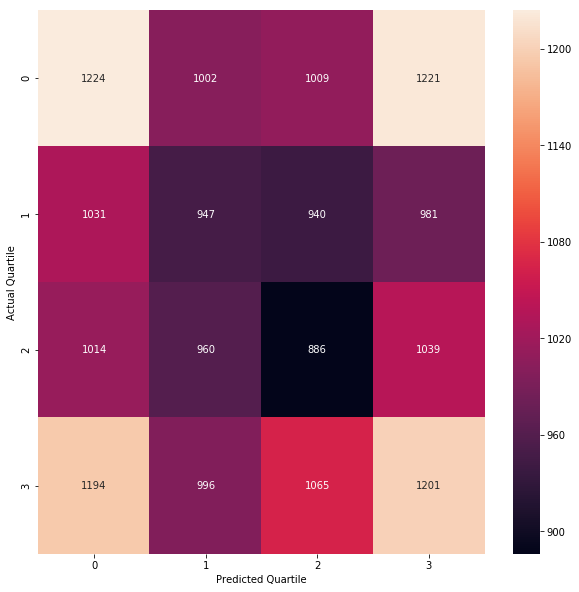

---
00:52:47 Running experiment 114 of 216
(300, 5, 0.01, 0.8)
00:52:47 Generate splits [140, 280, 419, 558, 697]
classify
00:52:47 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.173%
Monthly Sharpe ratio: 0.059
Avg rank correlation (Kendall's tau): -0.0014 (Expected: 0)
4-quartile accuracy: 0.2573 (Expected: 0.25)
Long/short/flat accuracy: 0.3694 (Expected: 0.375)


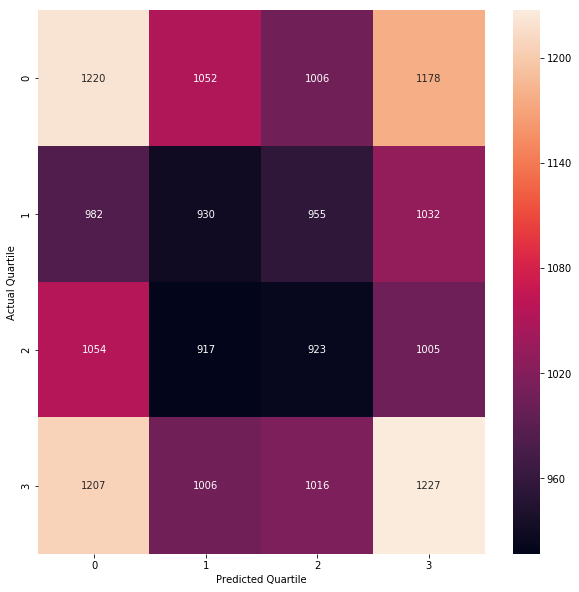

---
00:52:59 Running experiment 115 of 216
(300, 5, 0.003, 0.6)
00:52:59 Generate splits [140, 280, 419, 558, 697]
classify
00:52:59 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.939%
Monthly Sharpe ratio: 0.256
Avg rank correlation (Kendall's tau): 0.0071 (Expected: 0)
4-quartile accuracy: 0.2671 (Expected: 0.25)
Long/short/flat accuracy: 0.3858 (Expected: 0.375)


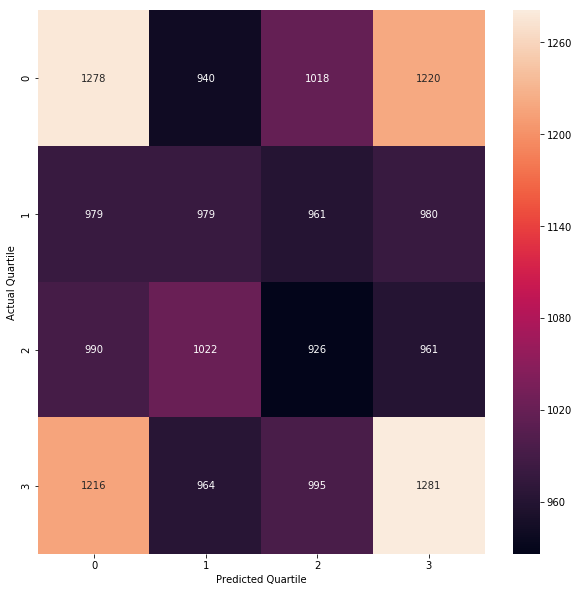

---
00:53:11 Running experiment 116 of 216
(300, 5, 0.003, 0.7)
00:53:11 Generate splits [140, 280, 419, 558, 697]
classify
00:53:11 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): 0.0042 (Expected: 0)
4-quartile accuracy: 0.2478 (Expected: 0.25)
Long/short/flat accuracy: 0.3555 (Expected: 0.375)


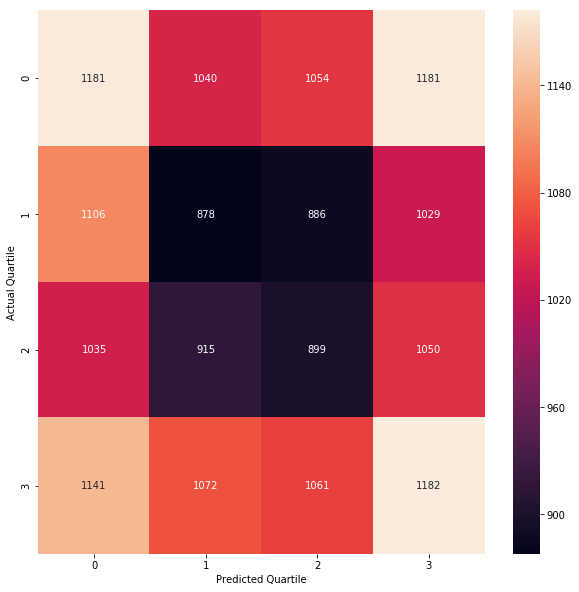

---
00:55:01 Running experiment 126 of 216
(300, 5, 0.0001, 0.8)
00:55:01 Generate splits [140, 280, 419, 558, 697]
classify
00:55:01 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): -0.0103 (Expected: 0)
4-quartile accuracy: 0.2513 (Expected: 0.25)
Long/short/flat accuracy: 0.3616 (Expected: 0.375)


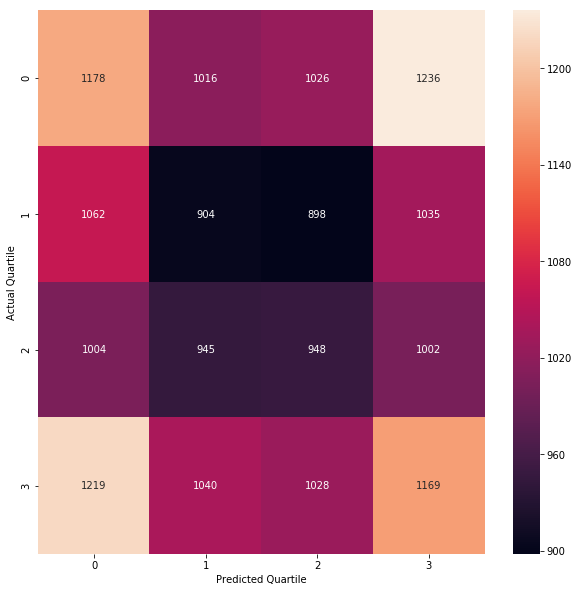

---
00:55:12 Running experiment 127 of 216
(300, 6, 0.03, 0.6)
00:55:12 Generate splits [140, 280, 419, 558, 697]
classify
00:55:12 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 1.440%
Monthly Sharpe ratio: 0.332
Avg rank correlation (Kendall's tau): 0.0168 (Expected: 0)
4-quartile accuracy: 0.2668 (Expected: 0.25)
Long/short/flat accuracy: 0.3798 (Expected: 0.375)


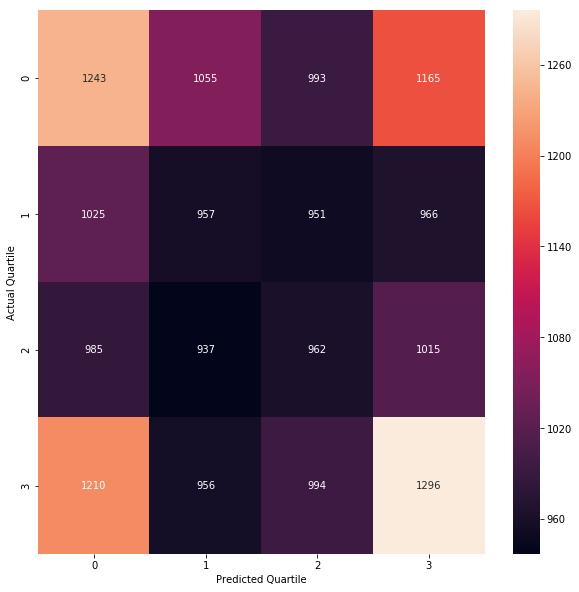

---
00:55:28 Running experiment 128 of 216
(300, 6, 0.03, 0.7)
00:55:28 Generate splits [140, 280, 419, 558, 697]
classify
00:55:28 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.708%
Monthly Sharpe ratio: 0.179
Avg rank correlation (Kendall's tau): 0.0070 (Expected: 0)
4-quartile accuracy: 0.2599 (Expected: 0.25)
Long/short/flat accuracy: 0.3710 (Expected: 0.375)


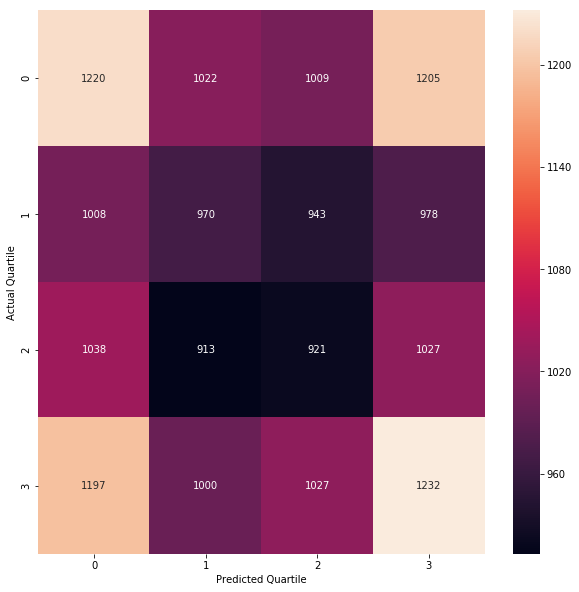

---
00:55:44 Running experiment 129 of 216
(300, 6, 0.03, 0.8)
00:55:44 Generate splits [140, 280, 419, 558, 697]
classify
00:55:44 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.645%
Monthly Sharpe ratio: 0.162
Avg rank correlation (Kendall's tau): 0.0019 (Expected: 0)
4-quartile accuracy: 0.2575 (Expected: 0.25)
Long/short/flat accuracy: 0.3671 (Expected: 0.375)


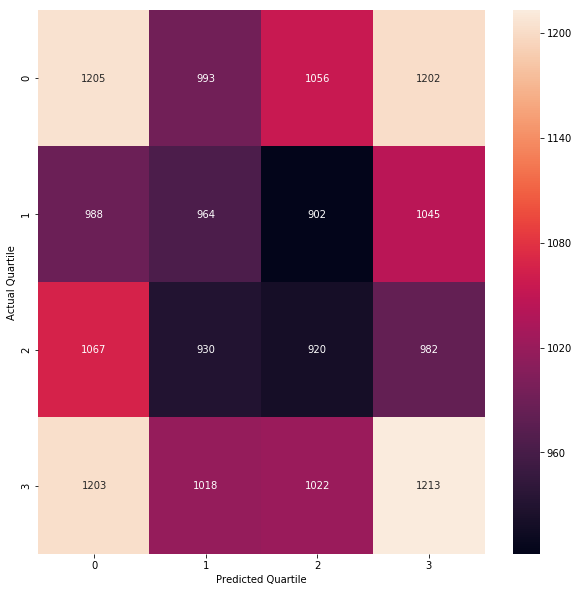

---
00:55:59 Running experiment 130 of 216
(300, 6, 0.01, 0.6)
00:55:59 Generate splits [140, 280, 419, 558, 697]
classify
00:55:59 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.042%
Monthly Sharpe ratio: 0.013
Avg rank correlation (Kendall's tau): 0.0033 (Expected: 0)
4-quartile accuracy: 0.2560 (Expected: 0.25)
Long/short/flat accuracy: 0.3698 (Expected: 0.375)


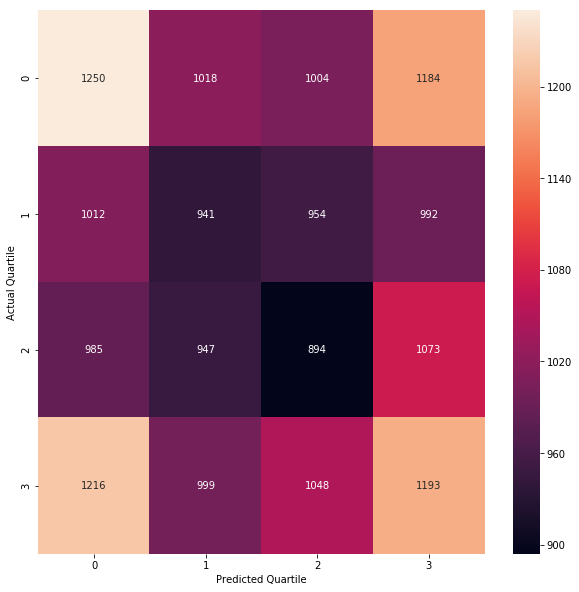

---
00:56:11 Running experiment 131 of 216
(300, 6, 0.01, 0.7)
00:56:11 Generate splits [140, 280, 419, 558, 697]
classify
00:56:11 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.367%
Monthly Sharpe ratio: -0.051
Avg rank correlation (Kendall's tau): 0.0028 (Expected: 0)
4-quartile accuracy: 0.2548 (Expected: 0.25)
Long/short/flat accuracy: 0.3685 (Expected: 0.375)


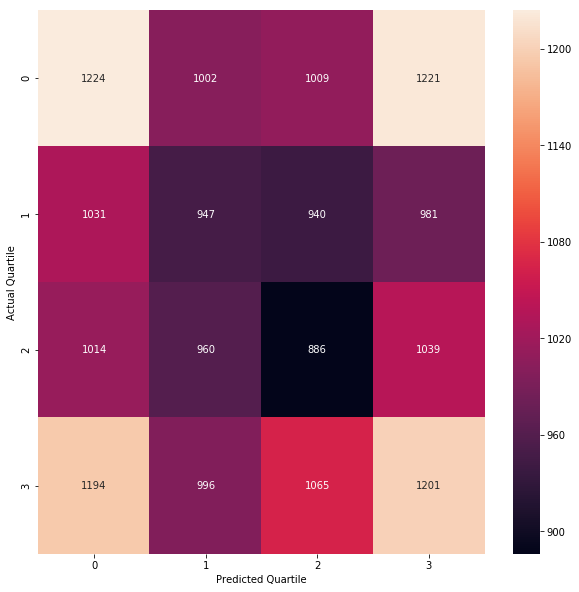

---
00:56:23 Running experiment 132 of 216
(300, 6, 0.01, 0.8)
00:56:23 Generate splits [140, 280, 419, 558, 697]
classify
00:56:23 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.173%
Monthly Sharpe ratio: 0.059
Avg rank correlation (Kendall's tau): -0.0014 (Expected: 0)
4-quartile accuracy: 0.2573 (Expected: 0.25)
Long/short/flat accuracy: 0.3694 (Expected: 0.375)


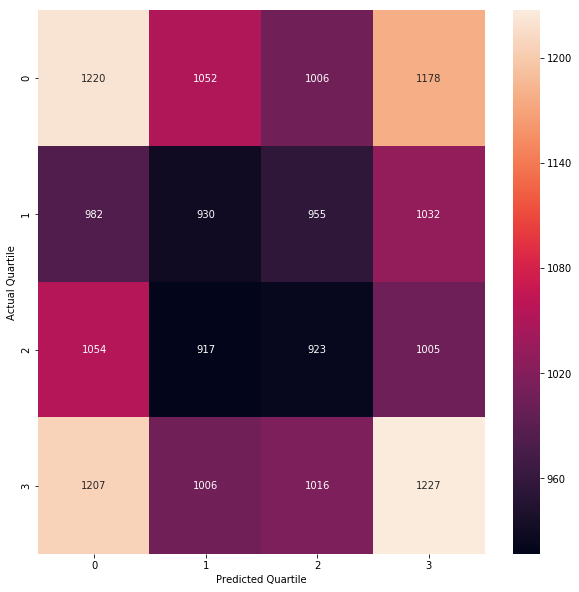

---
00:56:35 Running experiment 133 of 216
(300, 6, 0.003, 0.6)
00:56:35 Generate splits [140, 280, 419, 558, 697]
classify
00:56:35 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.939%
Monthly Sharpe ratio: 0.256
Avg rank correlation (Kendall's tau): 0.0071 (Expected: 0)
4-quartile accuracy: 0.2671 (Expected: 0.25)
Long/short/flat accuracy: 0.3858 (Expected: 0.375)


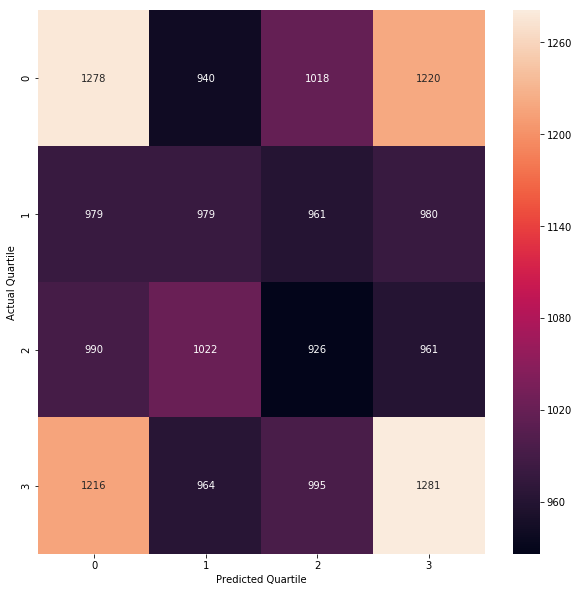

---
00:56:46 Running experiment 134 of 216
(300, 6, 0.003, 0.7)
00:56:46 Generate splits [140, 280, 419, 558, 697]
classify
00:56:46 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.916%
Monthly Sharpe ratio: 0.243
Avg rank correlation (Kendall's tau): 0.0045 (Expected: 0)
4-quartile accuracy: 0.2597 (Expected: 0.25)
Long/short/flat accuracy: 0.3764 (Expected: 0.375)


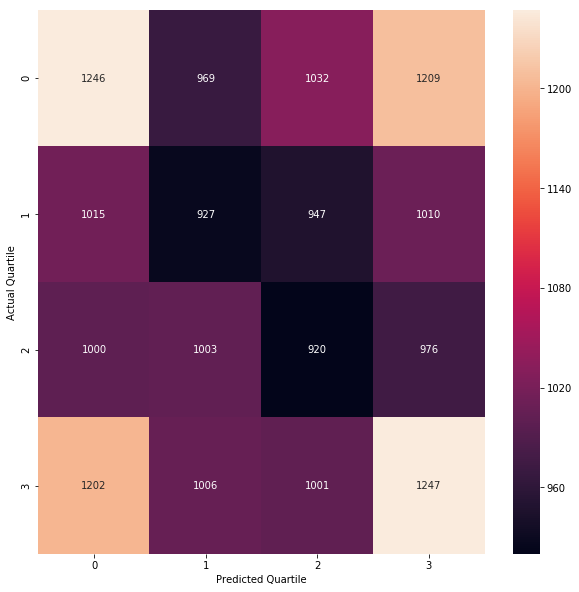

---
00:56:58 Running experiment 135 of 216
(300, 6, 0.003, 0.8)
00:56:58 Generate splits [140, 280, 419, 558, 697]
classify
00:56:58 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.902%
Monthly Sharpe ratio: 0.242
Avg rank correlation (Kendall's tau): 0.0061 (Expected: 0)
4-quartile accuracy: 0.2589 (Expected: 0.25)
Long/short/flat accuracy: 0.3733 (Expected: 0.375)


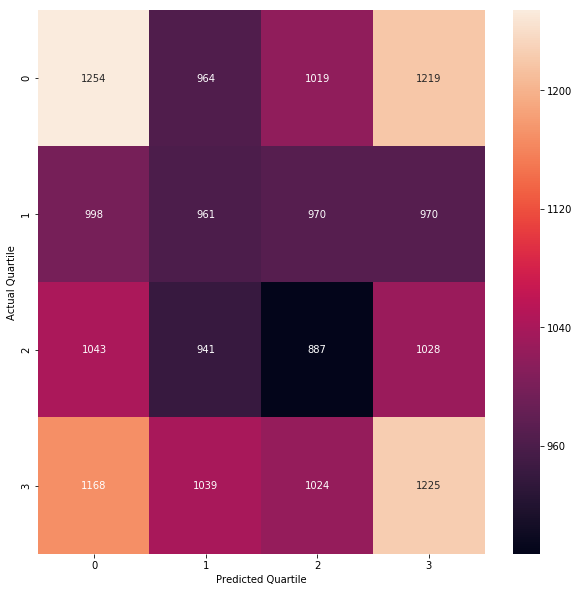

---
00:57:09 Running experiment 136 of 216
(300, 6, 0.001, 0.6)
00:57:09 Generate splits [140, 280, 419, 558, 697]
classify
00:57:09 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.070%
Monthly Sharpe ratio: 0.037
Avg rank correlation (Kendall's tau): 0.0061 (Expected: 0)
4-quartile accuracy: 0.2567 (Expected: 0.25)
Long/short/flat accuracy: 0.3679 (Expected: 0.375)


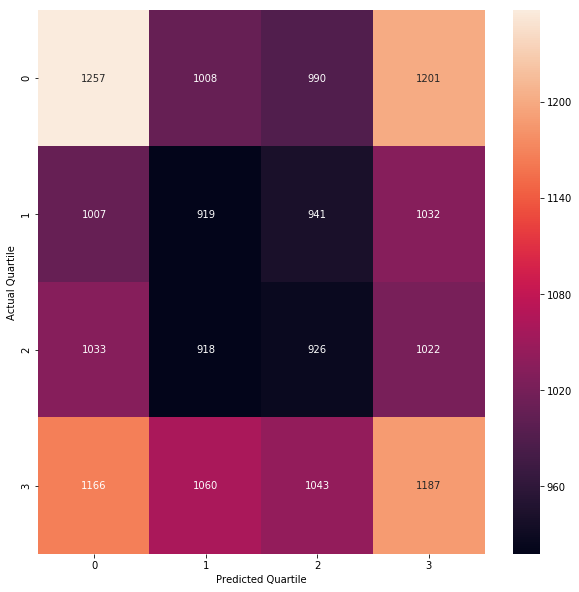

---
00:57:20 Running experiment 137 of 216
(300, 6, 0.001, 0.7)
00:57:20 Generate splits [140, 280, 419, 558, 697]
classify
00:57:20 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.049%
Monthly Sharpe ratio: 0.009
Avg rank correlation (Kendall's tau): 0.0013 (Expected: 0)
4-quartile accuracy: 0.2565 (Expected: 0.25)
Long/short/flat accuracy: 0.3677 (Expected: 0.375)


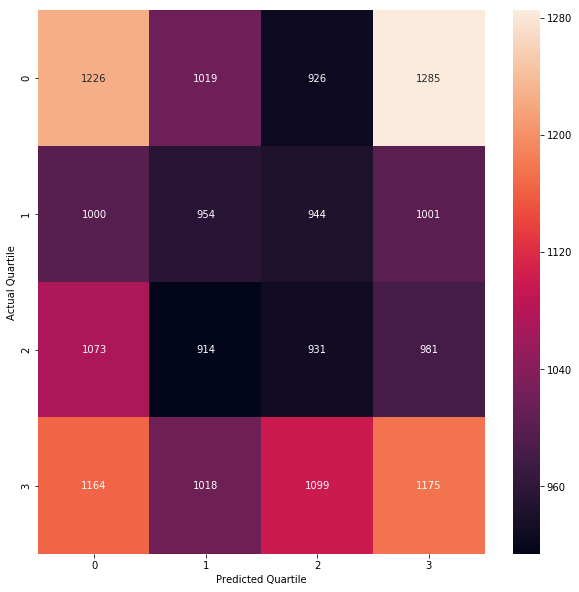

---
00:57:31 Running experiment 138 of 216
(300, 6, 0.001, 0.8)
00:57:31 Generate splits [140, 280, 419, 558, 697]
classify
00:57:31 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.109%
Monthly Sharpe ratio: 0.047
Avg rank correlation (Kendall's tau): 0.0052 (Expected: 0)
4-quartile accuracy: 0.2573 (Expected: 0.25)
Long/short/flat accuracy: 0.3698 (Expected: 0.375)


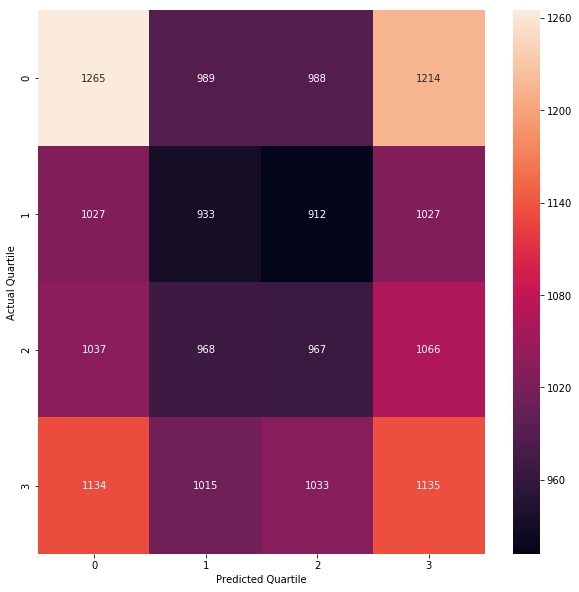

---
00:57:42 Running experiment 139 of 216
(300, 6, 0.0003, 0.6)
00:57:42 Generate splits [140, 280, 419, 558, 697]
classify
00:57:42 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.091%
Monthly Sharpe ratio: -0.006
Avg rank correlation (Kendall's tau): 0.0008 (Expected: 0)
4-quartile accuracy: 0.2486 (Expected: 0.25)
Long/short/flat accuracy: 0.3622 (Expected: 0.375)


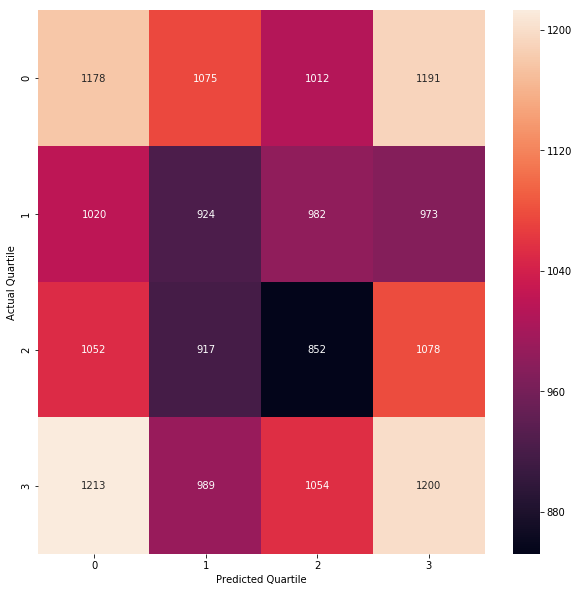

---
00:57:53 Running experiment 140 of 216
(300, 6, 0.0003, 0.7)
00:57:53 Generate splits [140, 280, 419, 558, 697]
classify
00:57:53 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.091%
Monthly Sharpe ratio: -0.006
Avg rank correlation (Kendall's tau): -0.0022 (Expected: 0)
4-quartile accuracy: 0.2453 (Expected: 0.25)
Long/short/flat accuracy: 0.3557 (Expected: 0.375)


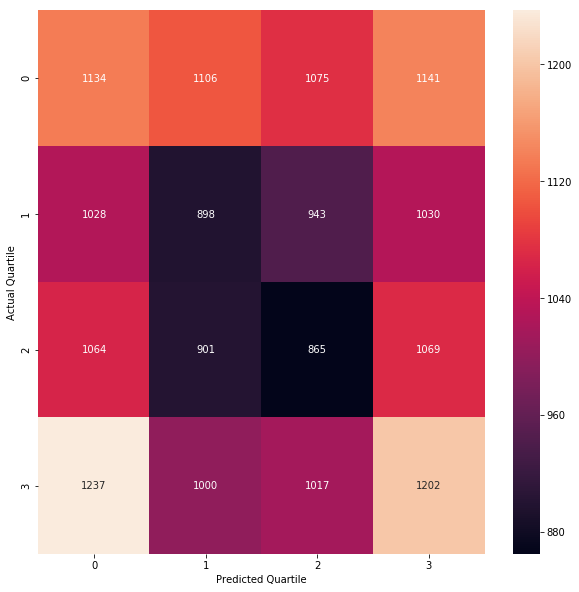

---
00:58:04 Running experiment 141 of 216
(300, 6, 0.0003, 0.8)
00:58:04 Generate splits [140, 280, 419, 558, 697]
classify
00:58:04 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.091%
Monthly Sharpe ratio: -0.006
Avg rank correlation (Kendall's tau): -0.0009 (Expected: 0)
4-quartile accuracy: 0.2558 (Expected: 0.25)
Long/short/flat accuracy: 0.3637 (Expected: 0.375)


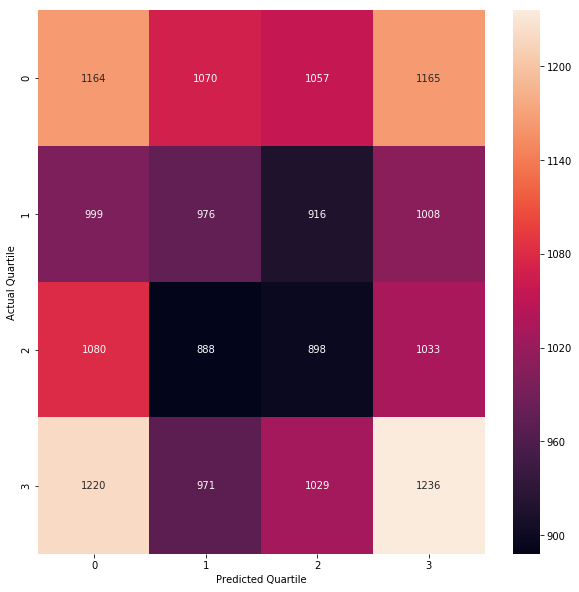

---
00:58:16 Running experiment 142 of 216
(300, 6, 0.0001, 0.6)
00:58:16 Generate splits [140, 280, 419, 558, 697]
classify
00:58:16 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): -0.0018 (Expected: 0)
4-quartile accuracy: 0.2489 (Expected: 0.25)
Long/short/flat accuracy: 0.3551 (Expected: 0.375)


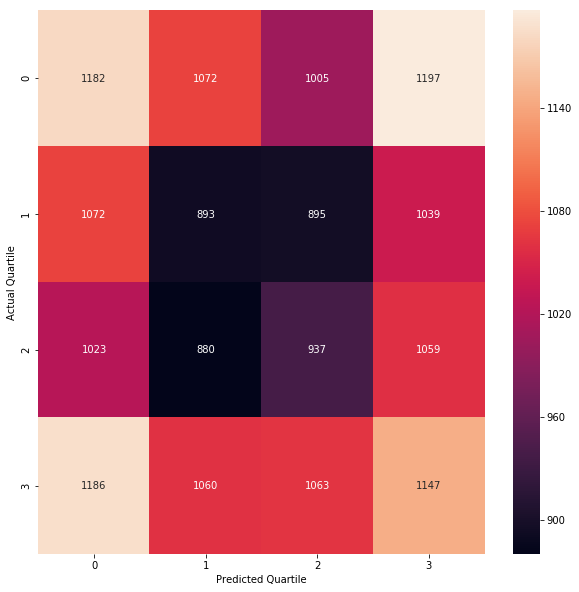

---
00:58:26 Running experiment 143 of 216
(300, 6, 0.0001, 0.7)
00:58:27 Generate splits [140, 280, 419, 558, 697]
classify
00:58:27 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): -0.0036 (Expected: 0)
4-quartile accuracy: 0.2528 (Expected: 0.25)
Long/short/flat accuracy: 0.3582 (Expected: 0.375)


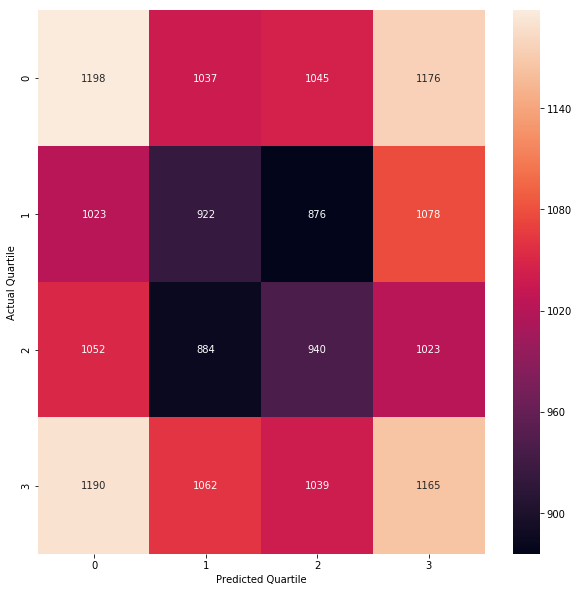

---
00:58:37 Running experiment 144 of 216
(300, 6, 0.0001, 0.8)
00:58:37 Generate splits [140, 280, 419, 558, 697]
classify
00:58:37 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): 0.0105 (Expected: 0)
4-quartile accuracy: 0.2572 (Expected: 0.25)
Long/short/flat accuracy: 0.3657 (Expected: 0.375)


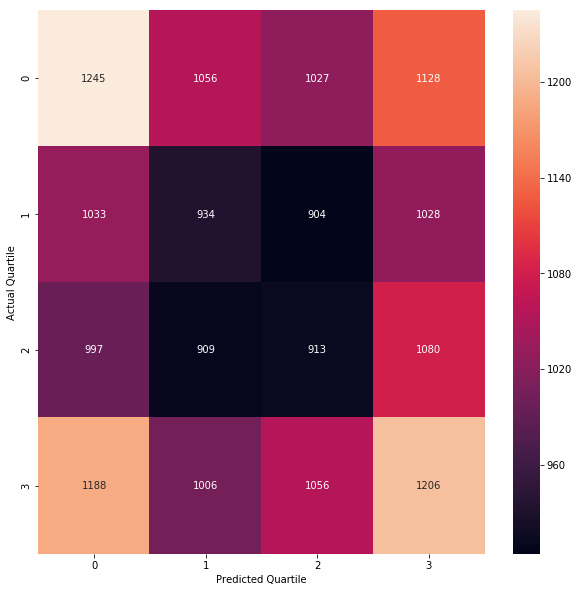

---
00:58:48 Running experiment 145 of 216
(1000, 3, 0.03, 0.6)
00:58:48 Generate splits [140, 280, 419, 558, 697]
classify
00:58:48 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.782%
Monthly Sharpe ratio: 0.203
Avg rank correlation (Kendall's tau): 0.0087 (Expected: 0)
4-quartile accuracy: 0.2637 (Expected: 0.25)
Long/short/flat accuracy: 0.3756 (Expected: 0.375)


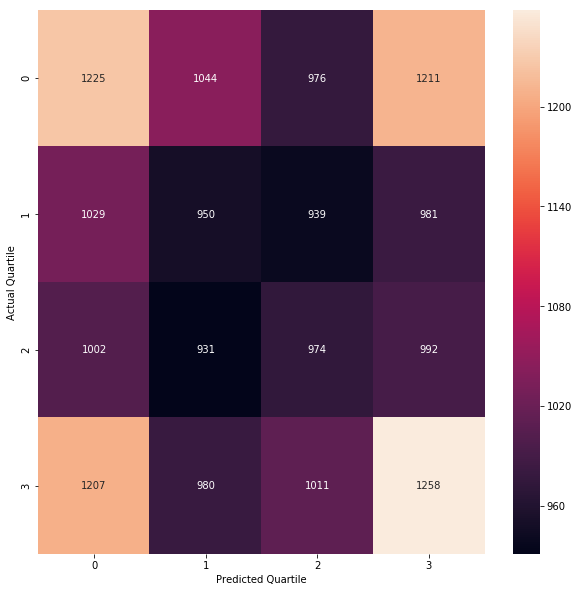

---
00:59:34 Running experiment 146 of 216
(1000, 3, 0.03, 0.7)
00:59:34 Generate splits [140, 280, 419, 558, 697]
classify
00:59:34 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.354%
Monthly Sharpe ratio: 0.100
Avg rank correlation (Kendall's tau): 0.0001 (Expected: 0)
4-quartile accuracy: 0.2579 (Expected: 0.25)
Long/short/flat accuracy: 0.3674 (Expected: 0.375)


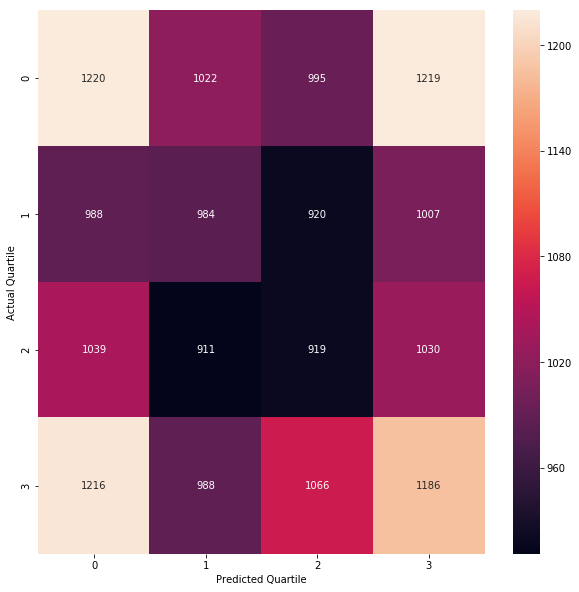

---
01:00:19 Running experiment 147 of 216
(1000, 3, 0.03, 0.8)
01:00:19 Generate splits [140, 280, 419, 558, 697]
classify
01:00:19 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 1.064%
Monthly Sharpe ratio: 0.257
Avg rank correlation (Kendall's tau): 0.0150 (Expected: 0)
4-quartile accuracy: 0.2649 (Expected: 0.25)
Long/short/flat accuracy: 0.3753 (Expected: 0.375)


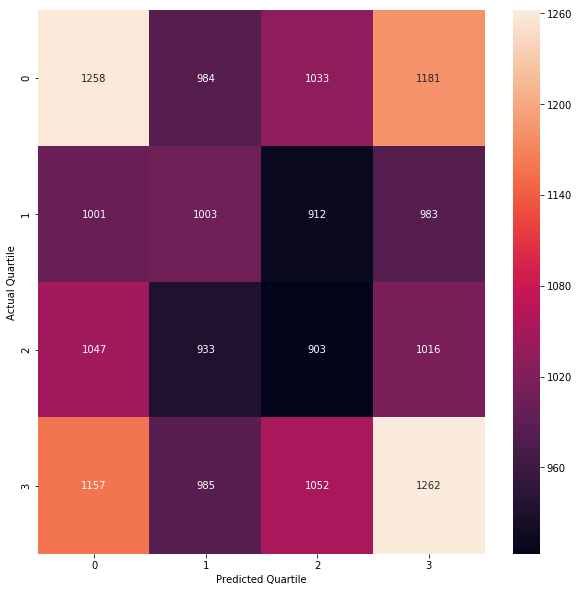

---
01:01:03 Running experiment 148 of 216
(1000, 3, 0.01, 0.6)
01:01:03 Generate splits [140, 280, 419, 558, 697]
classify
01:01:03 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.650%
Monthly Sharpe ratio: 0.152
Avg rank correlation (Kendall's tau): 0.0039 (Expected: 0)
4-quartile accuracy: 0.2571 (Expected: 0.25)
Long/short/flat accuracy: 0.3709 (Expected: 0.375)


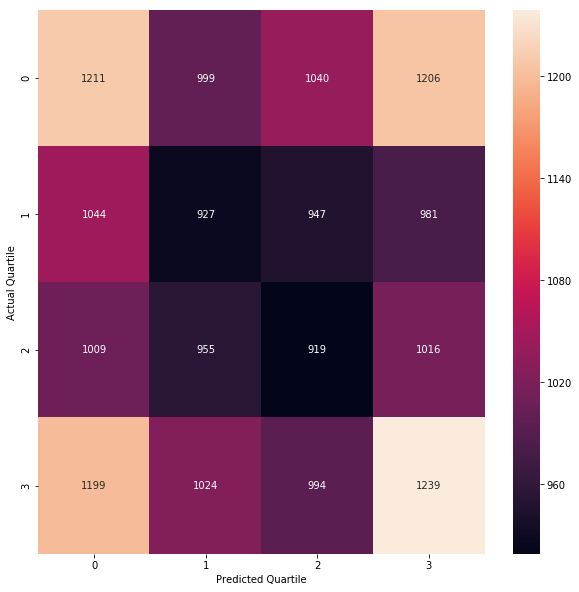

---
01:01:40 Running experiment 149 of 216
(1000, 3, 0.01, 0.7)
01:01:40 Generate splits [140, 280, 419, 558, 697]
classify
01:01:40 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.271%
Monthly Sharpe ratio: 0.079
Avg rank correlation (Kendall's tau): 0.0064 (Expected: 0)
4-quartile accuracy: 0.2567 (Expected: 0.25)
Long/short/flat accuracy: 0.3712 (Expected: 0.375)


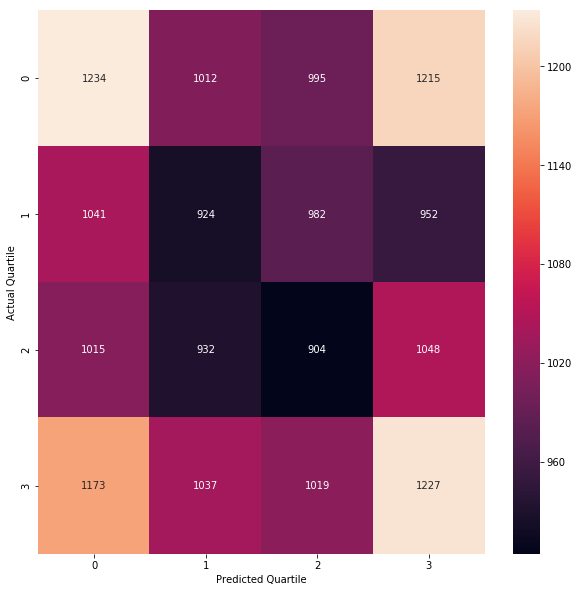

---
01:02:18 Running experiment 150 of 216
(1000, 3, 0.01, 0.8)
01:02:18 Generate splits [140, 280, 419, 558, 697]
classify
01:02:18 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.027%
Monthly Sharpe ratio: 0.029
Avg rank correlation (Kendall's tau): -0.0023 (Expected: 0)
4-quartile accuracy: 0.2545 (Expected: 0.25)
Long/short/flat accuracy: 0.3685 (Expected: 0.375)


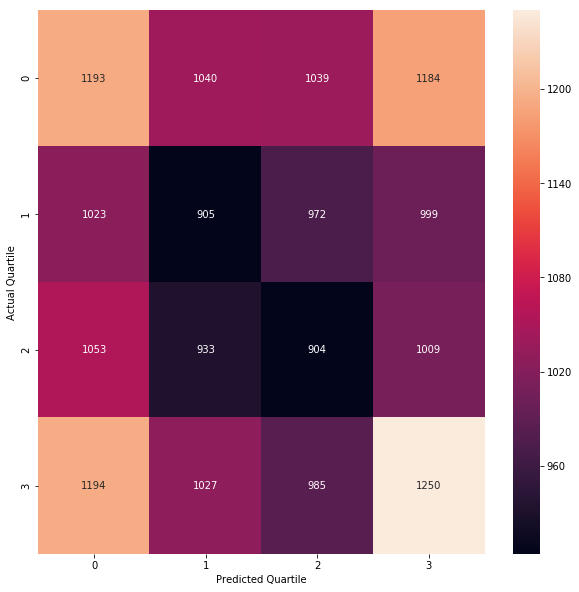

---
01:02:55 Running experiment 151 of 216
(1000, 3, 0.003, 0.6)
01:02:55 Generate splits [140, 280, 419, 558, 697]
classify
01:02:55 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.610%
Monthly Sharpe ratio: 0.148
Avg rank correlation (Kendall's tau): 0.0127 (Expected: 0)
4-quartile accuracy: 0.2692 (Expected: 0.25)
Long/short/flat accuracy: 0.3825 (Expected: 0.375)


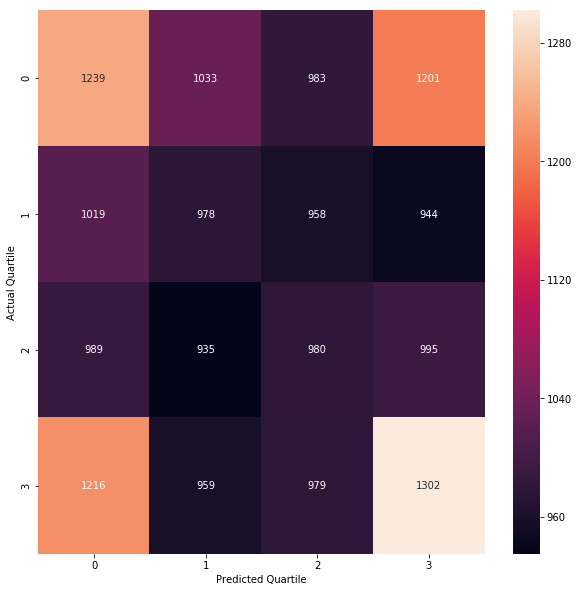

---
01:03:30 Running experiment 152 of 216
(1000, 3, 0.003, 0.7)
01:03:30 Generate splits [140, 280, 419, 558, 697]
classify
01:03:30 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 1.233%
Monthly Sharpe ratio: 0.282
Avg rank correlation (Kendall's tau): 0.0098 (Expected: 0)
4-quartile accuracy: 0.2634 (Expected: 0.25)
Long/short/flat accuracy: 0.3744 (Expected: 0.375)


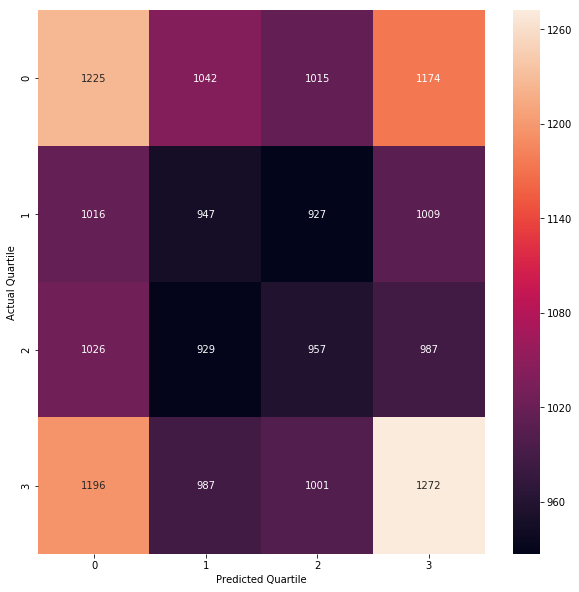

---
01:04:04 Running experiment 153 of 216
(1000, 3, 0.003, 0.8)
01:04:04 Generate splits [140, 280, 419, 558, 697]
classify
01:04:04 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.919%
Monthly Sharpe ratio: 0.207
Avg rank correlation (Kendall's tau): 0.0125 (Expected: 0)
4-quartile accuracy: 0.2687 (Expected: 0.25)
Long/short/flat accuracy: 0.3831 (Expected: 0.375)


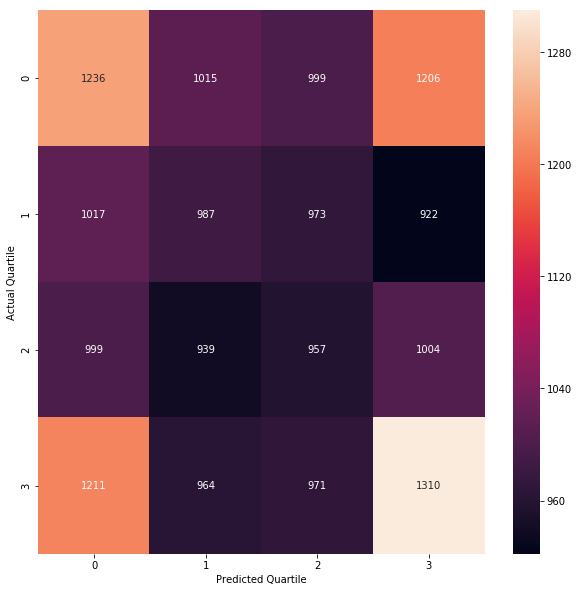

---
01:04:39 Running experiment 154 of 216
(1000, 3, 0.001, 0.6)
01:04:39 Generate splits [140, 280, 419, 558, 697]
classify
01:04:39 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.204%
Monthly Sharpe ratio: -0.034
Avg rank correlation (Kendall's tau): -0.0039 (Expected: 0)
4-quartile accuracy: 0.2476 (Expected: 0.25)
Long/short/flat accuracy: 0.3567 (Expected: 0.375)


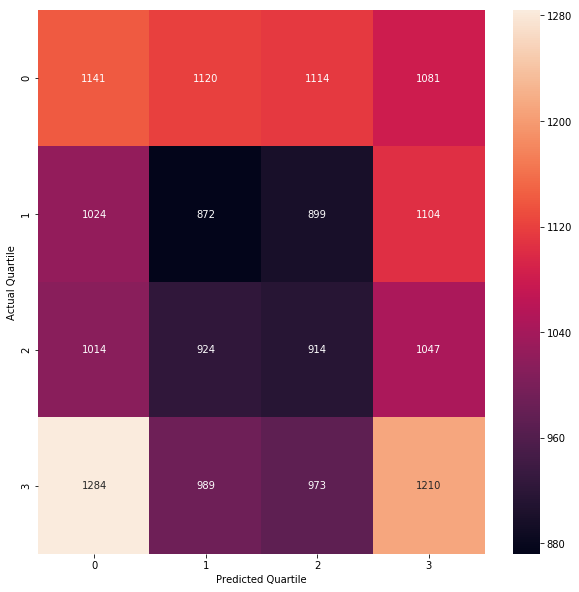

---
01:05:13 Running experiment 155 of 216
(1000, 3, 0.001, 0.7)
01:05:14 Generate splits [140, 280, 419, 558, 697]
classify
01:05:14 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.814%
Monthly Sharpe ratio: 0.204
Avg rank correlation (Kendall's tau): 0.0004 (Expected: 0)
4-quartile accuracy: 0.2508 (Expected: 0.25)
Long/short/flat accuracy: 0.3652 (Expected: 0.375)


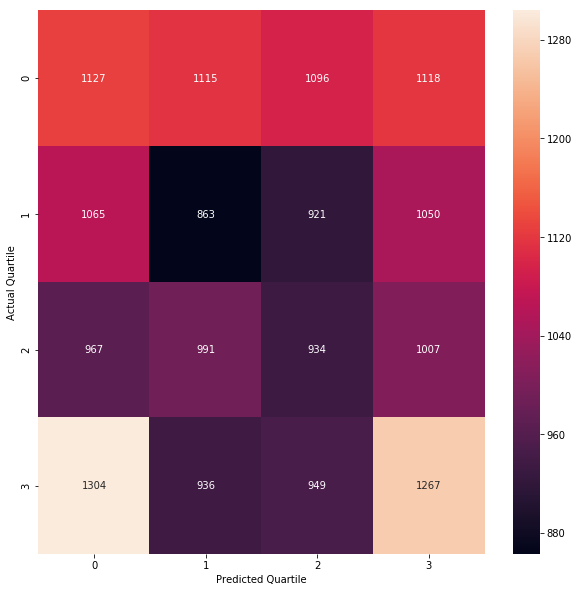

---
01:05:48 Running experiment 156 of 216
(1000, 3, 0.001, 0.8)
01:05:48 Generate splits [140, 280, 419, 558, 697]
classify
01:05:48 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.002%
Monthly Sharpe ratio: 0.019
Avg rank correlation (Kendall's tau): -0.0014 (Expected: 0)
4-quartile accuracy: 0.2513 (Expected: 0.25)
Long/short/flat accuracy: 0.3591 (Expected: 0.375)


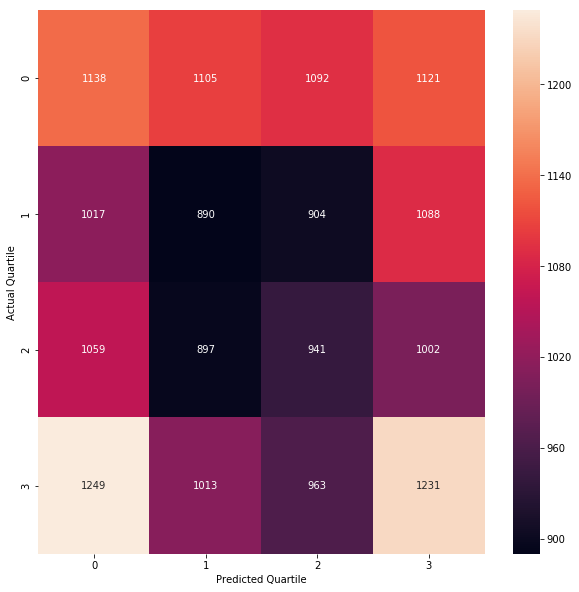

---
01:06:22 Running experiment 157 of 216
(1000, 3, 0.0003, 0.6)
01:06:22 Generate splits [140, 280, 419, 558, 697]
classify
01:06:22 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.417%
Monthly Sharpe ratio: -0.079
Avg rank correlation (Kendall's tau): 0.0017 (Expected: 0)
4-quartile accuracy: 0.2575 (Expected: 0.25)
Long/short/flat accuracy: 0.3620 (Expected: 0.375)


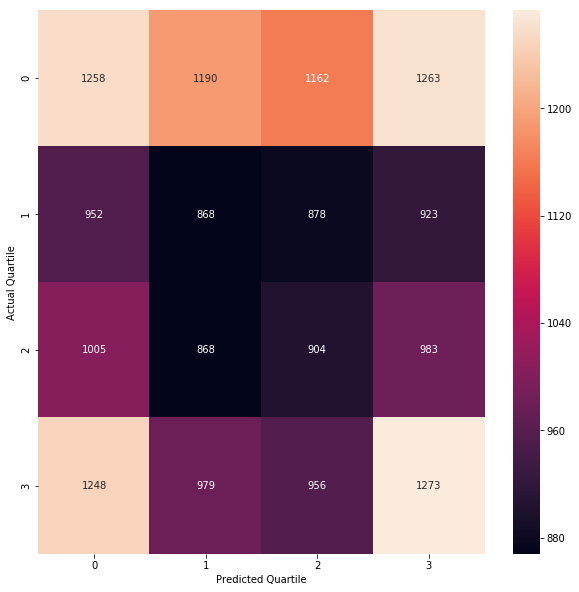

---
01:06:56 Running experiment 158 of 216
(1000, 3, 0.0003, 0.7)
01:06:56 Generate splits [140, 280, 419, 558, 697]
classify
01:06:56 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.417%
Monthly Sharpe ratio: -0.079
Avg rank correlation (Kendall's tau): 0.0052 (Expected: 0)
4-quartile accuracy: 0.2513 (Expected: 0.25)
Long/short/flat accuracy: 0.3583 (Expected: 0.375)


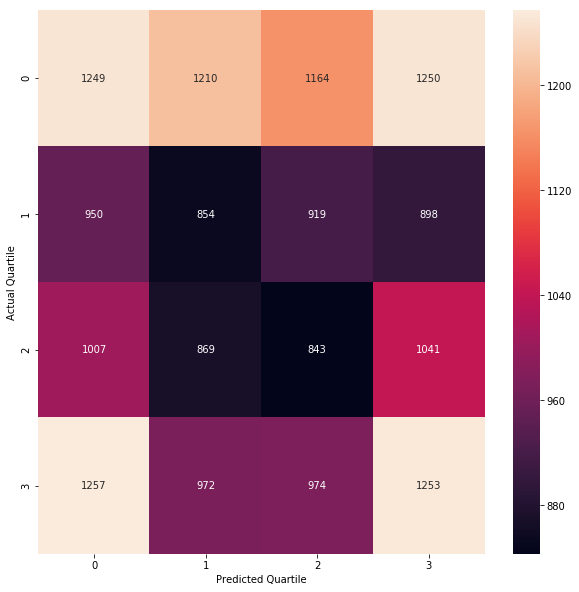

---
01:07:30 Running experiment 159 of 216
(1000, 3, 0.0003, 0.8)
01:07:30 Generate splits [140, 280, 419, 558, 697]
classify
01:07:30 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.417%
Monthly Sharpe ratio: -0.079
Avg rank correlation (Kendall's tau): 0.0031 (Expected: 0)
4-quartile accuracy: 0.2584 (Expected: 0.25)
Long/short/flat accuracy: 0.3643 (Expected: 0.375)


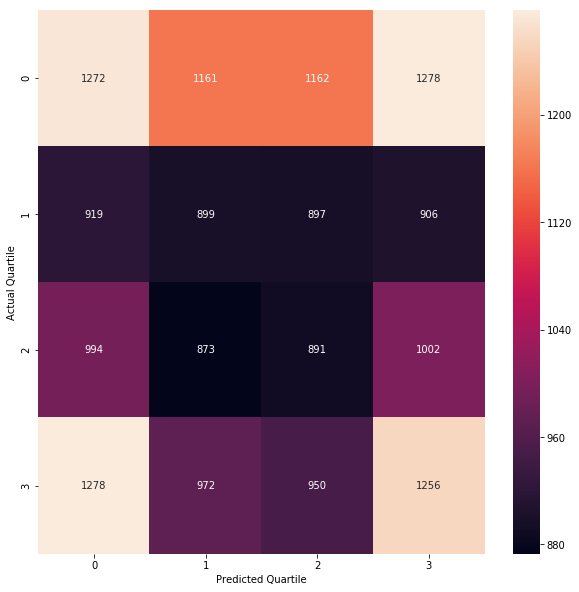

---
01:08:04 Running experiment 160 of 216
(1000, 3, 0.0001, 0.6)
01:08:04 Generate splits [140, 280, 419, 558, 697]
classify
01:08:04 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): -0.0043 (Expected: 0)
4-quartile accuracy: 0.2457 (Expected: 0.25)
Long/short/flat accuracy: 0.3546 (Expected: 0.375)


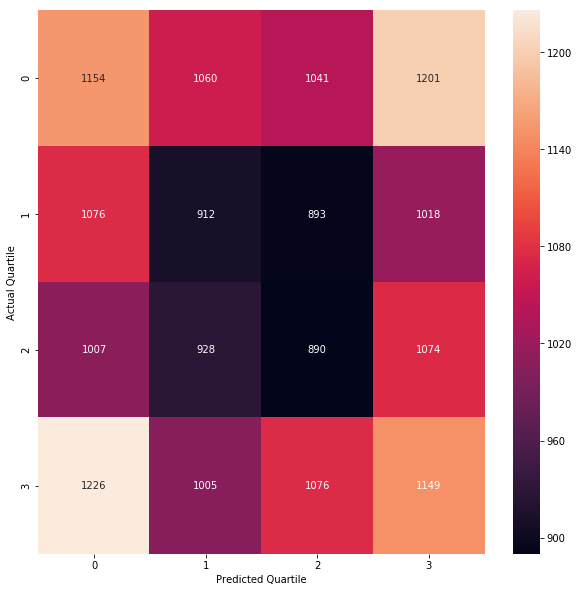

---
01:08:37 Running experiment 161 of 216
(1000, 3, 0.0001, 0.7)
01:08:37 Generate splits [140, 280, 419, 558, 697]
classify
01:08:37 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): 0.0016 (Expected: 0)
4-quartile accuracy: 0.2537 (Expected: 0.25)
Long/short/flat accuracy: 0.3648 (Expected: 0.375)


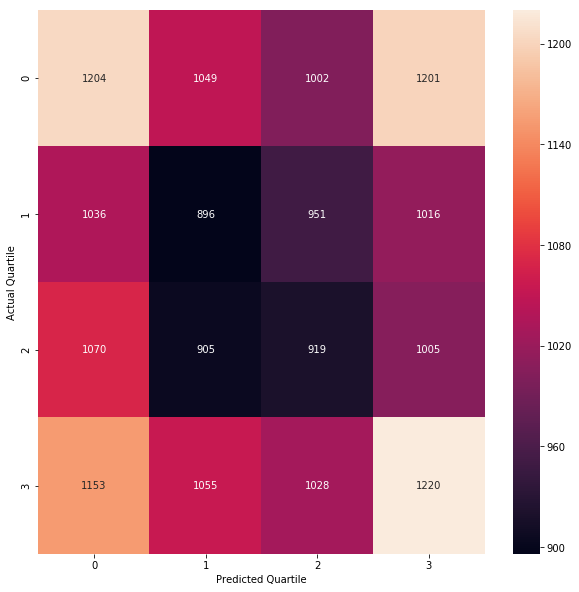

---
01:09:10 Running experiment 162 of 216
(1000, 3, 0.0001, 0.8)
01:09:10 Generate splits [140, 280, 419, 558, 697]
classify
01:09:10 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): 0.0063 (Expected: 0)
4-quartile accuracy: 0.2541 (Expected: 0.25)
Long/short/flat accuracy: 0.3636 (Expected: 0.375)


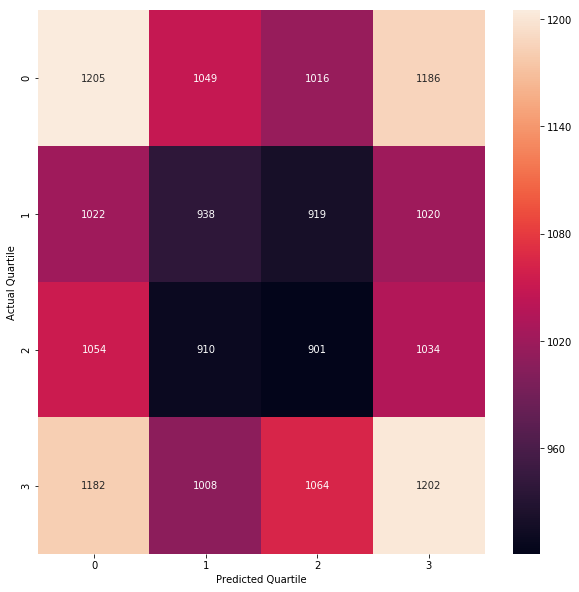

---
01:09:43 Running experiment 163 of 216
(1000, 4, 0.03, 0.6)
01:09:43 Generate splits [140, 280, 419, 558, 697]
classify
01:09:43 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.817%
Monthly Sharpe ratio: 0.210
Avg rank correlation (Kendall's tau): 0.0087 (Expected: 0)
4-quartile accuracy: 0.2642 (Expected: 0.25)
Long/short/flat accuracy: 0.3770 (Expected: 0.375)


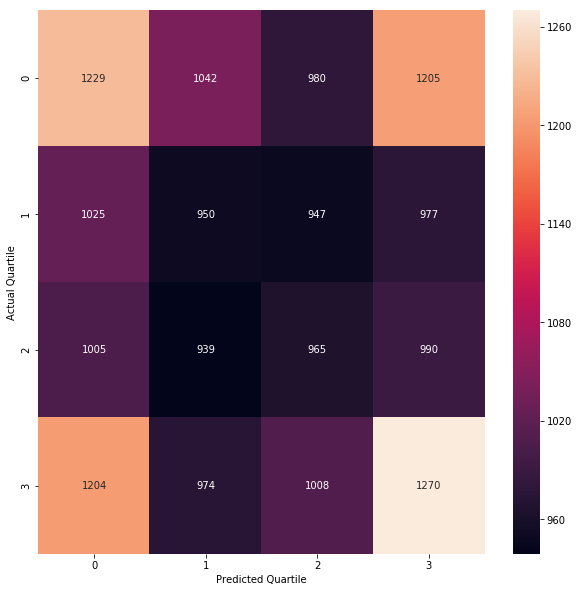

---
01:10:29 Running experiment 164 of 216
(1000, 4, 0.03, 0.7)
01:10:29 Generate splits [140, 280, 419, 558, 697]
classify
01:10:29 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.176%
Monthly Sharpe ratio: -0.017
Avg rank correlation (Kendall's tau): -0.0009 (Expected: 0)
4-quartile accuracy: 0.2557 (Expected: 0.25)
Long/short/flat accuracy: 0.3646 (Expected: 0.375)


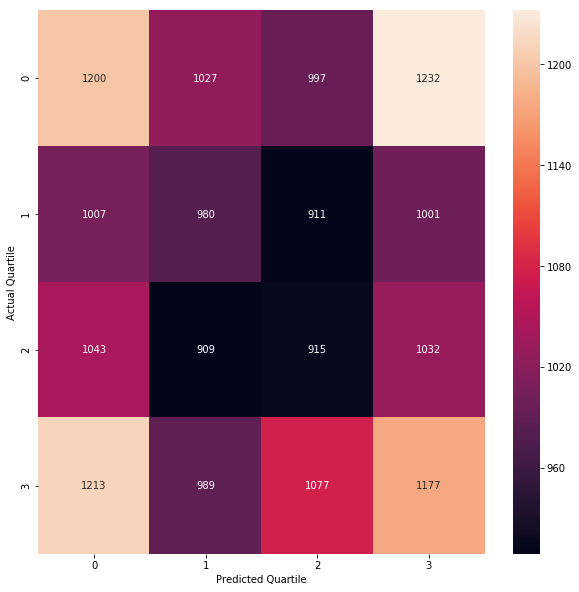

---
01:11:14 Running experiment 165 of 216
(1000, 4, 0.03, 0.8)
01:11:14 Generate splits [140, 280, 419, 558, 697]
classify
01:11:14 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.968%
Monthly Sharpe ratio: 0.234
Avg rank correlation (Kendall's tau): 0.0144 (Expected: 0)
4-quartile accuracy: 0.2637 (Expected: 0.25)
Long/short/flat accuracy: 0.3738 (Expected: 0.375)


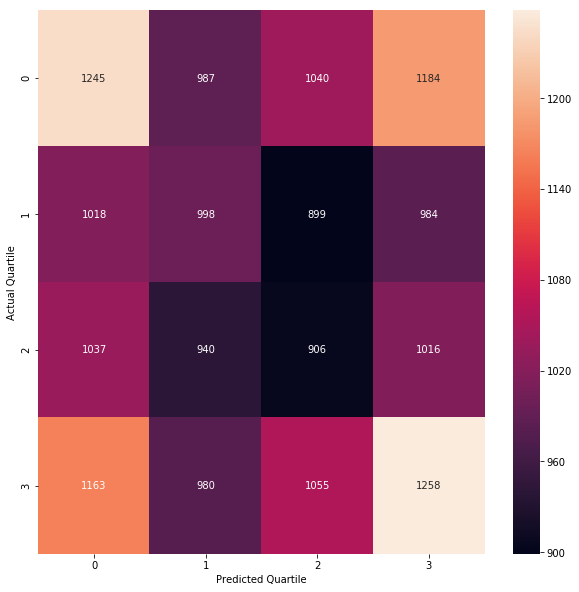

---
01:11:58 Running experiment 166 of 216
(1000, 4, 0.01, 0.6)
01:11:58 Generate splits [140, 280, 419, 558, 697]
classify
01:11:58 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.650%
Monthly Sharpe ratio: 0.152
Avg rank correlation (Kendall's tau): 0.0039 (Expected: 0)
4-quartile accuracy: 0.2571 (Expected: 0.25)
Long/short/flat accuracy: 0.3709 (Expected: 0.375)


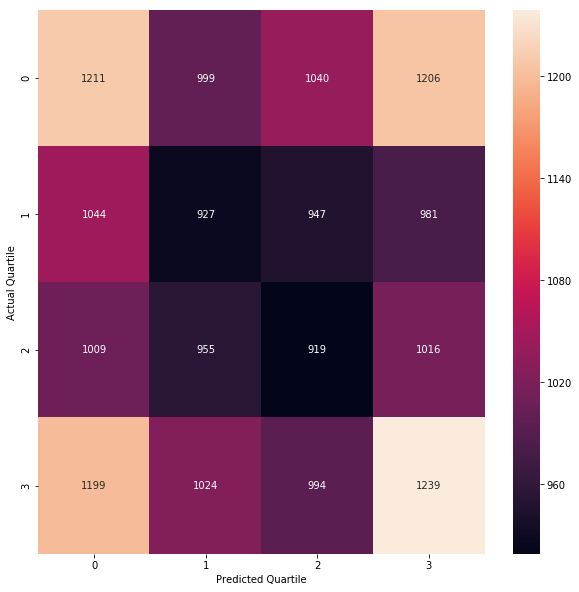

---
01:12:35 Running experiment 167 of 216
(1000, 4, 0.01, 0.7)
01:12:35 Generate splits [140, 280, 419, 558, 697]
classify
01:12:35 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.271%
Monthly Sharpe ratio: 0.079
Avg rank correlation (Kendall's tau): 0.0064 (Expected: 0)
4-quartile accuracy: 0.2567 (Expected: 0.25)
Long/short/flat accuracy: 0.3712 (Expected: 0.375)


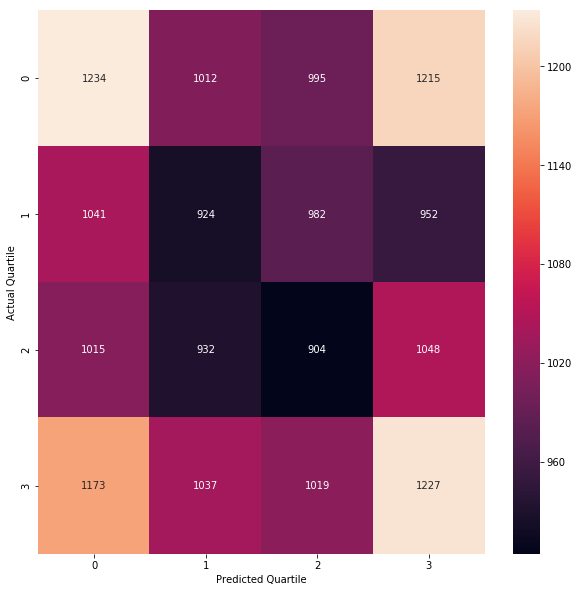

---
01:13:12 Running experiment 168 of 216
(1000, 4, 0.01, 0.8)
01:13:12 Generate splits [140, 280, 419, 558, 697]
classify
01:13:12 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.027%
Monthly Sharpe ratio: 0.029
Avg rank correlation (Kendall's tau): -0.0023 (Expected: 0)
4-quartile accuracy: 0.2545 (Expected: 0.25)
Long/short/flat accuracy: 0.3685 (Expected: 0.375)


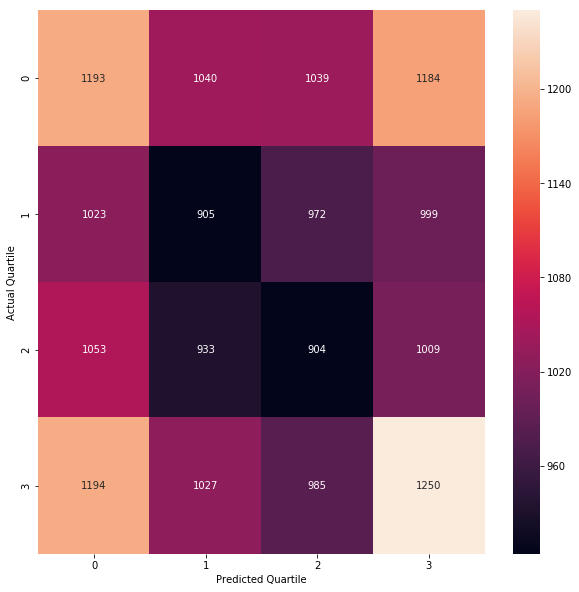

---
01:13:49 Running experiment 169 of 216
(1000, 4, 0.003, 0.6)
01:13:49 Generate splits [140, 280, 419, 558, 697]
classify
01:13:49 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.610%
Monthly Sharpe ratio: 0.148
Avg rank correlation (Kendall's tau): 0.0127 (Expected: 0)
4-quartile accuracy: 0.2692 (Expected: 0.25)
Long/short/flat accuracy: 0.3825 (Expected: 0.375)


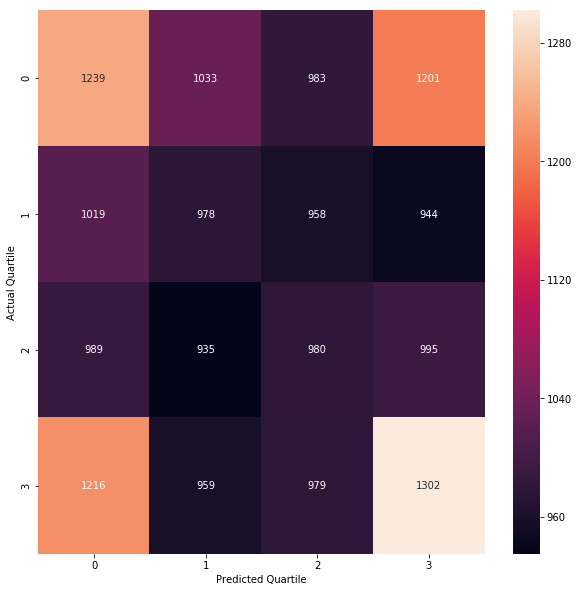

---
01:14:23 Running experiment 170 of 216
(1000, 4, 0.003, 0.7)
01:14:23 Generate splits [140, 280, 419, 558, 697]
classify
01:14:23 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 1.233%
Monthly Sharpe ratio: 0.282
Avg rank correlation (Kendall's tau): 0.0098 (Expected: 0)
4-quartile accuracy: 0.2634 (Expected: 0.25)
Long/short/flat accuracy: 0.3744 (Expected: 0.375)


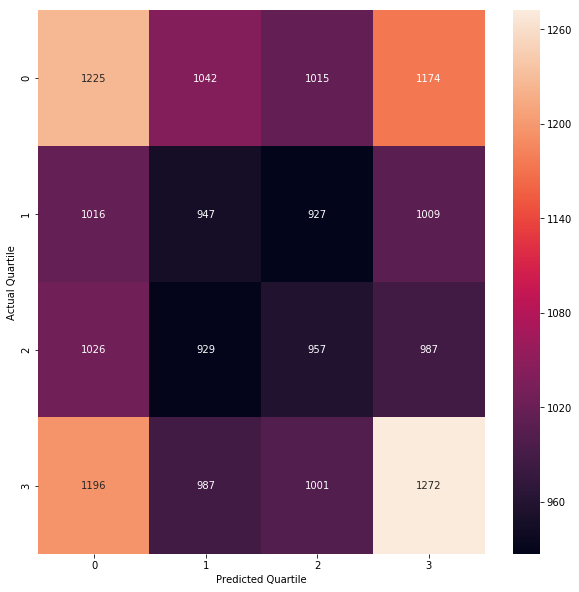

---
01:14:58 Running experiment 171 of 216
(1000, 4, 0.003, 0.8)
01:14:58 Generate splits [140, 280, 419, 558, 697]
classify
01:14:58 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.919%
Monthly Sharpe ratio: 0.207
Avg rank correlation (Kendall's tau): 0.0125 (Expected: 0)
4-quartile accuracy: 0.2687 (Expected: 0.25)
Long/short/flat accuracy: 0.3831 (Expected: 0.375)


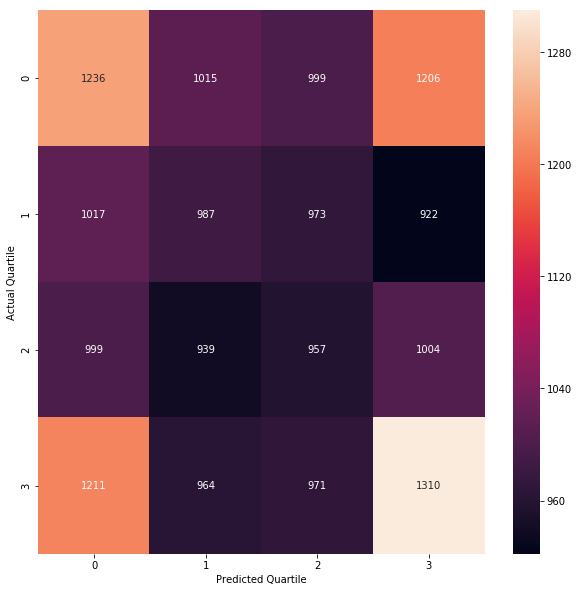

---
01:15:33 Running experiment 172 of 216
(1000, 4, 0.001, 0.6)
01:15:33 Generate splits [140, 280, 419, 558, 697]
classify
01:15:33 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.204%
Monthly Sharpe ratio: -0.034
Avg rank correlation (Kendall's tau): -0.0038 (Expected: 0)
4-quartile accuracy: 0.2484 (Expected: 0.25)
Long/short/flat accuracy: 0.3570 (Expected: 0.375)


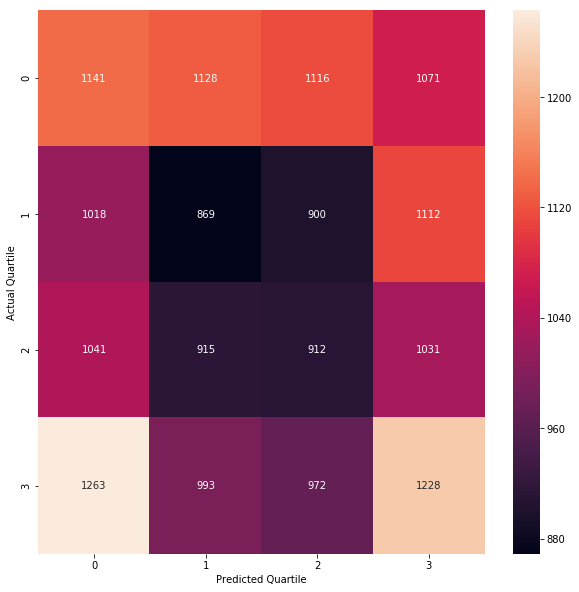

---
01:16:07 Running experiment 173 of 216
(1000, 4, 0.001, 0.7)
01:16:07 Generate splits [140, 280, 419, 558, 697]
classify
01:16:07 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.814%
Monthly Sharpe ratio: 0.204
Avg rank correlation (Kendall's tau): 0.0004 (Expected: 0)
4-quartile accuracy: 0.2557 (Expected: 0.25)
Long/short/flat accuracy: 0.3682 (Expected: 0.375)


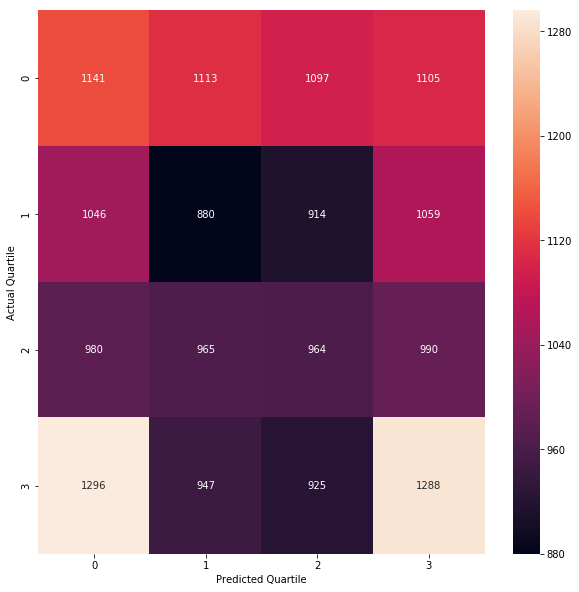

---
01:16:41 Running experiment 174 of 216
(1000, 4, 0.001, 0.8)
01:16:41 Generate splits [140, 280, 419, 558, 697]
classify
01:16:41 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.002%
Monthly Sharpe ratio: 0.019
Avg rank correlation (Kendall's tau): -0.0031 (Expected: 0)
4-quartile accuracy: 0.2500 (Expected: 0.25)
Long/short/flat accuracy: 0.3589 (Expected: 0.375)


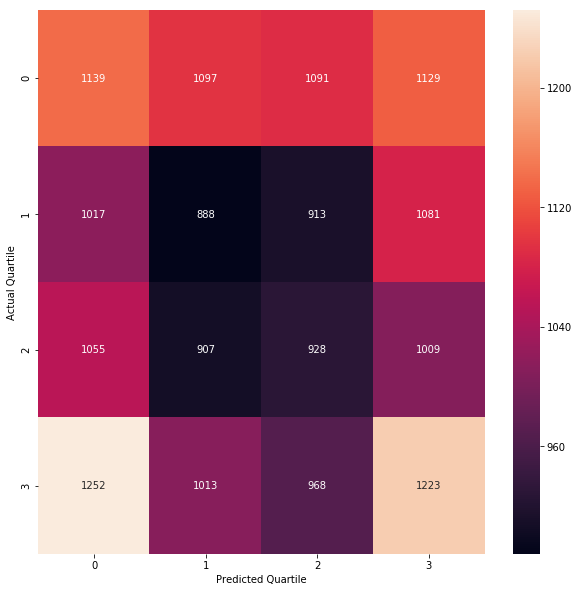

---
01:17:15 Running experiment 175 of 216
(1000, 4, 0.0003, 0.6)
01:17:15 Generate splits [140, 280, 419, 558, 697]
classify
01:17:15 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.417%
Monthly Sharpe ratio: -0.079
Avg rank correlation (Kendall's tau): 0.0004 (Expected: 0)
4-quartile accuracy: 0.2563 (Expected: 0.25)
Long/short/flat accuracy: 0.3630 (Expected: 0.375)


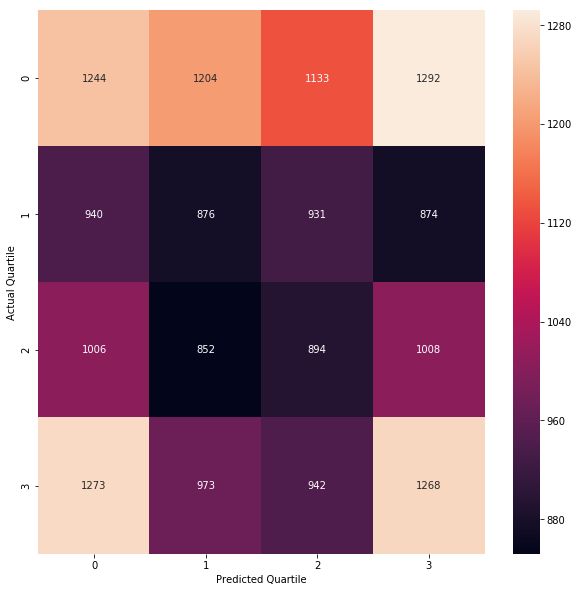

---
01:17:49 Running experiment 176 of 216
(1000, 4, 0.0003, 0.7)
01:17:49 Generate splits [140, 280, 419, 558, 697]
classify
01:17:49 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.417%
Monthly Sharpe ratio: -0.079
Avg rank correlation (Kendall's tau): -0.0015 (Expected: 0)
4-quartile accuracy: 0.2534 (Expected: 0.25)
Long/short/flat accuracy: 0.3610 (Expected: 0.375)


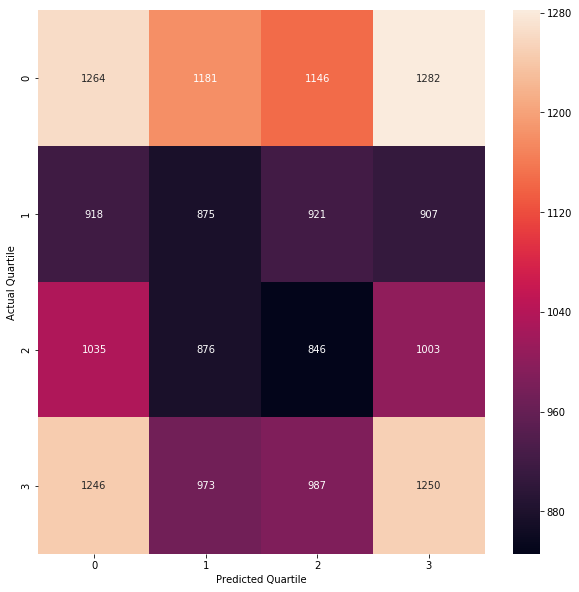

---
01:18:23 Running experiment 177 of 216
(1000, 4, 0.0003, 0.8)
01:18:24 Generate splits [140, 280, 419, 558, 697]
classify
01:18:24 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.417%
Monthly Sharpe ratio: -0.079
Avg rank correlation (Kendall's tau): 0.0023 (Expected: 0)
4-quartile accuracy: 0.2575 (Expected: 0.25)
Long/short/flat accuracy: 0.3640 (Expected: 0.375)


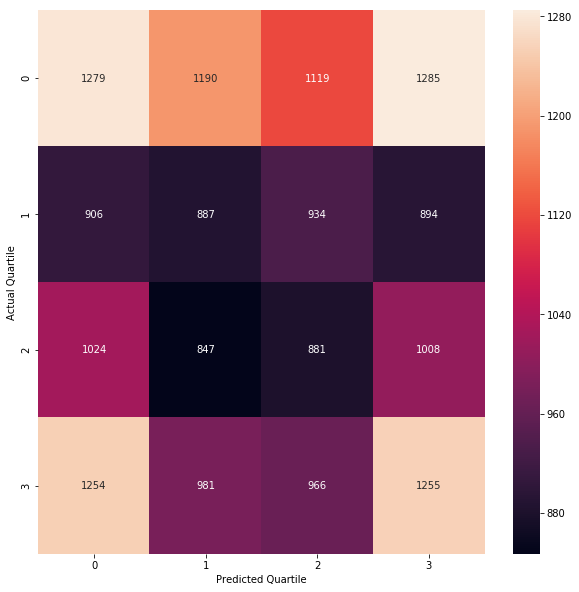

---
01:18:58 Running experiment 178 of 216
(1000, 4, 0.0001, 0.6)
01:18:58 Generate splits [140, 280, 419, 558, 697]
classify
01:18:58 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): -0.0080 (Expected: 0)
4-quartile accuracy: 0.2522 (Expected: 0.25)
Long/short/flat accuracy: 0.3603 (Expected: 0.375)


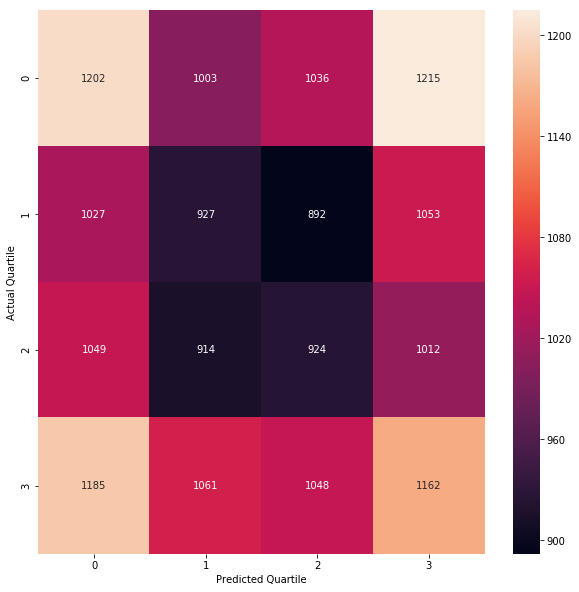

---
01:19:31 Running experiment 179 of 216
(1000, 4, 0.0001, 0.7)
01:19:31 Generate splits [140, 280, 419, 558, 697]
classify
01:19:31 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): -0.0042 (Expected: 0)
4-quartile accuracy: 0.2506 (Expected: 0.25)
Long/short/flat accuracy: 0.3598 (Expected: 0.375)


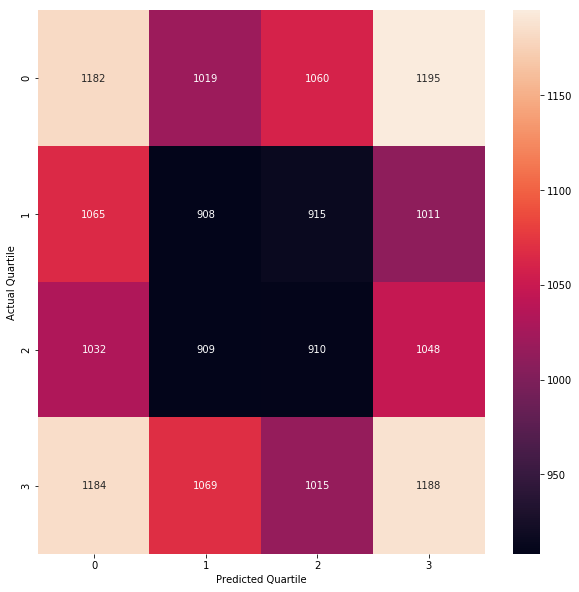

---
01:20:04 Running experiment 180 of 216
(1000, 4, 0.0001, 0.8)
01:20:04 Generate splits [140, 280, 419, 558, 697]
classify
01:20:04 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): -0.0068 (Expected: 0)
4-quartile accuracy: 0.2482 (Expected: 0.25)
Long/short/flat accuracy: 0.3545 (Expected: 0.375)


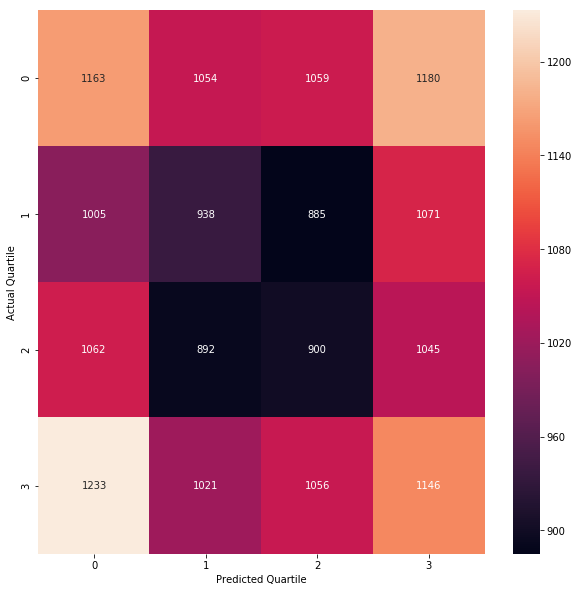

---
01:20:38 Running experiment 181 of 216
(1000, 5, 0.03, 0.6)
01:20:38 Generate splits [140, 280, 419, 558, 697]
classify
01:20:38 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.817%
Monthly Sharpe ratio: 0.210
Avg rank correlation (Kendall's tau): 0.0087 (Expected: 0)
4-quartile accuracy: 0.2642 (Expected: 0.25)
Long/short/flat accuracy: 0.3770 (Expected: 0.375)


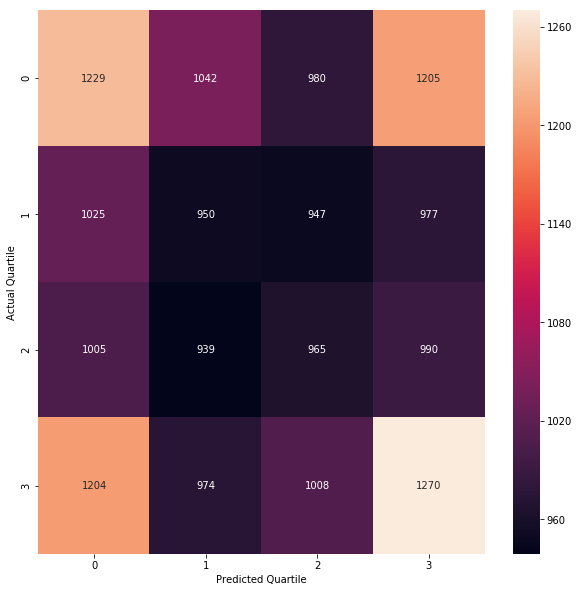

---
01:21:24 Running experiment 182 of 216
(1000, 5, 0.03, 0.7)
01:21:24 Generate splits [140, 280, 419, 558, 697]
classify
01:21:24 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.176%
Monthly Sharpe ratio: -0.017
Avg rank correlation (Kendall's tau): -0.0009 (Expected: 0)
4-quartile accuracy: 0.2557 (Expected: 0.25)
Long/short/flat accuracy: 0.3646 (Expected: 0.375)


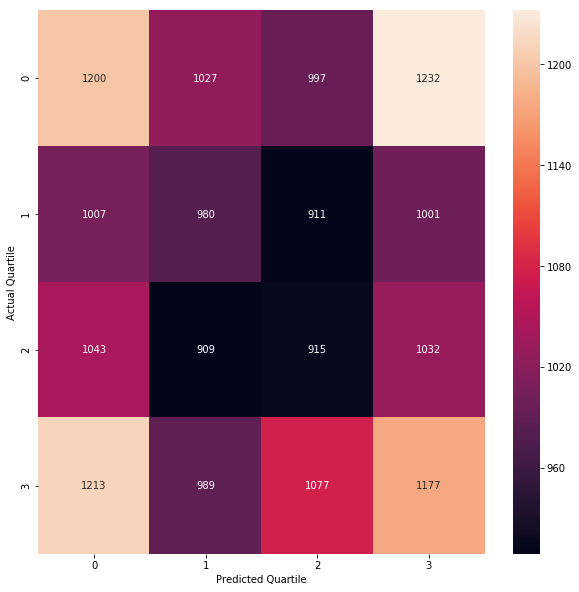

---
01:22:08 Running experiment 183 of 216
(1000, 5, 0.03, 0.8)
01:22:08 Generate splits [140, 280, 419, 558, 697]
classify
01:22:08 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.968%
Monthly Sharpe ratio: 0.234
Avg rank correlation (Kendall's tau): 0.0144 (Expected: 0)
4-quartile accuracy: 0.2637 (Expected: 0.25)
Long/short/flat accuracy: 0.3738 (Expected: 0.375)


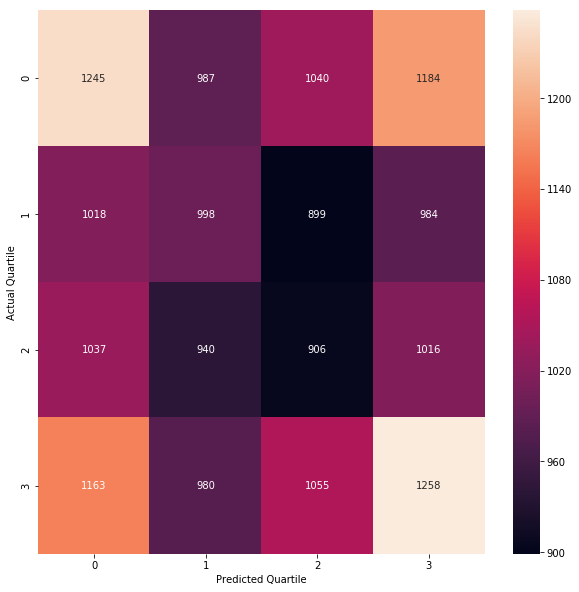

---
01:22:51 Running experiment 184 of 216
(1000, 5, 0.01, 0.6)
01:22:51 Generate splits [140, 280, 419, 558, 697]
classify
01:22:51 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.650%
Monthly Sharpe ratio: 0.152
Avg rank correlation (Kendall's tau): 0.0039 (Expected: 0)
4-quartile accuracy: 0.2571 (Expected: 0.25)
Long/short/flat accuracy: 0.3709 (Expected: 0.375)


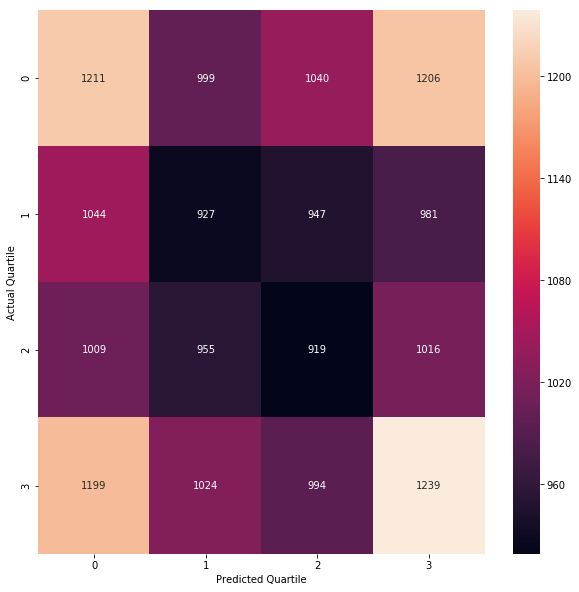

---
01:23:29 Running experiment 185 of 216
(1000, 5, 0.01, 0.7)
01:23:29 Generate splits [140, 280, 419, 558, 697]
classify
01:23:29 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.271%
Monthly Sharpe ratio: 0.079
Avg rank correlation (Kendall's tau): 0.0064 (Expected: 0)
4-quartile accuracy: 0.2567 (Expected: 0.25)
Long/short/flat accuracy: 0.3712 (Expected: 0.375)


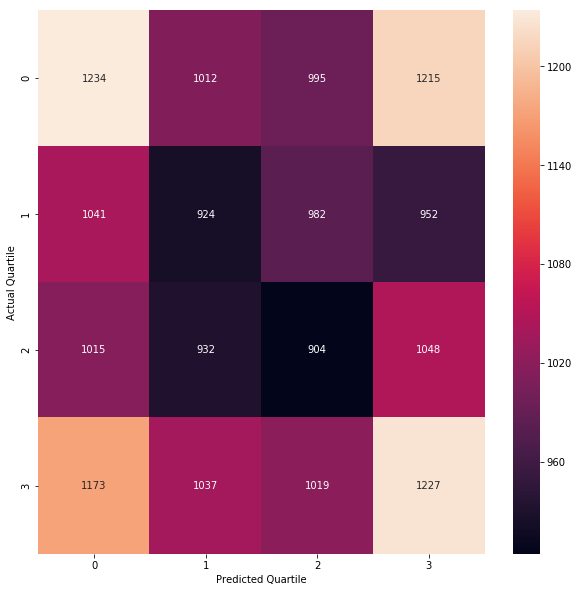

---
01:24:06 Running experiment 186 of 216
(1000, 5, 0.01, 0.8)
01:24:06 Generate splits [140, 280, 419, 558, 697]
classify
01:24:06 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.027%
Monthly Sharpe ratio: 0.029
Avg rank correlation (Kendall's tau): -0.0023 (Expected: 0)
4-quartile accuracy: 0.2545 (Expected: 0.25)
Long/short/flat accuracy: 0.3685 (Expected: 0.375)


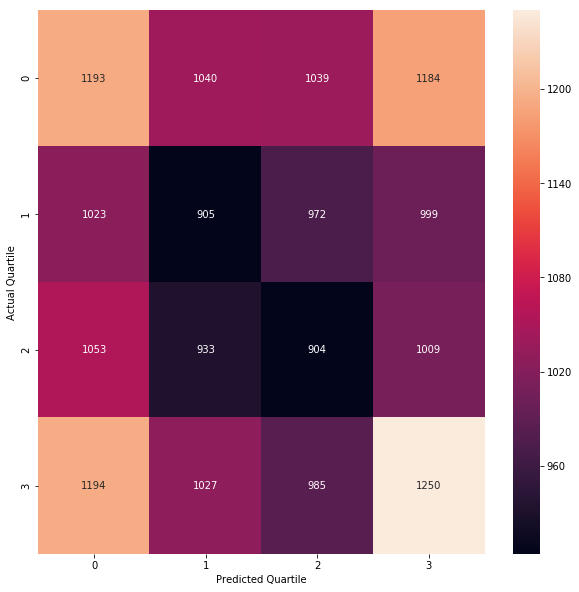

---
01:24:42 Running experiment 187 of 216
(1000, 5, 0.003, 0.6)
01:24:42 Generate splits [140, 280, 419, 558, 697]
classify
01:24:42 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.610%
Monthly Sharpe ratio: 0.148
Avg rank correlation (Kendall's tau): 0.0127 (Expected: 0)
4-quartile accuracy: 0.2692 (Expected: 0.25)
Long/short/flat accuracy: 0.3825 (Expected: 0.375)


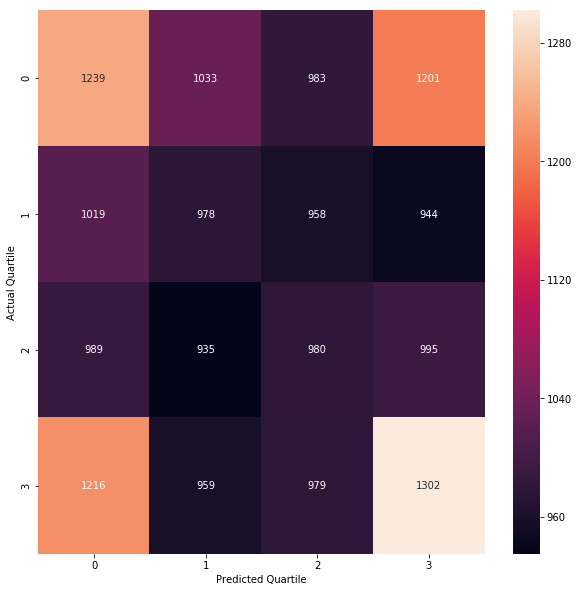

---
01:25:17 Running experiment 188 of 216
(1000, 5, 0.003, 0.7)
01:25:17 Generate splits [140, 280, 419, 558, 697]
classify
01:25:17 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 1.233%
Monthly Sharpe ratio: 0.282
Avg rank correlation (Kendall's tau): 0.0098 (Expected: 0)
4-quartile accuracy: 0.2634 (Expected: 0.25)
Long/short/flat accuracy: 0.3744 (Expected: 0.375)


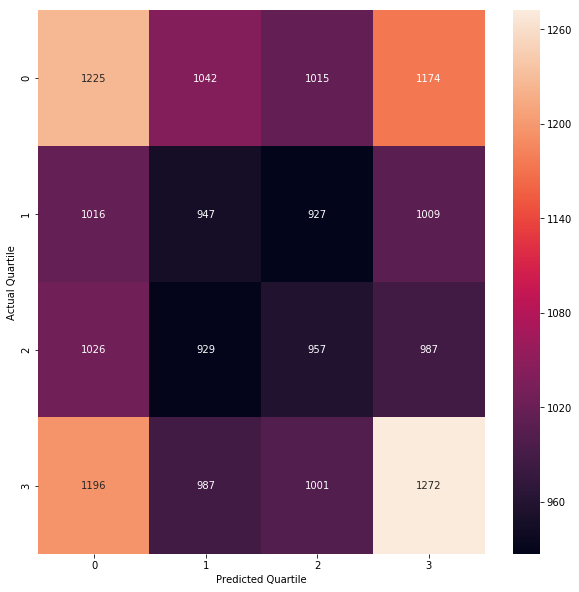

---
01:25:52 Running experiment 189 of 216
(1000, 5, 0.003, 0.8)
01:25:52 Generate splits [140, 280, 419, 558, 697]
classify
01:25:52 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.919%
Monthly Sharpe ratio: 0.207
Avg rank correlation (Kendall's tau): 0.0125 (Expected: 0)
4-quartile accuracy: 0.2687 (Expected: 0.25)
Long/short/flat accuracy: 0.3831 (Expected: 0.375)


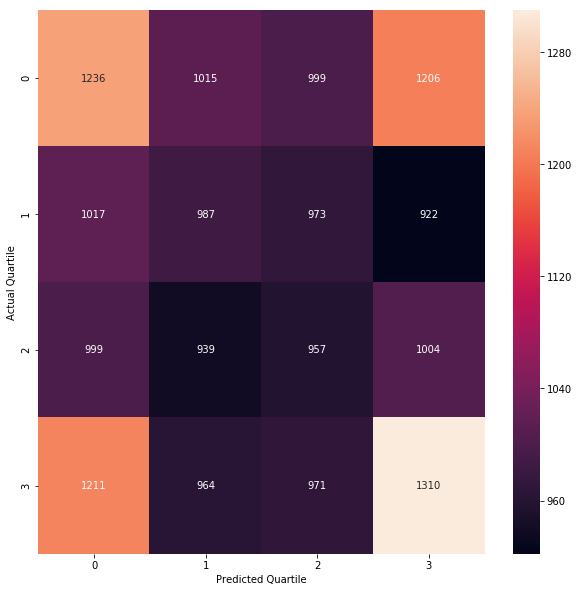

---
01:26:26 Running experiment 190 of 216
(1000, 5, 0.001, 0.6)
01:26:27 Generate splits [140, 280, 419, 558, 697]
classify
01:26:27 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.204%
Monthly Sharpe ratio: -0.034
Avg rank correlation (Kendall's tau): -0.0021 (Expected: 0)
4-quartile accuracy: 0.2467 (Expected: 0.25)
Long/short/flat accuracy: 0.3551 (Expected: 0.375)


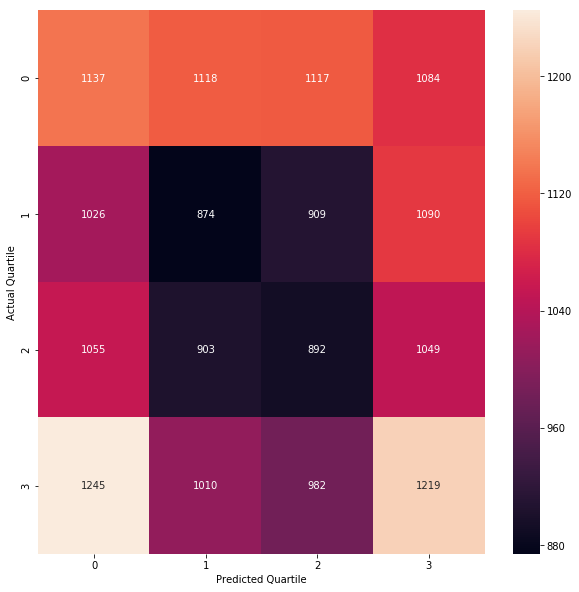

---
01:27:00 Running experiment 191 of 216
(1000, 5, 0.001, 0.7)
01:27:00 Generate splits [140, 280, 419, 558, 697]
classify
01:27:00 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.814%
Monthly Sharpe ratio: 0.204
Avg rank correlation (Kendall's tau): 0.0000 (Expected: 0)
4-quartile accuracy: 0.2515 (Expected: 0.25)
Long/short/flat accuracy: 0.3647 (Expected: 0.375)


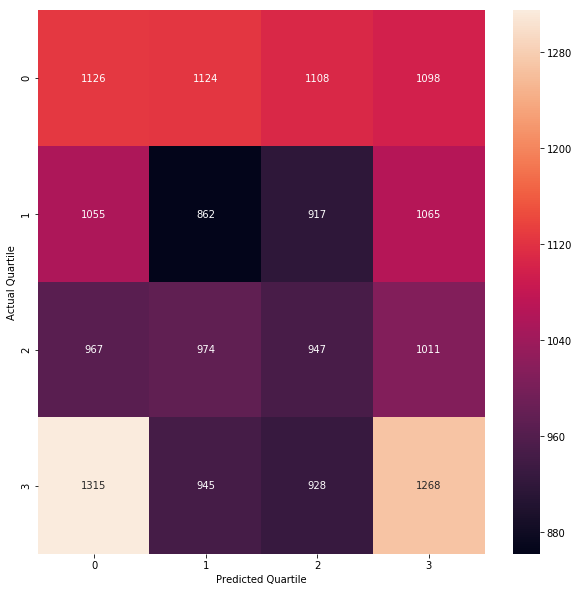

---
01:27:35 Running experiment 192 of 216
(1000, 5, 0.001, 0.8)
01:27:35 Generate splits [140, 280, 419, 558, 697]
classify
01:27:35 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.002%
Monthly Sharpe ratio: 0.019
Avg rank correlation (Kendall's tau): -0.0021 (Expected: 0)
4-quartile accuracy: 0.2487 (Expected: 0.25)
Long/short/flat accuracy: 0.3586 (Expected: 0.375)


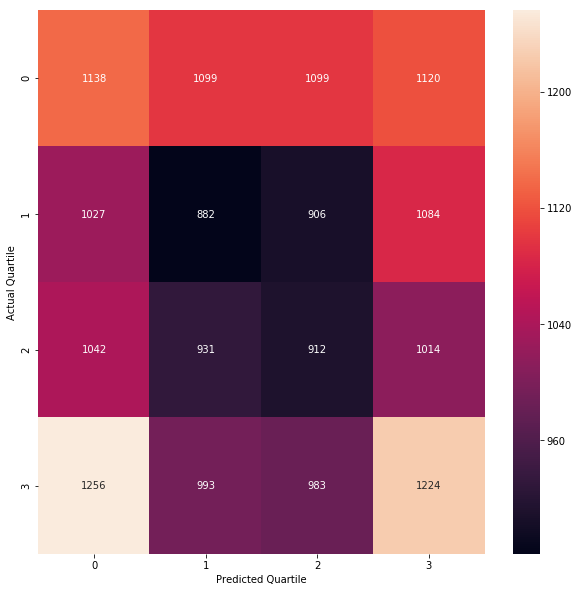

---
01:28:09 Running experiment 193 of 216
(1000, 5, 0.0003, 0.6)
01:28:09 Generate splits [140, 280, 419, 558, 697]
classify
01:28:09 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.417%
Monthly Sharpe ratio: -0.079
Avg rank correlation (Kendall's tau): -0.0017 (Expected: 0)
4-quartile accuracy: 0.2583 (Expected: 0.25)
Long/short/flat accuracy: 0.3634 (Expected: 0.375)


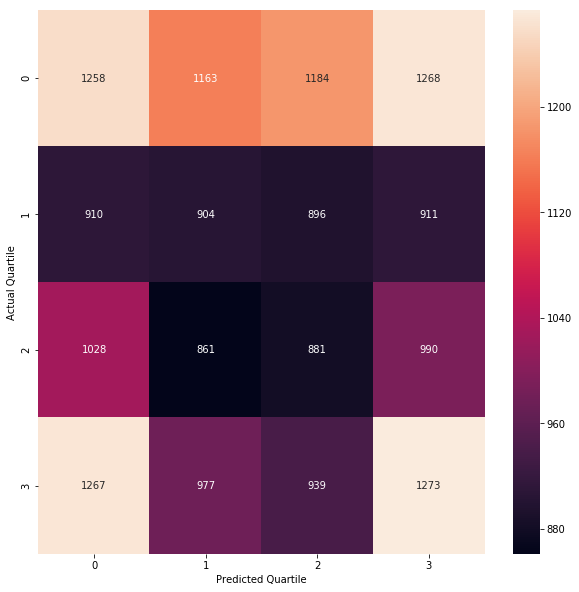

---
01:28:43 Running experiment 194 of 216
(1000, 5, 0.0003, 0.7)
01:28:43 Generate splits [140, 280, 419, 558, 697]
classify
01:28:43 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.417%
Monthly Sharpe ratio: -0.079
Avg rank correlation (Kendall's tau): -0.0001 (Expected: 0)
4-quartile accuracy: 0.2560 (Expected: 0.25)
Long/short/flat accuracy: 0.3609 (Expected: 0.375)


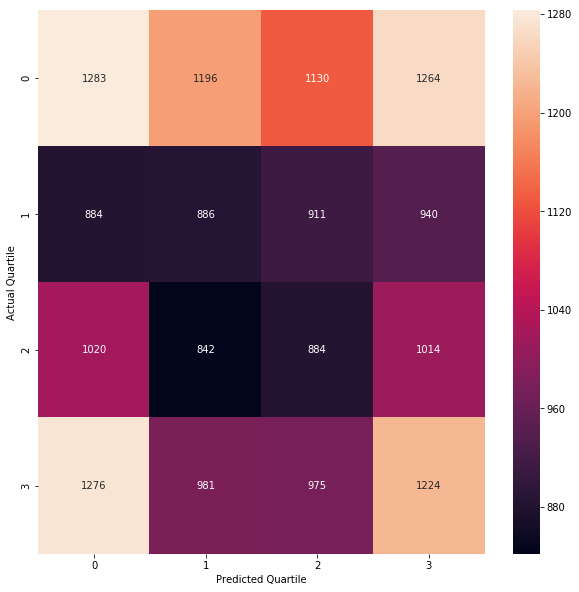

---
01:29:17 Running experiment 195 of 216
(1000, 5, 0.0003, 0.8)
01:29:17 Generate splits [140, 280, 419, 558, 697]
classify
01:29:17 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.417%
Monthly Sharpe ratio: -0.079
Avg rank correlation (Kendall's tau): 0.0026 (Expected: 0)
4-quartile accuracy: 0.2548 (Expected: 0.25)
Long/short/flat accuracy: 0.3591 (Expected: 0.375)


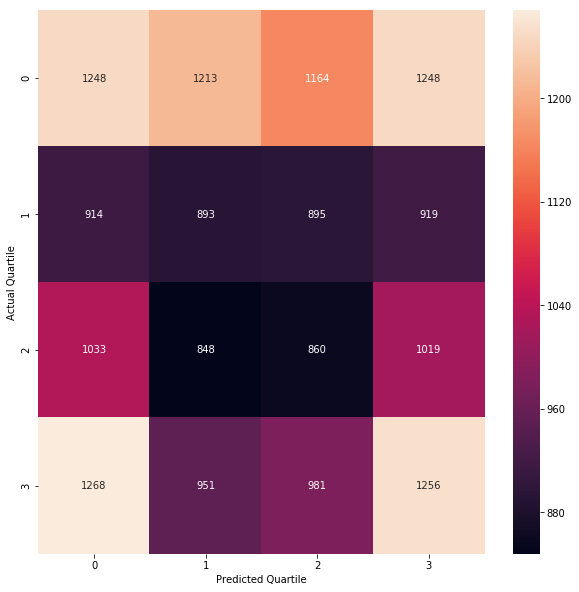

---
01:29:51 Running experiment 196 of 216
(1000, 5, 0.0001, 0.6)
01:29:51 Generate splits [140, 280, 419, 558, 697]
classify
01:29:51 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): -0.0053 (Expected: 0)
4-quartile accuracy: 0.2496 (Expected: 0.25)
Long/short/flat accuracy: 0.3601 (Expected: 0.375)


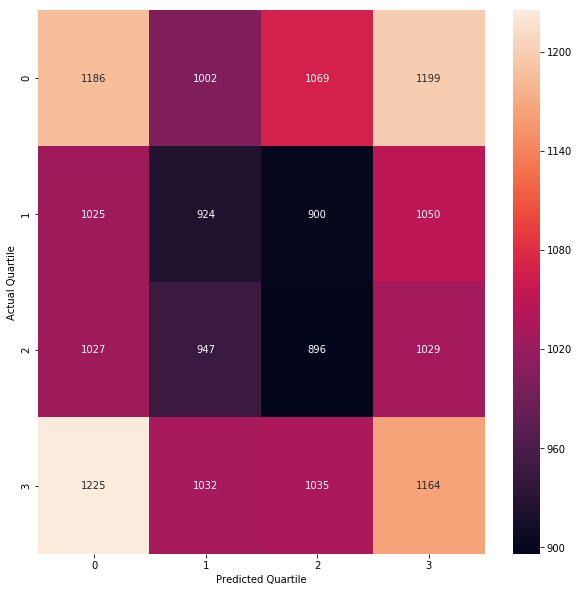

---
01:30:24 Running experiment 197 of 216
(1000, 5, 0.0001, 0.7)
01:30:24 Generate splits [140, 280, 419, 558, 697]
classify
01:30:24 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): 0.0038 (Expected: 0)
4-quartile accuracy: 0.2563 (Expected: 0.25)
Long/short/flat accuracy: 0.3675 (Expected: 0.375)


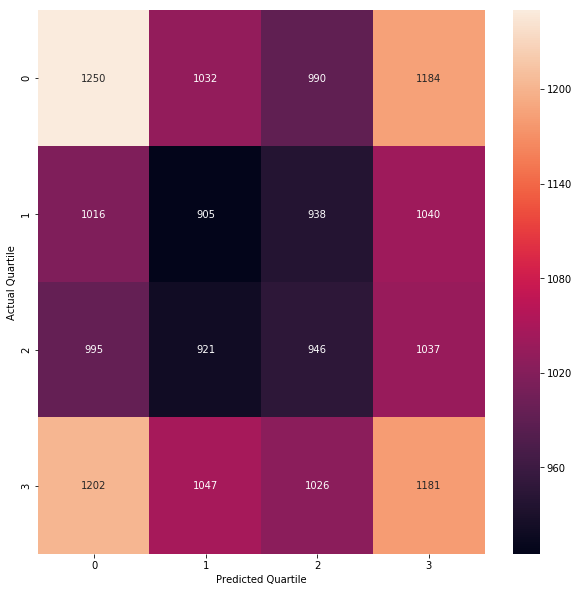

---
01:30:57 Running experiment 198 of 216
(1000, 5, 0.0001, 0.8)
01:30:57 Generate splits [140, 280, 419, 558, 697]
classify
01:30:57 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): 0.0036 (Expected: 0)
4-quartile accuracy: 0.2472 (Expected: 0.25)
Long/short/flat accuracy: 0.3581 (Expected: 0.375)


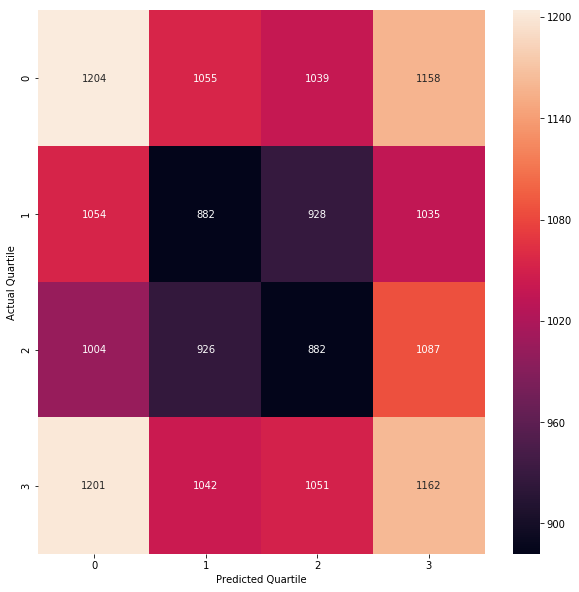

---
01:31:30 Running experiment 199 of 216
(1000, 6, 0.03, 0.6)
01:31:30 Generate splits [140, 280, 419, 558, 697]
classify
01:31:30 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.817%
Monthly Sharpe ratio: 0.210
Avg rank correlation (Kendall's tau): 0.0087 (Expected: 0)
4-quartile accuracy: 0.2642 (Expected: 0.25)
Long/short/flat accuracy: 0.3770 (Expected: 0.375)


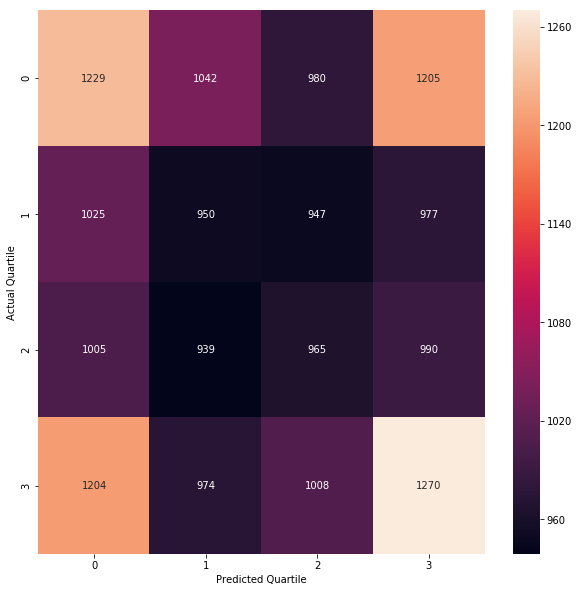

---
01:32:16 Running experiment 200 of 216
(1000, 6, 0.03, 0.7)
01:32:16 Generate splits [140, 280, 419, 558, 697]
classify
01:32:16 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.176%
Monthly Sharpe ratio: -0.017
Avg rank correlation (Kendall's tau): -0.0009 (Expected: 0)
4-quartile accuracy: 0.2557 (Expected: 0.25)
Long/short/flat accuracy: 0.3646 (Expected: 0.375)


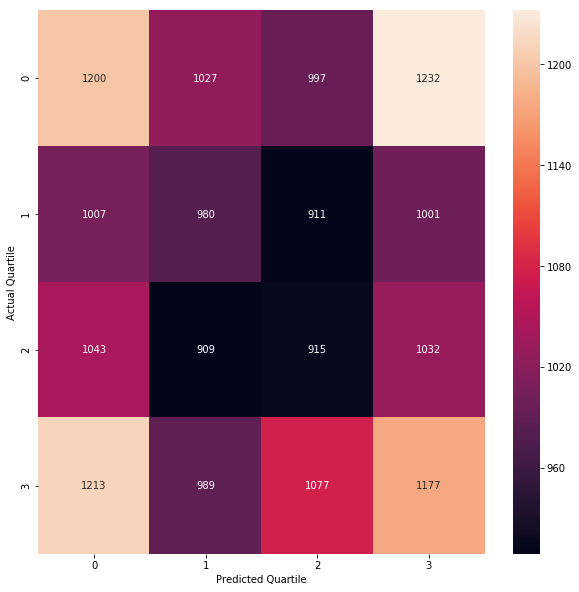

---
01:33:01 Running experiment 201 of 216
(1000, 6, 0.03, 0.8)
01:33:01 Generate splits [140, 280, 419, 558, 697]
classify
01:33:01 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.968%
Monthly Sharpe ratio: 0.234
Avg rank correlation (Kendall's tau): 0.0144 (Expected: 0)
4-quartile accuracy: 0.2637 (Expected: 0.25)
Long/short/flat accuracy: 0.3738 (Expected: 0.375)


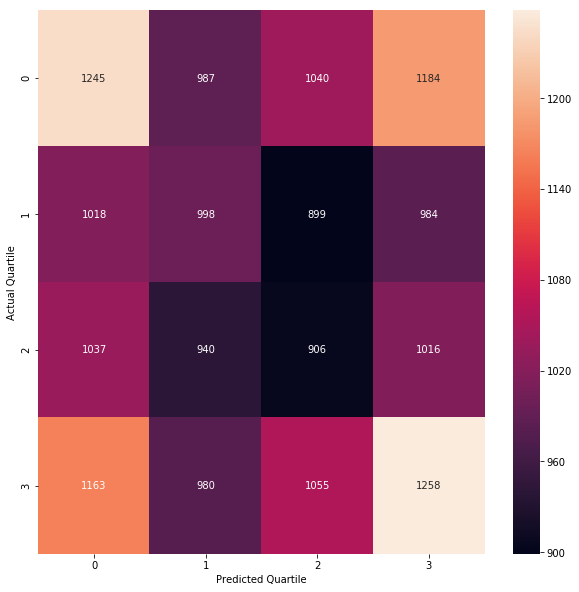

---
01:33:44 Running experiment 202 of 216
(1000, 6, 0.01, 0.6)
01:33:44 Generate splits [140, 280, 419, 558, 697]
classify
01:33:44 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.650%
Monthly Sharpe ratio: 0.152
Avg rank correlation (Kendall's tau): 0.0039 (Expected: 0)
4-quartile accuracy: 0.2571 (Expected: 0.25)
Long/short/flat accuracy: 0.3709 (Expected: 0.375)


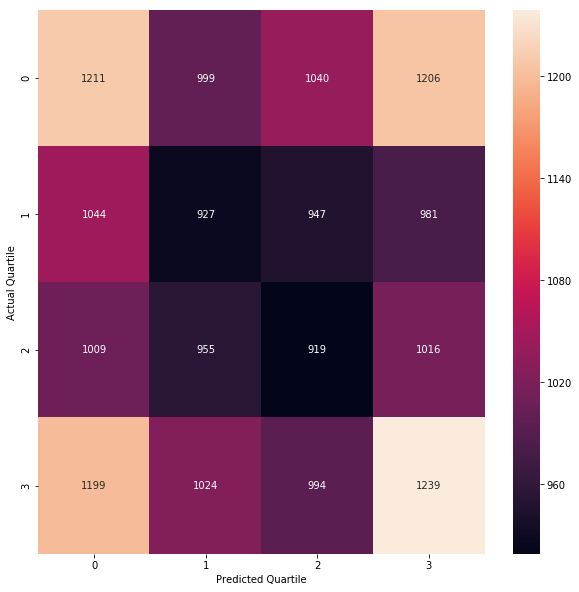

---
01:34:22 Running experiment 203 of 216
(1000, 6, 0.01, 0.7)
01:34:22 Generate splits [140, 280, 419, 558, 697]
classify
01:34:22 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.271%
Monthly Sharpe ratio: 0.079
Avg rank correlation (Kendall's tau): 0.0064 (Expected: 0)
4-quartile accuracy: 0.2567 (Expected: 0.25)
Long/short/flat accuracy: 0.3712 (Expected: 0.375)


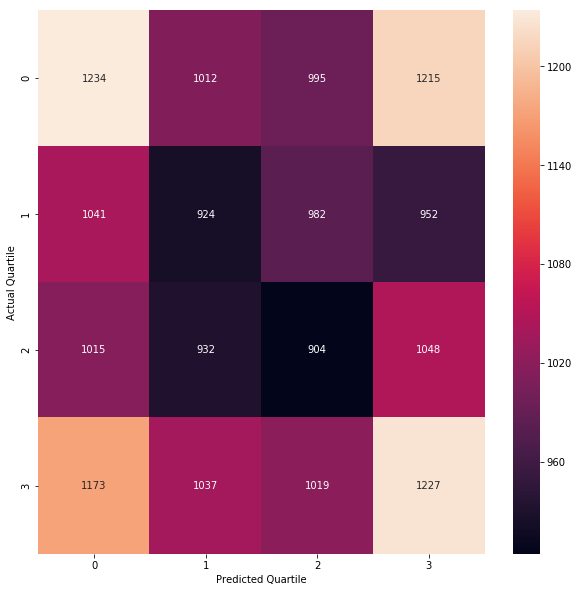

---
01:34:59 Running experiment 204 of 216
(1000, 6, 0.01, 0.8)
01:34:59 Generate splits [140, 280, 419, 558, 697]
classify
01:34:59 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.027%
Monthly Sharpe ratio: 0.029
Avg rank correlation (Kendall's tau): -0.0023 (Expected: 0)
4-quartile accuracy: 0.2545 (Expected: 0.25)
Long/short/flat accuracy: 0.3685 (Expected: 0.375)


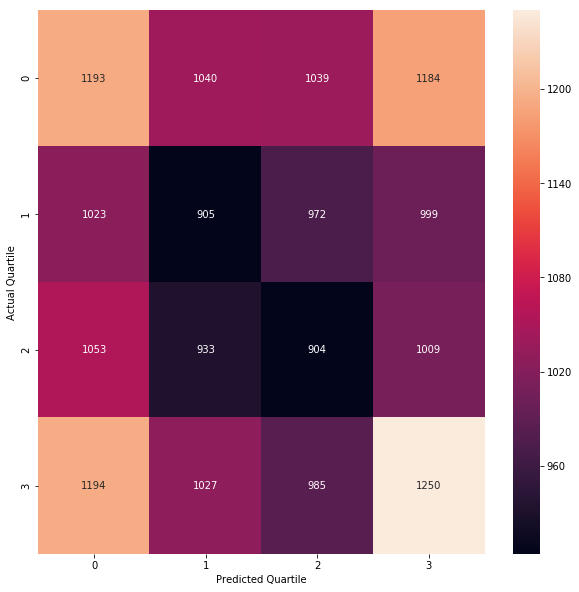

---
01:35:36 Running experiment 205 of 216
(1000, 6, 0.003, 0.6)
01:35:36 Generate splits [140, 280, 419, 558, 697]
classify
01:35:36 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.610%
Monthly Sharpe ratio: 0.148
Avg rank correlation (Kendall's tau): 0.0127 (Expected: 0)
4-quartile accuracy: 0.2692 (Expected: 0.25)
Long/short/flat accuracy: 0.3825 (Expected: 0.375)


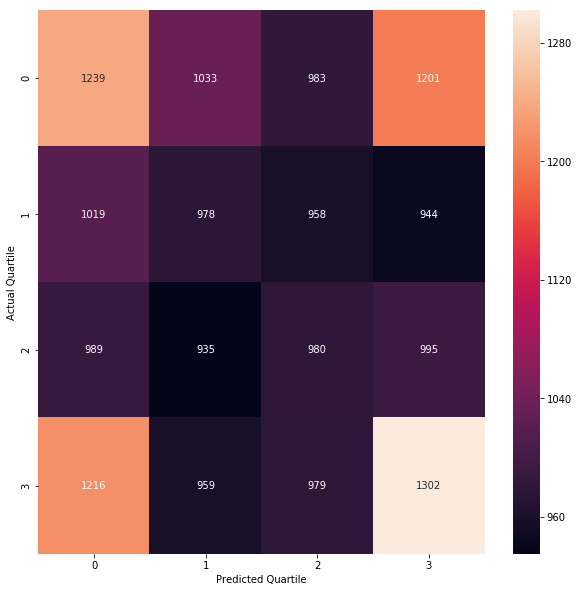

---
01:36:11 Running experiment 206 of 216
(1000, 6, 0.003, 0.7)
01:36:11 Generate splits [140, 280, 419, 558, 697]
classify
01:36:11 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 1.233%
Monthly Sharpe ratio: 0.282
Avg rank correlation (Kendall's tau): 0.0098 (Expected: 0)
4-quartile accuracy: 0.2634 (Expected: 0.25)
Long/short/flat accuracy: 0.3744 (Expected: 0.375)


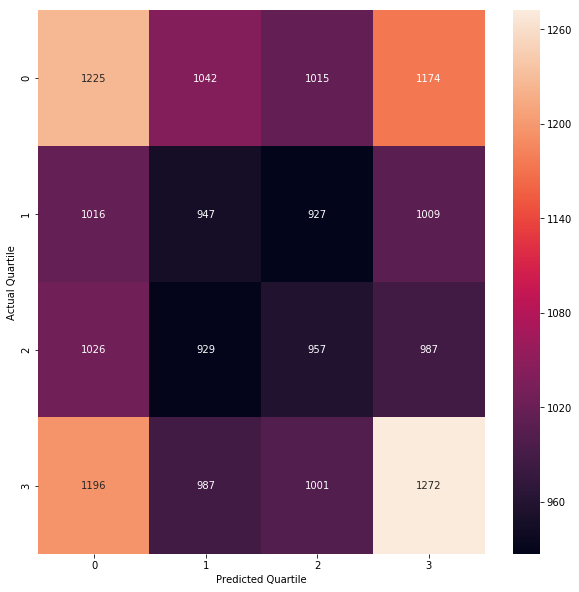

---
01:36:46 Running experiment 207 of 216
(1000, 6, 0.003, 0.8)
01:36:46 Generate splits [140, 280, 419, 558, 697]
classify
01:36:46 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.919%
Monthly Sharpe ratio: 0.207
Avg rank correlation (Kendall's tau): 0.0125 (Expected: 0)
4-quartile accuracy: 0.2687 (Expected: 0.25)
Long/short/flat accuracy: 0.3831 (Expected: 0.375)


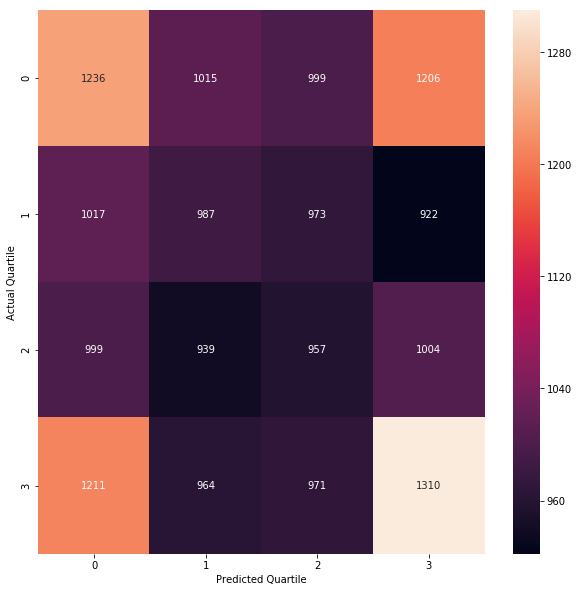

---
01:37:21 Running experiment 208 of 216
(1000, 6, 0.001, 0.6)
01:37:21 Generate splits [140, 280, 419, 558, 697]
classify
01:37:21 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.204%
Monthly Sharpe ratio: -0.034
Avg rank correlation (Kendall's tau): -0.0048 (Expected: 0)
4-quartile accuracy: 0.2486 (Expected: 0.25)
Long/short/flat accuracy: 0.3563 (Expected: 0.375)


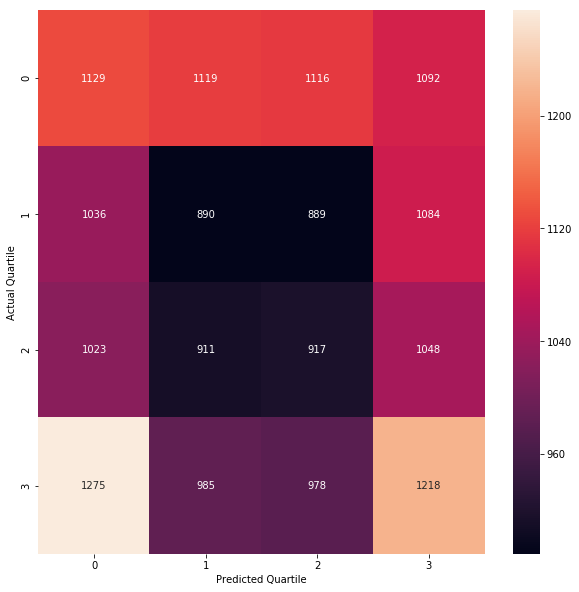

---
01:37:55 Running experiment 209 of 216
(1000, 6, 0.001, 0.7)
01:37:55 Generate splits [140, 280, 419, 558, 697]
classify
01:37:55 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.814%
Monthly Sharpe ratio: 0.204
Avg rank correlation (Kendall's tau): -0.0003 (Expected: 0)
4-quartile accuracy: 0.2524 (Expected: 0.25)
Long/short/flat accuracy: 0.3654 (Expected: 0.375)


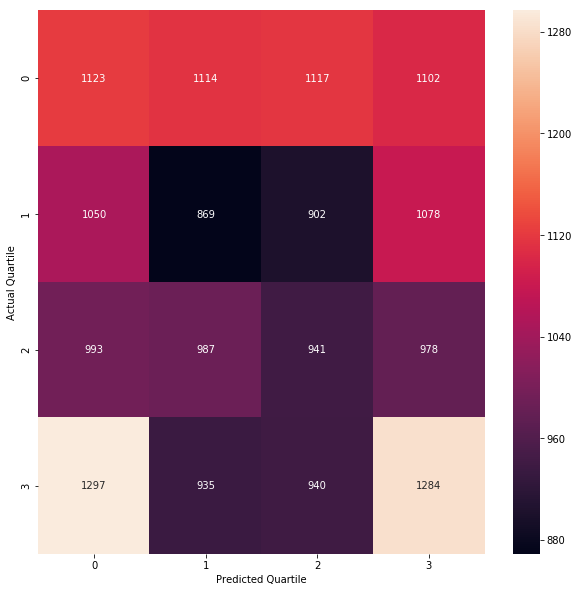

---
01:38:30 Running experiment 210 of 216
(1000, 6, 0.001, 0.8)
01:38:30 Generate splits [140, 280, 419, 558, 697]
classify
01:38:30 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.002%
Monthly Sharpe ratio: 0.019
Avg rank correlation (Kendall's tau): -0.0022 (Expected: 0)
4-quartile accuracy: 0.2510 (Expected: 0.25)
Long/short/flat accuracy: 0.3609 (Expected: 0.375)


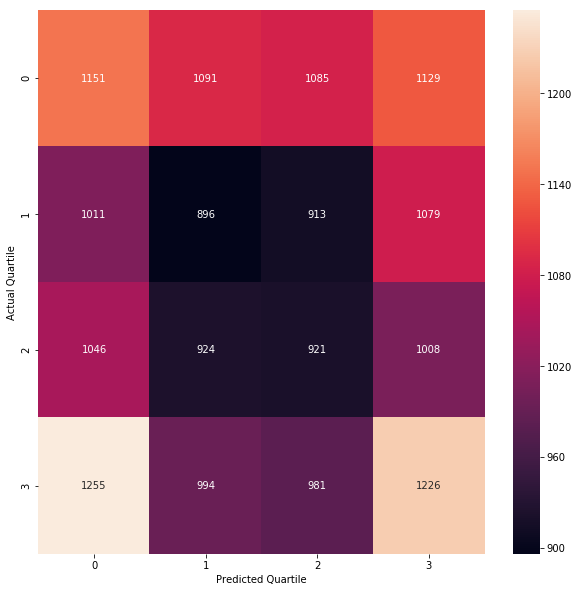

---
01:39:04 Running experiment 211 of 216
(1000, 6, 0.0003, 0.6)
01:39:04 Generate splits [140, 280, 419, 558, 697]
classify
01:39:04 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.417%
Monthly Sharpe ratio: -0.079
Avg rank correlation (Kendall's tau): 0.0024 (Expected: 0)
4-quartile accuracy: 0.2623 (Expected: 0.25)
Long/short/flat accuracy: 0.3675 (Expected: 0.375)


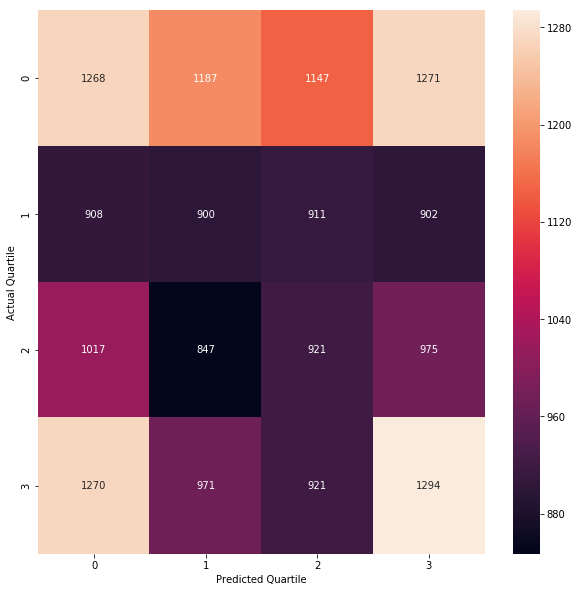

---
01:39:38 Running experiment 212 of 216
(1000, 6, 0.0003, 0.7)
01:39:38 Generate splits [140, 280, 419, 558, 697]
classify
01:39:38 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.417%
Monthly Sharpe ratio: -0.079
Avg rank correlation (Kendall's tau): -0.0028 (Expected: 0)
4-quartile accuracy: 0.2523 (Expected: 0.25)
Long/short/flat accuracy: 0.3601 (Expected: 0.375)


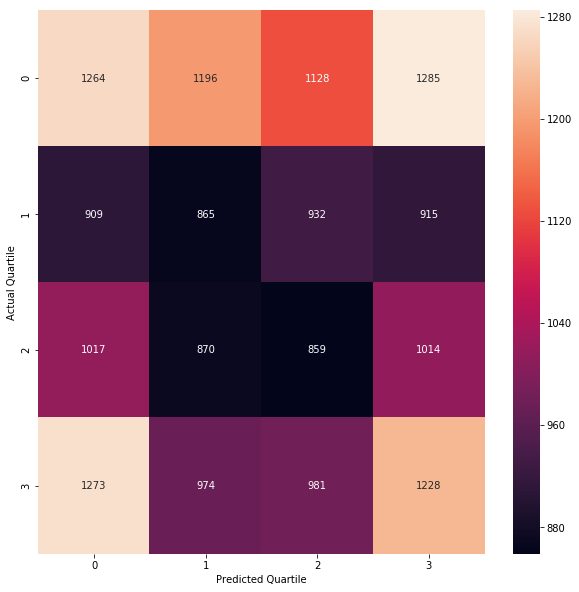

---
01:40:11 Running experiment 213 of 216
(1000, 6, 0.0003, 0.8)
01:40:11 Generate splits [140, 280, 419, 558, 697]
classify
01:40:11 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: -0.417%
Monthly Sharpe ratio: -0.079
Avg rank correlation (Kendall's tau): 0.0041 (Expected: 0)
4-quartile accuracy: 0.2599 (Expected: 0.25)
Long/short/flat accuracy: 0.3643 (Expected: 0.375)


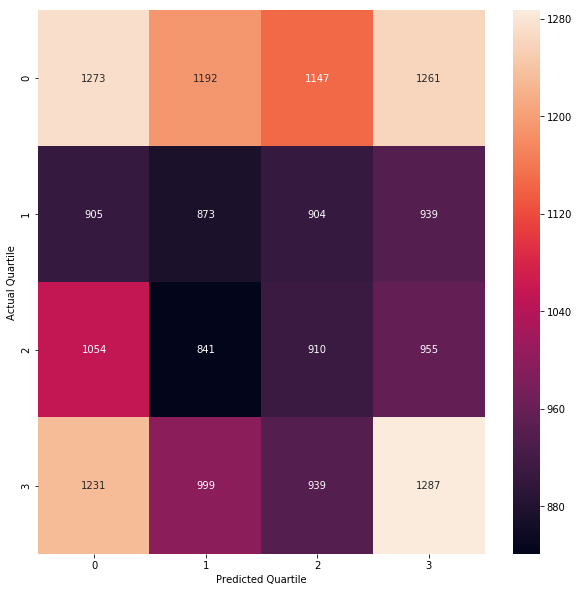

---
01:40:45 Running experiment 214 of 216
(1000, 6, 0.0001, 0.6)
01:40:45 Generate splits [140, 280, 419, 558, 697]
classify
01:40:45 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): -0.0010 (Expected: 0)
4-quartile accuracy: 0.2506 (Expected: 0.25)
Long/short/flat accuracy: 0.3597 (Expected: 0.375)


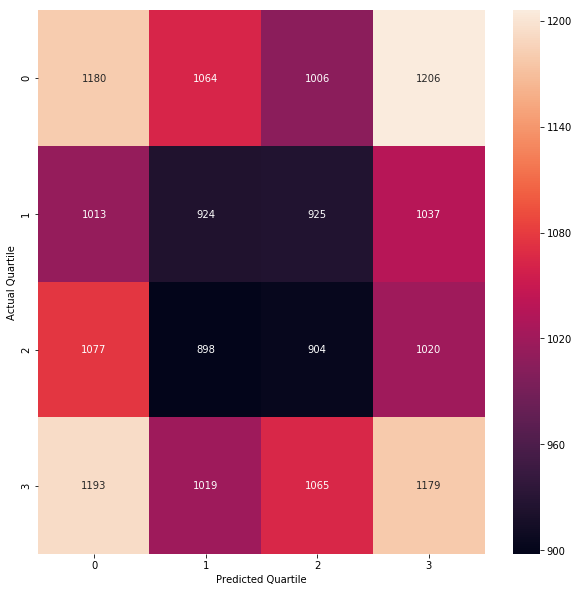

---
01:41:19 Running experiment 215 of 216
(1000, 6, 0.0001, 0.7)
01:41:19 Generate splits [140, 280, 419, 558, 697]
classify
01:41:19 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): 0.0016 (Expected: 0)
4-quartile accuracy: 0.2495 (Expected: 0.25)
Long/short/flat accuracy: 0.3607 (Expected: 0.375)


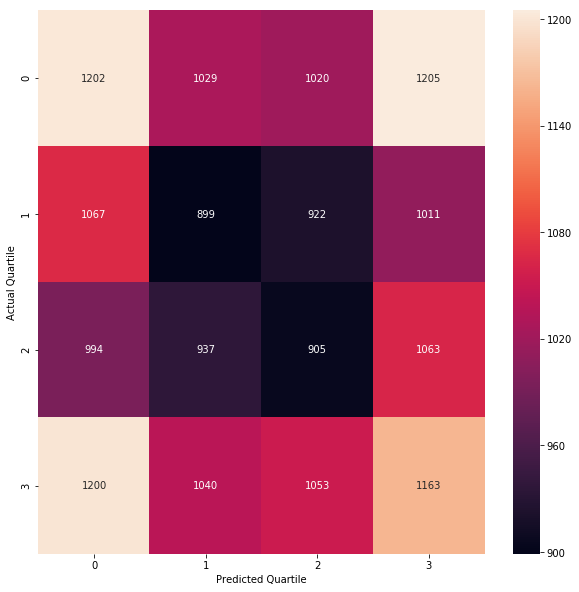

---
01:41:52 Running experiment 216 of 216
(1000, 6, 0.0001, 0.8)
01:41:52 Generate splits [140, 280, 419, 558, 697]
classify
01:41:52 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
Mean return: 0.148%
Monthly Sharpe ratio: 0.063
Avg rank correlation (Kendall's tau): -0.0151 (Expected: 0)
4-quartile accuracy: 0.2481 (Expected: 0.25)
Long/short/flat accuracy: 0.3580 (Expected: 0.375)


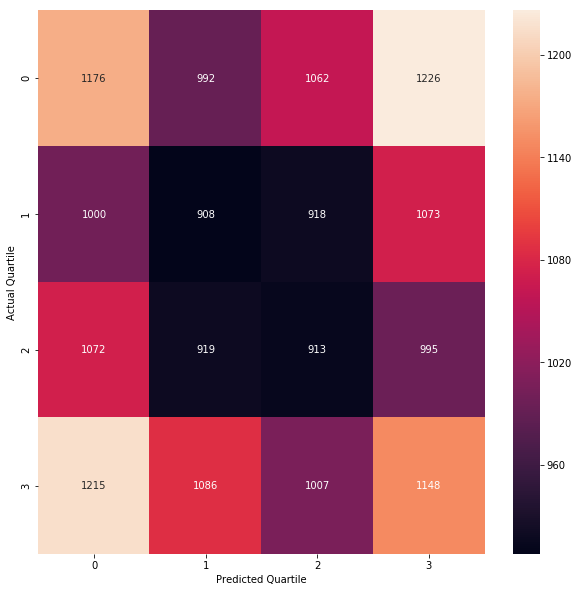

---


In [39]:
# tune XGBClassifier

keys = []
sharpes2 = []
directional_accuracies2=[]
in_sample_accuracies2 = []

n_estimators_list = [100, 300, 1000]
max_depth_list = [3,4,5,6]
learning_rate_list = [0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001]
subsample_list = [0.6, 0.7, 0.8]
hyperparameter_combos = list(product(n_estimators_list, max_depth_list, learning_rate_list, subsample_list))

def myXGBClassifier(n_estimators, max_depth, subsample, learning_rate):
    def create_model():
        return xgboost.sklearn.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, subsample=subsample, learning_rate=learning_rate, nthreads=-1)
    return create_model

print("%s Running %d experiments" % (time.strftime("%H:%M:%S"), len(hyperparameter_combos)))
for counter, param_list in enumerate(hyperparameter_combos):
    n_estimators, max_depth, subsample, learning_rate = param_list
    print("%s Running experiment %d of %d" % (time.strftime("%H:%M:%S"), counter+1, len(hyperparameter_combos)))
    key = (n_estimators, max_depth, subsample, learning_rate)
    print(key)
    keys.append(key)
    backtestmodel = BacktestModel(X, Y, 
                                  create_model=myXGBClassifier(n_estimators,max_depth,subsample,learning_rate), 
                                  coef_dict_param="all", 
                                  startindex=FIRST_TRAIN_MONTHS,
                                  fit_missing='mean',
                                  scaler = None,
                                  make_classes=make_four_classes)
    backtestmodel.walkforward_xval(n_splits=5, verbose=True) 
    # backtestmodel.gen_predictions_classify(verbose=False)
    backtestmodel.gen_returns(calc_returns, verbose=False)
    backtestmodel.report_returns(start_date=start_date_str, freq='M')
    sharpes2.append(backtestmodel.sharpe)
    try:
        backtestmodel.evaluate_quantiles(chart=True, verbose=True)
        directional_accuracies2.append(backtestmodel.directional_accuracy)
        in_sample_accuracies2.append(backtestmodel.insample_accuracy)
    except:
        directional_accuracies2.append(np.nan)
        in_sample_accuracies2.append(np.nan)

    print("---")

In [40]:
# fix display precision
metricsframe = pd.DataFrame(list(zip(["%d" % k[0] for k in keys],
                                     ["%d" % k[1] for k in keys],
                                     ["%.5f" % k[2] for k in keys],
                                     ["%.3f" % k[3] for k in keys],
                                     ["%.4f" % z for z in in_sample_accuracies2],
                                     ["%.4f" % z for z in directional_accuracies2],
                                     ["%.3f" % z for z in sharpes2])), 
                            columns = ['n_estimators', 'max_depth', 'learning_rate', 'subsample','in_sample_acc','oos_acc','sharpe'])

in_sample_accuracies2 = ["%.3f" % z for z in in_sample_accuracies]
directional_accuracies2 = ["%.3f" % z for z in directional_accuracies]
kendall_taus2 = ["%.3f" % z for z in kendall_taus]
ann_returns2 = ["%.3f" % z for z in ann_returns]
vols2 = ["%.3f" % z for z in vols]
sharpes2 = ["%.3f" % z for z in sharpes]

metricsframe

n_estimators max_depth learning_rate subsample in_sample_acc oos_acc  \
0            100         3       0.03000     0.600        0.3585  0.3788   
1            100         3       0.03000     0.700        0.3438  0.3716   
2            100         3       0.03000     0.800        0.3411  0.3750   
3            100         3       0.01000     0.600        0.2997  0.3655   
4            100         3       0.01000     0.700        0.2878  0.3737   
5            100         3       0.01000     0.800        0.2896  0.3698   
6            100         3       0.00300     0.600        0.2846  0.3569   
7            100         3       0.00300     0.700        0.2817  0.3588   
8            100         3       0.00300     0.800        0.2768  0.3665   
9            100         3       0.00100     0.600        0.2749  0.3683   
10           100         3       0.00100     0.700        0.2735  0.3617   
11           100         3       0.00100     0.800        0.2732  0.3647   
12           100         3       0.00030     0.600        0.2637  0.3599   
13           100         3       0.00030     0.700        0.2637  0.3631   
14           100         3       0.00030     0.800        0.2637  0.3676   
15           100         3       0.00010     0.600        0.2667  0.3587   
16           100         3       0.00010     0.700        0.2667  0.3594   
17           100         3       0.00010     0.800        0.2667  0.3570   
18           100         4       0.03000     0.600        0.3586  0.3795   
19           100         4       0.03000     0.700        0.3461  0.3701   
20           100         4       0.03000     0.800        0.3421  0.3752   
21           100         4       0.01000     0.600        0.2997  0.3655   
22           100         4       0.01000     0.700        0.2878  0.3737   
23           100         4       0.01000     0.800        0.2896  0.3698   
24           100         4       0.00300     0.600        0.2846  0.3569   
25           100         4       0.00300     0.700        0.2817  0.3588   
26           100         4       0.00300     0.800        0.2768  0.3665   
27           100         4       0.00100     0.600        0.2749  0.3620   
28           100         4       0.00100     0.700        0.2735  0.3624   
29           100         4       0.00100     0.800        0.2732  0.3641   
..           ...       ...           ...       ...           ...     ...   
186         1000         5       0.00300     0.600        0.2868  0.3825   
187         1000         5       0.00300     0.700        0.2807  0.3744   
188         1000         5       0.00300     0.800        0.2782  0.3831   
189         1000         5       0.00100     0.600        0.2794  0.3551   
190         1000         5       0.00100     0.700        0.2845  0.3647   
191         1000         5       0.00100     0.800        0.2827  0.3586   
192         1000         5       0.00030     0.600        0.2770  0.3634   
193         1000         5       0.00030     0.700        0.2770  0.3609   
194         1000         5       0.00030     0.800        0.2770  0.3591   
195         1000         5       0.00010     0.600        0.2667  0.3601   
196         1000         5       0.00010     0.700        0.2667  0.3675   
197         1000         5       0.00010     0.800        0.2667  0.3581   
198         1000         6       0.03000     0.600        0.4328  0.3770   
199         1000         6       0.03000     0.700        0.4085  0.3646   
200         1000         6       0.03000     0.800        0.3953  0.3738   
201         1000         6       0.01000     0.600        0.3269  0.3709   
202         1000         6       0.01000     0.700        0.3096  0.3712   
203         1000         6       0.01000     0.800        0.3132  0.3685   
204         1000         6       0.00300     0.600        0.2868  0.3825   
205         1000         6       0.00300     0.700        0.2807  0.3744   
206         1000         6       0.00300     0.800  

In [43]:
metricsframe.sort_values(["oos_acc"])

n_estimators max_depth learning_rate subsample in_sample_acc oos_acc  \
50           100         5       0.00030     0.800        0.2637  0.3487   
123          300         5       0.00010     0.600        0.2667  0.3531   
179         1000         4       0.00010     0.800        0.2667  0.3545   
159         1000         3       0.00010     0.600        0.2667  0.3546   
141          300         6       0.00010     0.600        0.2667  0.3551   
69           100         6       0.00010     0.600        0.2667  0.3551   
189         1000         5       0.00100     0.600        0.2794  0.3551   
124          300         5       0.00010     0.700        0.2667  0.3555   
139          300         6       0.00030     0.700        0.2637  0.3557   
207         1000         6       0.00100     0.600        0.2794  0.3563   
153         1000         3       0.00100     0.600        0.2794  0.3567   
60           100         6       0.00300     0.600        0.2846  0.3569   
24           100         4       0.00300     0.600        0.2846  0.3569   
42           100         5       0.00300     0.600        0.2846  0.3569   
6            100         3       0.00300     0.600        0.2846  0.3569   
17           100         3       0.00010     0.800        0.2667  0.3570   
171         1000         4       0.00100     0.600        0.2794  0.3570   
67           100         6       0.00030     0.700        0.2637  0.3578   
85           300         3       0.00030     0.700        0.2637  0.3579   
215         1000         6       0.00010     0.800        0.2667  0.3580   
51           100         5       0.00010     0.600        0.2667  0.3580   
84           300         3       0.00030     0.600        0.2637  0.3580   
197         1000         5       0.00010     0.800        0.2667  0.3581   
142          300         6       0.00010     0.700        0.2667  0.3582   
157         1000         3       0.00030     0.700        0.2770  0.3583   
31           100         4       0.00030     0.700        0.2637  0.3584   
105          300         4       0.00010     0.600        0.2667  0.3585   
191         1000         5       0.00100     0.800        0.2827  0.3586   
52           100         5       0.00010     0.700        0.2667  0.3587   
15           100         3       0.00010     0.600        0.2667  0.3587   
..           ...       ...           ...       ...           ...     ...   
20           100         4       0.03000     0.800        0.3421  0.3752   
146         1000         3       0.03000     0.800        0.3955  0.3753   
144         1000         3       0.03000     0.600        0.4317  0.3756   
133          300         6       0.00300     0.700        0.2786  0.3764   
79           300         3       0.00300     0.700        0.2786  0.3764   
115          300         5       0.00300     0.700        0.2786  0.3764   
97           300         4       0.00300     0.700        0.2786  0.3764   
180         1000         5       0.03000     0.600        0.4328  0.3770   
162         1000         4       0.03000     0.600        0.4328  0.3770   
198         1000         6       0.03000     0.600        0.4328  0.3770   
72           300         3       0.03000     0.600        0.3831  0.3780   
0            100         3       0.03000     0.600        0.3585  0.3788   
54           100         6       0.03000     0.600        0.3586  0.3795   
18           100         4       0.03000     0.600        0.3586  0.3795   
36           100         5       0.03000     0.600        0.3586  0.3795   
108          300         5       0.03000     0.600        0.3879  0.3798   
90           300         4       0.03000     0.600        0.3879  0.3798   
126          300         6       0.03000     0.600        0.3879  0.3798   
168         1000         4       0.00300     0.600        0.2868  0.3825   
204         1000         6       0.00300     0.600        0.2868  0.3825   
186         1000         5       0.00300     0.600  

In [41]:
pd.DataFrame(metricsframe.groupby(['n_estimators'])[['in_sample_acc', 'oos_acc', 'sharpe']].mean())

DataError: No numeric types to aggregate

In [ ]:
pd.DataFrame(metricsframe.groupby(['max_depth'])[['in_sample_acc', 'oos_acc', 'sharpe']].mean())

In [ ]:
pd.DataFrame(metricsframe.groupby(['subsample'])[['in_sample_acc', 'oos_acc', 'sharpe']].mean())

In [ ]:
pd.DataFrame(metricsframe.groupby(['learning_rate'])[['in_sample_acc', 'oos_acc', 'sharpe']].mean())

15:58:51 Running 1 experiments
15:58:51 Running experiment 1 of 1
(1000, 4, 0.001, 0.7)
15:58:51 Generate splits [140, 280, 419, 558, 697]
classify
15:58:51 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)

Iteration with suspicious time -6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time 6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time -6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time 6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time 6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time -6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time 6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time -6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time 6.09e+05 sec ignored in overall statistics.

Iteration with suspicious ti


Iteration with suspicious time -6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time 6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time -6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time 6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time 6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time -6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time 6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time -6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time 6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time -6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time 6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time -6.09e+05 sec ignored in overall statistics.

Iteration with suspicious time 6.09e+05 sec ignored in overall statistics.

Itera

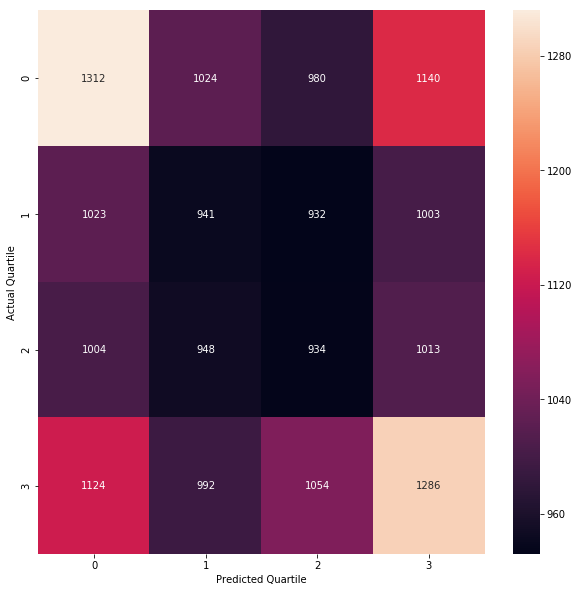

---
Mean return: 2.522%
Monthly Sharpe ratio: 0.484
Avg rank correlation (Kendall's tau): 0.0297 (Expected: 0)
4-quartile accuracy: 0.2677 (Expected: 0.25)
Long/short/flat accuracy: 0.3802 (Expected: 0.375)


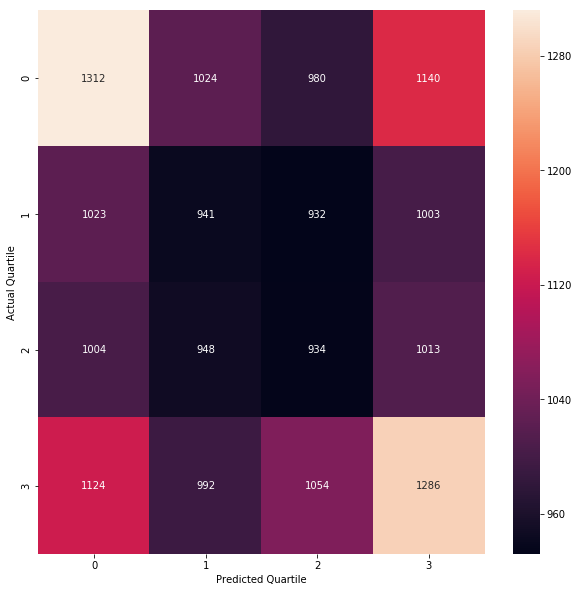

0.38019150209455416
0.8534672405547585


In [75]:
model = catboost.CatBoostClassifier()

keys = []
sharpes3 = []
directional_accuracies3=[]
in_sample_accuracies3 = []

n_estimators_list = [1000]
max_depth_list = [4]
learning_rate_list = [0.001]
subsample_list = [0.7]
hyperparameter_combos = list(product(n_estimators_list, max_depth_list, learning_rate_list, subsample_list))

def myCatClassifier(n_estimators=1000, max_depth=4, subsample=0.7, learning_rate=0.001):
    def create_model():
        #return catboost.CatBoostClassifier(iterations=n_estimators, learning_rate=learning_rate, depth=max_depth, rsm=subsample, 
        #                                   thread_count=6, loss_function='MultiClass', task_type='CPU', logging_level='Silent')
        return catboost.CatBoostClassifier(loss_function='MultiClass', task_type='CPU', logging_level='Silent')
    return create_model

print("%s Running %d experiments" % (time.strftime("%H:%M:%S"), len(hyperparameter_combos)))
for counter, param_list in enumerate(hyperparameter_combos):
    n_estimators, max_depth, subsample, learning_rate = param_list
    print("%s Running experiment %d of %d" % (time.strftime("%H:%M:%S"), counter+1, len(hyperparameter_combos)))
    key = (n_estimators, max_depth, subsample, learning_rate)
    print(key)
    keys.append(key)
    backtestmodel = BacktestModel(X, Y, 
                                  create_model=myCatClassifier(n_estimators,max_depth,subsample,learning_rate), 
                                  coef_dict_param="all", 
                                  startindex=FIRST_TRAIN_MONTHS,
                                  fit_missing='mean',
                                  scaler = None,
                                  make_classes=make_four_classes)
    #backtestmodel.gen_predictions_classify(verbose=False)
    backtestmodel.walkforward_xval(n_splits=5, verbose=True) 
    backtestmodel.gen_returns(calc_returns, verbose=False)
    backtestmodel.report_returns(start_date=start_date_str, freq='M')
    sharpes3.append(backtestmodel.sharpe)
    try:
        backtestmodel.evaluate_quantiles(chart=True, verbose=True)
        directional_accuracies3.append(backtestmodel.directional_accuracy)
        in_sample_accuracies3.append(backtestmodel.insample_accuracy)
    except:
        directional_accuracies3.append(np.nan)
        in_sample_accuracies3.append(np.nan)

    print("---")

backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
print(backtestmodel.directional_accuracy)
print(backtestmodel.insample_accuracy)
 

In [76]:

class LightGbmWrapper:
    """Wrap Lightgbm model to fit, predict all vars as a vector, 
    match the way our Keras model will do it. No coef_dict"""

    def __init__(self, 
                 param = {'num_leaves':31, 'num_trees':100, 'objective':'multiclass', 'num_class':4, 'metric': 'multi_logloss',},
                 num_round=10):
        self.param = param
        self.num_round = num_round
        self.models = []
        
    def fit(self, X_fit, Y_fit, verbose=False):
        
        self.nrows, self.ycols = Y_fit.shape
        #print("%d rows x %d cols" % (self.nrows, self.ycols))
        self.nclasses = np.unique(Y_fit).shape[0]
        self.models = []
        # fit model for each column
        for responsecol in range(self.ycols):
            train_data = lgb.Dataset(X_fit, label=Y_fit[:,responsecol])
            model = lgb.train(self.param, train_data, self.num_round)
            self.models.append(model)

    def predict_proba(self, X_predict, verbose=False):

        """return a list of length nclasses with probs for each class"""
        retlist = [list() for i in range(self.nclasses)]
        nrows = X_predict.shape[0]

        for responsecol in range(self.ycols):
            y_pred = self.models[responsecol].predict(X_predict)
            for classcol in range(self.nclasses):
                retlist[classcol].append((y_pred[:,classcol].reshape(nrows,1)))
        return [np.hstack(predictions) for predictions in retlist]

    def predict(self, X_predict, verbose=False):
        Z = self.predict_proba(X_predict)
        return np.argmax(np.array(Z), axis=0)
        
        

16:15:16 Starting training
................................................................................
16:15:36 Still training step 80 of 576
................................................................................
16:16:12 Still training step 160 of 576
................................................................................
16:17:09 Still training step 240 of 576
................................................................................
16:18:30 Still training step 320 of 576
................................................................................
16:20:22 Still training step 400 of 576
................................................................................
16:22:48 Still training step 480 of 576
................................................................................
16:25:54 Still training step 560 of 576
................
Mean return: 3.678%
Monthly Sharpe ratio: 0.740
Avg rank correlation (Kendall's tau): 0.0300 (Expected: 0)
4-q

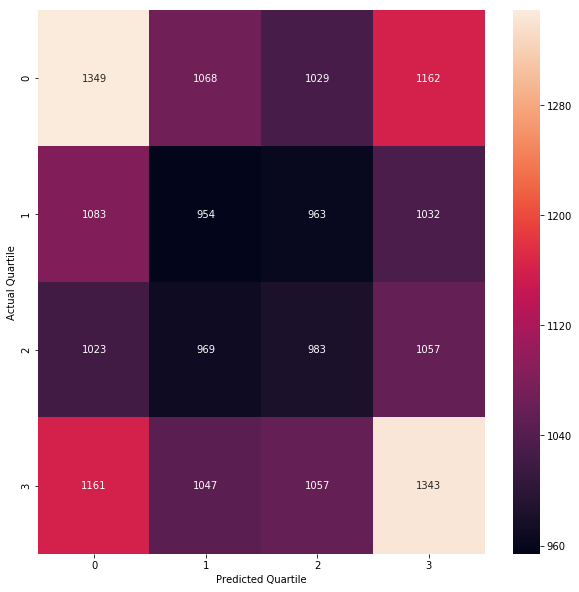

OOS Accuracy: 0.3797
In-Sample Accuracy: 0.9143


In [77]:
backtestmodel = BacktestModel(X, Y, 
                              model=LightGbmWrapper(), 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler = None,
                              make_classes=make_four_classes)
backtestmodel.gen_predictions_classify(verbose=False)
#backtestmodel.walkforward_xval(n_splits=5, verbose=True) 
backtestmodel.gen_returns(calc_returns, verbose=False)

backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
print("OOS Accuracy: %.4f" % backtestmodel.directional_accuracy)
print("In-Sample Accuracy: %.4f" % backtestmodel.insample_accuracy)